# **NASA Dataset**

In [1]:
import sys
print(sys.executable)
import numpy as np
import random
import math
import time
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pickle
import glob
#import xlrd
import scipy.io
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
import datetime
import yaml
import json
import argparse
from datetime import timedelta
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset, random_split
from torch.optim import Adam
from tqdm import tqdm
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import quad
import itertools
from sklearn.model_selection import ParameterGrid
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/vivivorropoulou/Transformer_Diffusion_Model_RUL_Battery_Prediction/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# convert str to datatime 
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data for plot
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

# get capacity data for training 
def getCapacity(Battery):
    capacity_data = []
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity_data.append(Bat['data']['Capacity'][0])
    return capacity_data

# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

## **Data Preprocessing**

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pickle
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)
    charge_data = []
    discharge_data = []
    rated_capacity = 1.1
    for cycle in data:
        if cycle['type'] == 'charge':
            charge_data.append(cycle['data'])
        elif cycle['type'] == 'discharge':
            discharge_data.append(cycle['data'])
    rows = []
    for cycle in charge_data:
        rows.append({
            'Voltage_measured': np.mean(cycle['Voltage_measured']),
            'Current_measured': np.mean(cycle['Current_measured']),
            'Temperature_measured': np.mean(cycle['Temperature_measured']),
            'Voltage_charge': np.mean(cycle['Voltage_charge']),
            'Current_charge': np.mean(cycle['Current_charge']),
            'time': np.mean(cycle['Time'])
        })

    df_result = pd.DataFrame(rows)
    df_result = df_result.dropna()

    capacity_data = []
    for cycle in discharge_data:
        capacity_data.append(cycle['Capacity'][0])

    min_length = min(len(df_result), len(capacity_data)) # Ensure capacity data length matches df_result length
    df_result = df_result.iloc[:min_length]
    capacity_data = capacity_data[:min_length]
    # Calculate SoH
    soh = [cap / rated_capacity for cap in capacity_data]
    df_result['SoH'] = soh[:min_length]
    df_result['Capacity'] = capacity_data[:min_length]
    # Normalize the features
    features = ['Capacity','SoH', 'Current_measured', 'Voltage_measured', 'time']
    scaler = MinMaxScaler()
    df_result[features] = scaler.fit_transform(df_result[features])

    # Prepare sequences of features
    sequence_length = 50
    var = []
    target_var = []

    for i in range(len(df_result) - sequence_length):
        sequence = df_result[features].iloc[i:i + sequence_length].values
        var.append(sequence)
        target_var.append(capacity_data[i + sequence_length - 1])
    var = np.array(var)
    target_var = np.array(target_var)

    # Save preprocessed data to a pickle file
    pickle_file_path = f'preprocess/data/NASA/{name}_processed.pkl'
    with open(pickle_file_path, 'wb') as f:
        pickle.dump({'var': var, 'target_var': target_var}, f)


Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


## **Plot Capacity Degradation**

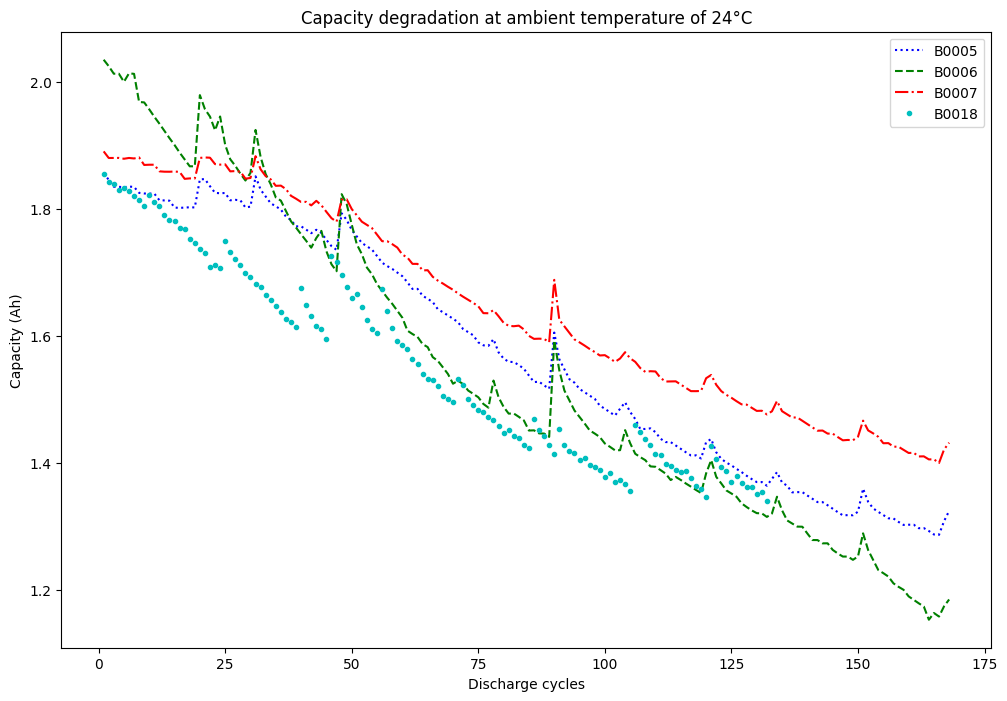

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
#EOL: Battery reaches 80% of capacity
#EOL = ax.hlines(y=0.18,xmin = 0, xmax = 170, linewidth=2, color='r', linestyles = 'dashed', label='End of Life')
plt.legend()

## **Divide in Training, Validation and Test Batteries**

In [7]:
train_batteries = random.sample(Battery_list, 2)
remaining_batteries = list(set(Battery_list) - set(train_batteries))
valid_battery = random.choice(remaining_batteries)
test_battery = list(set(remaining_batteries) - set([valid_battery]))[0]

print(f"Train batteries: {train_batteries}")
print(f"Validation battery: {valid_battery}")
print(f"Test battery: {test_battery}")

Train batteries: ['B0005', 'B0007']
Validation battery: B0018
Test battery: B0006


In [8]:
def get_dataloader(battery_names, batch_size=16):
    datasets = []
    for battery in battery_names:
        with open(f'preprocess/data/NASA/{battery}_processed.pkl', 'rb') as f:
            data = pickle.load(f)
            var = data['var']
            target_var = data['target_var']
            X_tensor = torch.tensor(var, dtype=torch.float32)
            y_tensor = torch.tensor(target_var, dtype=torch.float32).view(-1, 1)
            dataset = TensorDataset(X_tensor, y_tensor)
            datasets.append(dataset)
    combined_dataset = ConcatDataset(datasets)
    loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    return loader

## **Model**

In [9]:
class TimeEmbedding(nn.Module):
    def __init__(self, time_points, time_embedding_dim, device):
        super().__init__()
        self.time_embedding = nn.Embedding(time_points, time_embedding_dim).to(device)

    def forward(self, x):
        return self.time_embedding(x)

class Conv1d_with_init(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode)
        nn.init.kaiming_normal_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, device):
        super().__init__()
        self.device = device
        self.register_buffer('diffusion_embedding', self._build_embedding(num_steps, embedding_dim // 2), persistent=False)
        self.projection1 = nn.Linear(embedding_dim, embedding_dim).to(device)
        self.projection2 = nn.Linear(embedding_dim, embedding_dim).to(device)

    def forward(self, diffusion_step):
        x = self.diffusion_embedding[diffusion_step]
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, num_steps, dim):
        steps = torch.arange(num_steps).unsqueeze(1).to(self.device)
        frequencies = (10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)).to(self.device)
        table = steps * frequencies
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table

class TransformerLayer(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.layer_norm = nn.LayerNorm(config['channels'])
        self.attn = nn.MultiheadAttention(embed_dim=config['channels'], num_heads=config['num_heads'])
        self.ffn = nn.Sequential(
            nn.Linear(config['channels'], config['channels'] * 4),
            nn.ReLU(),
            nn.Linear(config['channels'] * 4, config['channels']),
        )
        self.dropout = nn.Dropout(config.get('dropout', 0.5))
        self.device = device

    def forward(self, x, y):
        original_y = y  # Save original y for skip connection

        #print("Input x shape:", x.shape)
        #print("Input y shape:", y.shape)

        if y.dim() == 4:
            y = y.view(-1, y.shape[2], y.shape[3])  # Assuming seq_len, batch, channel, feature
            original_y = y
        elif y.dim() == 5:
            y = y.view(-1, y.shape[2] * y.shape[3], y.shape[4])  # Assuming combining some dimensions
            original_y = y
        elif y.dim() == 2:
            y = y.unsqueeze(0)  # Add a batch dimension if missing

        #print("Adjusted y shape for processing:", y.shape)

        y = self.layer_norm(y)
        #print("Post layer norm y shape:", y.shape)

        # Attention operation
        attn_output, attn_weights = self.attn(y, y, y)  # Ensure y is a 3D tensor [seq_len, batch_size, features]
        #print("Post attention output shape:", attn_output.shape)

        # Apply residual connections and dropout
        y = y + self.dropout(attn_output)
        y = y + self.dropout(self.ffn(y))

        return y, original_y  # Return both the transformed y and the original y as a skip connection

class ResNet(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.size_x = config['size']
        self.channels = config['channels']
        num_features = 1  # Only the capacity feature
        lv = len(var)

        self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(1, self.channels).to(self.device)
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1)
        self.diffusion_embedding = DiffusionEmbedding(config['num_steps'], config['diffusion_embedding_dim'], self.device)
        self.diffusion_projection = nn.Linear(config['diffusion_embedding_dim'], self.channels).to(self.device)
        self.residual_layers = nn.ModuleList([
            TransformerLayer(config, self.device)
            for _ in range(config['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        diffusion_emb = self.diffusion_embedding(diffusion_step)
        diffusion_emb = self.diffusion_projection(diffusion_emb)

        # Ensure diffusion_emb has the necessary dimensions
        if diffusion_emb.dim() == 2:
            diffusion_emb = diffusion_emb.unsqueeze(1)  # Add sequence dimension if missing

        # Broadcast diffusion_emb to match y_emb dimension
        samples_x = samples_x.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()

        x_emb = self.emb_f(samples_x)
        y_emb = self.emb_f(samples_y)

        y_emb, diffusion_emb = torch.broadcast_tensors(y_emb, diffusion_emb)  # Ensure dimensions are compatible
        y_emb += diffusion_emb

        # Process through your network layers
        skip = []
        for layer in self.residual_layers:
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)

        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output

In [10]:
class TDSTF(nn.Module):
    def __init__(self, config, device):
        super(TDSTF, self).__init__()
        self.device = device
        self.config_diff = config['diffusion']
        self.res_model = ResNet(self.config_diff, self.device)
        self.num_steps = self.config_diff['num_steps']
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)

    def process(self, batch):
        samples_x = batch[0].to(self.device).float()
        samples_y = batch[1].to(self.device).float().view(-1, 1)
        return samples_x, samples_y

    def forward(self, samples_x, samples_y):
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device)
        current_alpha = self.alpha_torch[t].unsqueeze(1)
        noise = torch.randn_like(samples_y).to(samples_y.device)
        mask_y = torch.ones_like(samples_y).squeeze()
        samples_y = ((current_alpha ** 0.5) * samples_y + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y.unsqueeze(1)
        predicted = self.res_model(samples_x, samples_y, t)
        residual = torch.where(mask_y.unsqueeze(1) == 1, noise - predicted, torch.zeros_like(predicted))
        loss = (residual ** 2).mean()
        return loss

    def forecast(self, samples_x, samples_y, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y = torch.randn_like(samples_y) * samples_y
            for t in range(self.num_steps - 1, -1, -1):
                mask_y = samples_y.squeeze()  # Adjusted to handle the correct shape
                mask_y = mask_y.unsqueeze(-1)  # Adjusting dimensions to match 'predicted' if needed

                predicted = self.res_model(samples_x, samples_y, torch.tensor([t]).to(self.device))
                predicted = predicted.view(-1, samples_y.size(1), predicted.size(-1))  # Adjust shape to match samples_y if necessary

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

                # Ensure dimensions match
                if samples_y.shape != predicted.shape:
                    predicted = predicted.view(samples_y.shape)  # or use another way to ensure shapes are compatible

                samples_y = coeff1 * (samples_y - coeff2 * predicted) * mask_y

                if t > 0:
                    noise = torch.randn_like(samples_y) * mask_y
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y += sigma * noise

            generation[i] = samples_y.detach()
        return generation.permute(1, 2, 0)


    def evaluate(self, samples_x, samples_y):
        with torch.no_grad():
            generation = self.forward(samples_x, samples_y)
        return generation, samples_y, samples_x

## **Training procedure**

In [11]:


def train(model, config, train_loader, valid_loader=None, foldername='', data_path=''):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=5e-8)  # Use AdamW
    total_steps = len(train_loader) * 50
    warmup_steps = total_steps // 10  # 10% of total steps for warmup
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    if foldername != '':
        output_path = os.path.join(foldername, 'model.pth')

    num_epochs = config['train']['epochs']
    accumulation_steps = config['train'].get('accumulation_steps', 4)
    optimizer.zero_grad()  # Initialize gradient

    ct = 0
    training_losses = []
    validation_losses = []
    best_valid_loss = float('inf')
    patience = 30  # Increase patience for early stopping

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}') as progress_bar:
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(model.device), labels.to(model.device)
                loss = model(inputs, labels) / accumulation_steps
                loss.backward()  # Accumulate gradient

                # Gradient Clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                if (batch_idx + 1) % accumulation_steps == 0:
                    optimizer.step()  # Perform a parameter update
                    optimizer.zero_grad()  # Reset gradients

                total_loss += loss.item() * accumulation_steps  # Correct loss scaling

                progress_bar.update(1)
                progress_bar.set_postfix(loss=total_loss / (batch_idx + 1))

        # Scheduler step
        scheduler.step()

        # Check remaining gradient update at the end of an epoch
        if len(train_loader) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        avg_train_loss = total_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation phase
        if valid_loader:
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(model.device), labels.to(model.device)
                    outputs = model(inputs, labels)
                    valid_loss += outputs.item()
            valid_loss /= len(valid_loader)
            validation_losses.append(valid_loss)
            print(f'Validation Loss: {valid_loss}')

            # Save model if validation loss improved
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                output_path = 'save/CALCE'
#                 torch.save(model.state_dict(), output_path)
                print('Model saved with best validation loss:', best_valid_loss)
                ct = 0  # Reset early stopping count
            else:
                ct += 1
                print('No improvement count:', ct)

            if ct >= patience:  # Early stopping condition
                print('Early stopping triggered.')
                break

    return model, training_losses, validation_losses
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
def calc_metrics(data_loader,is_test, all_generation, all_samples_y, title=""):
    MSE = None
    if is_test == 1:
        quantiles = np.arange(0.05, 1.0, 0.05)
        actual_values=all_samples_y
        gt = all_samples_y.cpu()  
        mask = torch.ones_like(gt).cpu()  
        prediction = all_generation
        predictions = torch.stack(all_generation).flatten().cpu()  # Move to CPU before using

        # Convert predictions to NumPy array
        if torch.is_tensor(predictions):
            predictions_np = predictions.detach().cpu().numpy()
        else:
            predictions_np = np.array(predictions)
        prediction1 = torch.tensor(prediction).cpu()  
        MSE = ((prediction1 - gt) * mask) ** 2
        MSE = MSE.sum() / mask.sum()
        y_true = np.array(gt.cpu())  
        y_pred = np.array(prediction1.cpu())  
        
#        Calculate CRPS
        crps_values = []
        for i in range(len(y_true)):
            F_y = lambda x: np.mean(y_true[i] <= x)
            F_f = lambda x: np.mean(y_pred[i] <= x)
            def integrand(x):
                return (F_y(x) - F_f(x)) ** 2
            crps_value, _ = quad(integrand, -np.inf, np.inf)
            crps_values.append(crps_value)
        CRPS = np.mean(crps_values)
        
#     Calculate Test Loss
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            outputs = model(inputs, labels)
            test_loss += outputs.item()
        test_loss /= len(test_loader)
    print()
    print("********************Matrices*********************")
    print(f"Test Loss is: {test_loss}")
    print(f"MSE is: {MSE}")
    print(f"CRPS is: {CRPS}")
    
#         Plotting Predictions Graph
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='test data', color='cyan')
    plt.plot(predictions_np, label='fixed predicted data', color='blue')
    plt.axhline(y=0.8, color='black', linestyle='dotted', label='stop line')
    plt.xlabel('Discharge cycles')
    plt.ylabel('Capacity (Ah)')
    plt.title(title)
    plt.legend()
    plt.show()
    return CRPS,MSE,test_loss,all_generation

def evaluate(is_test, model, data_loader, nsample=100, foldername="", title=""):
    with torch.no_grad():
        model.eval()
        all_samples_x = []
        all_samples_y = []
        all_generation = []
        with tqdm(data_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                samples_x, samples_y = batch
                samples_x, samples_y = samples_x.to(model.device), samples_y.to(model.device)
                # Generate predictions
                generation, samples_y, samples_x = model.evaluate(samples_x, samples_y)
                all_generation.append(generation.cpu())  # Move to CPU
                all_samples_x.append(samples_x.cpu())  
                all_samples_y.append(samples_y.cpu())  

            all_samples_y = [y.mean().cpu() for y in all_samples_y]  # Ensure each mean is moved to CPU
            all_samples_x = torch.cat(all_samples_x).cpu()  
            all_samples_y = torch.tensor(all_samples_y).cpu()  
            CRPS, MSE, loss, predictions = calc_metrics(data_loader, is_test, all_generation, all_samples_y,title)
            return CRPS, MSE, loss, predictions

In [12]:
def plot_losses(training_losses, validation_losses, battery, title=""):
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    saving_path = f'figures/CALCE/{battery}_losses.png'
    os.makedirs(os.path.dirname(saving_path), exist_ok=True)
    plt.savefig(saving_path)
    plt.show()

## **Execution**

In [13]:
CUDA_LAUNCH_BLOCKING = 1

import argparse
import torch
import datetime
import json
import yaml
import os

parser = argparse.ArgumentParser(description='')
parser.add_argument('--device', default='cpu')
parser.add_argument('--modelfolder', type=str, default='')
parser.add_argument('--nsample', type=int, default=882)
args, unknown = parser.parse_known_args()
# print(args)

config = yaml.safe_load(open('config/base.yaml', 'r'))
print(json.dumps(config, indent=4))

default_batch_size = 16
batch_size = config.get('train', {}).get('batch_size', default_batch_size)
current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
base_foldername = 'save/NASA/attention_' + current_time + '/'
print('model base folder:', base_foldername)

os.makedirs(base_foldername, exist_ok=True)
battery = train_batteries
PredictionResults = {}
print(f"Training for battery: {battery}")

data_path = f'preprocess/data/NASA/processed.pkl'
foldername = base_foldername + '/'
os.makedirs(foldername, exist_ok=True)

train_loader = get_dataloader(train_batteries)
valid_loader = get_dataloader([valid_battery])
test_loader = get_dataloader([test_battery])
model = TDSTF(config, args.device).to(args.device)

if args.modelfolder == '':
    trained_model, train_loss, valid_loss =train(
        model,
        config,
        train_loader,
        valid_loader=valid_loader,
        foldername=foldername
    )
else:
    model.load_state_dict(torch.load('save/CALCE/' + args.modelfolder + '/model.pth'))

{
    "train": {
        "epochs": 50,
        "batch_size": 32,
        "lr": 0.001
    },
    "diffusion": {
        "size": 32,
        "layers": 3,
        "channels": 128,
        "num_heads": 8,
        "ff_dim": 512,
        "time_points": 40,
        "diffusion_embedding_dim": 128,
        "time_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50
    }
}
model base folder: save/NASA/attention_20240806_145711/
Training for battery: ['B0005', 'B0007']


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 76.24it/s, loss=10.5]


Validation Loss: 17.656778812408447
Model saved with best validation loss: 17.656778812408447


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 83.98it/s, loss=14.6]


Validation Loss: 8.978825807571411
Model saved with best validation loss: 8.978825807571411


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 84.10it/s, loss=6.06]


Validation Loss: 3.5940102338790894
Model saved with best validation loss: 3.5940102338790894


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 82.63it/s, loss=3.56]


Validation Loss: 2.7320973873138428
Model saved with best validation loss: 2.7320973873138428


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 83.17it/s, loss=2.03]


Validation Loss: 1.689740260442098
Model saved with best validation loss: 1.689740260442098


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 82.77it/s, loss=1.56]


Validation Loss: 0.7362795869509379
Model saved with best validation loss: 0.7362795869509379


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 82.56it/s, loss=1.31]


Validation Loss: 1.4477664629618328
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 69.77it/s, loss=1.38]


Validation Loss: 1.4785106976826985
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 81.65it/s, loss=1.2] 


Validation Loss: 1.0021903465191524
No improvement count: 3


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 81.40it/s, loss=1.06]


Validation Loss: 0.8797624508539835
No improvement count: 4


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 79.34it/s, loss=1.06]


Validation Loss: 0.9317264457543691
No improvement count: 5


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 81.07it/s, loss=1.04]


Validation Loss: 0.7724060472100973
No improvement count: 6


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 77.00it/s, loss=1.04]


Validation Loss: 0.9886474013328552
No improvement count: 7


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 82.43it/s, loss=1.02]


Validation Loss: 0.9212761869033178
No improvement count: 8


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 80.79it/s, loss=1.2] 


Validation Loss: 1.7201513747374217
No improvement count: 9


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 80.60it/s, loss=0.955]


Validation Loss: 1.0031025658051174
No improvement count: 10


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 79.61it/s, loss=1.05]


Validation Loss: 0.6114874618748823
Model saved with best validation loss: 0.6114874618748823


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 75.40it/s, loss=1.06]


Validation Loss: 0.9207240343093872
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 78.70it/s, loss=0.94] 


Validation Loss: 1.3248133063316345
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 80.64it/s, loss=0.955]


Validation Loss: 0.9774775554736456
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 80.12it/s, loss=1.04]


Validation Loss: 1.6384854565064113
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 78.30it/s, loss=0.89] 


Validation Loss: 1.2599935432275136
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 79.98it/s, loss=0.912]


Validation Loss: 0.9723531603813171
No improvement count: 6


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 78.49it/s, loss=0.979]


Validation Loss: 0.8041953792174658
No improvement count: 7


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 80.82it/s, loss=0.932]


Validation Loss: 0.8662104308605194
No improvement count: 8


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 80.17it/s, loss=0.99] 


Validation Loss: 0.8789154390494028
No improvement count: 9


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 80.87it/s, loss=0.88] 


Validation Loss: 0.7438407639662424
No improvement count: 10


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 78.33it/s, loss=1.14]


Validation Loss: 1.1769857307275136
No improvement count: 11


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 77.29it/s, loss=1.14]


Validation Loss: 1.0074815650780995
No improvement count: 12


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 80.07it/s, loss=0.848]


Validation Loss: 1.1304640471935272
No improvement count: 13


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 78.06it/s, loss=0.988]


Validation Loss: 0.7334282596906027
No improvement count: 14


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 81.09it/s, loss=1.09]


Validation Loss: 0.9763162732124329
No improvement count: 15


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 80.68it/s, loss=1.18]


Validation Loss: 1.044387273490429
No improvement count: 16


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 79.52it/s, loss=2.24]


Validation Loss: 0.8806768506765366
No improvement count: 17


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 76.38it/s, loss=12.7]


Validation Loss: 1.2396891117095947
No improvement count: 18


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 79.99it/s, loss=3.56]


Validation Loss: 0.9149548510710398
No improvement count: 19


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 80.62it/s, loss=1.4] 


Validation Loss: 0.8466200431187948
No improvement count: 20


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 82.05it/s, loss=2.29]


Validation Loss: 0.9451976865530014
No improvement count: 21


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 81.07it/s, loss=12.3] 


Validation Loss: 0.8370225367446741
No improvement count: 22


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 81.65it/s, loss=16.6]


Validation Loss: 1.0246530870596569
No improvement count: 23


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 80.97it/s, loss=2.08]


Validation Loss: 1.12081977725029
No improvement count: 24


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 81.93it/s, loss=4.69]


Validation Loss: 0.9520982801914215
No improvement count: 25


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 81.75it/s, loss=7.6] 


Validation Loss: 1.0862927039464314
No improvement count: 26


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 82.07it/s, loss=138] 


Validation Loss: 1.1943045655886333
No improvement count: 27


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 82.26it/s, loss=2.71]


Validation Loss: 0.906580368677775
No improvement count: 28


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 82.39it/s, loss=0.711]


Validation Loss: 1.0064757664998372
No improvement count: 29


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 80.41it/s, loss=2.71] 


Validation Loss: 0.8863182862599691
No improvement count: 30
Early stopping triggered.


## **Plot Losses**

Test


100%|██████████| 8/8 [00:00<00:00, 241.50it/s]
/tmp/ipykernel_1418390/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 1.0312667340040207
MSE is: 0.20941311120986938
CRPS is: 0.23531810296271427


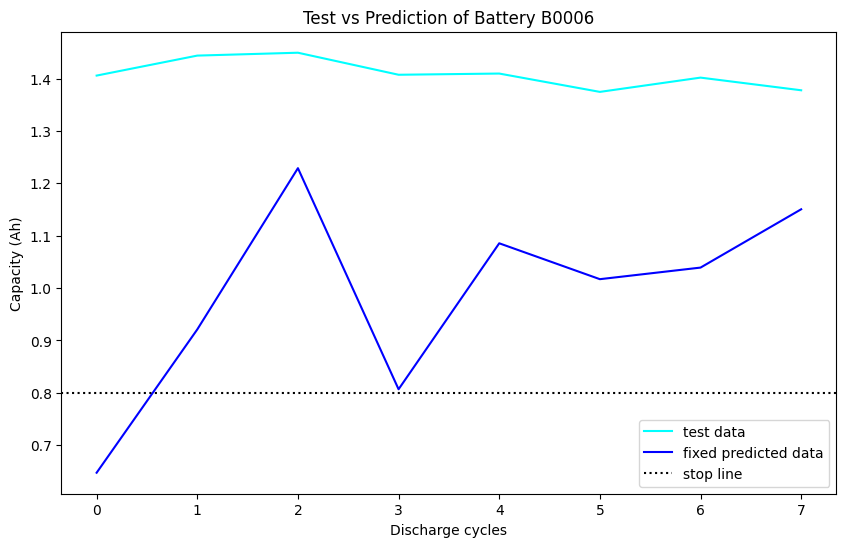

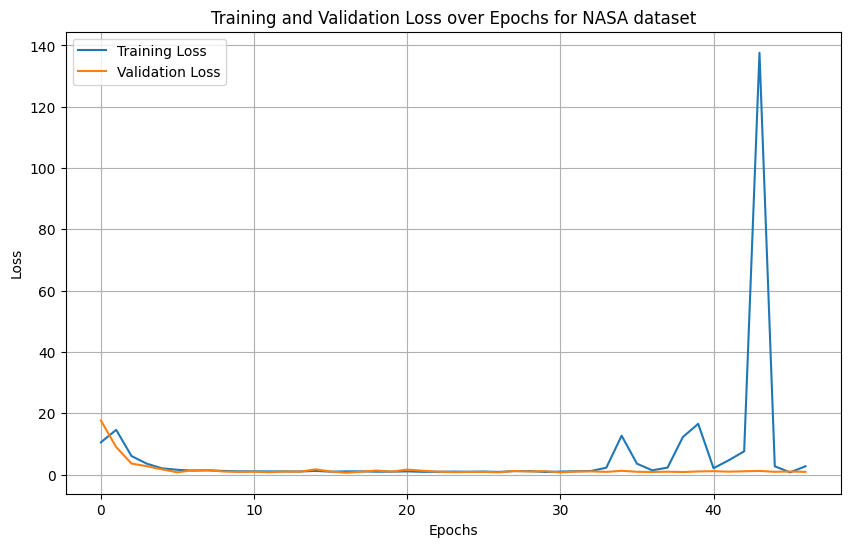

In [14]:
print('Test')
CRPS, MSE,loss,predictions = evaluate(is_test=True, model=model, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction of Battery {test_battery}')

# Plot losses
plot_losses(train_loss, valid_loss, test_battery, title='Training and Validation Loss over Epochs for NASA dataset')

## **Grid Search**

In [17]:

# hyperparameters grid
param_grid = {
    'lr': [0.1, 0.01, 0.001],
    'dropout': [0.3, 0.5],
    'batch_size': [16, 32],
    'num_layers': [2, 4],
    'embedding_dim': [64, 128],
    'num_heads': [2, 4]
}

# Get dataloaders with specified batch size
def get_dataloader_with_batch_size(battery_names, batch_size):
    datasets = []
    for battery in battery_names:
        with open(f'preprocess/data/{battery}_processed.pkl', 'rb') as f:
            data = pickle.load(f)
            var = data['var']
            target_var = data['target_var']
            X_tensor = torch.tensor(var, dtype=torch.float32)
            y_tensor = torch.tensor(target_var, dtype=torch.float32).view(-1, 1)
            dataset = TensorDataset(X_tensor, y_tensor)
            datasets.append(dataset)
    combined_dataset = ConcatDataset(datasets)
    loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    return loader

# Grid search 
best_valid_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # Update 
    config['train']['lr'] = params['lr']
    config['train']['batch_size'] = params['batch_size']
    config['diffusion']['dropout'] = params['dropout']
    config['diffusion']['time_embedding_dim'] = params['embedding_dim']

    train_loader = get_dataloader_with_batch_size(train_batteries, params['batch_size'])
    valid_loader = get_dataloader_with_batch_size([valid_battery], params['batch_size'])
    test_loader = get_dataloader_with_batch_size([test_battery], params['batch_size'])

    model = TDSTF(config, device).to(device)
    model, train_loss, valid_loss = train(model, config, train_loader, valid_loader=valid_loader, foldername=foldername)

    avg_valid_loss = np.mean(valid_loss)
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_params = params

print(f'Best parameters: {best_params}')
print(f'Best validation loss: {best_valid_loss}')

# Retrain 
config['train']['lr'] = best_params['lr']
config['train']['batch_size'] = best_params['batch_size']
config['diffusion']['dropout'] = best_params['dropout']
config['diffusion']['time_embedding_dim'] = best_params['embedding_dim']

train_loaderhyp = get_dataloader_with_batch_size(train_batteries, best_params['batch_size'])
valid_loaderhyp = get_dataloader_with_batch_size([valid_battery], best_params['batch_size'])
test_loaderhyp = get_dataloader_with_batch_size([test_battery], best_params['batch_size'])

modelhyp = TDSTF(config, device).to(device)
modelhyp, train_losshyp, valid_losshyp = train(modelhyp, config, train_loaderhyp, valid_loader=valid_loaderhyp)

# Evaluate 
CRPShyper, MSEhyper,losshyper,predictionshyper  = evaluate(is_test=True, model=modelhyp, data_loader=test_loaderhyp, nsample=1000, foldername=foldername)
print(f'Test:')
#plot_losses(train_losshyp, valid_losshyp, test_battery)

Epoch 1/50:   7%|▋         | 1/15 [00:00<00:00, 40.16it/s, loss=3.63]

Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 38.17it/s, loss=2.71]


Validation Loss: 39.11941647529602
Model saved with best validation loss: 39.11941647529602


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.12it/s, loss=41.1]


Validation Loss: 9.878601849079132
Model saved with best validation loss: 9.878601849079132


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.50it/s, loss=8.64]


Validation Loss: 2.6773478984832764
Model saved with best validation loss: 2.6773478984832764


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.39it/s, loss=2.69]


Validation Loss: 1.709636963903904
Model saved with best validation loss: 1.709636963903904


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.59it/s, loss=2.07]


Validation Loss: 4.861904829740524
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 39.12it/s, loss=3.42]


Validation Loss: 2.598187178373337
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.10it/s, loss=1.95]


Validation Loss: 2.173885405063629
No improvement count: 3


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=2.04]


Validation Loss: 2.985606759786606
No improvement count: 4


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.19it/s, loss=1.35]


Validation Loss: 1.2604227922856808
Model saved with best validation loss: 1.2604227922856808


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.09it/s, loss=1.5] 


Validation Loss: 1.2620199024677277
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.90it/s, loss=1.09]


Validation Loss: 1.1549538522958755
Model saved with best validation loss: 1.1549538522958755


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 42.23it/s, loss=1.03]


Validation Loss: 0.991937443614006
Model saved with best validation loss: 0.991937443614006


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 40.09it/s, loss=0.973]


Validation Loss: 1.0325314849615097
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.64it/s, loss=0.912]


Validation Loss: 0.9864039719104767
Model saved with best validation loss: 0.9864039719104767


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 43.75it/s, loss=0.993]


Validation Loss: 0.9461303278803825
Model saved with best validation loss: 0.9461303278803825


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 40.35it/s, loss=1.17]


Validation Loss: 1.0648555755615234
No improvement count: 1


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.73it/s, loss=1.06]


Validation Loss: 1.4119583666324615
No improvement count: 2


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=0.953]


Validation Loss: 1.0695459321141243
No improvement count: 3


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 43.37it/s, loss=1.03]


Validation Loss: 0.8036026619374752
Model saved with best validation loss: 0.8036026619374752


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 39.42it/s, loss=0.896]


Validation Loss: 0.797045961022377
Model saved with best validation loss: 0.797045961022377


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 41.53it/s, loss=0.936]


Validation Loss: 0.9478229396045208
No improvement count: 1


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.25]


Validation Loss: 1.080641157925129
No improvement count: 2


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.08it/s, loss=0.967]


Validation Loss: 0.8607852794229984
No improvement count: 3


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=0.975]


Validation Loss: 1.3881356418132782
No improvement count: 4


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 40.53it/s, loss=1]    


Validation Loss: 0.9839007779955864
No improvement count: 5


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=1.04]


Validation Loss: 1.0200443714857101
No improvement count: 6


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 40.33it/s, loss=0.945]


Validation Loss: 0.7428103759884834
Model saved with best validation loss: 0.7428103759884834


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.87it/s, loss=0.837]


Validation Loss: 0.9509904123842716
No improvement count: 1


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.27it/s, loss=1.04]


Validation Loss: 0.9247937239706516
No improvement count: 2


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.44it/s, loss=1.05]


Validation Loss: 0.8274204432964325
No improvement count: 3


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.82it/s, loss=1.8] 


Validation Loss: 1.1506222784519196
No improvement count: 4


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.25it/s, loss=0.945]


Validation Loss: 0.9475674480199814
No improvement count: 5


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.62it/s, loss=0.977]


Validation Loss: 1.0051972270011902
No improvement count: 6


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 40.63it/s, loss=1.01]


Validation Loss: 0.8108090534806252
No improvement count: 7


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.91it/s, loss=0.921]


Validation Loss: 1.174282506108284
No improvement count: 8


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.86it/s, loss=1.16]


Validation Loss: 1.0551087483763695
No improvement count: 9


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 40.87it/s, loss=1.16]


Validation Loss: 0.8397137932479382
No improvement count: 10


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=1]    


Validation Loss: 1.0411277636885643
No improvement count: 11


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.68it/s, loss=1.01] 


Validation Loss: 1.0220408514142036
No improvement count: 12


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 41.54it/s, loss=1.06]


Validation Loss: 0.9687432646751404
No improvement count: 13


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.48it/s, loss=1.32]


Validation Loss: 1.1532468870282173
No improvement count: 14


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s, loss=1.21]


Validation Loss: 0.7387307211756706
Model saved with best validation loss: 0.7387307211756706


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.67it/s, loss=1.79]


Validation Loss: 0.8691163696348667
No improvement count: 1


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.16it/s, loss=0.953]


Validation Loss: 1.2969266921281815
No improvement count: 2


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.12it/s, loss=1.01] 


Validation Loss: 1.0513107888400555
No improvement count: 3


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 42.17it/s, loss=26.8]


Validation Loss: 0.9812980517745018
No improvement count: 4


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.27it/s, loss=1.05]


Validation Loss: 0.7770117148756981
No improvement count: 5


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 41.10it/s, loss=0.974]


Validation Loss: 0.8273425623774529
No improvement count: 6


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 40.39it/s, loss=0.901]


Validation Loss: 0.8961914703249931
No improvement count: 7


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 41.05it/s, loss=1.23]


Validation Loss: 0.6912716887891293
Model saved with best validation loss: 0.6912716887891293


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.39it/s, loss=1.57]


Validation Loss: 12.669102787971497
Model saved with best validation loss: 12.669102787971497


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.30it/s, loss=11.5]


Validation Loss: 6.184911906719208
Model saved with best validation loss: 6.184911906719208


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.07it/s, loss=5.01]


Validation Loss: 2.675483375787735
Model saved with best validation loss: 2.675483375787735


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 43.41it/s, loss=2.13]


Validation Loss: 5.814233422279358
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.90it/s, loss=3.64]


Validation Loss: 1.2749154046177864
Model saved with best validation loss: 1.2749154046177864


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 39.20it/s, loss=1.62]


Validation Loss: 2.026330441236496
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 40.46it/s, loss=1.58]


Validation Loss: 1.7841908484697342
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 43.56it/s, loss=1.23]


Validation Loss: 1.1639835014939308
Model saved with best validation loss: 1.1639835014939308


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.21it/s, loss=1.04] 


Validation Loss: 0.7345456294715405
Model saved with best validation loss: 0.7345456294715405


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.41it/s, loss=1.06] 


Validation Loss: 1.111356444656849
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 40.31it/s, loss=0.987]


Validation Loss: 1.0637696906924248
No improvement count: 2


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=1.02] 


Validation Loss: 1.1195790246129036
No improvement count: 3


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 40.01it/s, loss=0.931]


Validation Loss: 1.0171342268586159
No improvement count: 4


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.33it/s, loss=0.984]


Validation Loss: 1.1761835888028145
No improvement count: 5


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 42.54it/s, loss=1.28]


Validation Loss: 0.8100524637848139
No improvement count: 6


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=1.04] 


Validation Loss: 1.0153421089053154
No improvement count: 7


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.46it/s, loss=0.945]


Validation Loss: 0.939314179122448
No improvement count: 8


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.76it/s, loss=0.915]


Validation Loss: 1.1467155516147614
No improvement count: 9


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.71it/s, loss=1.03] 


Validation Loss: 1.2794407829642296
No improvement count: 10


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 40.64it/s, loss=1.07]


Validation Loss: 0.9457249045372009
No improvement count: 11


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.90it/s, loss=0.963]


Validation Loss: 0.9183461740612984
No improvement count: 12


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.34it/s, loss=1]    


Validation Loss: 1.0152755826711655
No improvement count: 13


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 40.42it/s, loss=1.07]


Validation Loss: 0.9212055951356888
No improvement count: 14


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.66it/s, loss=0.879]


Validation Loss: 1.0398273169994354
No improvement count: 15


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.38it/s, loss=0.94] 


Validation Loss: 1.2536289989948273
No improvement count: 16


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.25it/s, loss=0.995]


Validation Loss: 0.9830408878624439
No improvement count: 17


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 41.97it/s, loss=1.2] 


Validation Loss: 1.3209852129220963
No improvement count: 18


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 40.11it/s, loss=0.967]


Validation Loss: 1.0673349238932133
No improvement count: 19


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=1.06] 


Validation Loss: 1.6292788237333298
No improvement count: 20


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.60it/s, loss=1.29]


Validation Loss: 1.0149188190698624
No improvement count: 21


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.25it/s, loss=1.07]


Validation Loss: 0.6864399574697018
Model saved with best validation loss: 0.6864399574697018


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.86it/s, loss=3.72]


Validation Loss: 1.0945907160639763
No improvement count: 1


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 42.60it/s, loss=85.9] 


Validation Loss: 0.9022988267242908
No improvement count: 2


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.68it/s, loss=1.06]


Validation Loss: 1.0183193050324917
No improvement count: 3


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 39.24it/s, loss=6.7e+3] 


Validation Loss: 0.9430285170674324
No improvement count: 4


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 43.32it/s, loss=1.63]


Validation Loss: 0.888317845761776
No improvement count: 5


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 40.68it/s, loss=1.04] 


Validation Loss: 1.0936170667409897
No improvement count: 6


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.38it/s, loss=1.08]


Validation Loss: 0.9929434433579445
No improvement count: 7


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.35it/s, loss=2.27]


Validation Loss: 1.1078449040651321
No improvement count: 8


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 41.93it/s, loss=84.7]


Validation Loss: 0.9993315488100052
No improvement count: 9


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.71it/s, loss=0.975]


Validation Loss: 0.7675695270299911
No improvement count: 10


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 39.06it/s, loss=1.06e+3]


Validation Loss: 1.079572044312954
No improvement count: 11


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 41.61it/s, loss=52.8]


Validation Loss: 0.9589354693889618
No improvement count: 12


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=0.983]


Validation Loss: 1.2174455225467682
No improvement count: 13


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 40.92it/s, loss=1.03] 


Validation Loss: 1.0068674683570862
No improvement count: 14


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.07it/s, loss=1.06]


Validation Loss: 0.9710638374090195
No improvement count: 15


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 42.58it/s, loss=7.96e+5]


Validation Loss: 1.0132349133491516
No improvement count: 16


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.15it/s, loss=7.44e+3]


Validation Loss: 1.0484777241945267
No improvement count: 17


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 40.60it/s, loss=1.95e+3]


Validation Loss: 0.993148684501648
No improvement count: 18


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 40.94it/s, loss=1.11]


Validation Loss: 0.885777197778225
No improvement count: 19


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.51it/s, loss=2.34]


Validation Loss: 19.919740676879883
Model saved with best validation loss: 19.919740676879883


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.28it/s, loss=16.1]


Validation Loss: 9.44915622472763
Model saved with best validation loss: 9.44915622472763


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.58it/s, loss=6.47]


Validation Loss: 10.794947862625122
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=7.23]


Validation Loss: 3.1190150678157806
Model saved with best validation loss: 3.1190150678157806


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 41.31it/s, loss=3.24]


Validation Loss: 2.3490489572286606
Model saved with best validation loss: 2.3490489572286606


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.28it/s, loss=2.11]


Validation Loss: 3.003296136856079
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 41.38it/s, loss=1.92]


Validation Loss: 1.5128467082977295
Model saved with best validation loss: 1.5128467082977295


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.96it/s, loss=1.61]


Validation Loss: 1.2570328265428543
Model saved with best validation loss: 1.2570328265428543


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=1.66]


Validation Loss: 2.4732079803943634
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.17it/s, loss=1.8] 


Validation Loss: 4.5428087413311005
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 40.35it/s, loss=3.49]


Validation Loss: 2.4241595417261124
No improvement count: 3


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.50it/s, loss=1.58]


Validation Loss: 1.3968383595347404
No improvement count: 4


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=1.44]


Validation Loss: 1.0003024712204933
Model saved with best validation loss: 1.0003024712204933


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 39.24it/s, loss=1.05] 


Validation Loss: 1.2953635454177856
No improvement count: 1


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=1.05] 


Validation Loss: 1.6152516603469849
No improvement count: 2


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.43]


Validation Loss: 1.7166392430663109
No improvement count: 3


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.52it/s, loss=1.29]


Validation Loss: 1.121449675410986
No improvement count: 4


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=1.51]


Validation Loss: 2.1615308821201324
No improvement count: 5


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.52it/s, loss=1.63]


Validation Loss: 1.80513034760952
No improvement count: 6


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.37it/s, loss=1.49]


Validation Loss: 1.3879101425409317
No improvement count: 7


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.16it/s, loss=1.18]


Validation Loss: 1.3150077611207962
No improvement count: 8


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.49it/s, loss=1.2] 


Validation Loss: 0.7958723194897175
Model saved with best validation loss: 0.7958723194897175


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.67it/s, loss=1.09]


Validation Loss: 0.8391127288341522
No improvement count: 1


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.25it/s, loss=1.04]


Validation Loss: 0.9867316782474518
No improvement count: 2


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.2] 


Validation Loss: 0.934697337448597
No improvement count: 3


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.97it/s, loss=1.11]


Validation Loss: 1.3178147003054619
No improvement count: 4


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 41.92it/s, loss=1.15]


Validation Loss: 0.8130197115242481
No improvement count: 5


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.24it/s, loss=1.28] 


Validation Loss: 0.9774376880377531
No improvement count: 6


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.35it/s, loss=1.58]


Validation Loss: 0.8652887791395187
No improvement count: 7


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 40.70it/s, loss=1.93]


Validation Loss: 1.0264226160943508
No improvement count: 8


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.42it/s, loss=1.21] 


Validation Loss: 0.8229603730142117
No improvement count: 9


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 41.20it/s, loss=1.31]


Validation Loss: 0.7687730602920055
Model saved with best validation loss: 0.7687730602920055


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s, loss=1.01]


Validation Loss: 0.8312833309173584
No improvement count: 1


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 40.90it/s, loss=0.938]


Validation Loss: 1.188934825360775
No improvement count: 2


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s, loss=1.06]


Validation Loss: 1.0078397989273071
No improvement count: 3


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 39.64it/s, loss=0.915]


Validation Loss: 1.1951602175831795
No improvement count: 4


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 41.28it/s, loss=1.08]


Validation Loss: 1.2536640763282776
No improvement count: 5


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.27it/s, loss=1.04]


Validation Loss: 0.8686701133847237
No improvement count: 6


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 41.07it/s, loss=1.17]


Validation Loss: 0.964041106402874
No improvement count: 7


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.69it/s, loss=0.906]


Validation Loss: 1.2133265659213066
No improvement count: 8


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 41.49it/s, loss=1.04]


Validation Loss: 0.7730181254446507
No improvement count: 9


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 43.26it/s, loss=1.16]


Validation Loss: 1.0399333983659744
No improvement count: 10


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 39.60it/s, loss=2.29]


Validation Loss: 1.1600719206035137
No improvement count: 11


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 40.56it/s, loss=1.11]


Validation Loss: 1.1488835588097572
No improvement count: 12


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 41.69it/s, loss=0.937]


Validation Loss: 0.9227920100092888
No improvement count: 13


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.53it/s, loss=1.09]


Validation Loss: 1.1055638678371906
No improvement count: 14


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 40.37it/s, loss=0.96] 


Validation Loss: 0.8584033567458391
No improvement count: 15


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 43.83it/s, loss=1.05]


Validation Loss: 1.230844646692276
No improvement count: 16


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 40.28it/s, loss=0.926]


Validation Loss: 1.0203288942575455
No improvement count: 17


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 40.50it/s, loss=0.88] 


Validation Loss: 1.0595816597342491
No improvement count: 18


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 40.87it/s, loss=2.1] 


Validation Loss: 34.677284479141235
Model saved with best validation loss: 34.677284479141235


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 41.77it/s, loss=38.2]


Validation Loss: 8.061846256256104
Model saved with best validation loss: 8.061846256256104


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.85it/s, loss=8.21]


Validation Loss: 4.544417679309845
Model saved with best validation loss: 4.544417679309845


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.71it/s, loss=2.86]


Validation Loss: 1.6366440579295158
Model saved with best validation loss: 1.6366440579295158


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 41.79it/s, loss=1.52]


Validation Loss: 1.5878269225358963
Model saved with best validation loss: 1.5878269225358963


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.72it/s, loss=1.54]


Validation Loss: 2.1455550640821457
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 40.08it/s, loss=2.02]


Validation Loss: 1.6425268054008484
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.33it/s, loss=1.77]


Validation Loss: 1.2446065843105316
Model saved with best validation loss: 1.2446065843105316


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.52it/s, loss=1.23]


Validation Loss: 1.4192194789648056
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=1.5] 


Validation Loss: 0.8511110246181488
Model saved with best validation loss: 0.8511110246181488


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 41.82it/s, loss=1.22]


Validation Loss: 1.576795719563961
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s, loss=1.28]


Validation Loss: 1.0473140850663185
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 41.17it/s, loss=1.22]


Validation Loss: 0.9199837036430836
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.38it/s, loss=1.3] 


Validation Loss: 1.2447776347398758
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 40.14it/s, loss=1.08] 


Validation Loss: 0.8153408616781235
Model saved with best validation loss: 0.8153408616781235


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 42.15it/s, loss=1.22]


Validation Loss: 0.8453854732215405
No improvement count: 1


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.10it/s, loss=1.1] 


Validation Loss: 0.8005873262882233
Model saved with best validation loss: 0.8005873262882233


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.28it/s, loss=1.09] 


Validation Loss: 0.9899349249899387
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 40.31it/s, loss=0.962]


Validation Loss: 1.4114629179239273
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.43it/s, loss=1.12]


Validation Loss: 0.9653941541910172
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.23]


Validation Loss: 0.9016343951225281
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 39.40it/s, loss=1.15]


Validation Loss: 3.407199800014496
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.52it/s, loss=5.26]


Validation Loss: 7.811074376106262
No improvement count: 6


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.02it/s, loss=4.73]


Validation Loss: 16.74249517917633
No improvement count: 7


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.52it/s, loss=6.11]


Validation Loss: 1.3208443596959114
No improvement count: 8


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 42.09it/s, loss=0.996]


Validation Loss: 1.0508060976862907
No improvement count: 9


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 40.66it/s, loss=0.903]


Validation Loss: 0.9710309579968452
No improvement count: 10


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.17it/s, loss=1.07]


Validation Loss: 1.1270074844360352
No improvement count: 11


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 40.07it/s, loss=0.918]


Validation Loss: 1.1344795525074005
No improvement count: 12


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.73it/s, loss=1.01] 


Validation Loss: 0.8469935804605484
No improvement count: 13


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.49it/s, loss=0.984]


Validation Loss: 1.0016891360282898
No improvement count: 14


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.65it/s, loss=1.36]


Validation Loss: 1.0915739573538303
No improvement count: 15


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.69it/s, loss=1.12]


Validation Loss: 0.9930333457887173
No improvement count: 16


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 43.28it/s, loss=1.09] 


Validation Loss: 1.169445462524891
No improvement count: 17


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 40.82it/s, loss=0.921]


Validation Loss: 0.8469848334789276
No improvement count: 18


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.49it/s, loss=1.16]


Validation Loss: 0.8869414031505585
No improvement count: 19


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 40.79it/s, loss=1.06]


Validation Loss: 0.7672993130981922
Model saved with best validation loss: 0.7672993130981922


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.51it/s, loss=1.01] 


Validation Loss: 0.9344391012564301
No improvement count: 1


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 41.39it/s, loss=1.14] 


Validation Loss: 0.9681171998381615
No improvement count: 2


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 43.33it/s, loss=2.53] 


Validation Loss: 1.0384126901626587
No improvement count: 3


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 40.51it/s, loss=1.1]  


Validation Loss: 1.2796414941549301
No improvement count: 4


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=1.12]


Validation Loss: 1.1430527977645397
No improvement count: 5


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 41.01it/s, loss=0.967]


Validation Loss: 0.9616940096020699
No improvement count: 6


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 39.91it/s, loss=122] 


Validation Loss: 1.0745254755020142
No improvement count: 7


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 40.50it/s, loss=1.09]


Validation Loss: 0.9908678904175758
No improvement count: 8


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.66it/s, loss=0.989]


Validation Loss: 1.1851946637034416
No improvement count: 9


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.41it/s, loss=18.3]


Validation Loss: 1.0705720335245132
No improvement count: 10


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 41.46it/s, loss=0.947]


Validation Loss: 0.9140482991933823
No improvement count: 11


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.99it/s, loss=1.01] 


Validation Loss: 0.9732599258422852
No improvement count: 12


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 42.42it/s, loss=0.924]


Validation Loss: 0.8770376108586788
No improvement count: 13


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 38.62it/s, loss=5.66]


Validation Loss: 24.38073420524597
Model saved with best validation loss: 24.38073420524597


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.07it/s, loss=23.1]


Validation Loss: 2.61864572763443
Model saved with best validation loss: 2.61864572763443


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.02it/s, loss=3.05]


Validation Loss: 6.5480324029922485
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.27it/s, loss=3.6] 


Validation Loss: 1.6728921756148338
Model saved with best validation loss: 1.6728921756148338


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 43.65it/s, loss=1.96]


Validation Loss: 1.9307148307561874
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 41.48it/s, loss=2.17]


Validation Loss: 2.756506085395813
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 41.80it/s, loss=1.61]


Validation Loss: 1.3169148117303848
Model saved with best validation loss: 1.3169148117303848


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.03it/s, loss=1.27]


Validation Loss: 1.0019917823374271
Model saved with best validation loss: 1.0019917823374271


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.18it/s, loss=1.18]


Validation Loss: 1.7213537581264973
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 41.74it/s, loss=1.35]


Validation Loss: 0.8712453469634056
Model saved with best validation loss: 0.8712453469634056


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.80it/s, loss=1.35]


Validation Loss: 1.411162108182907
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=1.28]


Validation Loss: 1.381222926080227
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 41.50it/s, loss=1.23]


Validation Loss: 1.0538562163710594
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 42.59it/s, loss=1.24]


Validation Loss: 1.4389011561870575
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=1.22]


Validation Loss: 0.8897378519177437
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s, loss=1.11]


Validation Loss: 1.016661711037159
No improvement count: 6


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 41.22it/s, loss=1.15] 


Validation Loss: 3.9932290762662888
No improvement count: 7


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.80it/s, loss=4.54]


Validation Loss: 1.2036266848444939
No improvement count: 8


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.10it/s, loss=1.27]


Validation Loss: 1.0309338942170143
No improvement count: 9


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.37it/s, loss=0.976]


Validation Loss: 1.1328052654862404
No improvement count: 10


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=1.34]


Validation Loss: 12.313482880592346
No improvement count: 11


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=4.11]


Validation Loss: 0.8343119397759438
Model saved with best validation loss: 0.8343119397759438


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 39.20it/s, loss=0.956]


Validation Loss: 0.9661190770566463
No improvement count: 1


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 43.11it/s, loss=1.17]


Validation Loss: 0.9303428828716278
No improvement count: 2


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.16it/s, loss=1.06]


Validation Loss: 1.027506247162819
No improvement count: 3


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.31it/s, loss=0.997]


Validation Loss: 0.9387665092945099
No improvement count: 4


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 43.33it/s, loss=0.954]


Validation Loss: 1.0011316686868668
No improvement count: 5


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 40.99it/s, loss=1.07]


Validation Loss: 0.8327781856060028
Model saved with best validation loss: 0.8327781856060028


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 43.15it/s, loss=1.62]


Validation Loss: 1.0061821192502975
No improvement count: 1


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.33it/s, loss=1.08]


Validation Loss: 0.9696628153324127
No improvement count: 2


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 39.94it/s, loss=0.903]


Validation Loss: 0.914959043264389
No improvement count: 3


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 42.42it/s, loss=1.15]


Validation Loss: 0.9567276015877724
No improvement count: 4


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.10it/s, loss=2.04]


Validation Loss: 0.9582138136029243
No improvement count: 5


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.25it/s, loss=1.3] 


Validation Loss: 1.1981332898139954
No improvement count: 6


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.73it/s, loss=1.06] 


Validation Loss: 0.9849177747964859
No improvement count: 7


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.38it/s, loss=1.11]


Validation Loss: 0.8304843753576279
Model saved with best validation loss: 0.8304843753576279


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.56it/s, loss=0.959]


Validation Loss: 0.9444078877568245
No improvement count: 1


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 39.47it/s, loss=1.09] 


Validation Loss: 1.0612801909446716
No improvement count: 2


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.50it/s, loss=1.07]


Validation Loss: 1.0286434665322304
No improvement count: 3


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 43.63it/s, loss=0.964]


Validation Loss: 1.0103024244308472
No improvement count: 4


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.32it/s, loss=1.02] 


Validation Loss: 0.9566278606653214
No improvement count: 5


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.64it/s, loss=0.926]


Validation Loss: 1.028462264686823
No improvement count: 6


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 40.55it/s, loss=0.969]


Validation Loss: 1.0932512804865837
No improvement count: 7


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 40.48it/s, loss=0.988]


Validation Loss: 1.011385254561901
No improvement count: 8


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 39.22it/s, loss=1.88]


Validation Loss: 1.0161406993865967
No improvement count: 9


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 39.90it/s, loss=1.01] 


Validation Loss: 1.11979628354311
No improvement count: 10


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.10it/s, loss=1.06]


Validation Loss: 1.0853581950068474
No improvement count: 11


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=1.01] 


Validation Loss: 1.0171774104237556
No improvement count: 12


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.20it/s, loss=1.04] 


Validation Loss: 1.0637114346027374
No improvement count: 13


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 41.68it/s, loss=0.987]


Validation Loss: 1.1415227800607681
No improvement count: 14


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=12.1]


Validation Loss: 12.402556896209717
Model saved with best validation loss: 12.402556896209717


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 40.10it/s, loss=8.84]


Validation Loss: 4.659755170345306
Model saved with best validation loss: 4.659755170345306


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.10it/s, loss=3.06]


Validation Loss: 2.763506606221199
Model saved with best validation loss: 2.763506606221199


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 43.31it/s, loss=1.96]


Validation Loss: 1.6001240909099579
Model saved with best validation loss: 1.6001240909099579


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.31it/s, loss=1.89]


Validation Loss: 1.9847850501537323
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.49it/s, loss=1.97]


Validation Loss: 1.8572417795658112
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 40.96it/s, loss=1.42]


Validation Loss: 1.2341004088521004
Model saved with best validation loss: 1.2341004088521004


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=1.26]


Validation Loss: 1.2757615819573402
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.69it/s, loss=1.73]


Validation Loss: 4.62332820892334
No improvement count: 2


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 40.72it/s, loss=2.34]


Validation Loss: 1.1840073429048061
Model saved with best validation loss: 1.1840073429048061


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.49it/s, loss=2.66]


Validation Loss: 3.7520047426223755
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 41.62it/s, loss=2.49]


Validation Loss: 0.9710848070681095
Model saved with best validation loss: 0.9710848070681095


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=4.55]


Validation Loss: 0.9673116430640221
Model saved with best validation loss: 0.9673116430640221


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.75it/s, loss=1.82]


Validation Loss: 1.2145297899842262
No improvement count: 1


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 40.85it/s, loss=1.79]


Validation Loss: 1.5214198380708694
No improvement count: 2


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.10it/s, loss=1.68]


Validation Loss: 1.0205280221998692
No improvement count: 3


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 41.26it/s, loss=1.86]


Validation Loss: 2.1909752637147903
No improvement count: 4


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.19it/s, loss=1.55]


Validation Loss: 1.6677616834640503
No improvement count: 5


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=1.36]


Validation Loss: 2.324942961335182
No improvement count: 6


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 41.03it/s, loss=1.36]


Validation Loss: 1.320890262722969
No improvement count: 7


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.29it/s, loss=1.29]


Validation Loss: 1.6212742775678635
No improvement count: 8


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.04it/s, loss=1.11]


Validation Loss: 1.5166097581386566
No improvement count: 9


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.74it/s, loss=1.08]


Validation Loss: 0.9308875054121017
Model saved with best validation loss: 0.9308875054121017


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.00it/s, loss=0.921]


Validation Loss: 1.0038395822048187
No improvement count: 1


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 41.37it/s, loss=0.865]


Validation Loss: 1.0471216291189194
No improvement count: 2


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 41.75it/s, loss=1.07]


Validation Loss: 1.1126150041818619
No improvement count: 3


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.43it/s, loss=1.04]


Validation Loss: 0.8393775559961796
Model saved with best validation loss: 0.8393775559961796


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.86it/s, loss=0.88] 


Validation Loss: 1.1456029266119003
No improvement count: 1


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.68it/s, loss=1.03]


Validation Loss: 0.9713900536298752
No improvement count: 2


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.22it/s, loss=1.09]


Validation Loss: 1.1646129488945007
No improvement count: 3


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.27it/s, loss=1.05]


Validation Loss: 1.0055950656533241
No improvement count: 4


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 39.63it/s, loss=1.18]


Validation Loss: 1.1766758188605309
No improvement count: 5


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 42.19it/s, loss=1.11]


Validation Loss: 1.0414658263325691
No improvement count: 6


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.25it/s, loss=1.01]


Validation Loss: 1.2013363689184189
No improvement count: 7


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.56it/s, loss=1.08]


Validation Loss: 1.0432128459215164
No improvement count: 8


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.25it/s, loss=0.99] 


Validation Loss: 1.0414816588163376
No improvement count: 9


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.66it/s, loss=1.03] 


Validation Loss: 0.8830049708485603
No improvement count: 10


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.43it/s, loss=1.23]


Validation Loss: 1.0806394591927528
No improvement count: 11


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 40.61it/s, loss=1.02] 


Validation Loss: 0.918281726539135
No improvement count: 12


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.58it/s, loss=1.84]


Validation Loss: 0.6739678904414177
Model saved with best validation loss: 0.6739678904414177


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.69it/s, loss=0.95] 


Validation Loss: 1.0108147412538528
No improvement count: 1


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 41.45it/s, loss=1.23] 


Validation Loss: 0.9919406846165657
No improvement count: 2


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.59it/s, loss=1.34] 


Validation Loss: 1.2777463346719742
No improvement count: 3


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 43.39it/s, loss=1.3] 


Validation Loss: 1.0904630944132805
No improvement count: 4


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=2.03] 


Validation Loss: 0.946665957570076
No improvement count: 5


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 40.83it/s, loss=1.03] 


Validation Loss: 1.091862216591835
No improvement count: 6


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 41.25it/s, loss=0.859]


Validation Loss: 0.833168625831604
No improvement count: 7


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.10it/s, loss=0.961]


Validation Loss: 0.7850434333086014
No improvement count: 8


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.18it/s, loss=13.8]


Validation Loss: 1.0425536036491394
No improvement count: 9


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 42.90it/s, loss=0.996]


Validation Loss: 0.8416675440967083
No improvement count: 10


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 40.54it/s, loss=5.13]


Validation Loss: 40.52951765060425
Model saved with best validation loss: 40.52951765060425


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.45it/s, loss=49]  


Validation Loss: 4.650859534740448
Model saved with best validation loss: 4.650859534740448


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.71it/s, loss=6.25]


Validation Loss: 3.5865626633167267
Model saved with best validation loss: 3.5865626633167267


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 39.64it/s, loss=2.36]


Validation Loss: 1.0819804165512323
Model saved with best validation loss: 1.0819804165512323


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.59it/s, loss=1.22]


Validation Loss: 1.3543456047773361
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 41.53it/s, loss=1.43]


Validation Loss: 1.959433451294899
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=1.38]


Validation Loss: 1.1247367784380913
No improvement count: 3


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.51it/s, loss=1.01] 


Validation Loss: 1.3557573705911636
No improvement count: 4


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.15it/s, loss=1.25]


Validation Loss: 1.258369542658329
No improvement count: 5


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=1.22]


Validation Loss: 0.8981341794133186
Model saved with best validation loss: 0.8981341794133186


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 40.05it/s, loss=1.04]


Validation Loss: 1.052852250635624
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 41.47it/s, loss=0.941]


Validation Loss: 1.486623227596283
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.74it/s, loss=1.18]


Validation Loss: 0.9867790304124355
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.60it/s, loss=1.13]


Validation Loss: 1.2538043409585953
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.09it/s, loss=1.11]


Validation Loss: 0.9253531470894814
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=0.834]


Validation Loss: 1.2248856574296951
No improvement count: 6


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=0.887]


Validation Loss: 1.1634332314133644
No improvement count: 7


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 41.02it/s, loss=1.22]


Validation Loss: 1.078753761947155
No improvement count: 8


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 40.75it/s, loss=1.03] 


Validation Loss: 0.7422664128243923
Model saved with best validation loss: 0.7422664128243923


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 43.02it/s, loss=1.09]


Validation Loss: 0.7895562276244164
No improvement count: 1


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.89it/s, loss=1.59]


Validation Loss: 1.1660881042480469
No improvement count: 2


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 43.00it/s, loss=0.904]


Validation Loss: 0.948540635406971
No improvement count: 3


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.41it/s, loss=1.12]


Validation Loss: 1.1092656031250954
No improvement count: 4


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.91it/s, loss=1.08]


Validation Loss: 0.7237031254917383
Model saved with best validation loss: 0.7237031254917383


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.60it/s, loss=0.991]


Validation Loss: 0.9224092625081539
No improvement count: 1


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.13it/s, loss=1.1] 


Validation Loss: 0.9571875855326653
No improvement count: 2


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.22it/s, loss=1]   


Validation Loss: 1.0126322582364082
No improvement count: 3


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 44.06it/s, loss=1.2] 


Validation Loss: 0.8890650197863579
No improvement count: 4


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 40.36it/s, loss=1.08] 


Validation Loss: 0.7811751998960972
No improvement count: 5


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.41it/s, loss=0.98] 


Validation Loss: 1.1117139719426632
No improvement count: 6


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.52it/s, loss=0.925]


Validation Loss: 1.0141002163290977
No improvement count: 7


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.73it/s, loss=0.925]


Validation Loss: 1.1460647992789745
No improvement count: 8


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 40.36it/s, loss=0.98] 


Validation Loss: 1.0013210102915764
No improvement count: 9


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 40.70it/s, loss=0.935]


Validation Loss: 1.0493253767490387
No improvement count: 10


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 44.45it/s, loss=0.989]


Validation Loss: 1.0467777252197266
No improvement count: 11


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=0.95] 


Validation Loss: 0.8178706429898739
No improvement count: 12


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=1.01]


Validation Loss: 0.8062258400022984
No improvement count: 13


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.59it/s, loss=0.942]


Validation Loss: 1.2820325195789337
No improvement count: 14


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.71it/s, loss=1.03] 


Validation Loss: 0.9178513139486313
No improvement count: 15


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.01it/s, loss=1.08] 


Validation Loss: 1.0503319427371025
No improvement count: 16


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=12]   


Validation Loss: 1.0758357048034668
No improvement count: 17


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.52it/s, loss=0.941]


Validation Loss: 1.039734162390232
No improvement count: 18


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 44.14it/s, loss=0.953]


Validation Loss: 0.9695503786206245
No improvement count: 19


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.63it/s, loss=1.05]


Validation Loss: 1.0633495822548866
No improvement count: 20


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.26it/s, loss=1.14]


Validation Loss: 0.943506546318531
No improvement count: 21


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.32it/s, loss=8]   


Validation Loss: 0.8965673744678497
No improvement count: 22


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 46.34it/s, loss=1.08] 


Validation Loss: 1.1732919849455357
No improvement count: 23


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 44.29it/s, loss=1.06]


Validation Loss: 0.8446631692349911
No improvement count: 24


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=1.11]


Validation Loss: 1.1694476082921028
No improvement count: 25


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=1]    


Validation Loss: 0.9959350116550922
No improvement count: 26


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 44.00it/s, loss=4.55]


Validation Loss: 24.483803272247314
Model saved with best validation loss: 24.483803272247314


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 47.04it/s, loss=23.3]


Validation Loss: 6.273854434490204
Model saved with best validation loss: 6.273854434490204


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 46.33it/s, loss=3.63]


Validation Loss: 1.5986200869083405
Model saved with best validation loss: 1.5986200869083405


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=1.39]


Validation Loss: 0.7687506936490536
Model saved with best validation loss: 0.7687506936490536


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 44.45it/s, loss=1.84]


Validation Loss: 1.3274298310279846
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.22it/s, loss=1.19]


Validation Loss: 2.395818777382374
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.22it/s, loss=1.4] 


Validation Loss: 1.0416463762521744
No improvement count: 3


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.84it/s, loss=1.36]


Validation Loss: 1.1552141904830933
No improvement count: 4


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.67it/s, loss=1.21]


Validation Loss: 1.0725360959768295
No improvement count: 5


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 45.84it/s, loss=1.12]


Validation Loss: 1.1106371134519577
No improvement count: 6


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.31it/s, loss=1.19]


Validation Loss: 0.7874088995158672
No improvement count: 7


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.79it/s, loss=1.26]


Validation Loss: 1.3828961700201035
No improvement count: 8


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 46.56it/s, loss=1]   


Validation Loss: 1.231405682861805
No improvement count: 9


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.43it/s, loss=1.19]


Validation Loss: 1.0053410306572914
No improvement count: 10


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.80it/s, loss=1.08] 


Validation Loss: 1.0496261343359947
No improvement count: 11


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=0.986]


Validation Loss: 0.9725198596715927
No improvement count: 12


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 47.65it/s, loss=0.92] 


Validation Loss: 1.007170595228672
No improvement count: 13


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 46.12it/s, loss=1.05] 


Validation Loss: 1.1033334210515022
No improvement count: 14


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=1.22]


Validation Loss: 0.9675976857542992
No improvement count: 15


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 44.80it/s, loss=0.979]


Validation Loss: 1.1852140203118324
No improvement count: 16


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.52it/s, loss=1.55]


Validation Loss: 1.204574927687645
No improvement count: 17


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=0.954]


Validation Loss: 1.0031307116150856
No improvement count: 18


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.28it/s, loss=1.11]


Validation Loss: 1.073789767920971
No improvement count: 19


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.45it/s, loss=1.05]


Validation Loss: 0.9722105860710144
No improvement count: 20


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 46.01it/s, loss=1.04]


Validation Loss: 0.9157224632799625
No improvement count: 21


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.24it/s, loss=8.48]


Validation Loss: 21.724631309509277
No improvement count: 22


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 46.10it/s, loss=5.54]


Validation Loss: 4.245657026767731
No improvement count: 23


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=2.99]


Validation Loss: 1.2844993472099304
No improvement count: 24


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 44.30it/s, loss=1.1] 


Validation Loss: 1.0836878195405006
No improvement count: 25


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.24it/s, loss=0.948]


Validation Loss: 0.8890297636389732
No improvement count: 26


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 46.60it/s, loss=1.03]


Validation Loss: 1.0428163073956966
No improvement count: 27


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=1.03]


Validation Loss: 0.8785608951002359
No improvement count: 28


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.53it/s, loss=1.09] 


Validation Loss: 1.097411185503006
No improvement count: 29


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.15it/s, loss=1.11]


Validation Loss: 1.0656615793704987
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 44.89it/s, loss=13.4]


Validation Loss: 29.970736503601074
Model saved with best validation loss: 29.970736503601074


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.13it/s, loss=34.1]


Validation Loss: 2.9292107224464417
Model saved with best validation loss: 2.9292107224464417


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.26it/s, loss=2.97]


Validation Loss: 4.003247380256653
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.38it/s, loss=3.09]


Validation Loss: 1.2456294298171997
Model saved with best validation loss: 1.2456294298171997


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=1.74]


Validation Loss: 1.9794915616512299
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.18it/s, loss=1.53]


Validation Loss: 1.7468707412481308
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.56it/s, loss=2.14]


Validation Loss: 6.34076589345932
No improvement count: 3


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 46.54it/s, loss=2.75]


Validation Loss: 1.3194751739501953
No improvement count: 4


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.14it/s, loss=1.91]


Validation Loss: 1.2544405981898308
No improvement count: 5


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 45.66it/s, loss=2.56]


Validation Loss: 0.9342358969151974
Model saved with best validation loss: 0.9342358969151974


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 43.11it/s, loss=1.14]


Validation Loss: 1.6035558506846428
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 44.04it/s, loss=1.34]


Validation Loss: 1.2403144240379333
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 46.04it/s, loss=1.32]


Validation Loss: 1.388260118663311
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.31it/s, loss=1.22]


Validation Loss: 1.295446753501892
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=1.09]


Validation Loss: 1.1843393594026566
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 44.61it/s, loss=1.02]


Validation Loss: 1.1465904042124748
No improvement count: 6


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 45.26it/s, loss=0.895]


Validation Loss: 0.803616389632225
Model saved with best validation loss: 0.803616389632225


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.65it/s, loss=0.843]


Validation Loss: 0.7610653787851334
Model saved with best validation loss: 0.7610653787851334


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.73it/s, loss=1.01] 


Validation Loss: 1.3610830716788769
No improvement count: 1


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 45.54it/s, loss=1.02]


Validation Loss: 0.8929825238883495
No improvement count: 2


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.86it/s, loss=0.761]


Validation Loss: 1.56234909594059
No improvement count: 3


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.00it/s, loss=1]    


Validation Loss: 0.9886657856404781
No improvement count: 4


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 44.79it/s, loss=1.01]


Validation Loss: 0.8738826029002666
No improvement count: 5


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=0.966]


Validation Loss: 0.85753333568573
No improvement count: 6


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.80it/s, loss=1.02]


Validation Loss: 0.9593458510935307
No improvement count: 7


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 44.24it/s, loss=0.946]


Validation Loss: 0.9498473331332207
No improvement count: 8


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.87it/s, loss=0.984]


Validation Loss: 1.138902671635151
No improvement count: 9


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.96it/s, loss=0.861]


Validation Loss: 1.082975409924984
No improvement count: 10


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.92it/s, loss=0.93] 


Validation Loss: 0.9829290211200714
No improvement count: 11


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 44.95it/s, loss=1]   


Validation Loss: 0.9808295592665672
No improvement count: 12


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=0.862]


Validation Loss: 0.7873547375202179
No improvement count: 13


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 46.07it/s, loss=0.92] 


Validation Loss: 0.9254237189888954
No improvement count: 14


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 44.80it/s, loss=0.913]


Validation Loss: 1.2057930156588554
No improvement count: 15


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=0.981]


Validation Loss: 1.2647110223770142
No improvement count: 16


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 43.79it/s, loss=0.922]


Validation Loss: 0.843564435839653
No improvement count: 17


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.10it/s, loss=0.951]


Validation Loss: 1.1103027909994125
No improvement count: 18


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.57it/s, loss=0.877]


Validation Loss: 0.9381878897547722
No improvement count: 19


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.53it/s, loss=0.957]


Validation Loss: 1.009180411696434
No improvement count: 20


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.41it/s, loss=0.894]


Validation Loss: 1.1571229249238968
No improvement count: 21


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=0.918]


Validation Loss: 0.925402320921421
No improvement count: 22


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 44.77it/s, loss=0.861]


Validation Loss: 0.7657022178173065
No improvement count: 23


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 43.30it/s, loss=0.807]


Validation Loss: 0.7908456213772297
No improvement count: 24


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 44.93it/s, loss=1.01] 


Validation Loss: 1.0067776814103127
No improvement count: 25


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.26it/s, loss=0.8]  


Validation Loss: 0.9453574866056442
No improvement count: 26


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.63it/s, loss=1.13]


Validation Loss: 0.8606912791728973
No improvement count: 27


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 46.08it/s, loss=0.968]


Validation Loss: 1.0634736604988575
No improvement count: 28


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, loss=0.876]


Validation Loss: 1.0322474539279938
No improvement count: 29


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 46.48it/s, loss=1.03] 


Validation Loss: 0.8935478813946247
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 46.65it/s, loss=6.54]


Validation Loss: 40.442442893981934
Model saved with best validation loss: 40.442442893981934


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 41.44it/s, loss=44.1]


Validation Loss: 5.528154075145721
Model saved with best validation loss: 5.528154075145721


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.25it/s, loss=4.42]


Validation Loss: 7.883651912212372
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.07it/s, loss=5.62]


Validation Loss: 4.57873860001564
Model saved with best validation loss: 4.57873860001564


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 45.45it/s, loss=3.06]


Validation Loss: 2.242423251271248
Model saved with best validation loss: 2.242423251271248


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=2.39]


Validation Loss: 3.1173459887504578
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.26it/s, loss=2.06]


Validation Loss: 8.576445579528809
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 45.55it/s, loss=2.88]


Validation Loss: 3.7365707755088806
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.34it/s, loss=2.02]


Validation Loss: 2.0947526693344116
Model saved with best validation loss: 2.0947526693344116


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=1.69]


Validation Loss: 1.5547063648700714
Model saved with best validation loss: 1.5547063648700714


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, loss=1.43]


Validation Loss: 3.512689858675003
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.61it/s, loss=2.77]


Validation Loss: 2.6293284967541695
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.84it/s, loss=2.05]


Validation Loss: 2.5276462733745575
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.41it/s, loss=1.81]


Validation Loss: 1.2082174718379974
Model saved with best validation loss: 1.2082174718379974


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.30it/s, loss=1.5] 


Validation Loss: 1.444347269833088
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 46.12it/s, loss=1.56]


Validation Loss: 1.0454036816954613
Model saved with best validation loss: 1.0454036816954613


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 44.67it/s, loss=2.28]


Validation Loss: 1.5898717790842056
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.73it/s, loss=1.82]


Validation Loss: 2.0048368014395237
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.00it/s, loss=3.2] 


Validation Loss: 1.5505299270153046
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.13it/s, loss=10.3]


Validation Loss: 1.9820597618818283
No improvement count: 4


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 44.86it/s, loss=1.94]


Validation Loss: 1.9625126868486404
No improvement count: 5


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.51it/s, loss=2.53]


Validation Loss: 4.925818905234337
No improvement count: 6


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=30.3]


Validation Loss: 31.18658208847046
No improvement count: 7


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.92it/s, loss=22.5]


Validation Loss: 1.060274925082922
No improvement count: 8


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.61it/s, loss=2.74]


Validation Loss: 1.09571672976017
No improvement count: 9


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.40it/s, loss=1.8] 


Validation Loss: 1.10959854722023
No improvement count: 10


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.17it/s, loss=1.68]


Validation Loss: 1.0467327162623405
No improvement count: 11


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=0.862]


Validation Loss: 1.409796267747879
No improvement count: 12


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.87it/s, loss=1.03]


Validation Loss: 1.0187584087252617
Model saved with best validation loss: 1.0187584087252617


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 44.82it/s, loss=1.05]


Validation Loss: 0.8211140893399715
Model saved with best validation loss: 0.8211140893399715


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.24it/s, loss=0.925]


Validation Loss: 1.0379324108362198
No improvement count: 1


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.97it/s, loss=7.82]


Validation Loss: 1.111176185309887
No improvement count: 2


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 42.44it/s, loss=0.995]


Validation Loss: 1.1206865012645721
No improvement count: 3


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=1.14]


Validation Loss: 0.8676858060061932
No improvement count: 4


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.27it/s, loss=1.08]


Validation Loss: 1.0847788527607918
No improvement count: 5


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.45it/s, loss=0.949]


Validation Loss: 1.3455486819148064
No improvement count: 6


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 46.20it/s, loss=1.22]


Validation Loss: 0.9895055741071701
No improvement count: 7


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=1.09]


Validation Loss: 0.982601385563612
No improvement count: 8


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.04it/s, loss=1.18]


Validation Loss: 0.9986912719905376
No improvement count: 9


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.48it/s, loss=1.17]


Validation Loss: 0.9564248621463776
No improvement count: 10


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 41.66it/s, loss=0.988]


Validation Loss: 1.1895059794187546
No improvement count: 11


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.02it/s, loss=0.981]


Validation Loss: 1.0180387422442436
No improvement count: 12


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=0.932]


Validation Loss: 1.0348885655403137
No improvement count: 13


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.94it/s, loss=1.12] 


Validation Loss: 0.78176524117589
Model saved with best validation loss: 0.78176524117589


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.52it/s, loss=0.905]


Validation Loss: 1.0084703043103218
No improvement count: 1


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.45it/s, loss=1.1] 


Validation Loss: 0.9380947127938271
No improvement count: 2


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 46.04it/s, loss=0.92] 


Validation Loss: 0.9227356649935246
No improvement count: 3


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 45.01it/s, loss=0.913]


Validation Loss: 1.0310538038611412
No improvement count: 4


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.20it/s, loss=1.07]


Validation Loss: 1.380039855837822
No improvement count: 5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=0.954]


Validation Loss: 1.6279138401150703
No improvement count: 6


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.13it/s, loss=6.27]


Validation Loss: 12.798489570617676
Model saved with best validation loss: 12.798489570617676


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 44.97it/s, loss=10.8]


Validation Loss: 9.108062863349915
Model saved with best validation loss: 9.108062863349915


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 46.69it/s, loss=5.11]


Validation Loss: 9.350854218006134
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 46.06it/s, loss=6.36]


Validation Loss: 1.1701570898294449
Model saved with best validation loss: 1.1701570898294449


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 46.88it/s, loss=1.78]


Validation Loss: 1.1162450686097145
Model saved with best validation loss: 1.1162450686097145


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 44.26it/s, loss=3.14]


Validation Loss: 7.223181664943695
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 44.18it/s, loss=3.97]


Validation Loss: 1.401559866964817
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 47.11it/s, loss=2.59]


Validation Loss: 1.6474932134151459
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.32it/s, loss=2.04]


Validation Loss: 1.1996678598225117
No improvement count: 4


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 46.36it/s, loss=1.35]


Validation Loss: 1.2852491065859795
No improvement count: 5


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=2.07]


Validation Loss: 3.8108610808849335
No improvement count: 6


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.77it/s, loss=1.96]


Validation Loss: 1.3770346194505692
No improvement count: 7


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.88it/s, loss=2.39]


Validation Loss: 0.8370105028152466
Model saved with best validation loss: 0.8370105028152466


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.73it/s, loss=4.69]


Validation Loss: 4.166151270270348
No improvement count: 1


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 43.77it/s, loss=27.7]


Validation Loss: 2.793747194111347
No improvement count: 2


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.95it/s, loss=4.45]


Validation Loss: 6.579976797103882
No improvement count: 3


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 45.18it/s, loss=3.79]


Validation Loss: 8.376232087612152
No improvement count: 4


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.73it/s, loss=23.4]


Validation Loss: 1.6498733162879944
No improvement count: 5


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.32it/s, loss=17.4]


Validation Loss: 8.779206812381744
No improvement count: 6


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 45.74it/s, loss=9.73]


Validation Loss: 1.1081276386976242
No improvement count: 7


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=0.985]


Validation Loss: 0.9438858926296234
No improvement count: 8


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=1.05]


Validation Loss: 1.240240417420864
No improvement count: 9


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.26it/s, loss=1.06] 


Validation Loss: 1.0683983638882637
No improvement count: 10


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 46.11it/s, loss=0.853]


Validation Loss: 1.1962070278823376
No improvement count: 11


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.44it/s, loss=19.6]


Validation Loss: 0.870734304189682
No improvement count: 12


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 45.26it/s, loss=1.02] 


Validation Loss: 0.9578929468989372
No improvement count: 13


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=1.54]


Validation Loss: 0.8179561384022236
Model saved with best validation loss: 0.8179561384022236


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.32it/s, loss=1.05]


Validation Loss: 0.8771095275878906
No improvement count: 1


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.74it/s, loss=1.05]


Validation Loss: 1.0925477147102356
No improvement count: 2


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.73it/s, loss=0.999]


Validation Loss: 1.1160554513335228
No improvement count: 3


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, loss=1.07]


Validation Loss: 1.2054520845413208
No improvement count: 4


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 46.10it/s, loss=0.924]


Validation Loss: 0.7152968347072601
Model saved with best validation loss: 0.7152968347072601


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.52it/s, loss=0.908]


Validation Loss: 1.1487112045288086
No improvement count: 1


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.42it/s, loss=0.859]


Validation Loss: 0.7771902717649937
No improvement count: 2


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=0.854]


Validation Loss: 1.0035813599824905
No improvement count: 3


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 46.13it/s, loss=0.996]


Validation Loss: 0.9881643317639828
No improvement count: 4


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 44.82it/s, loss=0.887]


Validation Loss: 1.028672482818365
No improvement count: 5


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.58it/s, loss=1.6]  


Validation Loss: 1.0116128027439117
No improvement count: 6


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 46.41it/s, loss=1.15]


Validation Loss: 0.8547644913196564
No improvement count: 7


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 44.45it/s, loss=1.69]


Validation Loss: 0.793860174715519
No improvement count: 8


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=1.05]


Validation Loss: 1.0826854333281517
No improvement count: 9


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.76it/s, loss=0.865]


Validation Loss: 0.984506145119667
No improvement count: 10


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=1.03]


Validation Loss: 1.1332819312810898
No improvement count: 11


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.28it/s, loss=0.961]


Validation Loss: 0.8010347336530685
No improvement count: 12


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.19it/s, loss=0.983]


Validation Loss: 0.9834479615092278
No improvement count: 13


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.29it/s, loss=1.11]


Validation Loss: 0.9863344803452492
No improvement count: 14


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 46.26it/s, loss=6.53]


Validation Loss: 0.9932748526334763
No improvement count: 15


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=8.91]


Validation Loss: 0.8878329768776894
No improvement count: 16


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 45.20it/s, loss=0.961]


Validation Loss: 0.9990068078041077
No improvement count: 17


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.00it/s, loss=0.925]


Validation Loss: 0.7469097599387169
No improvement count: 18


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.59it/s, loss=11.5]


Validation Loss: 26.557071208953857
Model saved with best validation loss: 26.557071208953857


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.61it/s, loss=23.5]


Validation Loss: 10.01149070262909
Model saved with best validation loss: 10.01149070262909


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=8.19]


Validation Loss: 5.32330995798111
Model saved with best validation loss: 5.32330995798111


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 43.33it/s, loss=3.37]


Validation Loss: 4.211363762617111
Model saved with best validation loss: 4.211363762617111


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 44.80it/s, loss=2.27]


Validation Loss: 1.5915950387716293
Model saved with best validation loss: 1.5915950387716293


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.51it/s, loss=1.52]


Validation Loss: 2.0714694559574127
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.56it/s, loss=1.98]


Validation Loss: 1.2960771024227142
Model saved with best validation loss: 1.2960771024227142


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=0.995]


Validation Loss: 1.5233060419559479
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 44.78it/s, loss=1.09]


Validation Loss: 2.9225487112998962
No improvement count: 2


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 45.59it/s, loss=1.78]


Validation Loss: 0.8035760447382927
Model saved with best validation loss: 0.8035760447382927


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 43.42it/s, loss=0.865]


Validation Loss: 0.9129657298326492
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.53it/s, loss=1.13] 


Validation Loss: 0.9437421262264252
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 46.38it/s, loss=1.09]


Validation Loss: 0.8554611802101135
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 46.66it/s, loss=1.04] 


Validation Loss: 0.9555031359195709
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.69it/s, loss=1.11]


Validation Loss: 2.1544810831546783
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.22it/s, loss=1.55]


Validation Loss: 0.9223895594477654
No improvement count: 6


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 45.73it/s, loss=1.02] 


Validation Loss: 1.4229928776621819
No improvement count: 7


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=1.08]


Validation Loss: 0.8904035910964012
No improvement count: 8


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.86it/s, loss=1.17]


Validation Loss: 1.070352964103222
No improvement count: 9


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.01it/s, loss=1.04] 


Validation Loss: 0.7783594951033592
Model saved with best validation loss: 0.7783594951033592


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 46.54it/s, loss=1.03]


Validation Loss: 1.1632424294948578
No improvement count: 1


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.98it/s, loss=1.07]


Validation Loss: 0.9722670987248421
No improvement count: 2


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 46.37it/s, loss=1.15]


Validation Loss: 0.6861369032412767
Model saved with best validation loss: 0.6861369032412767


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 46.55it/s, loss=1.19]


Validation Loss: 1.321985624730587
No improvement count: 1


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 46.43it/s, loss=1.06]


Validation Loss: 0.9499787762761116
No improvement count: 2


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 45.77it/s, loss=0.933]


Validation Loss: 0.9218306578695774
No improvement count: 3


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 41.61it/s, loss=0.998]


Validation Loss: 0.9946975782513618
No improvement count: 4


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.84it/s, loss=1.06]


Validation Loss: 0.874272558838129
No improvement count: 5


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=1.19]


Validation Loss: 1.1018460430204868
No improvement count: 6


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 46.48it/s, loss=1.18]


Validation Loss: 1.211439162492752
No improvement count: 7


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.31it/s, loss=0.974]


Validation Loss: 1.2081573009490967
No improvement count: 8


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=1.01] 


Validation Loss: 0.9526974521577358
No improvement count: 9


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=1.1] 


Validation Loss: 1.273113690316677
No improvement count: 10


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.56it/s, loss=0.955]


Validation Loss: 1.1423358991742134
No improvement count: 11


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.99it/s, loss=1.14]


Validation Loss: 1.0398254916071892
No improvement count: 12


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=0.961]


Validation Loss: 0.8737917430698872
No improvement count: 13


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.57it/s, loss=1]   


Validation Loss: 0.8358226902782917
No improvement count: 14


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 44.29it/s, loss=0.957]


Validation Loss: 1.1167496368288994
No improvement count: 15


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 44.10it/s, loss=0.924]


Validation Loss: 1.05748300999403
No improvement count: 16


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 43.86it/s, loss=0.951]


Validation Loss: 0.9906252399086952
No improvement count: 17


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.19it/s, loss=0.92] 


Validation Loss: 1.0936941131949425
No improvement count: 18


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.33it/s, loss=1.09]


Validation Loss: 0.7531758137047291
No improvement count: 19


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.98it/s, loss=0.73] 


Validation Loss: 0.7716468721628189
No improvement count: 20


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 44.58it/s, loss=1.02]


Validation Loss: 1.13026811927557
No improvement count: 21


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.97it/s, loss=0.942]


Validation Loss: 1.0181586742401123
No improvement count: 22


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 44.01it/s, loss=1.02] 


Validation Loss: 0.8529676236212254
No improvement count: 23


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 44.58it/s, loss=0.843]


Validation Loss: 1.1004863679409027
No improvement count: 24


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 44.38it/s, loss=0.988]


Validation Loss: 0.9524927884340286
No improvement count: 25


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.39it/s, loss=0.849]


Validation Loss: 0.8465178832411766
No improvement count: 26


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 42.22it/s, loss=0.971]


Validation Loss: 0.9839454740285873
No improvement count: 27


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=7.1] 


Validation Loss: 42.03147554397583
Model saved with best validation loss: 42.03147554397583


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.27it/s, loss=37.4]


Validation Loss: 8.895012378692627
Model saved with best validation loss: 8.895012378692627


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 44.42it/s, loss=7.38]


Validation Loss: 12.253291726112366
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.62it/s, loss=6.21]


Validation Loss: 2.5924232453107834
Model saved with best validation loss: 2.5924232453107834


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=2.9] 


Validation Loss: 2.8083285093307495
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.78it/s, loss=2.05]


Validation Loss: 1.295207031071186
Model saved with best validation loss: 1.295207031071186


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=1.41]


Validation Loss: 2.8819449692964554
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.28it/s, loss=2.11]


Validation Loss: 1.2982285022735596
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.41it/s, loss=1.36]


Validation Loss: 4.187212228775024
No improvement count: 3


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 44.77it/s, loss=2.61]


Validation Loss: 1.1549472957849503
Model saved with best validation loss: 1.1549472957849503


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 44.73it/s, loss=1.42]


Validation Loss: 1.1883738934993744
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.72it/s, loss=1.66]


Validation Loss: 1.376984789967537
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=2.39]


Validation Loss: 3.4014596939086914
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 42.75it/s, loss=2.16]


Validation Loss: 4.8299718499183655
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=4.07]


Validation Loss: 0.9408822357654572
Model saved with best validation loss: 0.9408822357654572


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.57it/s, loss=1.49]


Validation Loss: 0.8706861063838005
Model saved with best validation loss: 0.8706861063838005


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 45.44it/s, loss=0.953]


Validation Loss: 1.5322309881448746
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 46.67it/s, loss=1]    


Validation Loss: 1.096447616815567
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.05it/s, loss=1.2] 


Validation Loss: 1.1469210013747215
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.50it/s, loss=1.22]


Validation Loss: 1.0657765865325928
No improvement count: 4


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=0.892]


Validation Loss: 1.0414582639932632
No improvement count: 5


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=0.938]


Validation Loss: 0.9695982784032822
No improvement count: 6


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 46.26it/s, loss=0.914]


Validation Loss: 0.7189475186169147
Model saved with best validation loss: 0.7189475186169147


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.22it/s, loss=1.1] 


Validation Loss: 0.9247791133821011
No improvement count: 1


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.75it/s, loss=0.989]


Validation Loss: 0.8827461898326874
No improvement count: 2


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=1.06]


Validation Loss: 1.087001547217369
No improvement count: 3


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=1.04]


Validation Loss: 1.066348910331726
No improvement count: 4


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.39it/s, loss=0.965]


Validation Loss: 1.0867385491728783
No improvement count: 5


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 46.71it/s, loss=1.03]


Validation Loss: 0.9991268739104271
No improvement count: 6


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.23it/s, loss=1.02] 


Validation Loss: 0.8886727169156075
No improvement count: 7


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=0.941]


Validation Loss: 0.9129092507064342
No improvement count: 8


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=1.16]


Validation Loss: 1.1064735166728497
No improvement count: 9


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 44.98it/s, loss=1.02]


Validation Loss: 0.8671697471290827
No improvement count: 10


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.24it/s, loss=1.21]


Validation Loss: 1.2004510387778282
No improvement count: 11


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 46.16it/s, loss=0.891]


Validation Loss: 0.9020019695162773
No improvement count: 12


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.82it/s, loss=1.09]


Validation Loss: 1.1098726689815521
No improvement count: 13


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 44.48it/s, loss=0.759]


Validation Loss: 1.1384931355714798
No improvement count: 14


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.65it/s, loss=0.912]


Validation Loss: 1.006882205605507
No improvement count: 15


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 46.62it/s, loss=1.13]


Validation Loss: 1.0287017971277237
No improvement count: 16


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=0.915]


Validation Loss: 0.8922077789902687
No improvement count: 17


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.65it/s, loss=1.31]


Validation Loss: 0.9785824790596962
No improvement count: 18


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.76it/s, loss=0.91] 


Validation Loss: 1.1692574173212051
No improvement count: 19


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.72it/s, loss=0.919]


Validation Loss: 1.0952834486961365
No improvement count: 20


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 44.53it/s, loss=1.19]


Validation Loss: 0.9393093101680279
No improvement count: 21


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 44.42it/s, loss=0.947]


Validation Loss: 0.8385879993438721
No improvement count: 22


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 44.03it/s, loss=1.06] 


Validation Loss: 1.0499968081712723
No improvement count: 23


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 46.25it/s, loss=1.06] 


Validation Loss: 1.0725453346967697
No improvement count: 24


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 46.26it/s, loss=1.09]


Validation Loss: 0.7173707634210587
Model saved with best validation loss: 0.7173707634210587


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 46.08it/s, loss=1.03]


Validation Loss: 1.195991039276123
No improvement count: 1


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=1.07]


Validation Loss: 1.0865231975913048
No improvement count: 2


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.60it/s, loss=25.7]


Validation Loss: 8.873126029968262
Model saved with best validation loss: 8.873126029968262


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=9.83]


Validation Loss: 23.9341778755188
No improvement count: 1


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 44.49it/s, loss=15.6]


Validation Loss: 12.582709193229675
No improvement count: 2


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.32it/s, loss=9.16]


Validation Loss: 8.484137237071991
Model saved with best validation loss: 8.484137237071991


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 46.04it/s, loss=3.73]


Validation Loss: 1.3781085163354874
Model saved with best validation loss: 1.3781085163354874


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=1.89]


Validation Loss: 3.302648216485977
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 44.84it/s, loss=2.29]


Validation Loss: 2.512281224131584
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 46.42it/s, loss=2.08]


Validation Loss: 2.921197384595871
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=1.86]


Validation Loss: 1.8316044807434082
No improvement count: 4


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 45.01it/s, loss=1.46]


Validation Loss: 1.1797610595822334
Model saved with best validation loss: 1.1797610595822334


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 43.56it/s, loss=0.995]


Validation Loss: 1.4154279679059982
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.17it/s, loss=1.45]


Validation Loss: 1.2541261091828346
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.61it/s, loss=1.65]


Validation Loss: 1.6554398983716965
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.17it/s, loss=1.28]


Validation Loss: 1.0090881511569023
Model saved with best validation loss: 1.0090881511569023


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=1.46]


Validation Loss: 1.4645480811595917
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=0.984]


Validation Loss: 0.846426859498024
Model saved with best validation loss: 0.846426859498024


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.23it/s, loss=0.911]


Validation Loss: 1.7928688675165176
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.26it/s, loss=1.9] 


Validation Loss: 1.0713713690638542
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.85it/s, loss=1.33]


Validation Loss: 4.3935554921627045
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.54it/s, loss=3.5] 


Validation Loss: 5.5483133643865585
No improvement count: 4


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.34it/s, loss=58.5]


Validation Loss: 3.99561607837677
No improvement count: 5


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 46.78it/s, loss=3.92]


Validation Loss: 1.0257381051778793
No improvement count: 6


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 44.61it/s, loss=1.44]


Validation Loss: 0.8524259701371193
No improvement count: 7


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 46.61it/s, loss=1.05]


Validation Loss: 0.9795232340693474
No improvement count: 8


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.30it/s, loss=0.99] 


Validation Loss: 1.170756220817566
No improvement count: 9


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 44.81it/s, loss=1.04]


Validation Loss: 1.1500045582652092
No improvement count: 10


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.03it/s, loss=0.946]


Validation Loss: 1.0018814504146576
No improvement count: 11


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.24it/s, loss=0.917]


Validation Loss: 1.1420540511608124
No improvement count: 12


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.31it/s, loss=1.01] 


Validation Loss: 1.1408967450261116
No improvement count: 13


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 44.62it/s, loss=0.851]


Validation Loss: 0.9345317631959915
No improvement count: 14


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 44.24it/s, loss=1.11]


Validation Loss: 1.139234036207199
No improvement count: 15


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=1.11]


Validation Loss: 1.1400605663657188
No improvement count: 16


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.70it/s, loss=1.08]


Validation Loss: 0.9583132043480873
No improvement count: 17


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 44.29it/s, loss=1.04] 


Validation Loss: 0.995881199836731
No improvement count: 18


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=0.903]


Validation Loss: 0.8063145205378532
Model saved with best validation loss: 0.8063145205378532


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=1.13]


Validation Loss: 0.9142527878284454
No improvement count: 1


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.33it/s, loss=0.88] 


Validation Loss: 1.1447181850671768
No improvement count: 2


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 44.30it/s, loss=1.05] 


Validation Loss: 1.1463425606489182
No improvement count: 3


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=0.975]


Validation Loss: 1.0435526221990585
No improvement count: 4


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 44.39it/s, loss=0.927]


Validation Loss: 0.9062046967446804
No improvement count: 5


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.69it/s, loss=0.852]


Validation Loss: 0.7110189199447632
Model saved with best validation loss: 0.7110189199447632


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.62it/s, loss=0.982]


Validation Loss: 0.9037652984261513
No improvement count: 1


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 44.92it/s, loss=1.05] 


Validation Loss: 0.9280130192637444
No improvement count: 2


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.98it/s, loss=0.974]


Validation Loss: 1.3464267998933792
No improvement count: 3


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 46.76it/s, loss=0.998]


Validation Loss: 0.9104375503957272
No improvement count: 4


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 46.14it/s, loss=0.917]


Validation Loss: 0.8930306136608124
No improvement count: 5


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 45.33it/s, loss=0.889]


Validation Loss: 1.0274437293410301
No improvement count: 6


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 46.07it/s, loss=0.854]


Validation Loss: 0.82634455896914
No improvement count: 7


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 46.05it/s, loss=0.948]


Validation Loss: 0.8799319043755531
No improvement count: 8


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s, loss=1.07]


Validation Loss: 0.9097882062196732
No improvement count: 9


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=13.7]


Validation Loss: 12.272071957588196
Model saved with best validation loss: 12.272071957588196


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=10.4]


Validation Loss: 11.599990487098694
Model saved with best validation loss: 11.599990487098694


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.08it/s, loss=6.56]


Validation Loss: 3.4854337573051453
Model saved with best validation loss: 3.4854337573051453


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.49it/s, loss=2.65]


Validation Loss: 1.627720594406128
Model saved with best validation loss: 1.627720594406128


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=1.45]


Validation Loss: 1.7578959092497826
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 44.74it/s, loss=1.32]


Validation Loss: 1.789242371916771
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 46.09it/s, loss=1.38]


Validation Loss: 1.1554214656352997
Model saved with best validation loss: 1.1554214656352997


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.09it/s, loss=1.38]


Validation Loss: 2.1568028181791306
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=1.23]


Validation Loss: 0.9487552866339684
Model saved with best validation loss: 0.9487552866339684


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 45.88it/s, loss=1.32]


Validation Loss: 0.9085973128676414
Model saved with best validation loss: 0.9085973128676414


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.11it/s, loss=1.12]


Validation Loss: 1.0725292563438416
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.55it/s, loss=1.17]


Validation Loss: 1.136797845363617
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 46.16it/s, loss=1.06]


Validation Loss: 1.0764354057610035
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=0.896]


Validation Loss: 0.9057159870862961
Model saved with best validation loss: 0.9057159870862961


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 44.96it/s, loss=1.03] 


Validation Loss: 1.0505168065428734
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 42.28it/s, loss=1.02] 


Validation Loss: 1.119002841413021
No improvement count: 2


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.04it/s, loss=1.01] 


Validation Loss: 0.8563658148050308
Model saved with best validation loss: 0.8563658148050308


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=0.991]


Validation Loss: 1.0583358332514763
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.57it/s, loss=0.998]


Validation Loss: 1.2406761720776558
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.27it/s, loss=1.08] 


Validation Loss: 1.106135904788971
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.69it/s, loss=0.899]


Validation Loss: 0.9246464855968952
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.66it/s, loss=0.921]


Validation Loss: 0.7210778538137674
Model saved with best validation loss: 0.7210778538137674


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 44.14it/s, loss=0.942]


Validation Loss: 1.074118334800005
No improvement count: 1


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.67it/s, loss=1]    


Validation Loss: 0.9090027585625648
No improvement count: 2


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.22it/s, loss=1.01]


Validation Loss: 0.9319413751363754
No improvement count: 3


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 45.31it/s, loss=1.03] 


Validation Loss: 0.8140120953321457
No improvement count: 4


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.60it/s, loss=1.35]


Validation Loss: 1.2729128748178482
No improvement count: 5


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=0.925]


Validation Loss: 0.974730871617794
No improvement count: 6


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 46.41it/s, loss=1.04] 


Validation Loss: 0.8614414930343628
No improvement count: 7


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.82it/s, loss=0.99] 


Validation Loss: 0.7554392628371716
No improvement count: 8


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 44.43it/s, loss=8.96] 


Validation Loss: 1.1841156408190727
No improvement count: 9


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 44.43it/s, loss=3.88]


Validation Loss: 1.0726857483386993
No improvement count: 10


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.03it/s, loss=2.44]


Validation Loss: 1.035841979086399
No improvement count: 11


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.88it/s, loss=0.971]


Validation Loss: 1.1146883592009544
No improvement count: 12


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 44.79it/s, loss=174]


Validation Loss: 0.918645828962326
No improvement count: 13


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 47.01it/s, loss=1.19]


Validation Loss: 0.9007517546415329
No improvement count: 14


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.71it/s, loss=1.19]


Validation Loss: 1.0477847158908844
No improvement count: 15


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.33it/s, loss=1.17]


Validation Loss: 0.8692131265997887
No improvement count: 16


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.66it/s, loss=34.9] 


Validation Loss: 1.091394528746605
No improvement count: 17


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 43.80it/s, loss=0.982]


Validation Loss: 0.9196591228246689
No improvement count: 18


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=0.96] 


Validation Loss: 1.2391751855611801
No improvement count: 19


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.65it/s, loss=1.09]


Validation Loss: 1.041030414402485
No improvement count: 20


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.49it/s, loss=1.08]


Validation Loss: 1.0774566978216171
No improvement count: 21


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.77it/s, loss=0.888]


Validation Loss: 0.9619397819042206
No improvement count: 22


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.55it/s, loss=1.15]


Validation Loss: 1.0230161994695663
No improvement count: 23


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 46.51it/s, loss=1.16]


Validation Loss: 0.9675669893622398
No improvement count: 24


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 44.23it/s, loss=1.17]


Validation Loss: 1.0628628805279732
No improvement count: 25


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 44.34it/s, loss=1.19]


Validation Loss: 1.1098991855978966
No improvement count: 26


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 46.12it/s, loss=1.1] 


Validation Loss: 1.224785454571247
No improvement count: 27


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.80it/s, loss=0.875]


Validation Loss: 0.869701910763979
No improvement count: 28


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.83it/s, loss=3.32]


Validation Loss: 29.423548698425293
Model saved with best validation loss: 29.423548698425293


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.23it/s, loss=26.3]


Validation Loss: 20.495901584625244
Model saved with best validation loss: 20.495901584625244


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=12.1]


Validation Loss: 2.532604932785034
Model saved with best validation loss: 2.532604932785034


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=3.16]


Validation Loss: 1.8523435592651367
Model saved with best validation loss: 1.8523435592651367


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.51it/s, loss=1.62]


Validation Loss: 1.4398291558027267
Model saved with best validation loss: 1.4398291558027267


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.17it/s, loss=1.25]


Validation Loss: 1.2460580542683601
Model saved with best validation loss: 1.2460580542683601


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.37it/s, loss=1.22]


Validation Loss: 1.6568048745393753
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=1.58]


Validation Loss: 1.0787586271762848
Model saved with best validation loss: 1.0787586271762848


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.28it/s, loss=1.6] 


Validation Loss: 3.0497952699661255
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 47.08it/s, loss=2.01]


Validation Loss: 1.6045733988285065
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=1.58]


Validation Loss: 1.8860313817858696
No improvement count: 3


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.74it/s, loss=1.99]


Validation Loss: 1.857403188943863
No improvement count: 4


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 41.96it/s, loss=1.37]


Validation Loss: 0.8512351736426353
Model saved with best validation loss: 0.8512351736426353


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 46.20it/s, loss=1.55]


Validation Loss: 1.0683734714984894
No improvement count: 1


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.25it/s, loss=1.24]


Validation Loss: 1.8044938072562218
No improvement count: 2


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, loss=1.5] 


Validation Loss: 1.2478822618722916
No improvement count: 3


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 45.74it/s, loss=1.3] 


Validation Loss: 14.985907793045044
No improvement count: 4


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.55it/s, loss=5.68]


Validation Loss: 5.040305554866791
No improvement count: 5


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=2.71]


Validation Loss: 1.0909830257296562
No improvement count: 6


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 45.56it/s, loss=1.93]


Validation Loss: 1.1546341553330421
No improvement count: 7


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.14it/s, loss=1.31]


Validation Loss: 1.0843762457370758
No improvement count: 8


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 46.33it/s, loss=1.12]


Validation Loss: 1.0820200890302658
No improvement count: 9


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 44.77it/s, loss=1.2] 


Validation Loss: 0.9974312484264374
No improvement count: 10


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=1.04]


Validation Loss: 1.0552390664815903
No improvement count: 11


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 46.06it/s, loss=0.958]


Validation Loss: 0.902304507791996
No improvement count: 12


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.21it/s, loss=0.873]


Validation Loss: 0.817039467394352
Model saved with best validation loss: 0.817039467394352


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 46.48it/s, loss=1.19]


Validation Loss: 0.9829078167676926
No improvement count: 1


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.63it/s, loss=0.954]


Validation Loss: 0.9487917348742485
No improvement count: 2


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.36it/s, loss=1.04]


Validation Loss: 0.9567174911499023
No improvement count: 3


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 46.55it/s, loss=0.915]


Validation Loss: 1.0870507583022118
No improvement count: 4


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 47.15it/s, loss=1.04] 


Validation Loss: 0.8733431473374367
No improvement count: 5


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 47.30it/s, loss=0.936]


Validation Loss: 0.9014999195933342
No improvement count: 6


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.96it/s, loss=0.867]


Validation Loss: 0.9243155121803284
No improvement count: 7


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.58it/s, loss=1.05] 


Validation Loss: 0.9338486231863499
No improvement count: 8


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 46.08it/s, loss=2.55]


Validation Loss: 1.2257966622710228
No improvement count: 9


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 46.14it/s, loss=1.02] 


Validation Loss: 0.980925016105175
No improvement count: 10


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 41.92it/s, loss=1.15]


Validation Loss: 0.8909414187073708
No improvement count: 11


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 46.48it/s, loss=0.979]


Validation Loss: 1.3499273359775543
No improvement count: 12


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.45it/s, loss=0.985]


Validation Loss: 1.2632865905761719
No improvement count: 13


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 46.93it/s, loss=0.812]


Validation Loss: 1.095663696527481
No improvement count: 14


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=1.1] 


Validation Loss: 1.0568465441465378
No improvement count: 15


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=1.08]


Validation Loss: 0.9751976281404495
No improvement count: 16


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.96it/s, loss=0.926]


Validation Loss: 1.0478844866156578
No improvement count: 17


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 46.06it/s, loss=2.29]


Validation Loss: 1.0144200176000595
No improvement count: 18


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 41.81it/s, loss=17.1]


Validation Loss: 1.2024795338511467
No improvement count: 19


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 46.23it/s, loss=1.53]


Validation Loss: 0.9318839982151985
No improvement count: 20


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 45.53it/s, loss=7.69]


Validation Loss: 1.0345588102936745
No improvement count: 21


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 45.93it/s, loss=0.971]


Validation Loss: 1.013030230998993
No improvement count: 22


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 46.52it/s, loss=1.01] 


Validation Loss: 1.118106584995985
No improvement count: 23


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 46.50it/s, loss=0.968]


Validation Loss: 0.9976851940155029
No improvement count: 24


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.76it/s, loss=12.1]


Validation Loss: 27.470694065093994
Model saved with best validation loss: 27.470694065093994


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 46.54it/s, loss=22.9]


Validation Loss: 17.86575484275818
Model saved with best validation loss: 17.86575484275818


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.71it/s, loss=10.7]


Validation Loss: 6.692760944366455
Model saved with best validation loss: 6.692760944366455


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 47.26it/s, loss=4.26]


Validation Loss: 2.221278741955757
Model saved with best validation loss: 2.221278741955757


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 46.24it/s, loss=1.64]


Validation Loss: 4.665973633527756
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 46.16it/s, loss=2.34]


Validation Loss: 3.213776648044586
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.95it/s, loss=2.2] 


Validation Loss: 2.389915317296982
No improvement count: 3


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.53it/s, loss=2.13]


Validation Loss: 1.5191595777869225
Model saved with best validation loss: 1.5191595777869225


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.41it/s, loss=1.28]


Validation Loss: 1.6110145226120949
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 45.63it/s, loss=1.2] 


Validation Loss: 1.280023641884327
Model saved with best validation loss: 1.280023641884327


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 41.69it/s, loss=1.43]


Validation Loss: 3.032775893807411
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.06it/s, loss=3.11]


Validation Loss: 2.526681065559387
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.16it/s, loss=1.55]


Validation Loss: 1.6156918108463287
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 44.75it/s, loss=1.6] 


Validation Loss: 1.7585771679878235
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.60it/s, loss=1.37]


Validation Loss: 1.842952474951744
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 46.07it/s, loss=2.16]


Validation Loss: 1.1787486374378204
Model saved with best validation loss: 1.1787486374378204


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.07it/s, loss=1.42]


Validation Loss: 1.7478121370077133
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 46.34it/s, loss=1.69]


Validation Loss: 1.214858554303646
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.97it/s, loss=1.1] 


Validation Loss: 1.4247404858469963
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 45.33it/s, loss=1.24]


Validation Loss: 1.1478741466999054
Model saved with best validation loss: 1.1478741466999054


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 46.12it/s, loss=1.15]


Validation Loss: 1.207223579287529
No improvement count: 1


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 44.95it/s, loss=1.02]


Validation Loss: 2.2337832897901535
No improvement count: 2


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.27it/s, loss=1.79]


Validation Loss: 4.707292079925537
No improvement count: 3


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 46.52it/s, loss=1.86]


Validation Loss: 0.8642683699727058
Model saved with best validation loss: 0.8642683699727058


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.39it/s, loss=1.01] 


Validation Loss: 1.023663967847824
No improvement count: 1


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.01it/s, loss=1.11]


Validation Loss: 1.0791761949658394
No improvement count: 2


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.14it/s, loss=1.06] 


Validation Loss: 1.7801949307322502
No improvement count: 3


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.00it/s, loss=1.39]


Validation Loss: 1.1724703311920166
No improvement count: 4


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=3.68] 


Validation Loss: 213.1239242553711
No improvement count: 5


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=172]


Validation Loss: 28.996155738830566
No improvement count: 6


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.97it/s, loss=7.6] 


Validation Loss: 256.6864414215088
No improvement count: 7


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 46.29it/s, loss=85.7]


Validation Loss: 1.1132801659405231
No improvement count: 8


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.94it/s, loss=6.4] 


Validation Loss: 0.9817239381372929
No improvement count: 9


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.69it/s, loss=1.35]


Validation Loss: 1.086834542453289
No improvement count: 10


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.78it/s, loss=0.843]


Validation Loss: 1.0740841403603554
No improvement count: 11


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 46.04it/s, loss=0.954]


Validation Loss: 0.8918952196836472
No improvement count: 12


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 46.26it/s, loss=2]    


Validation Loss: 1.1761452481150627
No improvement count: 13


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.41it/s, loss=1.01] 


Validation Loss: 1.141713049262762
No improvement count: 14


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.84it/s, loss=1.12] 


Validation Loss: 0.9654209166765213
No improvement count: 15


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 46.66it/s, loss=1.05] 


Validation Loss: 0.9332866165786982
No improvement count: 16


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 46.79it/s, loss=1.12]


Validation Loss: 1.1094272136688232
No improvement count: 17


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 44.95it/s, loss=1.14]


Validation Loss: 0.9059843346476555
No improvement count: 18


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.09it/s, loss=0.997]


Validation Loss: 0.8774502165615559
No improvement count: 19


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 46.90it/s, loss=0.958]


Validation Loss: 0.8104329742491245
Model saved with best validation loss: 0.8104329742491245


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.66it/s, loss=1.04]


Validation Loss: 1.2238088324666023
No improvement count: 1


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.84it/s, loss=1.16]


Validation Loss: 0.907083585858345
No improvement count: 2


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 46.22it/s, loss=1.02]


Validation Loss: 0.9213275462388992
No improvement count: 3


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 44.92it/s, loss=1.26]


Validation Loss: 0.9348477683961391
No improvement count: 4


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 45.32it/s, loss=1.05] 


Validation Loss: 1.0217680037021637
No improvement count: 5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 44.87it/s, loss=0.867]


Validation Loss: 0.9151319116353989
No improvement count: 6


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.86it/s, loss=4.83]


Validation Loss: 15.466826438903809
Model saved with best validation loss: 15.466826438903809


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.05it/s, loss=16.1]


Validation Loss: 4.113404005765915
Model saved with best validation loss: 4.113404005765915


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 46.60it/s, loss=2.52]


Validation Loss: 1.23850679397583
Model saved with best validation loss: 1.23850679397583


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=1.82]


Validation Loss: 2.176658995449543
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 46.73it/s, loss=3.12]


Validation Loss: 1.2641757875680923
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.24it/s, loss=3.93]


Validation Loss: 3.3902260661125183
No improvement count: 3


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=2.19]


Validation Loss: 1.816838800907135
No improvement count: 4


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.29it/s, loss=1.47]


Validation Loss: 0.9170121997594833
Model saved with best validation loss: 0.9170121997594833


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.80it/s, loss=1.48]


Validation Loss: 1.2809769064188004
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 46.16it/s, loss=1.21]


Validation Loss: 1.3086037933826447
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.39it/s, loss=0.925]


Validation Loss: 1.0922814756631851
No improvement count: 3


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=1.16] 


Validation Loss: 1.091200403869152
No improvement count: 4


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.37it/s, loss=1.84]


Validation Loss: 1.1731924936175346
No improvement count: 5


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 46.84it/s, loss=1.18]


Validation Loss: 1.062827929854393
No improvement count: 6


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.17it/s, loss=0.962]


Validation Loss: 1.0267707854509354
No improvement count: 7


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.04it/s, loss=0.981]


Validation Loss: 0.8039407283067703
Model saved with best validation loss: 0.8039407283067703


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 44.53it/s, loss=1.18]


Validation Loss: 1.3903141915798187
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=1.33]


Validation Loss: 1.0115230903029442
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.44it/s, loss=1.01]


Validation Loss: 0.9746403470635414
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.00it/s, loss=0.93] 


Validation Loss: 1.237972617149353
No improvement count: 4


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 44.63it/s, loss=0.997]


Validation Loss: 1.062449373304844
No improvement count: 5


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 46.99it/s, loss=1.04] 


Validation Loss: 1.0525233894586563
No improvement count: 6


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.17it/s, loss=1.08]


Validation Loss: 0.9330733492970467
No improvement count: 7


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.34it/s, loss=1.26]


Validation Loss: 0.8616038225591183
No improvement count: 8


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 46.29it/s, loss=1.2]  


Validation Loss: 0.9806710481643677
No improvement count: 9


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.29it/s, loss=0.869]


Validation Loss: 0.9578336775302887
No improvement count: 10


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 46.96it/s, loss=1.18]


Validation Loss: 0.9219780787825584
No improvement count: 11


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.94it/s, loss=68]  


Validation Loss: 1.035936128348112
No improvement count: 12


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 44.77it/s, loss=1.1] 


Validation Loss: 0.9212813153862953
No improvement count: 13


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.04it/s, loss=0.991]


Validation Loss: 0.8853336796164513
No improvement count: 14


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 47.10it/s, loss=0.955]


Validation Loss: 0.9489607885479927
No improvement count: 15


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 42.03it/s, loss=1.13]


Validation Loss: 0.8415929190814495
No improvement count: 16


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.70it/s, loss=0.867]


Validation Loss: 0.7913608066737652
Model saved with best validation loss: 0.7913608066737652


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.15it/s, loss=1.14]


Validation Loss: 0.7831782326102257
Model saved with best validation loss: 0.7831782326102257


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.88it/s, loss=1]    


Validation Loss: 0.8476515337824821
No improvement count: 1


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 44.85it/s, loss=0.909]


Validation Loss: 0.8609987907111645
No improvement count: 2


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=2]   


Validation Loss: 1.0527430027723312
No improvement count: 3


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.32it/s, loss=8.27]


Validation Loss: 1.05021146312356
No improvement count: 4


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 44.96it/s, loss=0.841]


Validation Loss: 1.2652585953474045
No improvement count: 5


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=1.05]


Validation Loss: 0.7464156784117222
Model saved with best validation loss: 0.7464156784117222


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 46.21it/s, loss=4.54]


Validation Loss: 1.2476664185523987
No improvement count: 1


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.38it/s, loss=15.9] 


Validation Loss: 1.0841962471604347
No improvement count: 2


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 46.60it/s, loss=0.877]


Validation Loss: 1.2359562329947948
No improvement count: 3


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.61it/s, loss=3.13]


Validation Loss: 0.9455459751188755
No improvement count: 4


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.38it/s, loss=45.1]


Validation Loss: 1.0606216341257095
No improvement count: 5


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.11it/s, loss=1]    


Validation Loss: 1.253414124250412
No improvement count: 6


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 44.88it/s, loss=0.835]


Validation Loss: 1.4258764684200287
No improvement count: 7


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.53it/s, loss=0.987]


Validation Loss: 0.7363568171858788
Model saved with best validation loss: 0.7363568171858788


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 45.06it/s, loss=1.13]


Validation Loss: 0.8583602160215378
No improvement count: 1


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.48it/s, loss=0.902]


Validation Loss: 0.9939172640442848
No improvement count: 2


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 44.35it/s, loss=2.78]


Validation Loss: 34.47915077209473
Model saved with best validation loss: 34.47915077209473


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.52it/s, loss=40.3]


Validation Loss: 2.1307965368032455
Model saved with best validation loss: 2.1307965368032455


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.98it/s, loss=4]   


Validation Loss: 8.662006199359894
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.85it/s, loss=5.76]


Validation Loss: 1.8717988580465317
Model saved with best validation loss: 1.8717988580465317


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.85it/s, loss=2.08]


Validation Loss: 1.612209439277649
Model saved with best validation loss: 1.612209439277649


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 44.46it/s, loss=2.11]


Validation Loss: 3.0428211987018585
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.29it/s, loss=2.31]


Validation Loss: 2.2319477647542953
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 46.03it/s, loss=1.35]


Validation Loss: 1.886855587363243
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.24it/s, loss=1.68]


Validation Loss: 2.5576109141111374
No improvement count: 4


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 46.16it/s, loss=1.61]


Validation Loss: 1.934479147195816
No improvement count: 5


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.08it/s, loss=1.46]


Validation Loss: 1.5794478803873062
Model saved with best validation loss: 1.5794478803873062


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.27it/s, loss=1.48]


Validation Loss: 2.584697127342224
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.17it/s, loss=1.74]


Validation Loss: 1.185218796133995
Model saved with best validation loss: 1.185218796133995


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.98it/s, loss=2.04]


Validation Loss: 3.161368101835251
No improvement count: 1


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=2.14]


Validation Loss: 8.154121577739716
No improvement count: 2


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.56it/s, loss=4.56]


Validation Loss: 2.4032813906669617
No improvement count: 3


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 45.19it/s, loss=4.01]


Validation Loss: 26.986769914627075
No improvement count: 4


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.98it/s, loss=17.2]


Validation Loss: 115.68064212799072
No improvement count: 5


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.93it/s, loss=37.2]


Validation Loss: 1.7074356377124786
No improvement count: 6


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.28it/s, loss=2.21]


Validation Loss: 1.341424137353897
No improvement count: 7


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 41.79it/s, loss=1.85]


Validation Loss: 0.966008186340332
Model saved with best validation loss: 0.966008186340332


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.07it/s, loss=1.35]


Validation Loss: 1.2231790870428085
No improvement count: 1


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=1.08]


Validation Loss: 1.104178048670292
No improvement count: 2


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 46.32it/s, loss=1.12]


Validation Loss: 0.966049537062645
No improvement count: 3


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=0.863]


Validation Loss: 0.9862004369497299
No improvement count: 4


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=0.951]


Validation Loss: 1.264651209115982
No improvement count: 5


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.16it/s, loss=1.05]


Validation Loss: 1364.2145538330078
No improvement count: 6


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.86it/s, loss=485]   


Validation Loss: 0.8130714148283005
Model saved with best validation loss: 0.8130714148283005


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.91it/s, loss=1.49]


Validation Loss: 1.1572633385658264
No improvement count: 1


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 46.54it/s, loss=0.816]


Validation Loss: 0.9834363460540771
No improvement count: 2


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 46.40it/s, loss=0.923]


Validation Loss: 1.0225595384836197
No improvement count: 3


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.29it/s, loss=0.997]


Validation Loss: 1.141973540186882
No improvement count: 4


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 46.45it/s, loss=1.02] 


Validation Loss: 0.8611342534422874
No improvement count: 5


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.05it/s, loss=0.891]


Validation Loss: 1.0621813386678696
No improvement count: 6


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=0.969]


Validation Loss: 1.3497017621994019
No improvement count: 7


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 46.54it/s, loss=1.13]


Validation Loss: 1.0690867751836777
No improvement count: 8


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.32it/s, loss=0.946]


Validation Loss: 1.0265700593590736
No improvement count: 9


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 46.45it/s, loss=0.969]


Validation Loss: 0.9753282703459263
No improvement count: 10


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.65it/s, loss=1.07] 


Validation Loss: 1.1965420618653297
No improvement count: 11


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.28it/s, loss=1.04]


Validation Loss: 1.2843139693140984
No improvement count: 12


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=0.85] 


Validation Loss: 1.1264466494321823
No improvement count: 13


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.36it/s, loss=1]    


Validation Loss: 1.335709199309349
No improvement count: 14


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 46.07it/s, loss=1.06]


Validation Loss: 0.9936819411814213
No improvement count: 15


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 44.55it/s, loss=1.07]


Validation Loss: 0.8662696853280067
No improvement count: 16


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.27it/s, loss=0.995]


Validation Loss: 0.9717924073338509
No improvement count: 17


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.15it/s, loss=1.05] 


Validation Loss: 0.8732220381498337
No improvement count: 18


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 45.39it/s, loss=4.35]


Validation Loss: 0.7307322770357132
Model saved with best validation loss: 0.7307322770357132


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 45.42it/s, loss=1.06]


Validation Loss: 0.8346185609698296
No improvement count: 1


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 45.09it/s, loss=23.7]


Validation Loss: 1.0530591011047363
No improvement count: 2


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.16it/s, loss=0.843]


Validation Loss: 1.1228112205863
No improvement count: 3


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 44.99it/s, loss=4.94]


Validation Loss: 30.17436456680298
Model saved with best validation loss: 30.17436456680298


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.27it/s, loss=34.6]


Validation Loss: 2.813167080283165
Model saved with best validation loss: 2.813167080283165


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 44.88it/s, loss=2.53]


Validation Loss: 1.7913541793823242
Model saved with best validation loss: 1.7913541793823242


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.71it/s, loss=2.1] 


Validation Loss: 2.0076488107442856
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 45.06it/s, loss=1.63]


Validation Loss: 1.5072354525327682
Model saved with best validation loss: 1.5072354525327682


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.07it/s, loss=1.22]


Validation Loss: 1.3460522070527077
Model saved with best validation loss: 1.3460522070527077


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.77it/s, loss=1.52]


Validation Loss: 1.3221729546785355
Model saved with best validation loss: 1.3221729546785355


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=1.26]


Validation Loss: 1.2210586443543434
Model saved with best validation loss: 1.2210586443543434


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.07it/s, loss=1.19]


Validation Loss: 1.2710671350359917
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.19it/s, loss=0.917]


Validation Loss: 1.264240674674511
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.39it/s, loss=1.03]


Validation Loss: 0.9709191918373108
Model saved with best validation loss: 0.9709191918373108


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 44.85it/s, loss=0.993]


Validation Loss: 0.9933384507894516
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.35it/s, loss=1.05]


Validation Loss: 1.0001557096838951
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 44.66it/s, loss=1.03]


Validation Loss: 0.9286546409130096
Model saved with best validation loss: 0.9286546409130096


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.33it/s, loss=1.08]


Validation Loss: 1.2515613064169884
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.48it/s, loss=0.998]


Validation Loss: 0.9233023263514042
Model saved with best validation loss: 0.9233023263514042


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 44.60it/s, loss=0.903]


Validation Loss: 0.9117602184414864
Model saved with best validation loss: 0.9117602184414864


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.09it/s, loss=0.992]


Validation Loss: 0.9922487437725067
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.60it/s, loss=1]    


Validation Loss: 1.113532803952694
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=0.893]


Validation Loss: 1.0584733560681343
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 44.97it/s, loss=1.09]


Validation Loss: 0.9557648748159409
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=1.35]


Validation Loss: 1.1548638343811035
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 46.24it/s, loss=0.91] 


Validation Loss: 3.181131362915039
No improvement count: 6


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 44.81it/s, loss=1.38]


Validation Loss: 0.9897395223379135
No improvement count: 7


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.03it/s, loss=0.853]


Validation Loss: 0.7067694943398237
Model saved with best validation loss: 0.7067694943398237


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.22it/s, loss=1.09]


Validation Loss: 0.9243581630289555
No improvement count: 1


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 44.90it/s, loss=1.17]


Validation Loss: 0.9248598664999008
No improvement count: 2


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=1.15]


Validation Loss: 1.2719783186912537
No improvement count: 3


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=1.07]


Validation Loss: 0.8429697453975677
No improvement count: 4


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.94it/s, loss=1.09]


Validation Loss: 1.2250826135277748
No improvement count: 5


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.37it/s, loss=1.08]


Validation Loss: 1.1233502253890038
No improvement count: 6


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.57it/s, loss=1.06]


Validation Loss: 0.9988644644618034
No improvement count: 7


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 42.18it/s, loss=1.17]


Validation Loss: 0.7352656852453947
No improvement count: 8


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=3.31]


Validation Loss: 1.1674400717020035
No improvement count: 9


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.23it/s, loss=1.19]


Validation Loss: 0.9163241609930992
No improvement count: 10


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.19it/s, loss=1.35]


Validation Loss: 1.0546717382967472
No improvement count: 11


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 44.23it/s, loss=10.1]


Validation Loss: 0.9819648414850235
No improvement count: 12


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.27it/s, loss=75.3]


Validation Loss: 0.9030050300061703
No improvement count: 13


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 44.87it/s, loss=1.13]


Validation Loss: 1.0944636687636375
No improvement count: 14


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 44.75it/s, loss=1.11]


Validation Loss: 1.0736177861690521
No improvement count: 15


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.82it/s, loss=1.03] 


Validation Loss: 0.9877903312444687
No improvement count: 16


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.90it/s, loss=311] 


Validation Loss: 0.9846306666731834
No improvement count: 17


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 46.09it/s, loss=0.855]


Validation Loss: 0.8061719164252281
No improvement count: 18


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=1.01]


Validation Loss: 1.0612754449248314
No improvement count: 19


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.23it/s, loss=1.02]


Validation Loss: 0.8989906832575798
No improvement count: 20


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 46.19it/s, loss=1.11]


Validation Loss: 1.0002825409173965
No improvement count: 21


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 44.63it/s, loss=1.91]


Validation Loss: 0.8628086224198341
No improvement count: 22


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 43.96it/s, loss=0.945]


Validation Loss: 0.8864122144877911
No improvement count: 23


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.61it/s, loss=4.19]


Validation Loss: 0.8430873975157738
No improvement count: 24


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 44.95it/s, loss=1.27]


Validation Loss: 1.0932527482509613
No improvement count: 25


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.60it/s, loss=6.17]


Validation Loss: 30.56335473060608
Model saved with best validation loss: 30.56335473060608


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 44.89it/s, loss=22.8]


Validation Loss: 14.401171803474426
Model saved with best validation loss: 14.401171803474426


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 46.14it/s, loss=8.26]


Validation Loss: 2.404445245862007
Model saved with best validation loss: 2.404445245862007


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.71it/s, loss=2.94]


Validation Loss: 7.742751061916351
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 44.71it/s, loss=5.74]


Validation Loss: 1.154406063258648
Model saved with best validation loss: 1.154406063258648


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.36it/s, loss=4.97]


Validation Loss: 10.328918218612671
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=4.96]


Validation Loss: 3.8188393115997314
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 46.34it/s, loss=2.17]


Validation Loss: 2.52323155105114
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 44.84it/s, loss=1.85]


Validation Loss: 1.7437273785471916
No improvement count: 4


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=1.35]


Validation Loss: 1.242252066731453
No improvement count: 5


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.25it/s, loss=1.26]


Validation Loss: 1.2084897235035896
No improvement count: 6


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 44.87it/s, loss=1.12]


Validation Loss: 1.2619328796863556
No improvement count: 7


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.23it/s, loss=1.32]


Validation Loss: 5.678726971149445
No improvement count: 8


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=3.85]


Validation Loss: 1.3191875219345093
No improvement count: 9


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.01it/s, loss=3.42]


Validation Loss: 2.192121386528015
No improvement count: 10


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.30it/s, loss=1.61]


Validation Loss: 1.2534897401928902
No improvement count: 11


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.75it/s, loss=1.54]


Validation Loss: 1.1420303657650948
Model saved with best validation loss: 1.1420303657650948


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.11it/s, loss=1.46]


Validation Loss: 5.712376117706299
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.06it/s, loss=3.39]


Validation Loss: 5.370132505893707
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.07it/s, loss=22.7]


Validation Loss: 3.7294050455093384
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 44.96it/s, loss=32.8]


Validation Loss: 50.85957098007202
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=200]


Validation Loss: 80.97954893112183
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 46.20it/s, loss=90.9]


Validation Loss: 20.139754831790924
No improvement count: 6


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 44.84it/s, loss=53.7]


Validation Loss: 83.09682369232178
No improvement count: 7


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=42]  


Validation Loss: 109.23335552215576
No improvement count: 8


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 45.23it/s, loss=31.8]


Validation Loss: 6.191478788852692
No improvement count: 9


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 44.83it/s, loss=10.6]


Validation Loss: 15.442526936531067
No improvement count: 10


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.34it/s, loss=10.1]


Validation Loss: 5.387438863515854
No improvement count: 11


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.62it/s, loss=3.17]


Validation Loss: 1.4028544649481773
No improvement count: 12


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 44.93it/s, loss=0.998]


Validation Loss: 0.8537185937166214
Model saved with best validation loss: 0.8537185937166214


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=0.937]


Validation Loss: 1.1736053675413132
No improvement count: 1


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.41it/s, loss=1.12] 


Validation Loss: 0.8855321817100048
No improvement count: 2


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 44.78it/s, loss=1.01] 


Validation Loss: 1.1032601222395897
No improvement count: 3


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.22it/s, loss=1.02] 


Validation Loss: 0.9418794400990009
No improvement count: 4


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.99it/s, loss=0.998]


Validation Loss: 1.0042722448706627
No improvement count: 5


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.63it/s, loss=1.02] 


Validation Loss: 1.1744914203882217
No improvement count: 6


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.86it/s, loss=0.893]


Validation Loss: 0.9782898426055908
No improvement count: 7


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.68it/s, loss=0.844]


Validation Loss: 0.9542262405157089
No improvement count: 8


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.32it/s, loss=1.1] 


Validation Loss: 0.9425741657614708
No improvement count: 9


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 44.76it/s, loss=0.971]


Validation Loss: 1.1875523328781128
No improvement count: 10


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 46.47it/s, loss=1.14]


Validation Loss: 1.0068789534270763
No improvement count: 11


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.29it/s, loss=0.916]


Validation Loss: 0.7460555210709572
Model saved with best validation loss: 0.7460555210709572


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.02it/s, loss=1]    


Validation Loss: 0.8714838810265064
No improvement count: 1


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 46.37it/s, loss=1.11] 


Validation Loss: 0.7886816263198853
No improvement count: 2


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.48it/s, loss=0.774]


Validation Loss: 1.037563644349575
No improvement count: 3


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.14it/s, loss=0.964]


Validation Loss: 0.8850882723927498
No improvement count: 4


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 45.06it/s, loss=0.889]


Validation Loss: 0.8817008621990681
No improvement count: 5


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=1.01] 


Validation Loss: 0.9393800795078278
No improvement count: 6


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 44.66it/s, loss=0.876]


Validation Loss: 0.8456100523471832
No improvement count: 7


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.53it/s, loss=0.977]


Validation Loss: 1.2339119091629982
No improvement count: 8


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=7.08]


Validation Loss: 16.48330068588257
Model saved with best validation loss: 16.48330068588257


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 44.01it/s, loss=16.5]


Validation Loss: 2.566688761115074
Model saved with best validation loss: 2.566688761115074


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 44.02it/s, loss=2.42]


Validation Loss: 2.0511231422424316
Model saved with best validation loss: 2.0511231422424316


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.42it/s, loss=1.57]


Validation Loss: 3.358034610748291
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 45.25it/s, loss=2.37]


Validation Loss: 1.9163042306900024
Model saved with best validation loss: 1.9163042306900024


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 44.96it/s, loss=1.56]


Validation Loss: 1.1337716579437256
Model saved with best validation loss: 1.1337716579437256


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 46.25it/s, loss=1.37]


Validation Loss: 1.2505931556224823
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.71it/s, loss=1.5] 


Validation Loss: 1.1900321319699287
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.16it/s, loss=1.26]


Validation Loss: 1.0411604791879654
Model saved with best validation loss: 1.0411604791879654


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.70it/s, loss=1.05] 


Validation Loss: 1.4146362096071243
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 46.68it/s, loss=1.13]


Validation Loss: 0.936072351410985
Model saved with best validation loss: 0.936072351410985


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.13it/s, loss=1.05]


Validation Loss: 1.1567528620362282
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.18it/s, loss=1.07]


Validation Loss: 1.1261224448680878
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=0.987]


Validation Loss: 1.1901239901781082
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 44.43it/s, loss=1.11]


Validation Loss: 1.067166917026043
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 44.92it/s, loss=0.962]


Validation Loss: 0.8872507810592651
Model saved with best validation loss: 0.8872507810592651


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 44.23it/s, loss=1.09]


Validation Loss: 0.9981263093650341
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 41.69it/s, loss=1.16]


Validation Loss: 0.9020408093929291
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 44.50it/s, loss=0.979]


Validation Loss: 0.6973042897880077
Model saved with best validation loss: 0.6973042897880077


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.05it/s, loss=0.977]


Validation Loss: 0.8609666377305984
No improvement count: 1


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.05it/s, loss=0.842]


Validation Loss: 0.8331736847758293
No improvement count: 2


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 44.67it/s, loss=1.21]


Validation Loss: 1.2455252334475517
No improvement count: 3


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.38it/s, loss=0.84] 


Validation Loss: 1.0266471020877361
No improvement count: 4


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.73it/s, loss=66.9]


Validation Loss: 7.814848184585571
No improvement count: 5


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 44.52it/s, loss=5.51]


Validation Loss: 1.1718293651938438
No improvement count: 6


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.17it/s, loss=1.03]


Validation Loss: 1.1006565243005753
No improvement count: 7


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.60it/s, loss=1.03]


Validation Loss: 0.9251499697566032
No improvement count: 8


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.06it/s, loss=0.85] 


Validation Loss: 0.9870010986924171
No improvement count: 9


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, loss=1.03] 


Validation Loss: 0.9198346212506294
No improvement count: 10


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.78it/s, loss=1.53]


Validation Loss: 1.0119417905807495
No improvement count: 11


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 46.58it/s, loss=1.67]


Validation Loss: 0.9287628447636962
No improvement count: 12


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 44.94it/s, loss=2.15]


Validation Loss: 1.025048889219761
No improvement count: 13


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.58it/s, loss=1.2] 


Validation Loss: 0.9734650067985058
No improvement count: 14


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 44.58it/s, loss=2.65]


Validation Loss: 0.8426411673426628
No improvement count: 15


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 46.07it/s, loss=8.22]


Validation Loss: 0.8716090694069862
No improvement count: 16


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.30it/s, loss=1.03]


Validation Loss: 1.1849215477705002
No improvement count: 17


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.96it/s, loss=1.68] 


Validation Loss: 1.008583128452301
No improvement count: 18


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 44.04it/s, loss=1.09]


Validation Loss: 1.1914990916848183
No improvement count: 19


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.96it/s, loss=0.964]


Validation Loss: 0.9503293335437775
No improvement count: 20


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 44.74it/s, loss=1.1] 


Validation Loss: 1.1365278623998165
No improvement count: 21


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 41.78it/s, loss=0.774]


Validation Loss: 1.0188359692692757
No improvement count: 22


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.27it/s, loss=0.926]


Validation Loss: 0.8088386468589306
No improvement count: 23


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.44it/s, loss=1.03]


Validation Loss: 1.0520666055381298
No improvement count: 24


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 44.94it/s, loss=5.55] 


Validation Loss: 1.1020464152097702
No improvement count: 25


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 45.14it/s, loss=1.13]


Validation Loss: 1.2037614360451698
No improvement count: 26


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 44.87it/s, loss=0.917]


Validation Loss: 1.1432453319430351
No improvement count: 27


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 45.90it/s, loss=1.01]


Validation Loss: 1.1147635504603386
No improvement count: 28


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 44.74it/s, loss=1.04] 


Validation Loss: 1.134427696466446
No improvement count: 29


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=1.06]


Validation Loss: 0.8934432193636894
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 44.97it/s, loss=4.58]


Validation Loss: 32.21994614601135
Model saved with best validation loss: 32.21994614601135


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=28.6]


Validation Loss: 3.7445168197155
Model saved with best validation loss: 3.7445168197155


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.29it/s, loss=7.21]


Validation Loss: 7.385743975639343
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.51it/s, loss=8.41]


Validation Loss: 17.066099762916565
No improvement count: 2


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 46.04it/s, loss=14.4]


Validation Loss: 17.996005535125732
No improvement count: 3


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 46.43it/s, loss=9.07]


Validation Loss: 6.2892972230911255
No improvement count: 4


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 44.00it/s, loss=4.01]


Validation Loss: 3.141005039215088
Model saved with best validation loss: 3.141005039215088


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 43.90it/s, loss=3.76]


Validation Loss: 1.512381948530674
Model saved with best validation loss: 1.512381948530674


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.80it/s, loss=2.36]


Validation Loss: 2.7196074724197388
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 46.62it/s, loss=2.14]


Validation Loss: 5.574908912181854
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 46.35it/s, loss=3.97]


Validation Loss: 8.784816145896912
No improvement count: 3


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.79it/s, loss=3.08]


Validation Loss: 4.897031784057617
No improvement count: 4


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.09it/s, loss=5.14]


Validation Loss: 5.24574688076973
No improvement count: 5


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.91it/s, loss=5.18]


Validation Loss: 2.535687744617462
No improvement count: 6


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 44.05it/s, loss=9.88]


Validation Loss: 2.1633372008800507
No improvement count: 7


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.86it/s, loss=68.2]


Validation Loss: 26.956546306610107
No improvement count: 8


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.27it/s, loss=23.2]


Validation Loss: 12.789892137050629
No improvement count: 9


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.71it/s, loss=8.65]


Validation Loss: 6.389022707939148
No improvement count: 10


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=21]  


Validation Loss: 59.723509788513184
No improvement count: 11


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 45.55it/s, loss=76.6]


Validation Loss: 1736.0440864562988
No improvement count: 12


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 44.41it/s, loss=495]   


Validation Loss: 581.7915573120117
No improvement count: 13


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=674]


Validation Loss: 291.11064529418945
No improvement count: 14


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.73it/s, loss=197]


Validation Loss: 17.052071630954742
No improvement count: 15


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 44.94it/s, loss=144]


Validation Loss: 2.607961267232895
No improvement count: 16


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 46.61it/s, loss=10.3]


Validation Loss: 0.8484385535120964
Model saved with best validation loss: 0.8484385535120964


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.47it/s, loss=1.87]


Validation Loss: 1.2431024760007858
No improvement count: 1


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.76it/s, loss=0.902]


Validation Loss: 0.8891745805740356
No improvement count: 2


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 44.93it/s, loss=0.974]


Validation Loss: 1.7839391306042671
No improvement count: 3


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.46it/s, loss=6.21]


Validation Loss: 1.006849855184555
No improvement count: 4


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.63it/s, loss=0.888]


Validation Loss: 0.9664115533232689
No improvement count: 5


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.71it/s, loss=0.937]


Validation Loss: 0.8561462983489037
No improvement count: 6


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 44.36it/s, loss=1.04]


Validation Loss: 0.9438599199056625
No improvement count: 7


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 46.65it/s, loss=0.95] 


Validation Loss: 0.947346031665802
No improvement count: 8


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.71it/s, loss=0.917]


Validation Loss: 0.9276327602565289
No improvement count: 9


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.89it/s, loss=1.01] 


Validation Loss: 0.9754207581281662
No improvement count: 10


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 46.15it/s, loss=34]  


Validation Loss: 1.5799392312765121
No improvement count: 11


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 44.99it/s, loss=0.973]


Validation Loss: 0.9682800397276878
No improvement count: 12


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 44.94it/s, loss=1.26]


Validation Loss: 1.1827557161450386
No improvement count: 13


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.01it/s, loss=1.1] 


Validation Loss: 0.9019308835268021
No improvement count: 14


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 46.14it/s, loss=1.96]


Validation Loss: 1.2058232352137566
No improvement count: 15


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 46.22it/s, loss=0.999]


Validation Loss: 0.9455964677035809
No improvement count: 16


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.64it/s, loss=0.984]


Validation Loss: 1.2402455508708954
No improvement count: 17


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 46.57it/s, loss=1.02]


Validation Loss: 1.1706450656056404
No improvement count: 18


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 46.79it/s, loss=1.53]


Validation Loss: 0.9588147066533566
No improvement count: 19


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 46.34it/s, loss=0.966]


Validation Loss: 1.1611977592110634
No improvement count: 20


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 46.46it/s, loss=1.09]


Validation Loss: 0.956855621188879
No improvement count: 21


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 42.00it/s, loss=0.891]


Validation Loss: 0.9285681769251823
No improvement count: 22


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=1.12]


Validation Loss: 1.1187356486916542
No improvement count: 23


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 45.51it/s, loss=0.964]


Validation Loss: 0.9328020140528679
No improvement count: 24


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 46.13it/s, loss=1.08] 


Validation Loss: 0.8041221499443054
Model saved with best validation loss: 0.8041221499443054


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=2.54]


Validation Loss: 52.34647512435913
Model saved with best validation loss: 52.34647512435913


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=56.8]


Validation Loss: 4.379611015319824
Model saved with best validation loss: 4.379611015319824


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.33it/s, loss=6.37]


Validation Loss: 2.093909054994583
Model saved with best validation loss: 2.093909054994583


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.87it/s, loss=2.69]


Validation Loss: 2.312573030591011
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.27it/s, loss=2.37]


Validation Loss: 3.083118826150894
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 46.88it/s, loss=2.35]


Validation Loss: 1.590290155261755
Model saved with best validation loss: 1.590290155261755


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 46.50it/s, loss=1.78]


Validation Loss: 1.3213750049471855
Model saved with best validation loss: 1.3213750049471855


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 45.61it/s, loss=1.29]


Validation Loss: 1.43903449177742
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.22it/s, loss=1.11]


Validation Loss: 4.3953588008880615
No improvement count: 2


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 44.46it/s, loss=2.63]


Validation Loss: 2.0423913300037384
No improvement count: 3


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.44it/s, loss=1.72]


Validation Loss: 0.8654993660748005
Model saved with best validation loss: 0.8654993660748005


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.54it/s, loss=1.42]


Validation Loss: 1.2179074808955193
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.15it/s, loss=1.07] 


Validation Loss: 1.1629603803157806
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 46.05it/s, loss=1.03]


Validation Loss: 1.2616503983736038
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.79it/s, loss=1.23]


Validation Loss: 1.2620349526405334
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.48it/s, loss=4.95]


Validation Loss: 1.625020258128643
No improvement count: 5


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 45.83it/s, loss=1.2] 


Validation Loss: 1.1392652317881584
No improvement count: 6


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 46.51it/s, loss=1.15]


Validation Loss: 1.0774667896330357
No improvement count: 7


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=1.21]


Validation Loss: 0.9786706566810608
No improvement count: 8


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 43.53it/s, loss=1.29]


Validation Loss: 1.2157246842980385
No improvement count: 9


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 43.62it/s, loss=0.869]


Validation Loss: 1.1097758561372757
No improvement count: 10


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.45it/s, loss=1.21]


Validation Loss: 1.0570769235491753
No improvement count: 11


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 46.59it/s, loss=0.876]


Validation Loss: 0.9296889528632164
No improvement count: 12


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 44.62it/s, loss=0.965]


Validation Loss: 0.9965995401144028
No improvement count: 13


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.97it/s, loss=0.914]


Validation Loss: 0.9037482440471649
No improvement count: 14


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.21it/s, loss=1.11]


Validation Loss: 1.0274038910865784
No improvement count: 15


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.36it/s, loss=1.18]


Validation Loss: 0.8139975741505623
Model saved with best validation loss: 0.8139975741505623


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 43.10it/s, loss=0.966]


Validation Loss: 0.9836047366261482
No improvement count: 1


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 44.39it/s, loss=0.976]


Validation Loss: 0.834192268550396
No improvement count: 2


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 46.16it/s, loss=1.02]


Validation Loss: 1.0237131714820862
No improvement count: 3


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.66it/s, loss=0.959]


Validation Loss: 1.1809801645576954
No improvement count: 4


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 47.73it/s, loss=0.945]


Validation Loss: 1.0096142292022705
No improvement count: 5


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.67it/s, loss=1.05]


Validation Loss: 1.0104546882212162
No improvement count: 6


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.20it/s, loss=1.11]


Validation Loss: 1.0228707157075405
No improvement count: 7


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 46.38it/s, loss=1.1] 


Validation Loss: 1.1113713532686234
No improvement count: 8


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 43.35it/s, loss=0.919]


Validation Loss: 0.9490777775645256
No improvement count: 9


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.04it/s, loss=0.811]


Validation Loss: 1.0431260168552399
No improvement count: 10


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 46.76it/s, loss=0.915]


Validation Loss: 1.2134489342570305
No improvement count: 11


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 44.90it/s, loss=1.07] 


Validation Loss: 1.0236883461475372
No improvement count: 12


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.54it/s, loss=1.05] 


Validation Loss: 1.1293220967054367
No improvement count: 13


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.34it/s, loss=3.82] 


Validation Loss: 1.0149630457162857
No improvement count: 14


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.31it/s, loss=1.16]


Validation Loss: 0.8394278734922409
No improvement count: 15


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 46.35it/s, loss=1.33]


Validation Loss: 1.2864489033818245
No improvement count: 16


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=0.979]


Validation Loss: 0.8793267086148262
No improvement count: 17


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 46.83it/s, loss=0.928]


Validation Loss: 0.9545925185084343
No improvement count: 18


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.78it/s, loss=1.01]


Validation Loss: 1.1506087332963943
No improvement count: 19


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 45.30it/s, loss=1.15]


Validation Loss: 1.2998996153473854
No improvement count: 20


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 46.22it/s, loss=0.98] 


Validation Loss: 0.8047115355730057
Model saved with best validation loss: 0.8047115355730057


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 46.03it/s, loss=0.87] 


Validation Loss: 0.909323051571846
No improvement count: 1


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 46.33it/s, loss=1.1] 


Validation Loss: 1.0355076342821121
No improvement count: 2


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.08it/s, loss=37.7]


Validation Loss: 16.044221878051758
Model saved with best validation loss: 16.044221878051758


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 41.80it/s, loss=18]  


Validation Loss: 17.414477825164795
No improvement count: 1


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.78it/s, loss=12]  


Validation Loss: 3.755202531814575
Model saved with best validation loss: 3.755202531814575


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 46.80it/s, loss=3.18]


Validation Loss: 1.5799805372953415
Model saved with best validation loss: 1.5799805372953415


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 44.87it/s, loss=2.74]


Validation Loss: 4.712526708841324
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 46.00it/s, loss=3.33]


Validation Loss: 1.14021535217762
Model saved with best validation loss: 1.14021535217762


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 44.70it/s, loss=1.8] 


Validation Loss: 3.46571809053421
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.71it/s, loss=2.18]


Validation Loss: 1.7813857942819595
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 44.78it/s, loss=1.38]


Validation Loss: 1.3299932852387428
No improvement count: 3


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.47it/s, loss=1.4] 


Validation Loss: 1.4900601729750633
No improvement count: 4


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=1.23]


Validation Loss: 1.948741301894188
No improvement count: 5


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.27it/s, loss=1.21]


Validation Loss: 0.9067125171422958
Model saved with best validation loss: 0.9067125171422958


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.62it/s, loss=1.13]


Validation Loss: 0.868146613240242
Model saved with best validation loss: 0.868146613240242


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 46.27it/s, loss=1.29]


Validation Loss: 0.7561043910682201
Model saved with best validation loss: 0.7561043910682201


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 46.57it/s, loss=1.15]


Validation Loss: 1.0098197162151337
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 46.05it/s, loss=1.18]


Validation Loss: 1.2492878586053848
No improvement count: 2


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.68it/s, loss=1.32]


Validation Loss: 1.026828572154045
No improvement count: 3


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.37it/s, loss=1.02] 


Validation Loss: 0.9658057019114494
No improvement count: 4


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=1.18]


Validation Loss: 1.146481066942215
No improvement count: 5


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.32it/s, loss=0.959]


Validation Loss: 1.0643852204084396
No improvement count: 6


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 46.06it/s, loss=1.13]


Validation Loss: 0.8754243552684784
No improvement count: 7


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 46.06it/s, loss=1.04] 


Validation Loss: 0.981713593006134
No improvement count: 8


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 44.82it/s, loss=1.01] 


Validation Loss: 1.0408714041113853
No improvement count: 9


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.22it/s, loss=1.17]


Validation Loss: 0.9679501317441463
No improvement count: 10


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.74it/s, loss=1.03]


Validation Loss: 1.1319322511553764
No improvement count: 11


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.84it/s, loss=0.987]


Validation Loss: 0.9803721681237221
No improvement count: 12


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=1.14]


Validation Loss: 1.0225101746618748
No improvement count: 13


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 46.58it/s, loss=1.02]


Validation Loss: 0.998276399448514
No improvement count: 14


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.01it/s, loss=1.11]


Validation Loss: 0.9401733502745628
No improvement count: 15


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.30it/s, loss=1.03]


Validation Loss: 0.7862151488661766
No improvement count: 16


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.78it/s, loss=1]    


Validation Loss: 1.0538195073604584
No improvement count: 17


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 45.79it/s, loss=1.11]


Validation Loss: 1.009899914264679
No improvement count: 18


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.66it/s, loss=1.05]


Validation Loss: 1.00688361749053
No improvement count: 19


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 44.77it/s, loss=0.863]


Validation Loss: 1.0745381638407707
No improvement count: 20


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=1.17]


Validation Loss: 1.0378101989626884
No improvement count: 21


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.66it/s, loss=0.963]


Validation Loss: 0.9699034243822098
No improvement count: 22


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=1.08]


Validation Loss: 1.0704861730337143
No improvement count: 23


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 46.31it/s, loss=5.35]


Validation Loss: 1.0876782536506653
No improvement count: 24


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 46.91it/s, loss=1.15]


Validation Loss: 1.1089169830083847
No improvement count: 25


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.95it/s, loss=123] 


Validation Loss: 0.8595131356269121
No improvement count: 26


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.40it/s, loss=1.17]


Validation Loss: 0.9970636665821075
No improvement count: 27


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.19it/s, loss=0.898]


Validation Loss: 0.8845586776733398
No improvement count: 28


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 47.21it/s, loss=1.09]


Validation Loss: 0.9433399438858032
No improvement count: 29


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 46.18it/s, loss=1.07]


Validation Loss: 0.7569520995020866
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.68it/s, loss=6.79]


Validation Loss: 35.6927695274353
Model saved with best validation loss: 35.6927695274353


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 44.94it/s, loss=38.3]


Validation Loss: 3.5372831374406815
Model saved with best validation loss: 3.5372831374406815


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.77it/s, loss=3.04]


Validation Loss: 3.256358802318573
Model saved with best validation loss: 3.256358802318573


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 46.15it/s, loss=2.27]


Validation Loss: 1.228189766407013
Model saved with best validation loss: 1.228189766407013


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.66it/s, loss=1.61]


Validation Loss: 1.798125296831131
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=1.61]


Validation Loss: 1.0270984470844269
Model saved with best validation loss: 1.0270984470844269


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.51it/s, loss=2.5] 


Validation Loss: 6.607268750667572
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 44.91it/s, loss=2.66]


Validation Loss: 1.1682195886969566
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.74it/s, loss=1.83]


Validation Loss: 1.0219122730195522
Model saved with best validation loss: 1.0219122730195522


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 46.01it/s, loss=1.68]


Validation Loss: 1.3604119271039963
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 46.06it/s, loss=1.57]


Validation Loss: 1.0170295163989067
Model saved with best validation loss: 1.0170295163989067


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.85it/s, loss=1.19]


Validation Loss: 1.3206320106983185
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 41.77it/s, loss=1.15]


Validation Loss: 1.2673214748501778
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.93it/s, loss=1.22]


Validation Loss: 1.3820713460445404
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.33it/s, loss=1.27]


Validation Loss: 1.1840904653072357
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 46.43it/s, loss=0.991]


Validation Loss: 1.0387468338012695
No improvement count: 5


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.26it/s, loss=0.99] 


Validation Loss: 0.9906791597604752
Model saved with best validation loss: 0.9906791597604752


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 45.43it/s, loss=0.941]


Validation Loss: 0.9241994395852089
Model saved with best validation loss: 0.9241994395852089


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.82it/s, loss=0.955]


Validation Loss: 1.1076397635042667
No improvement count: 1


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.48it/s, loss=0.984]


Validation Loss: 0.9609285369515419
No improvement count: 2


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 41.63it/s, loss=0.959]


Validation Loss: 1.1895608827471733
No improvement count: 3


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 46.15it/s, loss=0.928]


Validation Loss: 0.9286788105964661
No improvement count: 4


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 46.51it/s, loss=1.1] 


Validation Loss: 1.3130144104361534
No improvement count: 5


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 46.71it/s, loss=1.12] 


Validation Loss: 1.06978864595294
No improvement count: 6


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 46.32it/s, loss=1.11]


Validation Loss: 0.8673184290528297
Model saved with best validation loss: 0.8673184290528297


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.31it/s, loss=1.12]


Validation Loss: 0.7192167639732361
Model saved with best validation loss: 0.7192167639732361


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 46.01it/s, loss=0.86] 


Validation Loss: 0.8268511891365051
No improvement count: 1


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 45.11it/s, loss=0.984]


Validation Loss: 0.9941753521561623
No improvement count: 2


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.64it/s, loss=0.873]


Validation Loss: 0.9273942410945892
No improvement count: 3


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.64it/s, loss=1.08] 


Validation Loss: 1.0681194514036179
No improvement count: 4


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.96it/s, loss=1.02]


Validation Loss: 0.9800438657402992
No improvement count: 5


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 46.00it/s, loss=1.14]


Validation Loss: 0.8381817117333412
No improvement count: 6


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 46.32it/s, loss=1.07] 


Validation Loss: 0.9520607180893421
No improvement count: 7


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=1.05]


Validation Loss: 1.005646351724863
No improvement count: 8


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.35it/s, loss=1.1] 


Validation Loss: 1.0285213086754084
No improvement count: 9


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=1.04]


Validation Loss: 0.9856975302100182
No improvement count: 10


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 43.02it/s, loss=0.98] 


Validation Loss: 1.1304410174489021
No improvement count: 11


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 44.57it/s, loss=1.02]


Validation Loss: 1.0094801187515259
No improvement count: 12


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 46.15it/s, loss=0.938]


Validation Loss: 1.042625404894352
No improvement count: 13


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.28it/s, loss=0.982]


Validation Loss: 0.7432517483830452
No improvement count: 14


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.19it/s, loss=0.978]


Validation Loss: 1.1029635034501553
No improvement count: 15


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.63it/s, loss=0.912]


Validation Loss: 0.8178349435329437
No improvement count: 16


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 46.96it/s, loss=0.893]


Validation Loss: 1.1304139718413353
No improvement count: 17


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 44.26it/s, loss=0.938]


Validation Loss: 1.0447282940149307
No improvement count: 18


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=0.961]


Validation Loss: 1.2680673152208328
No improvement count: 19


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.66it/s, loss=0.784]


Validation Loss: 0.9729553312063217
No improvement count: 20


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 44.99it/s, loss=1.08]


Validation Loss: 0.8282226491719484
No improvement count: 21


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 46.75it/s, loss=1.02]


Validation Loss: 1.5273134484887123
No improvement count: 22


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 45.20it/s, loss=0.928]


Validation Loss: 0.8450038395822048
No improvement count: 23


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.71it/s, loss=1.01]


Validation Loss: 0.9658160209655762
No improvement count: 24


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.39it/s, loss=3.26]


Validation Loss: 36.99311923980713
Model saved with best validation loss: 36.99311923980713


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.49it/s, loss=34]  


Validation Loss: 7.3612865805625916
Model saved with best validation loss: 7.3612865805625916


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.78it/s, loss=5.46]


Validation Loss: 5.283924877643585
Model saved with best validation loss: 5.283924877643585


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.51it/s, loss=3.51]


Validation Loss: 1.098498284816742
Model saved with best validation loss: 1.098498284816742


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=1.29]


Validation Loss: 1.0089089274406433
Model saved with best validation loss: 1.0089089274406433


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=1.13]


Validation Loss: 1.1263173446059227
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 46.42it/s, loss=1.06]


Validation Loss: 0.9575202874839306
Model saved with best validation loss: 0.9575202874839306


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 46.10it/s, loss=1.12]


Validation Loss: 1.178619772195816
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 46.45it/s, loss=1.1] 


Validation Loss: 1.174645684659481
No improvement count: 2


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.46it/s, loss=1.05]


Validation Loss: 1.313499741256237
No improvement count: 3


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 43.59it/s, loss=1]    


Validation Loss: 0.8238166347146034
Model saved with best validation loss: 0.8238166347146034


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 45.01it/s, loss=1.14]


Validation Loss: 0.9194996803998947
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.51it/s, loss=0.977]


Validation Loss: 1.422338679432869
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 46.46it/s, loss=1.13]


Validation Loss: 0.9328541979193687
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 46.47it/s, loss=1.27]


Validation Loss: 0.7864675968885422
Model saved with best validation loss: 0.7864675968885422


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 46.73it/s, loss=1.22]


Validation Loss: 0.9833292588591576
No improvement count: 1


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.02it/s, loss=0.945]


Validation Loss: 0.9288738146424294
No improvement count: 2


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.31it/s, loss=0.951]


Validation Loss: 1.0721537955105305
No improvement count: 3


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 44.92it/s, loss=0.965]


Validation Loss: 0.8096371423453093
No improvement count: 4


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 46.21it/s, loss=0.986]


Validation Loss: 1.1708243377506733
No improvement count: 5


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 46.04it/s, loss=0.981]


Validation Loss: 1.1804582178592682
No improvement count: 6


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.20it/s, loss=0.998]


Validation Loss: 0.9769077003002167
No improvement count: 7


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 45.47it/s, loss=1.02] 


Validation Loss: 1.0518665723502636
No improvement count: 8


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.70it/s, loss=1.06] 


Validation Loss: 0.918801948428154
No improvement count: 9


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.42it/s, loss=1.02] 


Validation Loss: 1.2217665612697601
No improvement count: 10


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=1.03]


Validation Loss: 1.0882162898778915
No improvement count: 11


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.78it/s, loss=1.06] 


Validation Loss: 1.1395127773284912
No improvement count: 12


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 44.41it/s, loss=1.1] 


Validation Loss: 1.0691002830863
No improvement count: 13


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.41it/s, loss=0.974]


Validation Loss: 1.1330216377973557
No improvement count: 14


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.37it/s, loss=1.17] 


Validation Loss: 1.2777341902256012
No improvement count: 15


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.70it/s, loss=1.24]


Validation Loss: 1.0668153837323189
No improvement count: 16


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 46.90it/s, loss=1.01]


Validation Loss: 1.2931483909487724
No improvement count: 17


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.92it/s, loss=89.3]


Validation Loss: 1.1128706187009811
No improvement count: 18


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.58it/s, loss=1.06]


Validation Loss: 1.0216581970453262
No improvement count: 19


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=1.1] 


Validation Loss: 0.9151257872581482
No improvement count: 20


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.84it/s, loss=0.997]


Validation Loss: 1.022912010550499
No improvement count: 21


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 46.41it/s, loss=3.2] 


Validation Loss: 0.9311527609825134
No improvement count: 22


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 44.97it/s, loss=1.03] 


Validation Loss: 1.1403827145695686
No improvement count: 23


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 46.27it/s, loss=24.7]


Validation Loss: 0.9639265462756157
No improvement count: 24


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 46.56it/s, loss=1.07] 


Validation Loss: 1.0726604796946049
No improvement count: 25


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 46.43it/s, loss=0.992]


Validation Loss: 0.9058534801006317
No improvement count: 26


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.22it/s, loss=1.14]


Validation Loss: 0.879144087433815
No improvement count: 27


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 46.29it/s, loss=37]  


Validation Loss: 0.8729564845561981
No improvement count: 28


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 45.38it/s, loss=0.865]


Validation Loss: 0.8917674422264099
No improvement count: 29


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 44.99it/s, loss=1.1]  


Validation Loss: 1.0503912158310413
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 46.53it/s, loss=2.13]


Validation Loss: 29.288124322891235
Model saved with best validation loss: 29.288124322891235


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 46.47it/s, loss=28.2]


Validation Loss: 4.592648088932037
Model saved with best validation loss: 4.592648088932037


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.81it/s, loss=3.54]


Validation Loss: 2.1887404918670654
Model saved with best validation loss: 2.1887404918670654


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 44.93it/s, loss=2.25]


Validation Loss: 3.846378803253174
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=3.23]


Validation Loss: 3.9918530583381653
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.93it/s, loss=3.29]


Validation Loss: 1.2385616451501846
Model saved with best validation loss: 1.2385616451501846


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 46.01it/s, loss=4.76]


Validation Loss: 3.0381064414978027
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 46.37it/s, loss=2.08]


Validation Loss: 3.156401440501213
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 45.78it/s, loss=1.56]


Validation Loss: 1.1148105338215828
Model saved with best validation loss: 1.1148105338215828


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 44.81it/s, loss=1.41]


Validation Loss: 1.1872170716524124
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 46.19it/s, loss=1.1] 


Validation Loss: 1.070012852549553
Model saved with best validation loss: 1.070012852549553


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 44.75it/s, loss=1.19]


Validation Loss: 1.1466711163520813
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 44.14it/s, loss=1.14]


Validation Loss: 1.5250037238001823
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=1.15] 


Validation Loss: 1.3786793798208237
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.11it/s, loss=0.91] 


Validation Loss: 1.1348485499620438
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.73it/s, loss=1.04]


Validation Loss: 1.0039047598838806
Model saved with best validation loss: 1.0039047598838806


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.43it/s, loss=0.973]


Validation Loss: 1.0100264251232147
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 46.51it/s, loss=1.13]


Validation Loss: 1.1639081463217735
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 46.57it/s, loss=0.932]


Validation Loss: 1.2937804013490677
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 44.59it/s, loss=0.897]


Validation Loss: 0.8182129003107548
Model saved with best validation loss: 0.8182129003107548


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 44.95it/s, loss=0.946]


Validation Loss: 1.098947323858738
No improvement count: 1


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 46.63it/s, loss=1.11] 


Validation Loss: 0.9511920809745789
No improvement count: 2


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 44.64it/s, loss=1.06]


Validation Loss: 1.0701908767223358
No improvement count: 3


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 45.82it/s, loss=0.861]


Validation Loss: 1.3154336847364902
No improvement count: 4


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 45.03it/s, loss=0.968]


Validation Loss: 1.0887079536914825
No improvement count: 5


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 46.17it/s, loss=0.977]


Validation Loss: 1.0367388166487217
No improvement count: 6


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 45.83it/s, loss=0.868]


Validation Loss: 0.8848312273621559
No improvement count: 7


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s, loss=1.1] 


Validation Loss: 1.0853017792105675
No improvement count: 8


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, loss=1.07]


Validation Loss: 1.0291668772697449
No improvement count: 9


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 45.28it/s, loss=0.845]


Validation Loss: 1.1983137130737305
No improvement count: 10


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 45.46it/s, loss=1.04]


Validation Loss: 0.87068060785532
No improvement count: 11


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 46.72it/s, loss=0.966]


Validation Loss: 1.2282650843262672
No improvement count: 12


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 46.14it/s, loss=0.986]


Validation Loss: 1.1701316684484482
No improvement count: 13


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 46.38it/s, loss=0.98] 


Validation Loss: 0.941845528781414
No improvement count: 14


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 45.57it/s, loss=1.04]


Validation Loss: 0.9634311720728874
No improvement count: 15


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.53it/s, loss=0.95] 


Validation Loss: 0.8450686857104301
No improvement count: 16


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=1.15]


Validation Loss: 0.9655144214630127
No improvement count: 17


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 46.31it/s, loss=0.975]


Validation Loss: 0.865183912217617
No improvement count: 18


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 45.68it/s, loss=1.07]


Validation Loss: 0.9766705483198166
No improvement count: 19


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.92it/s, loss=0.984]


Validation Loss: 0.8469830006361008
No improvement count: 20


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 45.40it/s, loss=1.06]


Validation Loss: 0.978091299533844
No improvement count: 21


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 46.43it/s, loss=1.12]


Validation Loss: 0.9272890090942383
No improvement count: 22


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 45.39it/s, loss=1.04]


Validation Loss: 0.958050087094307
No improvement count: 23


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.87it/s, loss=0.896]


Validation Loss: 0.9519884586334229
No improvement count: 24


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 44.69it/s, loss=0.964]


Validation Loss: 0.8356183562427759
No improvement count: 25


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 46.12it/s, loss=0.856]


Validation Loss: 1.2388418801128864
No improvement count: 26


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 45.58it/s, loss=1]    


Validation Loss: 1.0340049490332603
No improvement count: 27


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 44.98it/s, loss=0.93] 


Validation Loss: 0.9886267557740211
No improvement count: 28


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 45.98it/s, loss=0.984]


Validation Loss: 0.9668599888682365
No improvement count: 29


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.74it/s, loss=1.1] 


Validation Loss: 1.0093847215175629
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 44.21it/s, loss=17.1]


Validation Loss: 24.918035984039307
Model saved with best validation loss: 24.918035984039307


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.22it/s, loss=33.8]


Validation Loss: 11.331207156181335
Model saved with best validation loss: 11.331207156181335


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=7.72]


Validation Loss: 4.9275490045547485
Model saved with best validation loss: 4.9275490045547485


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 45.37it/s, loss=4.59]


Validation Loss: 1.8206560164690018
Model saved with best validation loss: 1.8206560164690018


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 46.12it/s, loss=2.75]


Validation Loss: 3.5866174399852753
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 45.88it/s, loss=2.02]


Validation Loss: 1.6736242473125458
Model saved with best validation loss: 1.6736242473125458


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.32it/s, loss=1.75]


Validation Loss: 1.8406806737184525
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 45.78it/s, loss=1.85]


Validation Loss: 1.235347330570221
Model saved with best validation loss: 1.235347330570221


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 44.21it/s, loss=2.51]


Validation Loss: 1.3527381345629692
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.07it/s, loss=1.81]


Validation Loss: 1.118002288043499
Model saved with best validation loss: 1.118002288043499


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 45.92it/s, loss=1.21]


Validation Loss: 1.0629688277840614
Model saved with best validation loss: 1.0629688277840614


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 44.73it/s, loss=1.18]


Validation Loss: 0.8202614560723305
Model saved with best validation loss: 0.8202614560723305


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.50it/s, loss=0.962]


Validation Loss: 1.2803391963243484
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 45.15it/s, loss=1.09]


Validation Loss: 1.251691423356533
No improvement count: 2


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 46.05it/s, loss=1.15]


Validation Loss: 0.9901186563074589
No improvement count: 3


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.03it/s, loss=1.47]


Validation Loss: 1.4434912130236626
No improvement count: 4


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.19it/s, loss=1.48]


Validation Loss: 1.1718777194619179
No improvement count: 5


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 41.02it/s, loss=1.05]


Validation Loss: 1.3474382981657982
No improvement count: 6


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.88it/s, loss=1.04]


Validation Loss: 0.9558173269033432
No improvement count: 7


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 43.25it/s, loss=1.05]


Validation Loss: 0.9990854188799858
No improvement count: 8


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.61it/s, loss=1.11]


Validation Loss: 1.0997441038489342
No improvement count: 9


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 43.24it/s, loss=1.04]


Validation Loss: 1.1499030217528343
No improvement count: 10


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 40.94it/s, loss=0.971]


Validation Loss: 0.9321180284023285
No improvement count: 11


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 40.19it/s, loss=0.888]


Validation Loss: 1.099967248737812
No improvement count: 12


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 41.44it/s, loss=1.09]


Validation Loss: 1.190231628715992
No improvement count: 13


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 41.69it/s, loss=1.03] 


Validation Loss: 0.9739751257002354
No improvement count: 14


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.42it/s, loss=1]    


Validation Loss: 0.9829014390707016
No improvement count: 15


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.99it/s, loss=1.01]


Validation Loss: 0.8633164092898369
No improvement count: 16


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.27it/s, loss=1.15]


Validation Loss: 1.2624350041151047
No improvement count: 17


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.20it/s, loss=1.08]


Validation Loss: 1.114465206861496
No improvement count: 18


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.84it/s, loss=1.16]


Validation Loss: 0.7262276858091354
Model saved with best validation loss: 0.7262276858091354


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.53it/s, loss=1.04]


Validation Loss: 1.040108397603035
No improvement count: 1


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 40.95it/s, loss=0.935]


Validation Loss: 0.8762509599328041
No improvement count: 2


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=1.12]


Validation Loss: 1.0972898304462433
No improvement count: 3


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.87it/s, loss=1.14] 


Validation Loss: 0.9874701760709286
No improvement count: 4


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.57it/s, loss=1.05]


Validation Loss: 1.001668531447649
No improvement count: 5


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 41.60it/s, loss=0.923]


Validation Loss: 1.3622648380696774
No improvement count: 6


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.44it/s, loss=1.1] 


Validation Loss: 0.8898428604006767
No improvement count: 7


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 38.96it/s, loss=0.829]


Validation Loss: 0.8878489881753922
No improvement count: 8


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.50it/s, loss=0.942]


Validation Loss: 0.8465196117758751
No improvement count: 9


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.07it/s, loss=0.926]


Validation Loss: 1.1078329235315323
No improvement count: 10


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=0.993]


Validation Loss: 1.1568317115306854
No improvement count: 11


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 41.01it/s, loss=0.907]


Validation Loss: 0.9685901328921318
No improvement count: 12


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 43.01it/s, loss=0.997]


Validation Loss: 0.9514960199594498
No improvement count: 13


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.08it/s, loss=0.968]


Validation Loss: 0.7924112286418676
No improvement count: 14


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 40.78it/s, loss=0.977]


Validation Loss: 0.8983821496367455
No improvement count: 15


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 41.94it/s, loss=0.999]


Validation Loss: 0.9400540348142385
No improvement count: 16


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.1] 


Validation Loss: 0.6413108706474304
Model saved with best validation loss: 0.6413108706474304


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 40.92it/s, loss=1.17]


Validation Loss: 0.9439995437860489
No improvement count: 1


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 43.41it/s, loss=0.952]


Validation Loss: 0.7379806935787201
No improvement count: 2


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 40.22it/s, loss=17.9]


Validation Loss: 17.09570586681366
Model saved with best validation loss: 17.09570586681366


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.33it/s, loss=19.7]


Validation Loss: 24.632798671722412
No improvement count: 1


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.67it/s, loss=14.7]


Validation Loss: 3.5343246459960938
Model saved with best validation loss: 3.5343246459960938


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 39.85it/s, loss=3.09]


Validation Loss: 2.078289434313774
Model saved with best validation loss: 2.078289434313774


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.76it/s, loss=1.84]


Validation Loss: 4.809376165270805
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 41.58it/s, loss=3.57]


Validation Loss: 1.684761293232441
Model saved with best validation loss: 1.684761293232441


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 43.27it/s, loss=1.44]


Validation Loss: 1.0679339058697224
Model saved with best validation loss: 1.0679339058697224


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.94it/s, loss=1.17]


Validation Loss: 1.4093637019395828
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 40.62it/s, loss=1.31]


Validation Loss: 0.8704874217510223
Model saved with best validation loss: 0.8704874217510223


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.69it/s, loss=1.2] 


Validation Loss: 1.2056687846779823
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 39.97it/s, loss=0.922]


Validation Loss: 0.910451665520668
No improvement count: 2


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 40.19it/s, loss=1.38]


Validation Loss: 1.82160384953022
No improvement count: 3


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.13it/s, loss=1.38]


Validation Loss: 0.9299632161855698
No improvement count: 4


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 40.94it/s, loss=1.11]


Validation Loss: 1.067047394812107
No improvement count: 5


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 40.98it/s, loss=1.16]


Validation Loss: 0.8207229152321815
Model saved with best validation loss: 0.8207229152321815


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.44it/s, loss=0.895]


Validation Loss: 0.7974710091948509
Model saved with best validation loss: 0.7974710091948509


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.66it/s, loss=1.13]


Validation Loss: 0.9328814148902893
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.17it/s, loss=0.851]


Validation Loss: 1.026525303721428
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.31it/s, loss=1.02] 


Validation Loss: 0.9568692073225975
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 43.13it/s, loss=0.981]


Validation Loss: 1.136699616909027
No improvement count: 4


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 41.08it/s, loss=1.05]


Validation Loss: 0.9590693041682243
No improvement count: 5


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 43.44it/s, loss=0.98] 


Validation Loss: 1.0738035067915916
No improvement count: 6


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 41.93it/s, loss=0.924]


Validation Loss: 0.8866700790822506
No improvement count: 7


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.53it/s, loss=1.08]


Validation Loss: 0.8918966464698315
No improvement count: 8


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 41.37it/s, loss=1.05]


Validation Loss: 0.704184927046299
Model saved with best validation loss: 0.704184927046299


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.61it/s, loss=1.13]


Validation Loss: 0.9475457966327667
No improvement count: 1


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 41.72it/s, loss=1.04]


Validation Loss: 1.0086596235632896
No improvement count: 2


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 43.55it/s, loss=1.01] 


Validation Loss: 0.725105058401823
No improvement count: 3


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.12it/s, loss=1.05]


Validation Loss: 1.0777208358049393
No improvement count: 4


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=0.973]


Validation Loss: 0.9371265396475792
No improvement count: 5


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 39.98it/s, loss=0.837]


Validation Loss: 1.0162189975380898
No improvement count: 6


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=1.15]


Validation Loss: 0.8518697023391724
No improvement count: 7


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 39.97it/s, loss=1.19]


Validation Loss: 1.074233092367649
No improvement count: 8


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.69it/s, loss=0.955]


Validation Loss: 1.2254386469721794
No improvement count: 9


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 43.00it/s, loss=1.03]


Validation Loss: 1.1301461532711983
No improvement count: 10


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.05it/s, loss=1.2] 


Validation Loss: 1.0319500267505646
No improvement count: 11


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 43.64it/s, loss=1.08] 


Validation Loss: 1.062698733061552
No improvement count: 12


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 40.63it/s, loss=0.975]


Validation Loss: 0.7520244866609573
No improvement count: 13


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.45it/s, loss=0.903]


Validation Loss: 0.7897453308105469
No improvement count: 14


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 39.31it/s, loss=1.08]


Validation Loss: 0.9524840079247952
No improvement count: 15


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 41.18it/s, loss=1.08]


Validation Loss: 1.0249690115451813
No improvement count: 16


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 43.58it/s, loss=0.996]


Validation Loss: 1.0495369732379913
No improvement count: 17


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.39it/s, loss=1]    


Validation Loss: 0.9172631725668907
No improvement count: 18


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.95it/s, loss=0.989]


Validation Loss: 0.853565152734518
No improvement count: 19


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 41.52it/s, loss=0.962]


Validation Loss: 0.9478728622198105
No improvement count: 20


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.43it/s, loss=0.944]


Validation Loss: 0.8452986292541027
No improvement count: 21


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 40.64it/s, loss=1.1] 


Validation Loss: 0.8126228898763657
No improvement count: 22


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 40.35it/s, loss=1.09]


Validation Loss: 0.9584430567920208
No improvement count: 23


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.25it/s, loss=0.966]


Validation Loss: 1.183365374803543
No improvement count: 24


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 43.03it/s, loss=0.96]


Validation Loss: 0.9375349581241608
No improvement count: 25


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.04it/s, loss=3.31]


Validation Loss: 38.0766544342041
Model saved with best validation loss: 38.0766544342041


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=32.8]


Validation Loss: 13.307969093322754
Model saved with best validation loss: 13.307969093322754


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 39.84it/s, loss=9.39]


Validation Loss: 8.04399186372757
Model saved with best validation loss: 8.04399186372757


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=4.32]


Validation Loss: 1.5362645611166954
Model saved with best validation loss: 1.5362645611166954


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.09it/s, loss=2.68]


Validation Loss: 1.5092961937189102
Model saved with best validation loss: 1.5092961937189102


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=1.49]


Validation Loss: 2.129635989665985
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.15it/s, loss=1.43]


Validation Loss: 0.8695134669542313
Model saved with best validation loss: 0.8695134669542313


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.20it/s, loss=1.26]


Validation Loss: 0.9589053988456726
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=1.12]


Validation Loss: 1.2287302166223526
No improvement count: 2


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=1.07]


Validation Loss: 1.1476057842373848
No improvement count: 3


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 43.48it/s, loss=0.979]


Validation Loss: 1.0460090711712837
No improvement count: 4


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 39.37it/s, loss=1.14]


Validation Loss: 0.8630921617150307
Model saved with best validation loss: 0.8630921617150307


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 41.55it/s, loss=0.995]


Validation Loss: 0.9241204559803009
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.29it/s, loss=1]   


Validation Loss: 0.910946398973465
No improvement count: 2


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.65it/s, loss=0.992]


Validation Loss: 1.1343050301074982
No improvement count: 3


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 41.99it/s, loss=1.12]


Validation Loss: 0.8645506203174591
No improvement count: 4


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.28it/s, loss=0.92] 


Validation Loss: 1.133488304913044
No improvement count: 5


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.52it/s, loss=1.04] 


Validation Loss: 1.0087550207972527
No improvement count: 6


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 40.26it/s, loss=0.859]


Validation Loss: 1.1570980027318
No improvement count: 7


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 41.01it/s, loss=0.831]


Validation Loss: 0.9299434199929237
No improvement count: 8


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 44.03it/s, loss=1.05]


Validation Loss: 0.8523771688342094
Model saved with best validation loss: 0.8523771688342094


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 43.35it/s, loss=0.85] 


Validation Loss: 1.052025467157364
No improvement count: 1


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=1.02] 


Validation Loss: 1.031018991023302
No improvement count: 2


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.03it/s, loss=0.921]


Validation Loss: 0.8253430351614952
Model saved with best validation loss: 0.8253430351614952


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.00it/s, loss=1.04]


Validation Loss: 0.7323099635541439
Model saved with best validation loss: 0.7323099635541439


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.73it/s, loss=0.899]


Validation Loss: 1.1040067002177238
No improvement count: 1


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 40.82it/s, loss=0.93] 


Validation Loss: 0.835794523358345
No improvement count: 2


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.26it/s, loss=1.11]


Validation Loss: 1.0352094247937202
No improvement count: 3


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.95it/s, loss=0.931]


Validation Loss: 1.0059310495853424
No improvement count: 4


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=0.901]


Validation Loss: 0.8872893713414669
No improvement count: 5


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 41.64it/s, loss=1.05] 


Validation Loss: 0.9518229067325592
No improvement count: 6


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 41.87it/s, loss=1.06]


Validation Loss: 0.9957486987113953
No improvement count: 7


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.30it/s, loss=1.07]


Validation Loss: 0.8302650153636932
No improvement count: 8


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 39.44it/s, loss=1.13]


Validation Loss: 1.1030212938785553
No improvement count: 9


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.79it/s, loss=1.02]


Validation Loss: 1.1349003687500954
No improvement count: 10


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 43.25it/s, loss=1.06]


Validation Loss: 0.9294796511530876
No improvement count: 11


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=0.92] 


Validation Loss: 0.823311572894454
No improvement count: 12


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 41.09it/s, loss=1.06]


Validation Loss: 0.9230681136250496
No improvement count: 13


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 40.63it/s, loss=1.02]


Validation Loss: 0.9778899326920509
No improvement count: 14


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.85it/s, loss=1]   


Validation Loss: 1.0969522669911385
No improvement count: 15


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 40.38it/s, loss=1.04] 


Validation Loss: 0.8104158192873001
No improvement count: 16


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.43it/s, loss=0.955]


Validation Loss: 1.0976176112890244
No improvement count: 17


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 41.02it/s, loss=0.978]


Validation Loss: 0.9409892559051514
No improvement count: 18


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.50it/s, loss=1.05]


Validation Loss: 0.9272955134510994
No improvement count: 19


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 43.52it/s, loss=0.899]


Validation Loss: 0.9082063063979149
No improvement count: 20


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 42.23it/s, loss=1.12]


Validation Loss: 1.135964773595333
No improvement count: 21


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.04it/s, loss=0.893]


Validation Loss: 0.9870801940560341
No improvement count: 22


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 41.14it/s, loss=1.18]


Validation Loss: 0.8317864537239075
No improvement count: 23


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 40.63it/s, loss=1.13] 


Validation Loss: 1.005311481654644
No improvement count: 24


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 43.45it/s, loss=1.1] 


Validation Loss: 1.1708560958504677
No improvement count: 25


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.04it/s, loss=4.04]


Validation Loss: 20.32159733772278
Model saved with best validation loss: 20.32159733772278


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.00it/s, loss=14.4]


Validation Loss: 19.932416200637817
Model saved with best validation loss: 19.932416200637817


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=16.2]


Validation Loss: 4.0164231061935425
Model saved with best validation loss: 4.0164231061935425


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 40.59it/s, loss=4.25]


Validation Loss: 2.768549367785454
Model saved with best validation loss: 2.768549367785454


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=2.54]


Validation Loss: 2.2274806648492813
Model saved with best validation loss: 2.2274806648492813


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 39.87it/s, loss=1.88]


Validation Loss: 1.6406005024909973
Model saved with best validation loss: 1.6406005024909973


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 40.77it/s, loss=1.46]


Validation Loss: 1.2510239034891129
Model saved with best validation loss: 1.2510239034891129


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=1.34]


Validation Loss: 1.2943155094981194
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.05it/s, loss=1.32]


Validation Loss: 2.181141212582588
No improvement count: 2


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 40.38it/s, loss=1.56]


Validation Loss: 1.7904386222362518
No improvement count: 3


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.06it/s, loss=1.43]


Validation Loss: 1.2221715450286865
Model saved with best validation loss: 1.2221715450286865


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.07it/s, loss=1.26]


Validation Loss: 1.5574951320886612
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 39.99it/s, loss=1.6] 


Validation Loss: 2.0199994444847107
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 40.63it/s, loss=1.14]


Validation Loss: 1.1656224355101585
Model saved with best validation loss: 1.1656224355101585


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 42.32it/s, loss=1.04]


Validation Loss: 1.003911554813385
Model saved with best validation loss: 1.003911554813385


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.49it/s, loss=1.31]


Validation Loss: 0.9859092235565186
Model saved with best validation loss: 0.9859092235565186


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.51it/s, loss=1.34]


Validation Loss: 1.22007817029953
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.71it/s, loss=1.13]


Validation Loss: 0.8595681972801685
Model saved with best validation loss: 0.8595681972801685


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.36it/s, loss=1.02] 


Validation Loss: 1.187099277973175
No improvement count: 1


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 41.63it/s, loss=1.09]


Validation Loss: 0.9659653082489967
No improvement count: 2


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=0.955]


Validation Loss: 1.0804964303970337
No improvement count: 3


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.49it/s, loss=0.972]


Validation Loss: 1.1499068289995193
No improvement count: 4


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.25it/s, loss=1.04] 


Validation Loss: 0.9215900599956512
No improvement count: 5


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.60it/s, loss=1.12]


Validation Loss: 0.9591578543186188
No improvement count: 6


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=1.03]


Validation Loss: 1.025043398141861
No improvement count: 7


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 41.68it/s, loss=0.986]


Validation Loss: 1.1981707513332367
No improvement count: 8


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.26it/s, loss=0.926]


Validation Loss: 1.2330047488212585
No improvement count: 9


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 39.11it/s, loss=0.889]


Validation Loss: 1.1079291626811028
No improvement count: 10


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 43.31it/s, loss=0.967]


Validation Loss: 0.9029542803764343
No improvement count: 11


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.30it/s, loss=0.952]


Validation Loss: 1.1859886646270752
No improvement count: 12


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 41.82it/s, loss=1.16]


Validation Loss: 1.0590186081826687
No improvement count: 13


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 43.24it/s, loss=1.13]


Validation Loss: 0.9726506397128105
No improvement count: 14


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=1.11]


Validation Loss: 1.110021524131298
No improvement count: 15


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.43it/s, loss=1.12]


Validation Loss: 0.8829617351293564
No improvement count: 16


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 39.49it/s, loss=1.72e+3]


Validation Loss: 1.1045150682330132
No improvement count: 17


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.31it/s, loss=1.4] 


Validation Loss: 0.8960119634866714
No improvement count: 18


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 40.98it/s, loss=3.56]


Validation Loss: 0.9929991811513901
No improvement count: 19


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.77it/s, loss=0.854]


Validation Loss: 0.8676579482853413
No improvement count: 20


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.18it/s, loss=14.4]


Validation Loss: 1.3130410239100456
No improvement count: 21


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.09it/s, loss=1.1] 


Validation Loss: 0.9738604947924614
No improvement count: 22


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.01it/s, loss=1.11]


Validation Loss: 1.0301410183310509
No improvement count: 23


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 40.87it/s, loss=0.931]


Validation Loss: 1.0284973457455635
No improvement count: 24


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 41.24it/s, loss=113] 


Validation Loss: 1.1038549467921257
No improvement count: 25


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 43.43it/s, loss=20.9]


Validation Loss: 0.828975573182106
Model saved with best validation loss: 0.828975573182106


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 40.33it/s, loss=9.48] 


Validation Loss: 1.0620719864964485
No improvement count: 1


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=1.14]


Validation Loss: 0.8810642883181572
No improvement count: 2


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 41.02it/s, loss=0.958]


Validation Loss: 0.9773197155445814
No improvement count: 3


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.42it/s, loss=0.933]


Validation Loss: 0.9969152212142944
No improvement count: 4


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 42.63it/s, loss=1.07]


Validation Loss: 1.313463032245636
No improvement count: 5


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 40.29it/s, loss=0.957]


Validation Loss: 0.8937403857707977
No improvement count: 6


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 40.64it/s, loss=6.51]


Validation Loss: 24.724186182022095
Model saved with best validation loss: 24.724186182022095


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.22it/s, loss=23.1]


Validation Loss: 2.0994539111852646
Model saved with best validation loss: 2.0994539111852646


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.81it/s, loss=7.18]


Validation Loss: 7.663970708847046
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 43.07it/s, loss=5.42]


Validation Loss: 1.7080835960805416
Model saved with best validation loss: 1.7080835960805416


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 43.20it/s, loss=2.81]


Validation Loss: 1.4726413637399673
Model saved with best validation loss: 1.4726413637399673


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 40.92it/s, loss=2.07]


Validation Loss: 1.453550174832344
Model saved with best validation loss: 1.453550174832344


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 39.49it/s, loss=2.23]


Validation Loss: 7.258662521839142
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 40.49it/s, loss=4.08]


Validation Loss: 2.1801344454288483
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.37it/s, loss=1.61]


Validation Loss: 1.213008590042591
Model saved with best validation loss: 1.213008590042591


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 40.63it/s, loss=1.36]


Validation Loss: 1.4034483581781387
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=1.31]


Validation Loss: 1.6237910091876984
No improvement count: 2


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 41.58it/s, loss=1.09]


Validation Loss: 0.8559780418872833
Model saved with best validation loss: 0.8559780418872833


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.32it/s, loss=1.07] 


Validation Loss: 1.0407585464417934
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 40.39it/s, loss=1.01] 


Validation Loss: 1.1132418811321259
No improvement count: 2


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.24it/s, loss=1.15]


Validation Loss: 0.8270039260387421
Model saved with best validation loss: 0.8270039260387421


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.28it/s, loss=0.957]


Validation Loss: 0.9560249224305153
No improvement count: 1


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 41.72it/s, loss=0.861]


Validation Loss: 0.7686556056141853
Model saved with best validation loss: 0.7686556056141853


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.93it/s, loss=1.16]


Validation Loss: 0.8018131293356419
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.73it/s, loss=1.04]


Validation Loss: 0.8978429138660431
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 41.78it/s, loss=1.04]


Validation Loss: 1.1063898131251335
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 41.94it/s, loss=1.06]


Validation Loss: 0.8843608498573303
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.88it/s, loss=0.9]  


Validation Loss: 0.7803968191146851
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=1.13]


Validation Loss: 0.9568454623222351
No improvement count: 6


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 43.28it/s, loss=0.986]


Validation Loss: 0.8908792287111282
No improvement count: 7


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.65it/s, loss=0.881]


Validation Loss: 0.9023167937994003
No improvement count: 8


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.78it/s, loss=1.22]


Validation Loss: 0.8678800091147423
No improvement count: 9


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 43.24it/s, loss=0.851]


Validation Loss: 1.1167450807988644
No improvement count: 10


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.60it/s, loss=1.05] 


Validation Loss: 1.1476711705327034
No improvement count: 11


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 39.82it/s, loss=0.966]


Validation Loss: 1.0148679241538048
No improvement count: 12


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=0.952]


Validation Loss: 0.9428647980093956
No improvement count: 13


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.34it/s, loss=1.02]


Validation Loss: 1.007827565073967
No improvement count: 14


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.65it/s, loss=1.05]


Validation Loss: 1.0849637240171432
No improvement count: 15


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.32it/s, loss=0.936]


Validation Loss: 0.8094446621835232
No improvement count: 16


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 40.44it/s, loss=0.896]


Validation Loss: 1.2905202731490135
No improvement count: 17


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=0.995]


Validation Loss: 1.1263520941138268
No improvement count: 18


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 39.74it/s, loss=0.828]


Validation Loss: 0.9851130917668343
No improvement count: 19


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 41.40it/s, loss=0.981]


Validation Loss: 0.9180929772555828
No improvement count: 20


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.69it/s, loss=0.945]


Validation Loss: 1.1456742882728577
No improvement count: 21


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.04it/s, loss=1.05]


Validation Loss: 0.915833555161953
No improvement count: 22


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 41.80it/s, loss=0.971]


Validation Loss: 0.7953519076108932
No improvement count: 23


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.89it/s, loss=1.1] 


Validation Loss: 0.8279822953045368
No improvement count: 24


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.94it/s, loss=1.05] 


Validation Loss: 1.007814683020115
No improvement count: 25


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 40.60it/s, loss=0.953]


Validation Loss: 1.3898295983672142
No improvement count: 26


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.33it/s, loss=0.864]


Validation Loss: 0.9689255058765411
No improvement count: 27


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=1.11]


Validation Loss: 1.0031611807644367
No improvement count: 28


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.42it/s, loss=1.06]


Validation Loss: 1.0309391841292381
No improvement count: 29


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 41.24it/s, loss=0.899]


Validation Loss: 1.088650293648243
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.99it/s, loss=7.22]


Validation Loss: 11.934906721115112
Model saved with best validation loss: 11.934906721115112


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.16it/s, loss=11.2]


Validation Loss: 5.421260118484497
Model saved with best validation loss: 5.421260118484497


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 39.98it/s, loss=4.42]


Validation Loss: 2.508322238922119
Model saved with best validation loss: 2.508322238922119


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 40.71it/s, loss=6.31]


Validation Loss: 9.945627808570862
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.29it/s, loss=7.64]


Validation Loss: 9.283181607723236
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.38it/s, loss=3.86]


Validation Loss: 0.9326760433614254
Model saved with best validation loss: 0.9326760433614254


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.38it/s, loss=1.83]


Validation Loss: 1.0166774466633797
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=1.42]


Validation Loss: 1.3062392622232437
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.33it/s, loss=1.4] 


Validation Loss: 0.9210087954998016
Model saved with best validation loss: 0.9210087954998016


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.25it/s, loss=1.5] 


Validation Loss: 1.056245967745781
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 39.47it/s, loss=1.51]


Validation Loss: 1.217758908867836
No improvement count: 2


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.08it/s, loss=1.24]


Validation Loss: 1.1973460912704468
No improvement count: 3


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=1.08]


Validation Loss: 1.1086700484156609
No improvement count: 4


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.13it/s, loss=1.35]


Validation Loss: 2.1409220844507217
No improvement count: 5


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=1.71]


Validation Loss: 0.9538718052208424
No improvement count: 6


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=1.09]


Validation Loss: 0.8766944706439972
Model saved with best validation loss: 0.8766944706439972


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.26it/s, loss=1.06]


Validation Loss: 1.5546895116567612
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.89it/s, loss=1.07]


Validation Loss: 0.8119765371084213
Model saved with best validation loss: 0.8119765371084213


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.44it/s, loss=1.07] 


Validation Loss: 0.9207769557833672
No improvement count: 1


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 41.30it/s, loss=1.17]


Validation Loss: 0.9464387334883213
No improvement count: 2


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=1.08]


Validation Loss: 1.0188694074749947
No improvement count: 3


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.87it/s, loss=1.47]


Validation Loss: 1.8415375500917435
No improvement count: 4


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=5.45]


Validation Loss: 0.9454493075609207
No improvement count: 5


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 43.12it/s, loss=1.56]


Validation Loss: 0.9074030295014381
No improvement count: 6


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 40.74it/s, loss=1.01] 


Validation Loss: 1.0313317999243736
No improvement count: 7


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 41.49it/s, loss=1.06] 


Validation Loss: 0.8078668341040611
Model saved with best validation loss: 0.8078668341040611


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.85it/s, loss=1.07] 


Validation Loss: 0.9175390936434269
No improvement count: 1


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=1.26]


Validation Loss: 1.2054651454091072
No improvement count: 2


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.37it/s, loss=0.999]


Validation Loss: 1.0787854120135307
No improvement count: 3


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=1.81]


Validation Loss: 1.2692911177873611
No improvement count: 4


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.90it/s, loss=1.04] 


Validation Loss: 1.2062830701470375
No improvement count: 5


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 41.31it/s, loss=0.955]


Validation Loss: 0.8959469571709633
No improvement count: 6


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 39.99it/s, loss=0.918]


Validation Loss: 1.0572938323020935
No improvement count: 7


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.64it/s, loss=0.985]


Validation Loss: 0.7853669784963131
Model saved with best validation loss: 0.7853669784963131


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=1.12]


Validation Loss: 0.8332240656018257
No improvement count: 1


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.74it/s, loss=8.87] 


Validation Loss: 1.0807767882943153
No improvement count: 2


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=7.13]


Validation Loss: 1.037560150027275
No improvement count: 3


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 41.28it/s, loss=1.04]


Validation Loss: 1.1374610587954521
No improvement count: 4


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.87it/s, loss=4]   


Validation Loss: 1.1618492752313614
No improvement count: 5


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 40.25it/s, loss=259]


Validation Loss: 1.0297266654670238
No improvement count: 6


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 41.07it/s, loss=1.11]


Validation Loss: 0.9884499609470367
No improvement count: 7


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.58it/s, loss=1.04] 


Validation Loss: 0.9557618722319603
No improvement count: 8


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.60it/s, loss=0.915]


Validation Loss: 0.928215965628624
No improvement count: 9


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.41it/s, loss=1]    


Validation Loss: 1.143448330461979
No improvement count: 10


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 41.27it/s, loss=1.05] 


Validation Loss: 1.1026837453246117
No improvement count: 11


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 41.59it/s, loss=0.952]


Validation Loss: 1.0132040232419968
No improvement count: 12


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 41.87it/s, loss=1.08]


Validation Loss: 0.5961563661694527
Model saved with best validation loss: 0.5961563661694527


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 41.73it/s, loss=3.58] 


Validation Loss: 0.952091671526432
No improvement count: 1


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 42.47it/s, loss=1.43]


Validation Loss: 1.022794023156166
No improvement count: 2


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 42.99it/s, loss=1.11]


Validation Loss: 1.0601562187075615
No improvement count: 3


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 40.74it/s, loss=3]   


Validation Loss: 33.8774311542511
Model saved with best validation loss: 33.8774311542511


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.76it/s, loss=41.4]


Validation Loss: 5.428107470273972
Model saved with best validation loss: 5.428107470273972


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.25it/s, loss=8.69]


Validation Loss: 3.540278434753418
Model saved with best validation loss: 3.540278434753418


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=2.8] 


Validation Loss: 1.7905094027519226
Model saved with best validation loss: 1.7905094027519226


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.55it/s, loss=1.58]


Validation Loss: 1.4162835627794266
Model saved with best validation loss: 1.4162835627794266


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 41.71it/s, loss=1.49]


Validation Loss: 1.2814967706799507
Model saved with best validation loss: 1.2814967706799507


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.75it/s, loss=1.64]


Validation Loss: 1.0135713666677475
Model saved with best validation loss: 1.0135713666677475


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.48it/s, loss=1.47]


Validation Loss: 2.4487058371305466
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.83it/s, loss=1.95]


Validation Loss: 1.94407107681036
No improvement count: 2


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.56it/s, loss=1.36]


Validation Loss: 0.9464084804058075
Model saved with best validation loss: 0.9464084804058075


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.29it/s, loss=1.28]


Validation Loss: 0.9864528700709343
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 40.37it/s, loss=1.17]


Validation Loss: 1.1384814977645874
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=1.1] 


Validation Loss: 0.9953800700604916
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.22it/s, loss=1.07]


Validation Loss: 0.877263605594635
Model saved with best validation loss: 0.877263605594635


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 42.85it/s, loss=0.958]


Validation Loss: 1.0624700151383877
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s, loss=0.889]


Validation Loss: 1.0220365040004253
No improvement count: 2


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.15it/s, loss=0.961]


Validation Loss: 0.9148941859602928
No improvement count: 3


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.26it/s, loss=1]    


Validation Loss: 1.084015503525734
No improvement count: 4


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.58it/s, loss=1.04] 


Validation Loss: 1.202343910932541
No improvement count: 5


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 40.78it/s, loss=0.968]


Validation Loss: 1.0022221058607101
No improvement count: 6


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=0.962]


Validation Loss: 0.9988930970430374
No improvement count: 7


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=1.04]


Validation Loss: 1.1157492026686668
No improvement count: 8


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.48it/s, loss=0.975]


Validation Loss: 0.794876579195261
Model saved with best validation loss: 0.794876579195261


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.13it/s, loss=0.998]


Validation Loss: 0.9947380945086479
No improvement count: 1


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.72it/s, loss=1.1] 


Validation Loss: 0.8560888543725014
No improvement count: 2


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 42.87it/s, loss=1.13] 


Validation Loss: 0.7962429821491241
No improvement count: 3


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 39.49it/s, loss=1.09]


Validation Loss: 1.0755626857280731
No improvement count: 4


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 43.08it/s, loss=0.911]


Validation Loss: 0.9211964793503284
No improvement count: 5


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.26it/s, loss=0.969]


Validation Loss: 1.0367493778467178
No improvement count: 6


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=0.997]


Validation Loss: 0.9717075303196907
No improvement count: 7


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.84it/s, loss=1.03] 


Validation Loss: 0.9181076064705849
No improvement count: 8


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 43.40it/s, loss=1.1] 


Validation Loss: 1.2347517274320126
No improvement count: 9


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 42.42it/s, loss=1.12]


Validation Loss: 0.9054241254925728
No improvement count: 10


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 39.81it/s, loss=0.984]


Validation Loss: 0.9643589928746223
No improvement count: 11


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=0.955]


Validation Loss: 1.1257926970720291
No improvement count: 12


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.93it/s, loss=0.883]


Validation Loss: 0.9667615368962288
No improvement count: 13


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 43.19it/s, loss=1.02]


Validation Loss: 1.1366235241293907
No improvement count: 14


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 41.78it/s, loss=0.912]


Validation Loss: 0.9375164569355547
No improvement count: 15


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 41.96it/s, loss=0.96] 


Validation Loss: 0.7789658680558205
Model saved with best validation loss: 0.7789658680558205


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 43.39it/s, loss=1.01] 


Validation Loss: 0.9559750258922577
No improvement count: 1


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 39.83it/s, loss=1.07]


Validation Loss: 1.0111816003918648
No improvement count: 2


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 41.79it/s, loss=1.09]


Validation Loss: 0.8470640331506729
No improvement count: 3


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.80it/s, loss=1.22]


Validation Loss: 0.9651664420962334
No improvement count: 4


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.90it/s, loss=0.909]


Validation Loss: 0.8284348677843809
No improvement count: 5


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=1.02] 


Validation Loss: 1.0311332195997238
No improvement count: 6


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.00it/s, loss=1.17]


Validation Loss: 1.0935176387429237
No improvement count: 7


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 40.33it/s, loss=0.877]


Validation Loss: 1.1421633660793304
No improvement count: 8


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=0.877]


Validation Loss: 1.1595188602805138
No improvement count: 9


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 40.07it/s, loss=1.1] 


Validation Loss: 0.9436908066272736
No improvement count: 10


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 41.54it/s, loss=0.926]


Validation Loss: 1.1201201677322388
No improvement count: 11


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.24it/s, loss=2.75]


Validation Loss: 25.115654945373535
Model saved with best validation loss: 25.115654945373535


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 41.30it/s, loss=19.7]


Validation Loss: 18.648855805397034
Model saved with best validation loss: 18.648855805397034


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.45it/s, loss=11.3]


Validation Loss: 3.5653344690799713
Model saved with best validation loss: 3.5653344690799713


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 43.53it/s, loss=2.65]


Validation Loss: 3.1182354390621185
Model saved with best validation loss: 3.1182354390621185


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.23it/s, loss=2.06]


Validation Loss: 1.298511378467083
Model saved with best validation loss: 1.298511378467083


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 39.24it/s, loss=1.42]


Validation Loss: 2.1349187940359116
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 41.54it/s, loss=1.78]


Validation Loss: 2.8630738854408264
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.64]


Validation Loss: 1.5407367274165154
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.74it/s, loss=1.35]


Validation Loss: 1.310076266527176
No improvement count: 4


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 40.37it/s, loss=0.98] 


Validation Loss: 1.0223420932888985
Model saved with best validation loss: 1.0223420932888985


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=0.905]


Validation Loss: 0.8278684765100479
Model saved with best validation loss: 0.8278684765100479


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.38it/s, loss=0.962]


Validation Loss: 1.4180721119046211
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 39.97it/s, loss=1.07]


Validation Loss: 1.0561322718858719
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.03it/s, loss=0.901]


Validation Loss: 0.9881686344742775
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 43.45it/s, loss=0.776]


Validation Loss: 1.0251143127679825
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 41.29it/s, loss=0.932]


Validation Loss: 1.0253290310502052
No improvement count: 5


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.31it/s, loss=1.25]


Validation Loss: 1.0201084688305855
No improvement count: 6


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.82it/s, loss=1.08] 


Validation Loss: 0.9496423155069351
No improvement count: 7


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 43.38it/s, loss=1.11] 


Validation Loss: 0.9051935747265816
No improvement count: 8


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=1.01]


Validation Loss: 1.131720408797264
No improvement count: 9


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.71it/s, loss=1.02] 


Validation Loss: 0.9466687552630901
No improvement count: 10


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.72it/s, loss=0.925]


Validation Loss: 0.9667691215872765
No improvement count: 11


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.99it/s, loss=1.06]


Validation Loss: 0.6689161323010921
Model saved with best validation loss: 0.6689161323010921


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=0.982]


Validation Loss: 1.0232712849974632
No improvement count: 1


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.34it/s, loss=1.07]


Validation Loss: 1.000948689877987
No improvement count: 2


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.62it/s, loss=0.916]


Validation Loss: 1.066814348101616
No improvement count: 3


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 40.77it/s, loss=0.971]


Validation Loss: 1.0444270968437195
No improvement count: 4


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 39.28it/s, loss=0.906]


Validation Loss: 0.9867608658969402
No improvement count: 5


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.07it/s, loss=0.965]


Validation Loss: 1.028722569346428
No improvement count: 6


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.30it/s, loss=1.12]


Validation Loss: 1.279604732990265
No improvement count: 7


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.54it/s, loss=1.13]


Validation Loss: 1.122909039258957
No improvement count: 8


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 42.44it/s, loss=0.959]


Validation Loss: 1.176265962421894
No improvement count: 9


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 41.12it/s, loss=0.97] 


Validation Loss: 1.0395136028528214
No improvement count: 10


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.73it/s, loss=0.993]


Validation Loss: 0.903672382235527
No improvement count: 11


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 40.15it/s, loss=1.08]


Validation Loss: 0.7217568643391132
No improvement count: 12


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.15it/s, loss=1.22]


Validation Loss: 1.154344093054533
No improvement count: 13


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 43.16it/s, loss=1.15]


Validation Loss: 0.8762747570872307
No improvement count: 14


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 41.97it/s, loss=0.983]


Validation Loss: 0.7526974193751812
No improvement count: 15


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.63it/s, loss=0.951]


Validation Loss: 0.8572391048073769
No improvement count: 16


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=0.976]


Validation Loss: 0.9060972332954407
No improvement count: 17


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.03it/s, loss=1.08]


Validation Loss: 0.8972701951861382
No improvement count: 18


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 40.50it/s, loss=3.55]


Validation Loss: 0.9243924468755722
No improvement count: 19


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 40.21it/s, loss=1.06]


Validation Loss: 1.0518272183835506
No improvement count: 20


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 43.02it/s, loss=6.54e+3]


Validation Loss: 1.0554710403084755
No improvement count: 21


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 43.64it/s, loss=624] 


Validation Loss: 1.1255823224782944
No improvement count: 22


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.24it/s, loss=3.1e+3] 


Validation Loss: 1.094946913421154
No improvement count: 23


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 40.27it/s, loss=960]    


Validation Loss: 0.9554127752780914
No improvement count: 24


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.51it/s, loss=300]


Validation Loss: 1.0372039377689362
No improvement count: 25


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.86it/s, loss=739]    


Validation Loss: 1.0199280455708504
No improvement count: 26


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 39.29it/s, loss=3.27e+3]


Validation Loss: 1.0287390798330307
No improvement count: 27


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.87it/s, loss=3.5] 


Validation Loss: 16.9486004114151
Model saved with best validation loss: 16.9486004114151


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.86it/s, loss=15.9]


Validation Loss: 3.4758083820343018
Model saved with best validation loss: 3.4758083820343018


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.39it/s, loss=3.04]


Validation Loss: 1.75822252035141
Model saved with best validation loss: 1.75822252035141


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 43.71it/s, loss=2.58]


Validation Loss: 1.3261250331997871
Model saved with best validation loss: 1.3261250331997871


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 41.85it/s, loss=1.54]


Validation Loss: 1.4213707596063614
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.62it/s, loss=1.2] 


Validation Loss: 1.0429964363574982
Model saved with best validation loss: 1.0429964363574982


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 39.88it/s, loss=1.48]


Validation Loss: 1.2936969548463821
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.53it/s, loss=1.18]


Validation Loss: 1.2589716911315918
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 42.38it/s, loss=1.28]


Validation Loss: 1.0601672381162643
No improvement count: 3


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.42it/s, loss=1.27]


Validation Loss: 1.073800265789032
No improvement count: 4


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 41.29it/s, loss=1.23]


Validation Loss: 0.9617315381765366
Model saved with best validation loss: 0.9617315381765366


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 42.76it/s, loss=1.08]


Validation Loss: 0.8630823418498039
Model saved with best validation loss: 0.8630823418498039


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.82it/s, loss=1.04]


Validation Loss: 1.2473920360207558
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.72it/s, loss=1.14]


Validation Loss: 0.874455101788044
No improvement count: 2


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 40.90it/s, loss=1.11]


Validation Loss: 1.0677211843430996
No improvement count: 3


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s, loss=0.87] 


Validation Loss: 1.031553141772747
No improvement count: 4


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.24it/s, loss=0.994]


Validation Loss: 1.1357674933969975
No improvement count: 5


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.69it/s, loss=1]    


Validation Loss: 0.9672065414488316
No improvement count: 6


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=0.958]


Validation Loss: 0.6494600865989923
Model saved with best validation loss: 0.6494600865989923


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.41it/s, loss=1.08]


Validation Loss: 1.135316327214241
No improvement count: 1


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.20it/s, loss=1.01] 


Validation Loss: 0.6977642998099327
No improvement count: 2


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 39.81it/s, loss=0.922]


Validation Loss: 0.814850427210331
No improvement count: 3


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.21it/s, loss=0.913]


Validation Loss: 1.0317227244377136
No improvement count: 4


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.44it/s, loss=1.01] 


Validation Loss: 1.0487855821847916
No improvement count: 5


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.99it/s, loss=1.02] 


Validation Loss: 0.9427939802408218
No improvement count: 6


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 42.46it/s, loss=0.972]


Validation Loss: 0.9595309272408485
No improvement count: 7


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.21it/s, loss=0.966]


Validation Loss: 0.8327355943620205
No improvement count: 8


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 41.60it/s, loss=1.12]


Validation Loss: 1.118198998272419
No improvement count: 9


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=0.91] 


Validation Loss: 1.0546557866036892
No improvement count: 10


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=0.927]


Validation Loss: 0.7707443088293076
No improvement count: 11


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.23it/s, loss=0.893]


Validation Loss: 1.1253987774252892
No improvement count: 12


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=0.931]


Validation Loss: 0.8853797167539597
No improvement count: 13


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 41.41it/s, loss=1.02] 


Validation Loss: 0.9402337595820427
No improvement count: 14


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.85it/s, loss=1.01]


Validation Loss: 0.9749836064875126
No improvement count: 15


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.92it/s, loss=0.993]


Validation Loss: 1.1756173372268677
No improvement count: 16


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=0.973]


Validation Loss: 0.8765512704849243
No improvement count: 17


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 39.18it/s, loss=0.917]


Validation Loss: 1.1876711621880531
No improvement count: 18


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 40.62it/s, loss=1.13]


Validation Loss: 0.9671521782875061
No improvement count: 19


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.57it/s, loss=1.1] 


Validation Loss: 0.9972486793994904
No improvement count: 20


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 43.86it/s, loss=1.26]


Validation Loss: 1.0582903549075127
No improvement count: 21


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.03it/s, loss=1.03]


Validation Loss: 1.114004760980606
No improvement count: 22


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=0.975]


Validation Loss: 0.999398086220026
No improvement count: 23


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 40.54it/s, loss=0.996]


Validation Loss: 0.8177838698029518
No improvement count: 24


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.42it/s, loss=0.841]


Validation Loss: 0.6934596598148346
No improvement count: 25


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 41.60it/s, loss=0.897]


Validation Loss: 1.143361821770668
No improvement count: 26


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 41.93it/s, loss=1.08]


Validation Loss: 0.9289426803588867
No improvement count: 27


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.15it/s, loss=1.08] 


Validation Loss: 0.9044079855084419
No improvement count: 28


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 43.38it/s, loss=0.917]


Validation Loss: 1.1115686856210232
No improvement count: 29


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.19it/s, loss=0.938]


Validation Loss: 1.1835270673036575
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.72it/s, loss=8.45]


Validation Loss: 42.31354236602783
Model saved with best validation loss: 42.31354236602783


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.46it/s, loss=28.2]


Validation Loss: 31.545661211013794
Model saved with best validation loss: 31.545661211013794


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s, loss=17.2]


Validation Loss: 5.957910418510437
Model saved with best validation loss: 5.957910418510437


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 40.88it/s, loss=3.57]


Validation Loss: 2.236130654811859
Model saved with best validation loss: 2.236130654811859


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 43.07it/s, loss=1.73]


Validation Loss: 1.0726883560419083
Model saved with best validation loss: 1.0726883560419083


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.57it/s, loss=1.86]


Validation Loss: 1.42897979170084
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.26it/s, loss=1.26]


Validation Loss: 2.603409208357334
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 43.43it/s, loss=1.72]


Validation Loss: 1.5587992742657661
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.52it/s, loss=1.5] 


Validation Loss: 1.0499793365597725
Model saved with best validation loss: 1.0499793365597725


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 39.38it/s, loss=1.19]


Validation Loss: 1.2221487760543823
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=1.33]


Validation Loss: 0.9125882089138031
Model saved with best validation loss: 0.9125882089138031


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 41.99it/s, loss=1.06]


Validation Loss: 1.0262266397476196
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.50it/s, loss=0.994]


Validation Loss: 0.775449350476265
Model saved with best validation loss: 0.775449350476265


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.41it/s, loss=1.01]


Validation Loss: 0.9438822194933891
No improvement count: 1


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 43.21it/s, loss=0.823]


Validation Loss: 1.0334895253181458
No improvement count: 2


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 42.00it/s, loss=0.869]


Validation Loss: 1.1400612071156502
No improvement count: 3


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.81it/s, loss=1.07]


Validation Loss: 0.9391879811882973
No improvement count: 4


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.30it/s, loss=1.08]


Validation Loss: 0.8295954987406731
No improvement count: 5


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=1.02]


Validation Loss: 0.8889123797416687
No improvement count: 6


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.52it/s, loss=0.926]


Validation Loss: 0.998023509979248
No improvement count: 7


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 43.10it/s, loss=0.962]


Validation Loss: 1.02236695215106
No improvement count: 8


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.43it/s, loss=0.818]


Validation Loss: 0.8111073896288872
No improvement count: 9


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.56it/s, loss=1.08]


Validation Loss: 1.135047771036625
No improvement count: 10


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.61it/s, loss=0.854]


Validation Loss: 0.9307112544775009
No improvement count: 11


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 40.06it/s, loss=0.92] 


Validation Loss: 0.9224534928798676
No improvement count: 12


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.48it/s, loss=0.986]


Validation Loss: 1.097501277923584
No improvement count: 13


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.69it/s, loss=0.854]


Validation Loss: 0.9057964906096458
No improvement count: 14


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.12it/s, loss=1.03] 


Validation Loss: 0.9680796787142754
No improvement count: 15


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.77it/s, loss=0.836]


Validation Loss: 0.9985090047121048
No improvement count: 16


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.23it/s, loss=0.929]


Validation Loss: 1.1044986099004745
No improvement count: 17


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 41.33it/s, loss=1.01] 


Validation Loss: 1.0563427954912186
No improvement count: 18


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 39.35it/s, loss=0.937]


Validation Loss: 1.0310793742537498
No improvement count: 19


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.50it/s, loss=0.941]


Validation Loss: 1.063650295138359
No improvement count: 20


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.59it/s, loss=1.1] 


Validation Loss: 0.968442514538765
No improvement count: 21


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=0.975]


Validation Loss: 0.9883202835917473
No improvement count: 22


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.26it/s, loss=0.886]


Validation Loss: 0.8592476593330503
No improvement count: 23


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.57it/s, loss=1.14]


Validation Loss: 0.9047349616885185
No improvement count: 24


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.43it/s, loss=0.966]


Validation Loss: 1.22640360891819
No improvement count: 25


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 40.62it/s, loss=0.905]


Validation Loss: 1.238219067454338
No improvement count: 26


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 40.65it/s, loss=0.996]


Validation Loss: 1.1045931577682495
No improvement count: 27


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=1.03]


Validation Loss: 1.0418976917862892
No improvement count: 28


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 41.68it/s, loss=0.899]


Validation Loss: 1.2441041022539139
No improvement count: 29


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.46it/s, loss=0.985]


Validation Loss: 0.9071103557944298
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.83it/s, loss=12.9]


Validation Loss: 19.71528196334839
Model saved with best validation loss: 19.71528196334839


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=18.2]


Validation Loss: 7.39287006855011
Model saved with best validation loss: 7.39287006855011


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 39.98it/s, loss=4.73]


Validation Loss: 3.679677128791809
Model saved with best validation loss: 3.679677128791809


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 41.24it/s, loss=3.17]


Validation Loss: 0.9755994603037834
Model saved with best validation loss: 0.9755994603037834


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 43.46it/s, loss=1.8] 


Validation Loss: 1.9418261796236038
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=1.71]


Validation Loss: 2.021396055817604
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 41.38it/s, loss=1.52]


Validation Loss: 2.8132306933403015
No improvement count: 3


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 43.17it/s, loss=2.31]


Validation Loss: 2.8160541355609894
No improvement count: 4


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 42.13it/s, loss=2.56]


Validation Loss: 2.89033505320549
No improvement count: 5


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.12it/s, loss=1.96]


Validation Loss: 0.9678592123091221
Model saved with best validation loss: 0.9678592123091221


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 39.51it/s, loss=1.82]


Validation Loss: 1.5311903581023216
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 40.82it/s, loss=3.38]


Validation Loss: 1.0593972355127335
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.09it/s, loss=6.64]


Validation Loss: 6.686663329601288
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.86it/s, loss=3.81]


Validation Loss: 5.019282758235931
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=2.92]


Validation Loss: 1.2884931415319443
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 41.51it/s, loss=3.84]


Validation Loss: 1.4676304459571838
No improvement count: 6


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.08it/s, loss=1.66]


Validation Loss: 1.1637062951922417
No improvement count: 7


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 39.89it/s, loss=1.02]


Validation Loss: 0.9943909868597984
No improvement count: 8


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 40.98it/s, loss=1.13]


Validation Loss: 1.0577532909810543
No improvement count: 9


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=1.07] 


Validation Loss: 0.9117828086018562
Model saved with best validation loss: 0.9117828086018562


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 43.30it/s, loss=1.05] 


Validation Loss: 1.049208752810955
No improvement count: 1


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.68it/s, loss=1.04] 


Validation Loss: 0.9087698198854923
Model saved with best validation loss: 0.9087698198854923


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.85it/s, loss=0.874]


Validation Loss: 0.8880552425980568
Model saved with best validation loss: 0.8880552425980568


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.85it/s, loss=0.909]


Validation Loss: 0.9748858362436295
No improvement count: 1


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 40.86it/s, loss=0.986]


Validation Loss: 0.8555929362773895
Model saved with best validation loss: 0.8555929362773895


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.87it/s, loss=1.2] 


Validation Loss: 1.0558708719909191
No improvement count: 1


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 41.77it/s, loss=1.16]


Validation Loss: 0.9512281939387321
No improvement count: 2


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.12it/s, loss=0.97] 


Validation Loss: 1.1067590937018394
No improvement count: 3


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 43.65it/s, loss=1]    


Validation Loss: 0.8674831166863441
No improvement count: 4


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 40.68it/s, loss=0.998]


Validation Loss: 1.0435939282178879
No improvement count: 5


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=1.18]


Validation Loss: 0.9479987844824791
No improvement count: 6


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.96it/s, loss=0.958]


Validation Loss: 1.1396059542894363
No improvement count: 7


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 40.70it/s, loss=0.961]


Validation Loss: 0.8646507537923753
No improvement count: 8


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.39it/s, loss=1.05] 


Validation Loss: 0.9688631743192673
No improvement count: 9


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 43.10it/s, loss=1.01] 


Validation Loss: 1.1492656469345093
No improvement count: 10


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.84it/s, loss=0.953]


Validation Loss: 0.9713194370269775
No improvement count: 11


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=1.05]


Validation Loss: 0.9598266109824181
No improvement count: 12


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 40.31it/s, loss=1.1] 


Validation Loss: 0.907205805182457
No improvement count: 13


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.95it/s, loss=0.908]


Validation Loss: 1.1837462708353996
No improvement count: 14


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 39.49it/s, loss=0.96] 


Validation Loss: 1.0041796267032623
No improvement count: 15


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=0.956]


Validation Loss: 1.1344922557473183
No improvement count: 16


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 41.21it/s, loss=1.17]


Validation Loss: 1.18388232588768
No improvement count: 17


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.24it/s, loss=1.1] 


Validation Loss: 0.9781136736273766
No improvement count: 18


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 39.94it/s, loss=1.02] 


Validation Loss: 1.1356530785560608
No improvement count: 19


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 43.48it/s, loss=1.09]


Validation Loss: 0.8176487013697624
Model saved with best validation loss: 0.8176487013697624


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 40.49it/s, loss=1.12] 


Validation Loss: 1.3887052536010742
No improvement count: 1


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 39.38it/s, loss=62.3]


Validation Loss: 1.0828946754336357
No improvement count: 2


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 43.31it/s, loss=1.26]


Validation Loss: 0.8543121851980686
No improvement count: 3


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.22it/s, loss=1.32]


Validation Loss: 1.2695342972874641
No improvement count: 4


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 40.62it/s, loss=321]


Validation Loss: 0.9854648262262344
No improvement count: 5


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.56it/s, loss=2.44]


Validation Loss: 17.154602766036987
Model saved with best validation loss: 17.154602766036987


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.00it/s, loss=18.8]


Validation Loss: 7.133181892335415
Model saved with best validation loss: 7.133181892335415


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 39.97it/s, loss=6.81]


Validation Loss: 2.3020246773958206
Model saved with best validation loss: 2.3020246773958206


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 40.77it/s, loss=3.03]


Validation Loss: 2.6812744140625
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 41.77it/s, loss=1.73]


Validation Loss: 1.3229082822799683
Model saved with best validation loss: 1.3229082822799683


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.46it/s, loss=1.49]


Validation Loss: 1.2580009251832962
Model saved with best validation loss: 1.2580009251832962


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 41.17it/s, loss=1.31]


Validation Loss: 1.313846841454506
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 40.58it/s, loss=1.18]


Validation Loss: 1.1021759510040283
Model saved with best validation loss: 1.1021759510040283


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.90it/s, loss=1.42]


Validation Loss: 1.386909767985344
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 40.45it/s, loss=1.37]


Validation Loss: 1.0087797120213509
Model saved with best validation loss: 1.0087797120213509


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=1.36]


Validation Loss: 0.7674871496856213
Model saved with best validation loss: 0.7674871496856213


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 40.12it/s, loss=1.22]


Validation Loss: 1.0318457335233688
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s, loss=1.04] 


Validation Loss: 1.165705531835556
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 40.34it/s, loss=1.13]


Validation Loss: 0.9153161980211735
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 43.52it/s, loss=1.08]


Validation Loss: 0.9591292031109333
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 41.40it/s, loss=1.28]


Validation Loss: 1.184333749115467
No improvement count: 5


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=1.03]


Validation Loss: 0.8441065177321434
No improvement count: 6


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.80it/s, loss=1.01] 


Validation Loss: 0.8377929273992777
No improvement count: 7


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 39.64it/s, loss=1.01] 


Validation Loss: 1.2495642974972725
No improvement count: 8


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 40.57it/s, loss=1.07] 


Validation Loss: 0.8288921974599361
No improvement count: 9


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.80it/s, loss=0.954]


Validation Loss: 0.8298881128430367
No improvement count: 10


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.48it/s, loss=0.989]


Validation Loss: 1.2564673498272896
No improvement count: 11


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=0.912]


Validation Loss: 1.5014709830284119
No improvement count: 12


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 40.36it/s, loss=0.982]


Validation Loss: 0.9661548659205437
No improvement count: 13


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.30it/s, loss=2.03]


Validation Loss: 1.1568081453442574
No improvement count: 14


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 39.92it/s, loss=4.51]


Validation Loss: 0.9627162143588066
No improvement count: 15


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 40.01it/s, loss=2.11]


Validation Loss: 6.6227966248989105
No improvement count: 16


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 41.08it/s, loss=70.3]


Validation Loss: 1.9140269383788109
No improvement count: 17


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=5.77]


Validation Loss: 0.9782368391752243
No improvement count: 18


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 40.85it/s, loss=1.01]


Validation Loss: 0.9047069251537323
No improvement count: 19


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.39it/s, loss=5.05]


Validation Loss: 1.1946197599172592
No improvement count: 20


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 41.66it/s, loss=0.957]


Validation Loss: 1.0964668914675713
No improvement count: 21


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 40.97it/s, loss=30.3]


Validation Loss: 0.7418742030858994
Model saved with best validation loss: 0.7418742030858994


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.56it/s, loss=0.985]


Validation Loss: 0.910488672554493
No improvement count: 1


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 43.37it/s, loss=1.38]


Validation Loss: 1.1697341352701187
No improvement count: 2


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.76it/s, loss=27.9]


Validation Loss: 0.9945486932992935
No improvement count: 3


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=1.02] 


Validation Loss: 0.815937913954258
No improvement count: 4


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 40.41it/s, loss=0.983]


Validation Loss: 1.2921132519841194
No improvement count: 5


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.28it/s, loss=1.05] 


Validation Loss: 1.0880506411194801
No improvement count: 6


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 40.93it/s, loss=1.16]


Validation Loss: 1.1416510045528412
No improvement count: 7


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 40.77it/s, loss=1.11]


Validation Loss: 1.0217439830303192
No improvement count: 8


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.06it/s, loss=0.98] 


Validation Loss: 0.9369052648544312
No improvement count: 9


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.86it/s, loss=1.09]


Validation Loss: 1.1417573541402817
No improvement count: 10


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 43.58it/s, loss=0.902]


Validation Loss: 1.229044757783413
No improvement count: 11


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 41.35it/s, loss=1.05]


Validation Loss: 0.9422856494784355
No improvement count: 12


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.54it/s, loss=0.947]


Validation Loss: 1.1540763229131699
No improvement count: 13


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.26it/s, loss=1.08]


Validation Loss: 0.99149539321661
No improvement count: 14


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 38.93it/s, loss=1.14] 


Validation Loss: 0.9185209199786186
No improvement count: 15


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.91it/s, loss=1.05]


Validation Loss: 1.0303050354123116
No improvement count: 16


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 43.64it/s, loss=0.909]


Validation Loss: 1.1981737166643143
No improvement count: 17


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=4.08]


Validation Loss: 25.59446930885315
Model saved with best validation loss: 25.59446930885315


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.51it/s, loss=20.6]


Validation Loss: 3.1649394631385803
Model saved with best validation loss: 3.1649394631385803


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.29it/s, loss=2.86]


Validation Loss: 1.3343620151281357
Model saved with best validation loss: 1.3343620151281357


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.16it/s, loss=2.9] 


Validation Loss: 4.527528494596481
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 40.81it/s, loss=4]   


Validation Loss: 1.8757236003875732
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 41.56it/s, loss=2.11]


Validation Loss: 1.2840898111462593
Model saved with best validation loss: 1.2840898111462593


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 43.26it/s, loss=1.45]


Validation Loss: 1.504025973379612
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 39.97it/s, loss=1.34]


Validation Loss: 2.034477762877941
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.57it/s, loss=1.32]


Validation Loss: 1.731362298130989
No improvement count: 3


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.22it/s, loss=1.39]


Validation Loss: 3.3370090425014496
No improvement count: 4


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.42it/s, loss=2]   


Validation Loss: 0.953824520111084
Model saved with best validation loss: 0.953824520111084


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 42.24it/s, loss=1.74]


Validation Loss: 1.168199710547924
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 40.97it/s, loss=1.24]


Validation Loss: 0.8843795284628868
Model saved with best validation loss: 0.8843795284628868


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.03it/s, loss=1.07] 


Validation Loss: 1.375092163681984
No improvement count: 1


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=1.51]


Validation Loss: 1.6287302896380424
No improvement count: 2


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 42.31it/s, loss=1.24]


Validation Loss: 1.0352164581418037
No improvement count: 3


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=1.43]


Validation Loss: 1.891022726893425
No improvement count: 4


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 41.55it/s, loss=1.44]


Validation Loss: 0.987598855048418
No improvement count: 5


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=1.28]


Validation Loss: 1.1262563187628984
No improvement count: 6


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 40.39it/s, loss=1.13]


Validation Loss: 1.3710078075528145
No improvement count: 7


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.86it/s, loss=1.05]


Validation Loss: 1.0467617213726044
No improvement count: 8


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.75it/s, loss=1.08]


Validation Loss: 0.9069679342210293
No improvement count: 9


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 41.12it/s, loss=1.12] 


Validation Loss: 1.0174605399370193
No improvement count: 10


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.73it/s, loss=1.04] 


Validation Loss: 0.8305263221263885
Model saved with best validation loss: 0.8305263221263885


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.28it/s, loss=1.04]


Validation Loss: 0.9012834057211876
No improvement count: 1


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 41.80it/s, loss=0.97] 


Validation Loss: 0.88865577429533
No improvement count: 2


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 39.31it/s, loss=1]   


Validation Loss: 1.0459296964108944
No improvement count: 3


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.91it/s, loss=1.06]


Validation Loss: 0.798620231449604
Model saved with best validation loss: 0.798620231449604


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.37it/s, loss=1.01] 


Validation Loss: 0.8761232867836952
No improvement count: 1


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=1.75] 


Validation Loss: 0.9414086863398552
No improvement count: 2


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.89it/s, loss=1.11]


Validation Loss: 1.0373059138655663
No improvement count: 3


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 43.17it/s, loss=1.18]


Validation Loss: 1.2358709797263145
No improvement count: 4


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 41.01it/s, loss=1.1] 


Validation Loss: 1.1747804135084152
No improvement count: 5


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 40.72it/s, loss=0.882]


Validation Loss: 1.1678772196173668
No improvement count: 6


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.15it/s, loss=1.18e+3]


Validation Loss: 1.0116889923810959
No improvement count: 7


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 40.81it/s, loss=50.2]


Validation Loss: 0.8812000155448914
No improvement count: 8


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.08it/s, loss=49.9]


Validation Loss: 0.9856345504522324
No improvement count: 9


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.80it/s, loss=35.8]


Validation Loss: 1.0045965760946274
No improvement count: 10


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 40.74it/s, loss=468]   


Validation Loss: 0.7514075860381126
Model saved with best validation loss: 0.7514075860381126


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 43.48it/s, loss=117] 


Validation Loss: 1.0114565715193748
No improvement count: 1


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 41.48it/s, loss=157]


Validation Loss: 1.1652598679065704
No improvement count: 2


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 40.11it/s, loss=0.991]


Validation Loss: 0.8556916117668152
No improvement count: 3


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.43it/s, loss=1.05] 


Validation Loss: 0.9716182872653008
No improvement count: 4


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.94it/s, loss=1.07]


Validation Loss: 1.306617133319378
No improvement count: 5


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=1.11] 


Validation Loss: 1.0024570003151894
No improvement count: 6


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=11.1]


Validation Loss: 0.7668293341994286
No improvement count: 7


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 41.62it/s, loss=1.07]


Validation Loss: 0.8377436697483063
No improvement count: 8


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=66.4]


Validation Loss: 0.9888335131108761
No improvement count: 9


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 39.92it/s, loss=1.19]


Validation Loss: 0.9342951625585556
No improvement count: 10


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 40.34it/s, loss=0.879]


Validation Loss: 1.0234980434179306
No improvement count: 11


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.82it/s, loss=2.01]


Validation Loss: 26.799367666244507
Model saved with best validation loss: 26.799367666244507


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 41.04it/s, loss=21.9]


Validation Loss: 15.260769248008728
Model saved with best validation loss: 15.260769248008728


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 43.00it/s, loss=12.1]


Validation Loss: 3.679265171289444
Model saved with best validation loss: 3.679265171289444


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 41.90it/s, loss=3.71]


Validation Loss: 2.143924802541733
Model saved with best validation loss: 2.143924802541733


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 43.09it/s, loss=4.73]


Validation Loss: 1.6044067591428757
Model saved with best validation loss: 1.6044067591428757


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 39.66it/s, loss=2.11]


Validation Loss: 1.1477985680103302
Model saved with best validation loss: 1.1477985680103302


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 43.49it/s, loss=1.72]


Validation Loss: 2.653542459011078
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.49it/s, loss=2.42]


Validation Loss: 1.347779467701912
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.83it/s, loss=1.25]


Validation Loss: 0.9912119507789612
Model saved with best validation loss: 0.9912119507789612


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.72it/s, loss=1.69]


Validation Loss: 3.540252923965454
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 41.81it/s, loss=3.82]


Validation Loss: 2.272280752658844
No improvement count: 2


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.30it/s, loss=1.88]


Validation Loss: 1.6718335002660751
No improvement count: 3


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 40.76it/s, loss=1.4] 


Validation Loss: 1.1652388013899326
No improvement count: 4


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.44it/s, loss=1.13]


Validation Loss: 1.1964683718979359
No improvement count: 5


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.82it/s, loss=2.23]


Validation Loss: 1.0295828059315681
No improvement count: 6


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s, loss=1.37]


Validation Loss: 0.9901831075549126
Model saved with best validation loss: 0.9901831075549126


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.24it/s, loss=1.35]


Validation Loss: 1.762359842658043
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.69it/s, loss=1.32]


Validation Loss: 3.939012289047241
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.26it/s, loss=2.32]


Validation Loss: 1.1370789408683777
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=0.879]


Validation Loss: 0.7028365805745125
Model saved with best validation loss: 0.7028365805745125


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 41.27it/s, loss=0.802]


Validation Loss: 1.025964729487896
No improvement count: 1


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.18it/s, loss=1.2] 


Validation Loss: 0.9431481510400772
No improvement count: 2


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.47it/s, loss=0.926]


Validation Loss: 1.1862506587058306
No improvement count: 3


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.72it/s, loss=1.05]


Validation Loss: 0.9598214812576771
No improvement count: 4


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.56it/s, loss=0.965]


Validation Loss: 1.0860871970653534
No improvement count: 5


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.31it/s, loss=1.13]


Validation Loss: 0.9641841724514961
No improvement count: 6


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 43.19it/s, loss=0.97] 


Validation Loss: 0.879467710852623
No improvement count: 7


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 39.15it/s, loss=1.2] 


Validation Loss: 0.7364640310406685
No improvement count: 8


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 43.16it/s, loss=0.931]


Validation Loss: 1.0089431554079056
No improvement count: 9


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=0.915]


Validation Loss: 0.958771102130413
No improvement count: 10


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 41.22it/s, loss=0.982]


Validation Loss: 0.8344848155975342
No improvement count: 11


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 42.86it/s, loss=1.29]


Validation Loss: 0.7414465844631195
No improvement count: 12


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 42.19it/s, loss=1.32]


Validation Loss: 1.1632976904511452
No improvement count: 13


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.52it/s, loss=1.07]


Validation Loss: 0.9828517809510231
No improvement count: 14


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 39.85it/s, loss=1.17]


Validation Loss: 1.2528002634644508
No improvement count: 15


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.14it/s, loss=4.79]


Validation Loss: 1.1321383267641068
No improvement count: 16


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=36.2]


Validation Loss: 0.8928408250212669
No improvement count: 17


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 41.90it/s, loss=3.27]


Validation Loss: 0.9925467818975449
No improvement count: 18


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.49it/s, loss=1.02] 


Validation Loss: 1.048794373869896
No improvement count: 19


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=1.39]


Validation Loss: 1.0936426296830177
No improvement count: 20


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.32it/s, loss=12.6]


Validation Loss: 0.9812164418399334
No improvement count: 21


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 40.58it/s, loss=27.3]


Validation Loss: 0.7411105446517467
No improvement count: 22


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 40.88it/s, loss=2.08]


Validation Loss: 1.0586846470832825
No improvement count: 23


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.14it/s, loss=2.14]


Validation Loss: 0.958325631916523
No improvement count: 24


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 43.33it/s, loss=1.3] 


Validation Loss: 0.9094829708337784
No improvement count: 25


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 42.03it/s, loss=40.2]


Validation Loss: 0.9670743718743324
No improvement count: 26


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.52it/s, loss=1.22]


Validation Loss: 1.186737060546875
No improvement count: 27


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 40.72it/s, loss=18.4]


Validation Loss: 0.8406955190002918
No improvement count: 28


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=1.11]


Validation Loss: 1.087212834507227
No improvement count: 29


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 40.12it/s, loss=1.04]


Validation Loss: 0.9249399676918983
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.68it/s, loss=4.6] 


Validation Loss: 16.74053704738617
Model saved with best validation loss: 16.74053704738617


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.79it/s, loss=18]  


Validation Loss: 1.7365105897188187
Model saved with best validation loss: 1.7365105897188187


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.20it/s, loss=3.97]


Validation Loss: 4.138249576091766
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=3.22]


Validation Loss: 1.9136089384555817
No improvement count: 2


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.25it/s, loss=2.19]


Validation Loss: 0.8933930993080139
Model saved with best validation loss: 0.8933930993080139


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.12it/s, loss=1.63]


Validation Loss: 4.144315272569656
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 39.05it/s, loss=2.94]


Validation Loss: 1.2445142343640327
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.20it/s, loss=1.67]


Validation Loss: 1.3432371988892555
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 43.29it/s, loss=1.44]


Validation Loss: 2.3104077577590942
No improvement count: 4


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 41.32it/s, loss=1.73]


Validation Loss: 1.8377456814050674
No improvement count: 5


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 43.59it/s, loss=1.38]


Validation Loss: 3.1962987184524536
No improvement count: 6


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 42.51it/s, loss=2.27]


Validation Loss: 1.2280791625380516
No improvement count: 7


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=1.12]


Validation Loss: 1.2706185281276703
No improvement count: 8


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 40.19it/s, loss=1.27]


Validation Loss: 0.9625154212117195
No improvement count: 9


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.82it/s, loss=1.11]


Validation Loss: 1.2438679039478302
No improvement count: 10


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.02it/s, loss=1.21]


Validation Loss: 1.067039504647255
No improvement count: 11


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.43it/s, loss=1.08]


Validation Loss: 0.8591317906975746
Model saved with best validation loss: 0.8591317906975746


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.67it/s, loss=0.938]


Validation Loss: 0.9132808819413185
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.29it/s, loss=1.09]


Validation Loss: 1.3417409360408783
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 43.38it/s, loss=1.52] 


Validation Loss: 0.9102184250950813
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.94it/s, loss=0.834]


Validation Loss: 0.8763624131679535
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.48it/s, loss=1]    


Validation Loss: 1.0404425337910652
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.32it/s, loss=1.56]


Validation Loss: 0.7651390172541142
Model saved with best validation loss: 0.7651390172541142


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 40.30it/s, loss=0.961]


Validation Loss: 0.9492692053318024
No improvement count: 1


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.60it/s, loss=0.88] 


Validation Loss: 1.253436028957367
No improvement count: 2


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 41.68it/s, loss=1.07]


Validation Loss: 1.0860603973269463
No improvement count: 3


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 43.01it/s, loss=1.08] 


Validation Loss: 0.8019904270768166
No improvement count: 4


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=1.03]


Validation Loss: 1.1325350366532803
No improvement count: 5


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 39.70it/s, loss=0.986]


Validation Loss: 1.1550898179411888
No improvement count: 6


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.14it/s, loss=1.03]


Validation Loss: 0.6952112428843975
Model saved with best validation loss: 0.6952112428843975


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.68it/s, loss=0.98]


Validation Loss: 0.9449755772948265
No improvement count: 1


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 43.54it/s, loss=1.07]


Validation Loss: 1.0536916255950928
No improvement count: 2


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 41.12it/s, loss=1.11]


Validation Loss: 0.9973822832107544
No improvement count: 3


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.76it/s, loss=0.984]


Validation Loss: 1.0906985104084015
No improvement count: 4


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.27it/s, loss=0.972]


Validation Loss: 0.8763095065951347
No improvement count: 5


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 40.01it/s, loss=1.11]


Validation Loss: 1.1702304407954216
No improvement count: 6


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.60it/s, loss=0.862]


Validation Loss: 0.996372364461422
No improvement count: 7


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=0.93] 


Validation Loss: 1.1617884561419487
No improvement count: 8


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.39it/s, loss=0.974]


Validation Loss: 1.0136398151516914
No improvement count: 9


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.28it/s, loss=1.22] 


Validation Loss: 1.0852214992046356
No improvement count: 10


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=7.68]


Validation Loss: 1.0211386159062386
No improvement count: 11


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.16it/s, loss=18.3]


Validation Loss: 0.9924850277602673
No improvement count: 12


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 41.01it/s, loss=2.3e+3] 


Validation Loss: 0.9341424852609634
No improvement count: 13


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 40.14it/s, loss=1.7e+4] 


Validation Loss: 0.8570547178387642
No improvement count: 14


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 43.01it/s, loss=497]


Validation Loss: 1.1442923545837402
No improvement count: 15


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 40.44it/s, loss=28.8]


Validation Loss: 1.177833043038845
No improvement count: 16


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.07it/s, loss=8.22]


Validation Loss: 1.128524363040924
No improvement count: 17


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 41.09it/s, loss=0.971]


Validation Loss: 0.8954258114099503
No improvement count: 18


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 42.67it/s, loss=1.02]


Validation Loss: 0.83526711165905
No improvement count: 19


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 42.67it/s, loss=0.945]


Validation Loss: 1.0153267532587051
No improvement count: 20


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 40.04it/s, loss=2.87]


Validation Loss: 23.523676872253418
Model saved with best validation loss: 23.523676872253418


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.48it/s, loss=22.8]


Validation Loss: 2.0878161042928696
Model saved with best validation loss: 2.0878161042928696


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.20it/s, loss=4.3] 


Validation Loss: 2.2573288828134537
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.43it/s, loss=2.41]


Validation Loss: 3.7281932532787323
No improvement count: 2


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 41.82it/s, loss=2.34]


Validation Loss: 1.1787279173731804
Model saved with best validation loss: 1.1787279173731804


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.22it/s, loss=1.5] 


Validation Loss: 1.1911952942609787
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 41.64it/s, loss=1.54]


Validation Loss: 1.2229637950658798
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 39.90it/s, loss=1.66]


Validation Loss: 1.1951725222170353
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.05it/s, loss=1.17]


Validation Loss: 1.1191458329558372
Model saved with best validation loss: 1.1191458329558372


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 43.20it/s, loss=1.43]


Validation Loss: 1.8373047858476639
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 43.36it/s, loss=1.53]


Validation Loss: 2.1007826924324036
No improvement count: 2


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 40.63it/s, loss=1.8] 


Validation Loss: 2.375234082341194
No improvement count: 3


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=1.81]


Validation Loss: 2.497767448425293
No improvement count: 4


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 40.58it/s, loss=2.37]


Validation Loss: 1.6648884639143944
No improvement count: 5


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 39.80it/s, loss=1.66]


Validation Loss: 1.2168140932917595
No improvement count: 6


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 41.60it/s, loss=1.28]


Validation Loss: 1.1459926590323448
No improvement count: 7


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 43.13it/s, loss=1.56]


Validation Loss: 1.1888678669929504
No improvement count: 8


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 41.21it/s, loss=1.85]


Validation Loss: 1.3371900990605354
No improvement count: 9


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 42.27it/s, loss=1.57]


Validation Loss: 1.3711343631148338
No improvement count: 10


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 43.53it/s, loss=1.2] 


Validation Loss: 1.0475954860448837
Model saved with best validation loss: 1.0475954860448837


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.56it/s, loss=1.02]


Validation Loss: 4.729883432388306
No improvement count: 1


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.77it/s, loss=4.23]


Validation Loss: 0.7370803579688072
Model saved with best validation loss: 0.7370803579688072


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 41.11it/s, loss=2.19]


Validation Loss: 1.2083853483200073
No improvement count: 1


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.59it/s, loss=1.9] 


Validation Loss: 0.8752427771687508
No improvement count: 2


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.74it/s, loss=1.1] 


Validation Loss: 1.088585689663887
No improvement count: 3


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.47it/s, loss=1.33]


Validation Loss: 0.970934271812439
No improvement count: 4


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 41.27it/s, loss=1.56]


Validation Loss: 1.055177852511406
No improvement count: 5


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.65it/s, loss=1.13]


Validation Loss: 0.9058700203895569
No improvement count: 6


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.21it/s, loss=0.883]


Validation Loss: 1.1834028959274292
No improvement count: 7


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 40.47it/s, loss=0.955]


Validation Loss: 0.9656487852334976
No improvement count: 8


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 41.14it/s, loss=1.01] 


Validation Loss: 0.9413415715098381
No improvement count: 9


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 42.61it/s, loss=0.917]


Validation Loss: 0.9558417871594429
No improvement count: 10


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.08it/s, loss=1.06]


Validation Loss: 0.9852072857320309
No improvement count: 11


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 43.24it/s, loss=0.948]


Validation Loss: 0.867677129805088
No improvement count: 12


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 39.97it/s, loss=0.793]


Validation Loss: 0.9771794304251671
No improvement count: 13


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 43.50it/s, loss=1.01]


Validation Loss: 1.3256196975708008
No improvement count: 14


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 39.41it/s, loss=1.13] 


Validation Loss: 0.8463811725378036
No improvement count: 15


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.01it/s, loss=0.918]


Validation Loss: 0.9181009456515312
No improvement count: 16


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.32it/s, loss=1.1] 


Validation Loss: 1.1317559815943241
No improvement count: 17


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 40.47it/s, loss=0.969]


Validation Loss: 1.0667919367551804
No improvement count: 18


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.53it/s, loss=0.932]


Validation Loss: 0.9114386048167944
No improvement count: 19


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 41.53it/s, loss=0.958]


Validation Loss: 1.1063742190599442
No improvement count: 20


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.62it/s, loss=1.01] 


Validation Loss: 1.079649105668068
No improvement count: 21


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 40.33it/s, loss=0.999]


Validation Loss: 1.135913759469986
No improvement count: 22


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 40.76it/s, loss=1.08]


Validation Loss: 0.8107954896986485
No improvement count: 23


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.44it/s, loss=1.39]


Validation Loss: 0.9867953434586525
No improvement count: 24


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 40.55it/s, loss=28.1]


Validation Loss: 0.9613836705684662
No improvement count: 25


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.47it/s, loss=1.03] 


Validation Loss: 1.0382401049137115
No improvement count: 26


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=1.06] 


Validation Loss: 1.2881686687469482
No improvement count: 27


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 41.38it/s, loss=1.19]


Validation Loss: 1.068511426448822
No improvement count: 28


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.20it/s, loss=2.91]


Validation Loss: 28.85457158088684
Model saved with best validation loss: 28.85457158088684


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 42.17it/s, loss=34]  


Validation Loss: 5.459157735109329
Model saved with best validation loss: 5.459157735109329


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.95it/s, loss=4.13]


Validation Loss: 3.4234772622585297
Model saved with best validation loss: 3.4234772622585297


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.55it/s, loss=3.66]


Validation Loss: 2.4887497425079346
Model saved with best validation loss: 2.4887497425079346


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 43.01it/s, loss=1.98]


Validation Loss: 3.2577534914016724
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 41.39it/s, loss=2.03]


Validation Loss: 2.197480633854866
Model saved with best validation loss: 2.197480633854866


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 43.40it/s, loss=1.84]


Validation Loss: 1.2984285652637482
Model saved with best validation loss: 1.2984285652637482


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 42.56it/s, loss=1.34]


Validation Loss: 0.7644551768898964
Model saved with best validation loss: 0.7644551768898964


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 39.88it/s, loss=1.37]


Validation Loss: 1.4791210293769836
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 41.41it/s, loss=1.45]


Validation Loss: 0.7611190527677536
Model saved with best validation loss: 0.7611190527677536


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=1.67]


Validation Loss: 1.048454836010933
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.37it/s, loss=1.18]


Validation Loss: 1.6148635745048523
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 41.44it/s, loss=1.75]


Validation Loss: 4.868076324462891
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 42.19it/s, loss=2.27]


Validation Loss: 1.3070894554257393
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 41.35it/s, loss=1.45]


Validation Loss: 1.3119241073727608
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 40.04it/s, loss=2.36]


Validation Loss: 2.9681695103645325
No improvement count: 6


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.05it/s, loss=2.11]


Validation Loss: 3.036594957113266
No improvement count: 7


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=1.66]


Validation Loss: 6.706277281045914
No improvement count: 8


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.93it/s, loss=4.25]


Validation Loss: 3.406068332493305
No improvement count: 9


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.99it/s, loss=2.69]


Validation Loss: 1.5914119258522987
No improvement count: 10


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 40.81it/s, loss=1.75]


Validation Loss: 1.5302746668457985
No improvement count: 11


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 42.41it/s, loss=1.8] 


Validation Loss: 0.9367803707718849
No improvement count: 12


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 41.07it/s, loss=1.22]


Validation Loss: 1.0639152452349663
No improvement count: 13


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 41.51it/s, loss=1.35]


Validation Loss: 1.1070763692259789
No improvement count: 14


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.12it/s, loss=0.892]


Validation Loss: 0.8711242452263832
No improvement count: 15


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 41.03it/s, loss=1.16]


Validation Loss: 0.9213449917733669
No improvement count: 16


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.47it/s, loss=0.916]


Validation Loss: 0.8939570784568787
No improvement count: 17


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.58it/s, loss=0.814]


Validation Loss: 1.0377877373248339
No improvement count: 18


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 43.41it/s, loss=1.06]


Validation Loss: 0.8904674202203751
No improvement count: 19


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 39.97it/s, loss=1]   


Validation Loss: 0.8030955232679844
No improvement count: 20


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.78it/s, loss=0.916]


Validation Loss: 1.0093029290437698
No improvement count: 21


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 41.24it/s, loss=0.867]


Validation Loss: 0.6932200267910957
Model saved with best validation loss: 0.6932200267910957


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.67it/s, loss=1.02] 


Validation Loss: 0.9081984162330627
No improvement count: 1


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=0.999]


Validation Loss: 1.1903015971183777
No improvement count: 2


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 43.22it/s, loss=0.926]


Validation Loss: 0.6862434782087803
Model saved with best validation loss: 0.6862434782087803


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.32it/s, loss=2.08]


Validation Loss: 0.8157855421304703
No improvement count: 1


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=7.35]


Validation Loss: 0.980779156088829
No improvement count: 2


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 39.28it/s, loss=8.09]


Validation Loss: 0.8774533122777939
No improvement count: 3


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 43.42it/s, loss=22.1]


Validation Loss: 0.7717222608625889
No improvement count: 4


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 40.21it/s, loss=0.961]


Validation Loss: 0.9581615999341011
No improvement count: 5


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.46it/s, loss=1.29]


Validation Loss: 1.0833270624279976
No improvement count: 6


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 41.92it/s, loss=9.99]


Validation Loss: 1.0036639794707298
No improvement count: 7


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.14it/s, loss=7.92]


Validation Loss: 0.8442333936691284
No improvement count: 8


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=1.13]


Validation Loss: 1.2746701091527939
No improvement count: 9


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 40.05it/s, loss=1.12]


Validation Loss: 1.1570148319005966
No improvement count: 10


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 41.59it/s, loss=0.916]


Validation Loss: 0.985532596707344
No improvement count: 11


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.67it/s, loss=1.02] 


Validation Loss: 1.0402620732784271
No improvement count: 12


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 40.19it/s, loss=1.09]


Validation Loss: 0.9955322481691837
No improvement count: 13


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 43.50it/s, loss=0.984]


Validation Loss: 0.9063524901866913
No improvement count: 14


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 41.08it/s, loss=1.1] 


Validation Loss: 0.9125419370830059
No improvement count: 15


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=6.92]


Validation Loss: 14.01624846458435
Model saved with best validation loss: 14.01624846458435


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 40.57it/s, loss=13.9]


Validation Loss: 7.70630669593811
Model saved with best validation loss: 7.70630669593811


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 42.00it/s, loss=5.28]


Validation Loss: 4.36769711971283
Model saved with best validation loss: 4.36769711971283


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 40.56it/s, loss=5.67]


Validation Loss: 6.737908899784088
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.73it/s, loss=5.3] 


Validation Loss: 1.5148369818925858
Model saved with best validation loss: 1.5148369818925858


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.45it/s, loss=3.44]


Validation Loss: 1.5194372534751892
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.56it/s, loss=2.2] 


Validation Loss: 3.572361469268799
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 43.29it/s, loss=2.43]


Validation Loss: 1.142653077840805
Model saved with best validation loss: 1.142653077840805


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.13it/s, loss=1.33]


Validation Loss: 2.2000968903303146
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 40.77it/s, loss=2.32]


Validation Loss: 1.4079275131225586
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 41.48it/s, loss=1.94]


Validation Loss: 1.171430341899395
No improvement count: 3


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=2.29]


Validation Loss: 4.202202647924423
No improvement count: 4


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 41.29it/s, loss=1.64]


Validation Loss: 4.563613325357437
No improvement count: 5


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 43.05it/s, loss=2.89]


Validation Loss: 1.0788415670394897
Model saved with best validation loss: 1.0788415670394897


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 40.90it/s, loss=1.19]


Validation Loss: 1.4695769995450974
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 43.29it/s, loss=1.49]


Validation Loss: 1.2877261266112328
No improvement count: 2


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 39.15it/s, loss=1.52]


Validation Loss: 1.9609801694750786
No improvement count: 3


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 43.26it/s, loss=1.5] 


Validation Loss: 2.0440465584397316
No improvement count: 4


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 40.66it/s, loss=1.25]


Validation Loss: 1.1569193713366985
No improvement count: 5


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=1.22]


Validation Loss: 1.2279115319252014
No improvement count: 6


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.90it/s, loss=1.2] 


Validation Loss: 1.3001473620533943
No improvement count: 7


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.87it/s, loss=0.945]


Validation Loss: 0.8694945722818375
Model saved with best validation loss: 0.8694945722818375


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.88it/s, loss=1.08]


Validation Loss: 0.9893686100840569
No improvement count: 1


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 40.27it/s, loss=1.1] 


Validation Loss: 15.458905577659607
No improvement count: 2


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 42.21it/s, loss=13.3]


Validation Loss: 1.2620553523302078
No improvement count: 3


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.05]


Validation Loss: 0.8301355615258217
Model saved with best validation loss: 0.8301355615258217


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.36it/s, loss=9.41]


Validation Loss: 56.7029914855957
No improvement count: 1


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=70.6]


Validation Loss: 90.2502121925354
No improvement count: 2


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 43.58it/s, loss=25.4]


Validation Loss: 1.478415571153164
No improvement count: 3


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 40.96it/s, loss=1.48]


Validation Loss: 0.7907951846718788
Model saved with best validation loss: 0.7907951846718788


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.86it/s, loss=0.97] 


Validation Loss: 1.0126904845237732
No improvement count: 1


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 40.94it/s, loss=0.864]


Validation Loss: 0.8656012043356895
No improvement count: 2


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.59it/s, loss=1.05]


Validation Loss: 0.8130775205790997
No improvement count: 3


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.10it/s, loss=1.17]


Validation Loss: 1.16541288793087
No improvement count: 4


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=1.1] 


Validation Loss: 0.9928162842988968
No improvement count: 5


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 41.34it/s, loss=0.97]


Validation Loss: 0.8098811358213425
No improvement count: 6


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=1.06]


Validation Loss: 1.0212914198637009
No improvement count: 7


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 39.66it/s, loss=0.926]


Validation Loss: 1.1699282377958298
No improvement count: 8


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 40.57it/s, loss=1.12]


Validation Loss: 0.9036300033330917
No improvement count: 9


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 41.82it/s, loss=1.1] 


Validation Loss: 0.9773231223225594
No improvement count: 10


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 42.91it/s, loss=1.02]


Validation Loss: 0.9783646389842033
No improvement count: 11


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.40it/s, loss=0.926]


Validation Loss: 1.0050618574023247
No improvement count: 12


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.50it/s, loss=1.08]


Validation Loss: 0.7155798077583313
Model saved with best validation loss: 0.7155798077583313


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.46it/s, loss=1.04] 


Validation Loss: 0.9905184544622898
No improvement count: 1


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.76it/s, loss=0.932]


Validation Loss: 1.3253341689705849
No improvement count: 2


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 39.00it/s, loss=0.885]


Validation Loss: 0.9325075000524521
No improvement count: 3


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 43.17it/s, loss=1.03]


Validation Loss: 1.2001427337527275
No improvement count: 4


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.95it/s, loss=0.944]


Validation Loss: 1.0465900674462318
No improvement count: 5


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.37it/s, loss=0.818]


Validation Loss: 1.0574814528226852
No improvement count: 6


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 42.90it/s, loss=1.05]


Validation Loss: 0.7926902174949646
No improvement count: 7


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 42.50it/s, loss=10.2]


Validation Loss: 25.26536250114441
Model saved with best validation loss: 25.26536250114441


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 41.26it/s, loss=25.3]


Validation Loss: 6.235526978969574
Model saved with best validation loss: 6.235526978969574


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 40.20it/s, loss=4.6] 


Validation Loss: 5.856739640235901
Model saved with best validation loss: 5.856739640235901


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 41.08it/s, loss=4.71]


Validation Loss: 1.8548013120889664
Model saved with best validation loss: 1.8548013120889664


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.89it/s, loss=2.19]


Validation Loss: 2.5761619806289673
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.98it/s, loss=2.02]


Validation Loss: 1.92655448615551
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.21it/s, loss=1.45]


Validation Loss: 1.3126465007662773
Model saved with best validation loss: 1.3126465007662773


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 43.48it/s, loss=1.61]


Validation Loss: 2.7243232429027557
No improvement count: 1


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 42.51it/s, loss=2.03]


Validation Loss: 1.222595326602459
Model saved with best validation loss: 1.222595326602459


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 41.19it/s, loss=1.42]


Validation Loss: 0.9924505054950714
Model saved with best validation loss: 0.9924505054950714


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 40.90it/s, loss=1.42]


Validation Loss: 1.1739687398076057
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 43.45it/s, loss=1.62]


Validation Loss: 1.0426945388317108
No improvement count: 2


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 40.23it/s, loss=1.53]


Validation Loss: 1.1530552953481674
No improvement count: 3


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 42.41it/s, loss=1.23]


Validation Loss: 1.0169116705656052
No improvement count: 4


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 43.40it/s, loss=1.32]


Validation Loss: 2.6321850419044495
No improvement count: 5


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 40.22it/s, loss=1.91]


Validation Loss: 3.3322698771953583
No improvement count: 6


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.37it/s, loss=1.74]


Validation Loss: 1.1143227145075798
No improvement count: 7


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.17it/s, loss=2.92]


Validation Loss: 1.39178104698658
No improvement count: 8


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 43.14it/s, loss=3.23]


Validation Loss: 5.871415540575981
No improvement count: 9


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 41.55it/s, loss=5.58]


Validation Loss: 4.257523387670517
No improvement count: 10


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 43.12it/s, loss=6.61]


Validation Loss: 1.7421628162264824
No improvement count: 11


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.61it/s, loss=9.07]


Validation Loss: 19.205771923065186
No improvement count: 12


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 43.61it/s, loss=6.94]


Validation Loss: 2.441489964723587
No improvement count: 13


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.53it/s, loss=8.73]


Validation Loss: 16.400901436805725
No improvement count: 14


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 39.37it/s, loss=8.26]


Validation Loss: 1.303036242723465
No improvement count: 15


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.33it/s, loss=7.71]


Validation Loss: 0.9767655059695244
Model saved with best validation loss: 0.9767655059695244


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=4.82]


Validation Loss: 5.1982826590538025
No improvement count: 1


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=9.64]


Validation Loss: 0.8974568620324135
Model saved with best validation loss: 0.8974568620324135


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 41.98it/s, loss=1.7] 


Validation Loss: 0.9649037346243858
No improvement count: 1


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.46it/s, loss=0.773]


Validation Loss: 1.089039884507656
No improvement count: 2


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.10it/s, loss=1.17]


Validation Loss: 1.2063330262899399
No improvement count: 3


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 39.86it/s, loss=1.02] 


Validation Loss: 0.9248677492141724
No improvement count: 4


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 41.18it/s, loss=0.975]


Validation Loss: 0.8260377123951912
Model saved with best validation loss: 0.8260377123951912


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.81it/s, loss=1.19]


Validation Loss: 1.1140640527009964
No improvement count: 1


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.12it/s, loss=1.01]


Validation Loss: 1.0067021772265434
No improvement count: 2


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=0.889]


Validation Loss: 0.8623124957084656
No improvement count: 3


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.31it/s, loss=1.05]


Validation Loss: 1.0413069985806942
No improvement count: 4


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.47it/s, loss=1.68]


Validation Loss: 0.7436863221228123
Model saved with best validation loss: 0.7436863221228123


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 40.86it/s, loss=1.08] 


Validation Loss: 1.0463365018367767
No improvement count: 1


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 40.57it/s, loss=1.01]


Validation Loss: 0.7706494145095348
No improvement count: 2


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.98it/s, loss=1.05]


Validation Loss: 0.986747469753027
No improvement count: 3


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s, loss=4.37]


Validation Loss: 1.216748259961605
No improvement count: 4


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=2.11e+3]


Validation Loss: 1.1897932291030884
No improvement count: 5


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 42.65it/s, loss=34.7]


Validation Loss: 1.177745133638382
No improvement count: 6


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.21it/s, loss=1.11] 


Validation Loss: 1.0526911616325378
No improvement count: 7


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 41.34it/s, loss=1.03] 


Validation Loss: 0.8376549035310745
No improvement count: 8


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 40.37it/s, loss=0.847]


Validation Loss: 0.884514331817627
No improvement count: 9


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 39.70it/s, loss=0.797]


Validation Loss: 0.8353234231472015
No improvement count: 10


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 42.74it/s, loss=1.04] 


Validation Loss: 0.7677368260920048
No improvement count: 11


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 43.42it/s, loss=1.19]


Validation Loss: 0.9352888241410255
No improvement count: 12


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 41.22it/s, loss=1.9] 


Validation Loss: 34.18529152870178
Model saved with best validation loss: 34.18529152870178


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 43.19it/s, loss=30.3]


Validation Loss: 5.630139485001564
Model saved with best validation loss: 5.630139485001564


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 40.94it/s, loss=5.43]


Validation Loss: 5.269280910491943
Model saved with best validation loss: 5.269280910491943


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 39.70it/s, loss=3.52]


Validation Loss: 5.2103258073329926
Model saved with best validation loss: 5.2103258073329926


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.39it/s, loss=3.42]


Validation Loss: 2.6155738532543182
Model saved with best validation loss: 2.6155738532543182


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.94it/s, loss=1.91]


Validation Loss: 4.0387656688690186
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.80it/s, loss=2.88]


Validation Loss: 3.4174521267414093
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.43it/s, loss=2.21]


Validation Loss: 1.6153297424316406
Model saved with best validation loss: 1.6153297424316406


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 42.57it/s, loss=1.35]


Validation Loss: 1.039455570280552
Model saved with best validation loss: 1.039455570280552


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 42.17it/s, loss=1.81]


Validation Loss: 1.3819358721375465
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 39.21it/s, loss=1.15]


Validation Loss: 0.8387785367667675
Model saved with best validation loss: 0.8387785367667675


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 42.36it/s, loss=0.973]


Validation Loss: 1.2708969116210938
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=1.14]


Validation Loss: 1.1422936171293259
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.08it/s, loss=0.917]


Validation Loss: 0.976739913225174
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 43.35it/s, loss=1.15]


Validation Loss: 1.0494893938302994
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 40.60it/s, loss=1.16]


Validation Loss: 0.6936288401484489
Model saved with best validation loss: 0.6936288401484489


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 42.04it/s, loss=1.05] 


Validation Loss: 0.8037501163780689
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 40.48it/s, loss=0.896]


Validation Loss: 0.9354123584926128
No improvement count: 2


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 40.97it/s, loss=0.894]


Validation Loss: 0.9761238098144531
No improvement count: 3


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 42.04it/s, loss=1.07]


Validation Loss: 0.8791793286800385
No improvement count: 4


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 42.90it/s, loss=0.998]


Validation Loss: 1.019623328000307
No improvement count: 5


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 40.73it/s, loss=1.01] 


Validation Loss: 0.8239024803042412
No improvement count: 6


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.00it/s, loss=0.932]


Validation Loss: 0.7906579524278641
No improvement count: 7


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 42.91it/s, loss=1.01] 


Validation Loss: 1.0447063446044922
No improvement count: 8


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 40.53it/s, loss=1.17]


Validation Loss: 1.1325662359595299
No improvement count: 9


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s, loss=0.918]


Validation Loss: 1.10726398229599
No improvement count: 10


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=1.02]


Validation Loss: 1.1322238966822624
No improvement count: 11


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 42.20it/s, loss=0.861]


Validation Loss: 1.2596294581890106
No improvement count: 12


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.63it/s, loss=0.929]


Validation Loss: 1.060011200606823
No improvement count: 13


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.26it/s, loss=1.19]


Validation Loss: 1.0794489830732346
No improvement count: 14


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.37it/s, loss=1.03]


Validation Loss: 0.8781857788562775
No improvement count: 15


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 43.15it/s, loss=0.914]


Validation Loss: 0.8138425201177597
No improvement count: 16


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 39.58it/s, loss=0.88] 


Validation Loss: 1.0137855485081673
No improvement count: 17


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 42.84it/s, loss=1.13] 


Validation Loss: 0.9273520484566689
No improvement count: 18


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 43.11it/s, loss=1.12]


Validation Loss: 1.0639951154589653
No improvement count: 19


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.25it/s, loss=0.986]


Validation Loss: 0.9445772171020508
No improvement count: 20


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.69it/s, loss=1.01] 


Validation Loss: 0.8753228448331356
No improvement count: 21


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 41.11it/s, loss=0.923]


Validation Loss: 0.9423726312816143
No improvement count: 22


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=0.866]


Validation Loss: 0.7975000962615013
No improvement count: 23


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 39.60it/s, loss=1.13]


Validation Loss: 0.9758794885128736
No improvement count: 24


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 41.93it/s, loss=0.991]


Validation Loss: 0.9411280751228333
No improvement count: 25


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 42.47it/s, loss=1.03] 


Validation Loss: 0.9866431280970573
No improvement count: 26


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.17it/s, loss=1.06]


Validation Loss: 0.8845558986067772
No improvement count: 27


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 40.48it/s, loss=4.74]


Validation Loss: 0.8229636438190937
No improvement count: 28


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.10it/s, loss=2.72e+3]


Validation Loss: 0.8920019194483757
No improvement count: 29


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 43.41it/s, loss=100] 


Validation Loss: 1.194619309157133
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.80it/s, loss=7.58]


Validation Loss: 8.120223641395569
Model saved with best validation loss: 8.120223641395569


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 37.45it/s, loss=31.2]


Validation Loss: 60.14447212219238
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.93it/s, loss=38.5]


Validation Loss: 14.026212215423584
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 37.83it/s, loss=9.23]


Validation Loss: 17.19661855697632
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=13.7]


Validation Loss: 1.3129964768886566
Model saved with best validation loss: 1.3129964768886566


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.59it/s, loss=10]  


Validation Loss: 4.591894507408142
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=12.4]


Validation Loss: 4.36949235200882
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=9.45]


Validation Loss: 11.306191682815552
No improvement count: 3


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.74it/s, loss=7.71]


Validation Loss: 6.884872794151306
No improvement count: 4


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=16.7]


Validation Loss: 2.147314816713333
No improvement count: 5


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=26.8]


Validation Loss: 18.501410722732544
No improvement count: 6


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.31it/s, loss=30.3]


Validation Loss: 9.099023818969727
No improvement count: 7


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.17it/s, loss=145] 


Validation Loss: 42.147457122802734
No improvement count: 8


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.26it/s, loss=38.4]


Validation Loss: 16.633127450942993
No improvement count: 9


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 36.96it/s, loss=22.3]


Validation Loss: 4.305159330368042
No improvement count: 10


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.43it/s, loss=511] 


Validation Loss: 46.131869316101074
No improvement count: 11


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.77it/s, loss=26.9]


Validation Loss: 2.997847616672516
No improvement count: 12


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=3.11]


Validation Loss: 1.4976626634597778
No improvement count: 13


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.74it/s, loss=1.58]


Validation Loss: 1.1722568273544312
Model saved with best validation loss: 1.1722568273544312


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=1.07]


Validation Loss: 1.1396889239549637
Model saved with best validation loss: 1.1396889239549637


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=0.981]


Validation Loss: 0.8525463044643402
Model saved with best validation loss: 0.8525463044643402


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=0.893]


Validation Loss: 1.0235616117715836
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=0.896]


Validation Loss: 1.0221646428108215
No improvement count: 2


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.95it/s, loss=1.08] 


Validation Loss: 1.142146348953247
No improvement count: 3


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=0.974]


Validation Loss: 1.0745616406202316
No improvement count: 4


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=0.839]


Validation Loss: 0.9196240156888962
No improvement count: 5


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=1.13] 


Validation Loss: 0.7348405718803406
Model saved with best validation loss: 0.7348405718803406


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 37.20it/s, loss=0.964]


Validation Loss: 1.0961094796657562
No improvement count: 1


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.43it/s, loss=1.07]


Validation Loss: 0.8622588962316513
No improvement count: 2


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=0.828]


Validation Loss: 1.2723585367202759
No improvement count: 3


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.89it/s, loss=0.928]


Validation Loss: 0.8240231275558472
No improvement count: 4


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s, loss=1.06] 


Validation Loss: 0.9948124289512634
No improvement count: 5


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=1.07]


Validation Loss: 0.7411503046751022
No improvement count: 6


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=0.978]


Validation Loss: 1.2248908579349518
No improvement count: 7


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s, loss=0.91] 


Validation Loss: 0.8930640444159508
No improvement count: 8


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.77it/s, loss=0.853]


Validation Loss: 0.7684755325317383
No improvement count: 9


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=1.09]


Validation Loss: 1.049156665802002
No improvement count: 10


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.51it/s, loss=0.951]


Validation Loss: 0.9750412702560425
No improvement count: 11


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.11it/s, loss=1.11] 


Validation Loss: 1.1476192623376846
No improvement count: 12


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.19it/s, loss=1.72] 


Validation Loss: 1.3068180084228516
No improvement count: 13


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 37.17it/s, loss=0.957]


Validation Loss: 0.9023079574108124
No improvement count: 14


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.06it/s, loss=1.2] 


Validation Loss: 1.0930348634719849
No improvement count: 15


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=0.897]


Validation Loss: 0.9796964377164841
No improvement count: 16


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, loss=1.09]


Validation Loss: 0.9713598042726517
No improvement count: 17


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=1.08] 


Validation Loss: 0.9713079184293747
No improvement count: 18


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=0.831]


Validation Loss: 1.1079386174678802
No improvement count: 19


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.78it/s, loss=1.66]


Validation Loss: 1.1115404069423676
No improvement count: 20


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 39.68it/s, loss=1.79e+4]


Validation Loss: 0.8511380553245544
No improvement count: 21


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=2.72e+3]


Validation Loss: 1.0746028125286102
No improvement count: 22


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.36it/s, loss=12.7]


Validation Loss: 1.045635536313057
No improvement count: 23


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=6.29]


Validation Loss: 5.867653965950012
Model saved with best validation loss: 5.867653965950012


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=39.1]


Validation Loss: 44.570228576660156
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 39.36it/s, loss=28]  


Validation Loss: 13.135500192642212
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=10.4]


Validation Loss: 8.271968603134155
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.69it/s, loss=5.77]


Validation Loss: 3.005764424800873
Model saved with best validation loss: 3.005764424800873


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=5.12]


Validation Loss: 1.4003449976444244
Model saved with best validation loss: 1.4003449976444244


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.83it/s, loss=2.95]


Validation Loss: 2.547747850418091
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.21it/s, loss=4.09]


Validation Loss: 4.178382575511932
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.20it/s, loss=2.79]


Validation Loss: 5.009348630905151
No improvement count: 3


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=4.75]


Validation Loss: 0.9104485362768173
Model saved with best validation loss: 0.9104485362768173


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.26it/s, loss=1.11]


Validation Loss: 1.3516034036874771
No improvement count: 1


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.68it/s, loss=0.98]


Validation Loss: 1.1497870087623596
No improvement count: 2


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.77it/s, loss=1]   


Validation Loss: 0.8275305926799774
Model saved with best validation loss: 0.8275305926799774


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.91it/s, loss=1.04] 


Validation Loss: 1.2290252149105072
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=0.823]


Validation Loss: 0.939011961221695
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.94it/s, loss=1.08] 


Validation Loss: 0.8410438299179077
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s, loss=1.03]


Validation Loss: 1.0504376888275146
No improvement count: 4


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.37it/s, loss=0.943]


Validation Loss: 1.3047383427619934
No improvement count: 5


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 38.60it/s, loss=0.923]


Validation Loss: 1.0714352130889893
No improvement count: 6


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.19] 


Validation Loss: 0.8975622057914734
No improvement count: 7


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.82it/s, loss=1.12] 


Validation Loss: 1.0855995416641235
No improvement count: 8


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.45it/s, loss=0.893]


Validation Loss: 0.9531219452619553
No improvement count: 9


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.22it/s, loss=0.959]


Validation Loss: 1.0173544883728027
No improvement count: 10


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.96it/s, loss=1.25]


Validation Loss: 0.9439995139837265
No improvement count: 11


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=0.985]


Validation Loss: 0.975339949131012
No improvement count: 12


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.55it/s, loss=1.08]


Validation Loss: 1.0036096423864365
No improvement count: 13


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 39.78it/s, loss=1.16]


Validation Loss: 0.9221367686986923
No improvement count: 14


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.15it/s, loss=0.849]


Validation Loss: 0.77540522813797
Model saved with best validation loss: 0.77540522813797


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=0.934]


Validation Loss: 0.9501594305038452
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 38.59it/s, loss=1.13] 


Validation Loss: 1.0102119892835617
No improvement count: 2


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 36.98it/s, loss=0.864]


Validation Loss: 0.9786041527986526
No improvement count: 3


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.28it/s, loss=1.29]


Validation Loss: 0.7445077151060104
Model saved with best validation loss: 0.7445077151060104


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.64it/s, loss=0.818]


Validation Loss: 0.9468499273061752
No improvement count: 1


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 41.97it/s, loss=0.96] 


Validation Loss: 0.9908963292837143
No improvement count: 2


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 38.70it/s, loss=1.1] 


Validation Loss: 1.1823939979076385
No improvement count: 3


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s, loss=0.969]


Validation Loss: 0.8678702563047409
No improvement count: 4


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.42it/s, loss=0.914]


Validation Loss: 0.9224509745836258
No improvement count: 5


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=0.978]


Validation Loss: 1.0831274092197418
No improvement count: 6


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.14it/s, loss=1.05] 


Validation Loss: 0.8510279059410095
No improvement count: 7


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=1.08] 


Validation Loss: 0.9611534774303436
No improvement count: 8


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=0.904]


Validation Loss: 0.7963029146194458
No improvement count: 9


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.78it/s, loss=1.03] 


Validation Loss: 1.236211359500885
No improvement count: 10


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s, loss=0.905]


Validation Loss: 0.8725236803293228
No improvement count: 11


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=1.03] 


Validation Loss: 1.0669622421264648
No improvement count: 12


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.47it/s, loss=1.13]


Validation Loss: 0.9443887770175934
No improvement count: 13


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.59it/s, loss=0.978]


Validation Loss: 0.8290308713912964
No improvement count: 14


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.84it/s, loss=0.937]


Validation Loss: 0.9619317054748535
No improvement count: 15


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.51it/s, loss=1.03] 


Validation Loss: 1.090328648686409
No improvement count: 16


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.32it/s, loss=0.924]


Validation Loss: 1.0011467337608337
No improvement count: 17


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.67it/s, loss=0.966]


Validation Loss: 1.0878036320209503
No improvement count: 18


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.19it/s, loss=14.4]


Validation Loss: 16.228262186050415
Model saved with best validation loss: 16.228262186050415


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=17.5]


Validation Loss: 9.234346389770508
Model saved with best validation loss: 9.234346389770508


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.74it/s, loss=7.48]


Validation Loss: 34.1587610244751
No improvement count: 1


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.24it/s, loss=17.2]


Validation Loss: 49.69412899017334
No improvement count: 2


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 41.14it/s, loss=41.9]


Validation Loss: 2.331795871257782
Model saved with best validation loss: 2.331795871257782


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 38.13it/s, loss=76.9]


Validation Loss: 19.268445014953613
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 37.17it/s, loss=44.1]


Validation Loss: 5.365844130516052
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=5.95]


Validation Loss: 1.912324070930481
Model saved with best validation loss: 1.912324070930481


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 38.69it/s, loss=35.8]


Validation Loss: 18.627283096313477
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=38.2]


Validation Loss: 77.37787628173828
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 39.59it/s, loss=38.6]


Validation Loss: 5.2959980964660645
No improvement count: 3


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.25it/s, loss=2.94]


Validation Loss: 1.1519622206687927
Model saved with best validation loss: 1.1519622206687927


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=1.5]  


Validation Loss: 1.0648693442344666
Model saved with best validation loss: 1.0648693442344666


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.15it/s, loss=2.47]


Validation Loss: 2.342061221599579
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=1.3] 


Validation Loss: 1.020534098148346
Model saved with best validation loss: 1.020534098148346


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.52it/s, loss=0.952]


Validation Loss: 0.7001118510961533
Model saved with best validation loss: 0.7001118510961533


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=0.873]


Validation Loss: 0.8845205008983612
No improvement count: 1


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s, loss=0.866]


Validation Loss: 1.1624948382377625
No improvement count: 2


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=0.911]


Validation Loss: 0.8498383015394211
No improvement count: 3


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 37.06it/s, loss=2.24]


Validation Loss: 1.1126778721809387
No improvement count: 4


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.06it/s, loss=0.834]


Validation Loss: 1.0415091216564178
No improvement count: 5


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=1.01] 


Validation Loss: 1.017826408147812
No improvement count: 6


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.74it/s, loss=0.918]


Validation Loss: 0.8495650440454483
No improvement count: 7


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=0.99] 


Validation Loss: 1.0054083615541458
No improvement count: 8


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=1.09]


Validation Loss: 0.8569595366716385
No improvement count: 9


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=1.14] 


Validation Loss: 1.1758602112531662
No improvement count: 10


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.36it/s, loss=1.11] 


Validation Loss: 1.3574004471302032
No improvement count: 11


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=0.879]


Validation Loss: 1.1358728110790253
No improvement count: 12


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=1.04]


Validation Loss: 0.8638727962970734
No improvement count: 13


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.64it/s, loss=1.01] 


Validation Loss: 1.0613622069358826
No improvement count: 14


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=0.924]


Validation Loss: 0.8495215773582458
No improvement count: 15


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.06it/s, loss=0.968]


Validation Loss: 1.0917872339487076
No improvement count: 16


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 37.10it/s, loss=0.97] 


Validation Loss: 0.9439882412552834
No improvement count: 17


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.15it/s, loss=0.829]


Validation Loss: 0.8388540893793106
No improvement count: 18


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s, loss=0.889]


Validation Loss: 1.0436612367630005
No improvement count: 19


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=1.04] 


Validation Loss: 1.180086463689804
No improvement count: 20


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=0.996]


Validation Loss: 0.9623686075210571
No improvement count: 21


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.62it/s, loss=0.819]


Validation Loss: 1.1495097428560257
No improvement count: 22


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=1.15] 


Validation Loss: 0.8703267723321915
No improvement count: 23


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=0.908]


Validation Loss: 0.7525069564580917
No improvement count: 24


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 39.76it/s, loss=1.13] 


Validation Loss: 1.049415111541748
No improvement count: 25


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.06it/s, loss=0.823]


Validation Loss: 0.9062963128089905
No improvement count: 26


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=1.13]


Validation Loss: 1.2273301780223846
No improvement count: 27


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.51it/s, loss=0.965]


Validation Loss: 1.3060211837291718
No improvement count: 28


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s, loss=1.09]


Validation Loss: 1.0701321065425873
No improvement count: 29


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 37.32it/s, loss=1.09]


Validation Loss: 1.12734355032444
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.18it/s, loss=8.74]


Validation Loss: 7.8919514417648315
Model saved with best validation loss: 7.8919514417648315


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.30it/s, loss=27.7]


Validation Loss: 30.81928062438965
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.86it/s, loss=32]  


Validation Loss: 4.629937052726746
Model saved with best validation loss: 4.629937052726746


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.56it/s, loss=19.3]


Validation Loss: 3.28566837310791
Model saved with best validation loss: 3.28566837310791


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=65.9]


Validation Loss: 47.359161376953125
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=27.6]


Validation Loss: 11.484124183654785
No improvement count: 2


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 38.30it/s, loss=9.62]


Validation Loss: 8.476011991500854
No improvement count: 3


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=49.8]


Validation Loss: 8.324503779411316
No improvement count: 4


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=8.39]


Validation Loss: 1.2288625836372375
Model saved with best validation loss: 1.2288625836372375


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.49it/s, loss=3.2] 


Validation Loss: 0.925483837723732
Model saved with best validation loss: 0.925483837723732


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=1.45]


Validation Loss: 6.275665760040283
No improvement count: 1


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=4.88]


Validation Loss: 1.2350497543811798
No improvement count: 2


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.74it/s, loss=1.62]


Validation Loss: 1.6765927970409393
No improvement count: 3


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 37.05it/s, loss=1.49]


Validation Loss: 1.1169809848070145
No improvement count: 4


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=0.888]


Validation Loss: 1.0176924616098404
No improvement count: 5


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=1.14] 


Validation Loss: 0.9869597405195236
No improvement count: 6


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=1.04]


Validation Loss: 0.9343495517969131
No improvement count: 7


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=0.851]


Validation Loss: 1.0219643861055374
No improvement count: 8


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.66it/s, loss=0.951]


Validation Loss: 1.000941589474678
No improvement count: 9


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 41.24it/s, loss=0.947]


Validation Loss: 0.9779905527830124
No improvement count: 10


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.81it/s, loss=1.09] 


Validation Loss: 0.8405054062604904
Model saved with best validation loss: 0.8405054062604904


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.21it/s, loss=1.1]  


Validation Loss: 1.1395585238933563
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s, loss=1.02]


Validation Loss: 0.7688068449497223
Model saved with best validation loss: 0.7688068449497223


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=1]    


Validation Loss: 0.8338478356599808
No improvement count: 1


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=1.03] 


Validation Loss: 0.8929499983787537
No improvement count: 2


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 38.22it/s, loss=0.946]


Validation Loss: 0.8833535462617874
No improvement count: 3


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.30it/s, loss=1.07] 


Validation Loss: 0.7974077761173248
No improvement count: 4


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.27it/s, loss=3.11]


Validation Loss: 0.9964291006326675
No improvement count: 5


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=2.11]


Validation Loss: 1.0886765122413635
No improvement count: 6


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.91it/s, loss=0.981]


Validation Loss: 0.8260366320610046
No improvement count: 7


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.72it/s, loss=1.01] 


Validation Loss: 0.8905213922262192
No improvement count: 8


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.40it/s, loss=1.11] 


Validation Loss: 0.8029831796884537
No improvement count: 9


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.11it/s, loss=1.07]


Validation Loss: 0.9426553398370743
No improvement count: 10


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=1.05] 


Validation Loss: 1.2139940559864044
No improvement count: 11


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=0.744]


Validation Loss: 1.226461574435234
No improvement count: 12


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.10it/s, loss=1.16] 


Validation Loss: 1.060367688536644
No improvement count: 13


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=0.988]


Validation Loss: 0.693051315844059
Model saved with best validation loss: 0.693051315844059


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=1.01] 


Validation Loss: 1.015842318534851
No improvement count: 1


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.78it/s, loss=1.03]


Validation Loss: 1.019905924797058
No improvement count: 2


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.07it/s, loss=1.04] 


Validation Loss: 0.9645807296037674
No improvement count: 3


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.56it/s, loss=1.19] 


Validation Loss: 1.134000688791275
No improvement count: 4


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.35it/s, loss=1.23] 


Validation Loss: 0.8812948167324066
No improvement count: 5


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 41.65it/s, loss=6.92]


Validation Loss: 0.983061283826828
No improvement count: 6


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.71it/s, loss=1.25]


Validation Loss: 0.9488063305616379
No improvement count: 7


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.03it/s, loss=2.87]


Validation Loss: 0.9387782663106918
No improvement count: 8


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.71it/s, loss=1.01] 


Validation Loss: 1.2544413655996323
No improvement count: 9


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=1.08] 


Validation Loss: 0.97975292801857
No improvement count: 10


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=1.09]


Validation Loss: 0.8182067424058914
No improvement count: 11


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.50it/s, loss=0.933]


Validation Loss: 1.0807314664125443
No improvement count: 12


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=0.804]


Validation Loss: 1.119780570268631
No improvement count: 13


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=1.44] 


Validation Loss: 1.3077524453401566
Model saved with best validation loss: 1.3077524453401566


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.19it/s, loss=30.3]


Validation Loss: 41.11375427246094
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.30it/s, loss=38.5]


Validation Loss: 9.963428735733032
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.56it/s, loss=30.5]


Validation Loss: 14.914941787719727
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.59it/s, loss=14.8]


Validation Loss: 5.037793874740601
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.97it/s, loss=12.9]


Validation Loss: 26.569058418273926
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=11.5]


Validation Loss: 15.722756385803223
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.35it/s, loss=10.5]


Validation Loss: 7.632995247840881
No improvement count: 7


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 41.24it/s, loss=4.99]


Validation Loss: 56.62229061126709
No improvement count: 8


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=26.7]


Validation Loss: 3.755271255970001
No improvement count: 9


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.91it/s, loss=8.66]


Validation Loss: 1.2403007000684738
Model saved with best validation loss: 1.2403007000684738


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=2.11]


Validation Loss: 1.1563214659690857
Model saved with best validation loss: 1.1563214659690857


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=1.11]


Validation Loss: 0.9333719909191132
Model saved with best validation loss: 0.9333719909191132


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 41.87it/s, loss=1.24]


Validation Loss: 1.0575544834136963
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=1.04]


Validation Loss: 1.0464949309825897
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.51it/s, loss=0.857]


Validation Loss: 1.1528579592704773
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.49it/s, loss=1.12]


Validation Loss: 0.8762399852275848
Model saved with best validation loss: 0.8762399852275848


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=1.04] 


Validation Loss: 1.0695521235466003
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=1.24]


Validation Loss: 0.9784221649169922
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=0.978]


Validation Loss: 0.8817079216241837
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 39.17it/s, loss=1.27]


Validation Loss: 0.9835545420646667
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 41.14it/s, loss=1.98] 


Validation Loss: 1.0545915365219116
No improvement count: 5


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.74it/s, loss=2.28] 


Validation Loss: 0.9856671243906021
No improvement count: 6


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.25it/s, loss=1.51]


Validation Loss: 0.802594006061554
Model saved with best validation loss: 0.802594006061554


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=1.13]


Validation Loss: 0.8193977773189545
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.63it/s, loss=1.05]


Validation Loss: 1.0593608170747757
No improvement count: 2


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=1.27] 


Validation Loss: 0.9310457557439804
No improvement count: 3


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=0.973]


Validation Loss: 1.1087024807929993
No improvement count: 4


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.71it/s, loss=3.44] 


Validation Loss: 1.071622520685196
No improvement count: 5


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 37.29it/s, loss=0.97] 


Validation Loss: 0.7516864091157913
Model saved with best validation loss: 0.7516864091157913


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=0.878]


Validation Loss: 1.0259286165237427
No improvement count: 1


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, loss=1.04] 


Validation Loss: 1.1863596737384796
No improvement count: 2


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 41.22it/s, loss=1.1] 


Validation Loss: 0.8266144096851349
No improvement count: 3


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=972]    


Validation Loss: 1.3251599371433258
No improvement count: 4


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=1.09] 


Validation Loss: 1.089740976691246
No improvement count: 5


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.94it/s, loss=1.07]


Validation Loss: 0.7393584549427032
Model saved with best validation loss: 0.7393584549427032


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.68it/s, loss=1.09] 


Validation Loss: 0.9363129585981369
No improvement count: 1


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, loss=0.855]


Validation Loss: 0.8593956083059311
No improvement count: 2


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 41.65it/s, loss=0.96] 


Validation Loss: 1.021526277065277
No improvement count: 3


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 38.41it/s, loss=1.03] 


Validation Loss: 0.8400478512048721
No improvement count: 4


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=1.02] 


Validation Loss: 0.8853864967823029
No improvement count: 5


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.42it/s, loss=0.896]


Validation Loss: 0.9451728835701942
No improvement count: 6


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 37.12it/s, loss=1]    


Validation Loss: 0.9446965306997299
No improvement count: 7


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.75it/s, loss=0.979]


Validation Loss: 0.9865125566720963
No improvement count: 8


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=1.05] 


Validation Loss: 1.0939303189516068
No improvement count: 9


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.38it/s, loss=1.05] 


Validation Loss: 0.9865434765815735
No improvement count: 10


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=0.928]


Validation Loss: 0.7718442529439926
No improvement count: 11


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 41.44it/s, loss=0.951]


Validation Loss: 1.0304394513368607
No improvement count: 12


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.65it/s, loss=1.06]


Validation Loss: 0.9029895663261414
No improvement count: 13


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=1.01]


Validation Loss: 1.1194911152124405
No improvement count: 14


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, loss=2.09]


Validation Loss: 1.839276671409607
Model saved with best validation loss: 1.839276671409607


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=23.6]


Validation Loss: 40.38397026062012
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=23.4]


Validation Loss: 13.38358449935913
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, loss=11.1]


Validation Loss: 3.294226586818695
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.09it/s, loss=8.68]


Validation Loss: 2.381573498249054
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.21it/s, loss=4.11]


Validation Loss: 4.879391074180603
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 38.62it/s, loss=6.3] 


Validation Loss: 1.990954428911209
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 41.78it/s, loss=2.28]


Validation Loss: 4.963983774185181
No improvement count: 7


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.90it/s, loss=3.31]


Validation Loss: 3.0035375356674194
No improvement count: 8


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=2.87]


Validation Loss: 16.74899911880493
No improvement count: 9


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 37.84it/s, loss=13.2]


Validation Loss: 38.29008197784424
No improvement count: 10


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=36]  


Validation Loss: 2.8662887811660767
No improvement count: 11


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=5.31]


Validation Loss: 17.850337266921997
No improvement count: 12


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=9.37]


Validation Loss: 11.053671836853027
No improvement count: 13


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=9.7] 


Validation Loss: 16.57516574859619
No improvement count: 14


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.63it/s, loss=13.5]


Validation Loss: 1.804472029209137
Model saved with best validation loss: 1.804472029209137


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=3.62]


Validation Loss: 4.686056971549988
No improvement count: 1


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=15.3]


Validation Loss: 26.8043794631958
No improvement count: 2


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 37.11it/s, loss=15.6]


Validation Loss: 1.2842979431152344
Model saved with best validation loss: 1.2842979431152344


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 37.93it/s, loss=1.37]


Validation Loss: 1.2824185192584991
Model saved with best validation loss: 1.2824185192584991


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=1.56]


Validation Loss: 0.8256471753120422
Model saved with best validation loss: 0.8256471753120422


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 41.35it/s, loss=1]    


Validation Loss: 0.9884332567453384
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.41it/s, loss=1.01] 


Validation Loss: 0.9507262855768204
No improvement count: 2


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=1.02] 


Validation Loss: 0.8486633002758026
No improvement count: 3


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.99it/s, loss=1.05] 


Validation Loss: 0.927270382642746
No improvement count: 4


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.54it/s, loss=0.891]


Validation Loss: 1.0726554244756699
No improvement count: 5


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=1.03] 


Validation Loss: 1.3926779627799988
No improvement count: 6


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 37.78it/s, loss=0.845]


Validation Loss: 0.7670128047466278
Model saved with best validation loss: 0.7670128047466278


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=1.06] 


Validation Loss: 0.7894191294908524
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=0.995]


Validation Loss: 1.0072102844715118
No improvement count: 2


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.35it/s, loss=0.979]


Validation Loss: 0.983431026339531
No improvement count: 3


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 37.92it/s, loss=0.939]


Validation Loss: 0.7661887407302856
Model saved with best validation loss: 0.7661887407302856


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 37.39it/s, loss=1.1] 


Validation Loss: 1.0442042350769043
No improvement count: 1


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=1.02] 


Validation Loss: 0.9918521344661713
No improvement count: 2


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=1.05] 


Validation Loss: 0.815780371427536
No improvement count: 3


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.17it/s, loss=1.15] 


Validation Loss: 1.081774741411209
No improvement count: 4


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.35it/s, loss=8.06]


Validation Loss: 1.3170452415943146
No improvement count: 5


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=1.81]


Validation Loss: 0.9653336852788925
No improvement count: 6


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.86it/s, loss=0.939]


Validation Loss: 0.9919627159833908
No improvement count: 7


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.25it/s, loss=1.01]


Validation Loss: 1.0219969302415848
No improvement count: 8


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.96it/s, loss=1]    


Validation Loss: 0.9942295849323273
No improvement count: 9


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.84it/s, loss=1.21]


Validation Loss: 1.1989701986312866
No improvement count: 10


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.51it/s, loss=2.36]


Validation Loss: 0.8560216724872589
No improvement count: 11


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=1.1]  


Validation Loss: 0.9224103093147278
No improvement count: 12


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 37.70it/s, loss=0.951]


Validation Loss: 1.035878300666809
No improvement count: 13


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 37.32it/s, loss=1.09] 


Validation Loss: 1.1615835577249527
No improvement count: 14


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.62it/s, loss=0.883]


Validation Loss: 0.9115680307149887
No improvement count: 15


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.97it/s, loss=1.01] 


Validation Loss: 1.2059113681316376
No improvement count: 16


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=170]  


Validation Loss: 1.1878310441970825
No improvement count: 17


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.10it/s, loss=0.994]


Validation Loss: 0.876500129699707
No improvement count: 18


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.74it/s, loss=8.18]


Validation Loss: 6.7282856702804565
Model saved with best validation loss: 6.7282856702804565


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.79it/s, loss=32.5]


Validation Loss: 39.99129295349121
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.05it/s, loss=22.3]


Validation Loss: 1.4658380448818207
Model saved with best validation loss: 1.4658380448818207


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.21it/s, loss=8.58]


Validation Loss: 9.708536863327026
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.96it/s, loss=7.64]


Validation Loss: 27.687742710113525
No improvement count: 2


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=15.7]


Validation Loss: 17.896034002304077
No improvement count: 3


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=11.4]


Validation Loss: 107.79151916503906
No improvement count: 4


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 39.52it/s, loss=69.7]


Validation Loss: 1.464658111333847
Model saved with best validation loss: 1.464658111333847


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.14it/s, loss=20.5]


Validation Loss: 3.7981894612312317
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 41.37it/s, loss=10.4]


Validation Loss: 8.570944786071777
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.78it/s, loss=18.4]


Validation Loss: 3.6583985686302185
No improvement count: 3


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=7.98]


Validation Loss: 1.5065350532531738
No improvement count: 4


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=31.6]


Validation Loss: 6.766025543212891
No improvement count: 5


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.90it/s, loss=4.18]


Validation Loss: 6.00447952747345
No improvement count: 6


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 41.58it/s, loss=7.45]


Validation Loss: 2.1673037707805634
No improvement count: 7


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.03it/s, loss=16.4]


Validation Loss: 12.494006872177124
No improvement count: 8


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.18it/s, loss=22.8]


Validation Loss: 1.1583645343780518
Model saved with best validation loss: 1.1583645343780518


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=1.24]


Validation Loss: 1.1894716620445251
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=0.97] 


Validation Loss: 0.9494338631629944
Model saved with best validation loss: 0.9494338631629944


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.03]


Validation Loss: 1.0593673288822174
No improvement count: 1


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, loss=0.823]


Validation Loss: 0.7348674833774567
Model saved with best validation loss: 0.7348674833774567


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.63it/s, loss=1.06]


Validation Loss: 1.2976277470588684
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.61it/s, loss=0.921]


Validation Loss: 0.8197094947099686
No improvement count: 2


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.78it/s, loss=1.02] 


Validation Loss: 1.0921498239040375
No improvement count: 3


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=0.938]


Validation Loss: 1.035851165652275
No improvement count: 4


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.63it/s, loss=0.862]


Validation Loss: 1.1784911751747131
No improvement count: 5


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 39.55it/s, loss=1.11]


Validation Loss: 1.1213555186986923
No improvement count: 6


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.22it/s, loss=1.07] 


Validation Loss: 0.9867210537195206
No improvement count: 7


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=0.991]


Validation Loss: 1.1775350719690323
No improvement count: 8


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=1.18]


Validation Loss: 0.9682298749685287
No improvement count: 9


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 37.97it/s, loss=1.12]


Validation Loss: 1.208437368273735
No improvement count: 10


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.44it/s, loss=0.985]


Validation Loss: 0.9282760620117188
No improvement count: 11


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.26it/s, loss=0.954]


Validation Loss: 0.9621019512414932
No improvement count: 12


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=1.12]


Validation Loss: 1.1413798779249191
No improvement count: 13


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.30it/s, loss=1.03]


Validation Loss: 1.0614406913518906
No improvement count: 14


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.77it/s, loss=1.15] 


Validation Loss: 1.0888596177101135
No improvement count: 15


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.27it/s, loss=0.989]


Validation Loss: 1.0552278608083725
No improvement count: 16


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=1.12]


Validation Loss: 0.9444622248411179
No improvement count: 17


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=1.06] 


Validation Loss: 0.9615840911865234
No improvement count: 18


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.52it/s, loss=1.08] 


Validation Loss: 0.9074836820363998
No improvement count: 19


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=1.07] 


Validation Loss: 1.1164013594388962
No improvement count: 20


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=0.996]


Validation Loss: 1.0254310071468353
No improvement count: 21


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.49it/s, loss=1.06]


Validation Loss: 0.7268466204404831
Model saved with best validation loss: 0.7268466204404831


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=1.09] 


Validation Loss: 1.2094726264476776
No improvement count: 1


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.94it/s, loss=0.967]


Validation Loss: 0.9046999216079712
No improvement count: 2


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=1.13] 


Validation Loss: 0.9531673640012741
No improvement count: 3


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.84it/s, loss=0.984]


Validation Loss: 0.9151946008205414
No improvement count: 4


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.18it/s, loss=1.16] 


Validation Loss: 0.9736673533916473
No improvement count: 5


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 36.85it/s, loss=0.977]


Validation Loss: 0.9991936236619949
No improvement count: 6


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.14it/s, loss=0.92] 


Validation Loss: 0.9946783930063248
No improvement count: 7


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=21.4]


Validation Loss: 21.943192958831787
Model saved with best validation loss: 21.943192958831787


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=42.9]


Validation Loss: 48.30056667327881
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.02it/s, loss=26.3]


Validation Loss: 49.62122058868408
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.13it/s, loss=45.5]


Validation Loss: 12.146692514419556
Model saved with best validation loss: 12.146692514419556


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.22it/s, loss=26.1]


Validation Loss: 63.597225189208984
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=34.2]


Validation Loss: 6.3421865701675415
Model saved with best validation loss: 6.3421865701675415


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=19.9]


Validation Loss: 29.8237886428833
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=19]  


Validation Loss: 196.61873626708984
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=113]


Validation Loss: 947.9874725341797
No improvement count: 3


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=638]


Validation Loss: 27.73118782043457
No improvement count: 4


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.33it/s, loss=29.3]


Validation Loss: 5.899885535240173
Model saved with best validation loss: 5.899885535240173


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 37.51it/s, loss=46]  


Validation Loss: 8.294634699821472
No improvement count: 1


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.32it/s, loss=104] 


Validation Loss: 14.819852828979492
No improvement count: 2


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=69.1]


Validation Loss: 6.935575485229492
No improvement count: 3


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=91.3]


Validation Loss: 5895.3062744140625
No improvement count: 4


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.32it/s, loss=1.9e+3] 


Validation Loss: 340.5975799560547
No improvement count: 5


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.08it/s, loss=149]


Validation Loss: 376.3311767578125
No improvement count: 6


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 38.97it/s, loss=195]


Validation Loss: 51.214993476867676
No improvement count: 7


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 41.14it/s, loss=174] 


Validation Loss: 81.81849002838135
No improvement count: 8


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.75it/s, loss=107] 


Validation Loss: 7.353873252868652
No improvement count: 9


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=107] 


Validation Loss: 5.3819921016693115
Model saved with best validation loss: 5.3819921016693115


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 39.50it/s, loss=6.02]


Validation Loss: 38.0063750743866
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=60.7]


Validation Loss: 1.50324085354805
Model saved with best validation loss: 1.50324085354805


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.58it/s, loss=3.36]


Validation Loss: 0.8555978685617447
Model saved with best validation loss: 0.8555978685617447


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 37.18it/s, loss=1.24]


Validation Loss: 1.017391949892044
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.78it/s, loss=1.29] 


Validation Loss: 1.1594586819410324
No improvement count: 2


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.50it/s, loss=1.19]


Validation Loss: 0.9348936378955841
No improvement count: 3


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=1.7] 


Validation Loss: 0.9678675681352615
No improvement count: 4


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=1.01] 


Validation Loss: 0.9387411773204803
No improvement count: 5


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.14it/s, loss=1.01] 


Validation Loss: 1.0051942467689514
No improvement count: 6


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=1.03]


Validation Loss: 0.9376685619354248
No improvement count: 7


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.42it/s, loss=1.02]


Validation Loss: 0.8138726651668549
Model saved with best validation loss: 0.8138726651668549


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 41.33it/s, loss=1.06] 


Validation Loss: 1.0222976505756378
No improvement count: 1


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.60it/s, loss=0.996]


Validation Loss: 1.1523717194795609
No improvement count: 2


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.01]


Validation Loss: 0.8819664716720581
No improvement count: 3


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=0.958]


Validation Loss: 0.7297122180461884
Model saved with best validation loss: 0.7297122180461884


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.37it/s, loss=0.938]


Validation Loss: 0.8942609876394272
No improvement count: 1


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 37.38it/s, loss=0.988]


Validation Loss: 0.9908896535634995
No improvement count: 2


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 38.77it/s, loss=0.948]


Validation Loss: 1.2702209949493408
No improvement count: 3


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 38.91it/s, loss=0.975]


Validation Loss: 1.0545455813407898
No improvement count: 4


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 39.87it/s, loss=1.2]  


Validation Loss: 0.94200199842453
No improvement count: 5


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=0.961]


Validation Loss: 1.0610131323337555
No improvement count: 6


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.40it/s, loss=98.3]


Validation Loss: 1.000434324145317
No improvement count: 7


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 42.14it/s, loss=2.5e+3] 


Validation Loss: 0.9792911112308502
No improvement count: 8


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 38.99it/s, loss=0.962]


Validation Loss: 0.867455929517746
No improvement count: 9


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.47it/s, loss=0.809]


Validation Loss: 1.01264189183712
No improvement count: 10


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 41.03it/s, loss=1.01] 


Validation Loss: 1.0268994718790054
No improvement count: 11


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.04it/s, loss=16.9]


Validation Loss: 0.9236791133880615
No improvement count: 12


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.84it/s, loss=1.17]


Validation Loss: 0.8693227618932724
No improvement count: 13


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=0.798]


Validation Loss: 1.1313301026821136
No improvement count: 14


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 36.86it/s, loss=3.53]


Validation Loss: 3.7820056080818176
Model saved with best validation loss: 3.7820056080818176


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.24it/s, loss=54.2]


Validation Loss: 70.86089897155762
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=56.1]


Validation Loss: 14.434343338012695
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=21.3]


Validation Loss: 3.1190715432167053
Model saved with best validation loss: 3.1190715432167053


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.03it/s, loss=37.8]


Validation Loss: 22.900846004486084
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=23.8]


Validation Loss: 3.656267523765564
No improvement count: 2


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.53it/s, loss=68.7]


Validation Loss: 36.27389144897461
No improvement count: 3


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=18.5]


Validation Loss: 12.953887224197388
No improvement count: 4


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.98it/s, loss=35.7]


Validation Loss: 15.126173257827759
No improvement count: 5


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=19.2]


Validation Loss: 4.35494327545166
No improvement count: 6


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s, loss=14.2]


Validation Loss: 10.271466493606567
No improvement count: 7


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.76it/s, loss=11.9]


Validation Loss: 16.646271467208862
No improvement count: 8


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=42]  


Validation Loss: 2.2494725584983826
Model saved with best validation loss: 2.2494725584983826


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 37.47it/s, loss=10.7]


Validation Loss: 8.325799942016602
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 37.20it/s, loss=6.92]


Validation Loss: 7.409706473350525
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.12it/s, loss=3.84]


Validation Loss: 15.913747549057007
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.32it/s, loss=16.3]


Validation Loss: 45.80647170543671
No improvement count: 4


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=132] 


Validation Loss: 140.20225143432617
No improvement count: 5


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 38.89it/s, loss=77.7]


Validation Loss: 3.069231152534485
No improvement count: 6


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=6.66]


Validation Loss: 4.191618323326111
No improvement count: 7


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.15it/s, loss=3.9] 


Validation Loss: 1.2720351219177246
Model saved with best validation loss: 1.2720351219177246


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.30it/s, loss=1.32]


Validation Loss: 2.130764752626419
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.33it/s, loss=1.35]


Validation Loss: 0.8328866809606552
Model saved with best validation loss: 0.8328866809606552


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.47it/s, loss=0.789]


Validation Loss: 0.9296668171882629
No improvement count: 1


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=1.15]


Validation Loss: 0.9956398010253906
No improvement count: 2


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=1.09]


Validation Loss: 0.8323653042316437
Model saved with best validation loss: 0.8323653042316437


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.62it/s, loss=1.15]


Validation Loss: 0.9996052831411362
No improvement count: 1


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 37.48it/s, loss=0.995]


Validation Loss: 0.8728398829698563
No improvement count: 2


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.52it/s, loss=0.971]


Validation Loss: 1.218604952096939
No improvement count: 3


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=1.15] 


Validation Loss: 1.0191746205091476
No improvement count: 4


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=1.02] 


Validation Loss: 0.8834644183516502
No improvement count: 5


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.39it/s, loss=0.839]


Validation Loss: 1.066179484128952
No improvement count: 6


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=0.886]


Validation Loss: 1.1239921897649765
No improvement count: 7


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.94it/s, loss=0.966]


Validation Loss: 1.1233647912740707
No improvement count: 8


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.31it/s, loss=1.12]


Validation Loss: 0.8503841310739517
No improvement count: 9


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.76it/s, loss=1.04]


Validation Loss: 0.827575758099556
Model saved with best validation loss: 0.827575758099556


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.11it/s, loss=1.06] 


Validation Loss: 0.7924605756998062
Model saved with best validation loss: 0.7924605756998062


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=0.968]


Validation Loss: 0.9492970108985901
No improvement count: 1


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=1.15]


Validation Loss: 0.8656014651060104
No improvement count: 2


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.63it/s, loss=0.977]


Validation Loss: 0.931873008608818
No improvement count: 3


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 37.48it/s, loss=0.994]


Validation Loss: 0.969579353928566
No improvement count: 4


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.73it/s, loss=0.964]


Validation Loss: 1.047610118985176
No improvement count: 5


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=1.13] 


Validation Loss: 1.1970501989126205
No improvement count: 6


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=1.05] 


Validation Loss: 1.0027313083410263
No improvement count: 7


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=1.21]


Validation Loss: 1.179907649755478
No improvement count: 8


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 41.39it/s, loss=0.957]


Validation Loss: 0.8775551617145538
No improvement count: 9


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.11it/s, loss=0.929]


Validation Loss: 1.0142018496990204
No improvement count: 10


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 41.22it/s, loss=1.28] 


Validation Loss: 0.9419304728507996
No improvement count: 11


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=1.73]


Validation Loss: 1.0226766020059586
No improvement count: 12


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.90it/s, loss=1.09] 


Validation Loss: 1.0806850641965866
No improvement count: 13


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.77it/s, loss=3.29]


Validation Loss: 2.6687424778938293
Model saved with best validation loss: 2.6687424778938293


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=35.5]


Validation Loss: 52.4774112701416
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s, loss=26.1]


Validation Loss: 13.064452171325684
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 36.99it/s, loss=7.53]


Validation Loss: 2.9481436610221863
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=5.25]


Validation Loss: 1.3039107918739319
Model saved with best validation loss: 1.3039107918739319


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 38.03it/s, loss=3.34]


Validation Loss: 1.9377651810646057
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.78it/s, loss=3.49]


Validation Loss: 4.7069010734558105
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 41.46it/s, loss=5.15]


Validation Loss: 15.250066757202148
No improvement count: 3


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.05it/s, loss=10.7]


Validation Loss: 16.520198822021484
No improvement count: 4


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.90it/s, loss=11.8]


Validation Loss: 1.829699993133545
No improvement count: 5


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=8.94]


Validation Loss: 3.776058077812195
No improvement count: 6


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s, loss=4.82]


Validation Loss: 10.284180641174316
No improvement count: 7


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=4.98]


Validation Loss: 13.54967999458313
No improvement count: 8


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.51it/s, loss=14.9]


Validation Loss: 1.1700313687324524
Model saved with best validation loss: 1.1700313687324524


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=6.3] 


Validation Loss: 1.9589079916477203
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=5.7] 


Validation Loss: 8.687226176261902
No improvement count: 2


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s, loss=63.3]


Validation Loss: 18.969858169555664
No improvement count: 3


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.15it/s, loss=23.8]


Validation Loss: 2.160935640335083
No improvement count: 4


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.44it/s, loss=11.3]


Validation Loss: 35.16725420951843
No improvement count: 5


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=1.37e+4]


Validation Loss: 29453.263061523438
No improvement count: 6


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=1.56e+4]


Validation Loss: 480.23028349876404
No improvement count: 7


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.08it/s, loss=192] 


Validation Loss: 63.49002647399902
No improvement count: 8


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=103] 


Validation Loss: 463.2602005004883
No improvement count: 9


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.24it/s, loss=3.45e+3]


Validation Loss: 37.216694831848145
No improvement count: 10


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s, loss=188] 


Validation Loss: 149.12408113479614
No improvement count: 11


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.89it/s, loss=1.2e+3] 


Validation Loss: 0.8222752958536148
Model saved with best validation loss: 0.8222752958536148


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.88it/s, loss=41.9]


Validation Loss: 1.134030431509018
No improvement count: 1


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 42.09it/s, loss=46.3]


Validation Loss: 1.1622773706912994
No improvement count: 2


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.48it/s, loss=1.1]  


Validation Loss: 0.9332200884819031
No improvement count: 3


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 39.54it/s, loss=1.13] 


Validation Loss: 0.964266836643219
No improvement count: 4


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 37.15it/s, loss=1.11]


Validation Loss: 1.0200343877077103
No improvement count: 5


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.25it/s, loss=0.921]


Validation Loss: 0.8821458220481873
No improvement count: 6


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.72it/s, loss=0.95] 


Validation Loss: 0.9966542571783066
No improvement count: 7


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.83it/s, loss=1.11] 


Validation Loss: 1.0207342505455017
No improvement count: 8


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.32it/s, loss=0.798]


Validation Loss: 0.8614503741264343
No improvement count: 9


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.97it/s, loss=0.947]


Validation Loss: 0.9242851585149765
No improvement count: 10


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=1.41]


Validation Loss: 1.1375778913497925
No improvement count: 11


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.72it/s, loss=200] 


Validation Loss: 1.1066722720861435
No improvement count: 12


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 41.67it/s, loss=1.02] 


Validation Loss: 0.6553157866001129
Model saved with best validation loss: 0.6553157866001129


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.73it/s, loss=1.06] 


Validation Loss: 0.9813470095396042
No improvement count: 1


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 41.69it/s, loss=0.903]


Validation Loss: 0.7238339632749557
No improvement count: 2


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=1.03]


Validation Loss: 0.9790253639221191
No improvement count: 3


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 41.43it/s, loss=0.993]


Validation Loss: 0.9438065141439438
No improvement count: 4


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 37.40it/s, loss=0.998]


Validation Loss: 0.7584226429462433
No improvement count: 5


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.24it/s, loss=63.2]


Validation Loss: 1.1776861995458603
No improvement count: 6


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.90it/s, loss=1.17] 


Validation Loss: 1.029836192727089
No improvement count: 7


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.21it/s, loss=127]  


Validation Loss: 0.8372412919998169
No improvement count: 8


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 39.76it/s, loss=1.14]


Validation Loss: 0.9039380699396133
No improvement count: 9


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.25it/s, loss=0.916]


Validation Loss: 1.1218757033348083
No improvement count: 10


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.50it/s, loss=1.61e+3]


Validation Loss: 0.9857017993927002
No improvement count: 11


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s, loss=11.7]


Validation Loss: 9.966392755508423
Model saved with best validation loss: 9.966392755508423


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=65.7]


Validation Loss: 82.3384838104248
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.83it/s, loss=45.2]


Validation Loss: 11.226268768310547
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.52it/s, loss=12.8]


Validation Loss: 1.4765723645687103
Model saved with best validation loss: 1.4765723645687103


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.51it/s, loss=53.7]


Validation Loss: 24.897538661956787
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=21]  


Validation Loss: 9.967159509658813
No improvement count: 2


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 36.90it/s, loss=10.1]


Validation Loss: 3.741603970527649
No improvement count: 3


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.98it/s, loss=6.61]


Validation Loss: 14.156977891921997
No improvement count: 4


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, loss=38.1]


Validation Loss: 14.348502397537231
No improvement count: 5


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 41.41it/s, loss=37.7]


Validation Loss: 11.392752885818481
No improvement count: 6


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 39.35it/s, loss=10.6]


Validation Loss: 10.563075304031372
No improvement count: 7


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=7.76]


Validation Loss: 44.97958278656006
No improvement count: 8


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=31.7]


Validation Loss: 1566.9248962402344
No improvement count: 9


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=772]    


Validation Loss: 35.29888439178467
No improvement count: 10


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.53it/s, loss=15.9]


Validation Loss: 8.822570443153381
No improvement count: 11


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, loss=8.3] 


Validation Loss: 8.54364275932312
No improvement count: 12


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=10.7]


Validation Loss: 15.327085018157959
No improvement count: 13


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 41.67it/s, loss=17.1]


Validation Loss: 90.92114448547363
No improvement count: 14


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.10it/s, loss=49.2]


Validation Loss: 2.8207167387008667
No improvement count: 15


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=3.71]


Validation Loss: 0.9940981715917587
Model saved with best validation loss: 0.9940981715917587


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 37.62it/s, loss=1.21]


Validation Loss: 1.5391258001327515
No improvement count: 1


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=1.27] 


Validation Loss: 0.9706438481807709
Model saved with best validation loss: 0.9706438481807709


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.77it/s, loss=1.71] 


Validation Loss: 1.3000238835811615
No improvement count: 1


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.24it/s, loss=0.926]


Validation Loss: 0.9333599209785461
Model saved with best validation loss: 0.9333599209785461


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.42it/s, loss=1.13] 


Validation Loss: 1.2541930377483368
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s, loss=0.958]


Validation Loss: 0.9110989719629288
Model saved with best validation loss: 0.9110989719629288


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.24it/s, loss=0.912]


Validation Loss: 1.2347338199615479
No improvement count: 1


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.97it/s, loss=1]    


Validation Loss: 1.026494637131691
No improvement count: 2


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.84it/s, loss=1.12] 


Validation Loss: 1.1431801915168762
No improvement count: 3


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=0.944]


Validation Loss: 1.0389924943447113
No improvement count: 4


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.28it/s, loss=1.03] 


Validation Loss: 0.8471025973558426
Model saved with best validation loss: 0.8471025973558426


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.20it/s, loss=1.01] 


Validation Loss: 1.063142254948616
No improvement count: 1


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.18it/s, loss=1.27]


Validation Loss: 1.0290340036153793
No improvement count: 2


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 36.89it/s, loss=0.844]


Validation Loss: 1.027463138103485
No improvement count: 3


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=1.07] 


Validation Loss: 1.1201602071523666
No improvement count: 4


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.05] 


Validation Loss: 1.1922032088041306
No improvement count: 5


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.03it/s, loss=1.02] 


Validation Loss: 0.932968869805336
No improvement count: 6


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 39.18it/s, loss=1.48] 


Validation Loss: 0.9513165801763535
No improvement count: 7


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=2.83]


Validation Loss: 1.107132226228714
No improvement count: 8


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.92it/s, loss=1.06] 


Validation Loss: 0.767374262213707
Model saved with best validation loss: 0.767374262213707


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.48it/s, loss=1.1] 


Validation Loss: 1.1889570206403732
No improvement count: 1


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=5.51] 


Validation Loss: 0.9402544647455215
No improvement count: 2


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.34it/s, loss=1.12] 


Validation Loss: 1.13937546312809
No improvement count: 3


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 41.68it/s, loss=0.906]


Validation Loss: 1.2249828428030014
No improvement count: 4


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 38.37it/s, loss=1.09] 


Validation Loss: 1.098550707101822
No improvement count: 5


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.64it/s, loss=1.15] 


Validation Loss: 1.0322757363319397
No improvement count: 6


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 37.28it/s, loss=1.02] 


Validation Loss: 0.9578408449888229
No improvement count: 7


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, loss=1.13] 


Validation Loss: 1.0581173747777939
No improvement count: 8


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s, loss=0.903]


Validation Loss: 1.1947967112064362
No improvement count: 9


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=0.939]


Validation Loss: 0.9559004008769989
No improvement count: 10


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.84it/s, loss=4.76]


Validation Loss: 5.09036660194397
Model saved with best validation loss: 5.09036660194397


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=34.7]


Validation Loss: 55.24767208099365
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=30.5]


Validation Loss: 15.24710988998413
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.65it/s, loss=10.5]


Validation Loss: 3.7759950757026672
Model saved with best validation loss: 3.7759950757026672


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.03it/s, loss=7.74]


Validation Loss: 2.14448744058609
Model saved with best validation loss: 2.14448744058609


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=2.73]


Validation Loss: 19.572114944458008
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.01it/s, loss=11.5]


Validation Loss: 11.40554666519165
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=6.57]


Validation Loss: 34.48860263824463
No improvement count: 3


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.26it/s, loss=18.8]


Validation Loss: 24.547824382781982
No improvement count: 4


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 36.86it/s, loss=15.1]


Validation Loss: 19.295674324035645
No improvement count: 5


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 39.88it/s, loss=20.8]


Validation Loss: 13.475775003433228
No improvement count: 6


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 37.77it/s, loss=13.3]


Validation Loss: 2.3036453127861023
No improvement count: 7


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.67it/s, loss=11.9]


Validation Loss: 11.495936155319214
No improvement count: 8


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=32.1]


Validation Loss: 18.588398933410645
No improvement count: 9


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.03it/s, loss=73.1]


Validation Loss: 233.55770206451416
No improvement count: 10


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 41.45it/s, loss=24.4]


Validation Loss: 32.35831069946289
No improvement count: 11


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s, loss=22.9]


Validation Loss: 15.882277727127075
No improvement count: 12


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.59it/s, loss=10.1]


Validation Loss: 6.395568251609802
No improvement count: 13


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=34.1]


Validation Loss: 2.5523875951766968
No improvement count: 14


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.15it/s, loss=2.6] 


Validation Loss: 1.8774125277996063
Model saved with best validation loss: 1.8774125277996063


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.17it/s, loss=1.59]


Validation Loss: 1.0404070615768433
Model saved with best validation loss: 1.0404070615768433


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.77it/s, loss=0.915]


Validation Loss: 0.9727887064218521
Model saved with best validation loss: 0.9727887064218521


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 37.56it/s, loss=0.921]


Validation Loss: 1.0368432104587555
No improvement count: 1


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.32it/s, loss=1.34] 


Validation Loss: 0.9550285190343857
Model saved with best validation loss: 0.9550285190343857


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.35it/s, loss=1.08] 


Validation Loss: 0.9213690459728241
Model saved with best validation loss: 0.9213690459728241


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.71it/s, loss=1.07]


Validation Loss: 1.0887202471494675
No improvement count: 1


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.91it/s, loss=0.962]


Validation Loss: 1.1192997992038727
No improvement count: 2


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.21it/s, loss=0.977]


Validation Loss: 0.9085523933172226
Model saved with best validation loss: 0.9085523933172226


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=1.07]


Validation Loss: 1.0784780979156494
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.17it/s, loss=1.03] 


Validation Loss: 0.7581857591867447
Model saved with best validation loss: 0.7581857591867447


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=1.02] 


Validation Loss: 1.4376181662082672
No improvement count: 1


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.72it/s, loss=1.07] 


Validation Loss: 1.2592850923538208
No improvement count: 2


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=1.08] 


Validation Loss: 1.0593828111886978
No improvement count: 3


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=1.12] 


Validation Loss: 0.9886846840381622
No improvement count: 4


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 41.26it/s, loss=1.24]


Validation Loss: 1.038766235113144
No improvement count: 5


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.83it/s, loss=0.937]


Validation Loss: 0.9706223458051682
No improvement count: 6


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 37.54it/s, loss=1.03]


Validation Loss: 1.0895372778177261
No improvement count: 7


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.90it/s, loss=1.06] 


Validation Loss: 1.1506687700748444
No improvement count: 8


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.04it/s, loss=1.07]


Validation Loss: 0.7500719577074051
Model saved with best validation loss: 0.7500719577074051


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.93it/s, loss=2.11] 


Validation Loss: 1.2927692234516144
No improvement count: 1


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.85it/s, loss=1]    


Validation Loss: 0.7055930495262146
Model saved with best validation loss: 0.7055930495262146


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.54it/s, loss=0.834]


Validation Loss: 1.1224100589752197
No improvement count: 1


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.52it/s, loss=0.91] 


Validation Loss: 0.9117011278867722
No improvement count: 2


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 41.22it/s, loss=1.02] 


Validation Loss: 1.0141442716121674
No improvement count: 3


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 37.72it/s, loss=19.7] 


Validation Loss: 0.9545639306306839
No improvement count: 4


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=0.939]


Validation Loss: 0.9900181591510773
No improvement count: 5


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=0.997]


Validation Loss: 0.7783556133508682
No improvement count: 6


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.68it/s, loss=0.969]


Validation Loss: 0.9726048707962036
No improvement count: 7


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.78it/s, loss=0.92] 


Validation Loss: 0.9751427471637726
No improvement count: 8


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.40it/s, loss=0.999]


Validation Loss: 0.8683288842439651
No improvement count: 9


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.79it/s, loss=3.65]


Validation Loss: 3.518093705177307
Model saved with best validation loss: 3.518093705177307


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 41.91it/s, loss=46.2]


Validation Loss: 70.876784324646
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 42.03it/s, loss=52.7]


Validation Loss: 3.4065226912498474
Model saved with best validation loss: 3.4065226912498474


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.22it/s, loss=33]  


Validation Loss: 4.063839554786682
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.18it/s, loss=53]  


Validation Loss: 29.944237232208252
No improvement count: 2


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=27.1]


Validation Loss: 2.529110550880432
Model saved with best validation loss: 2.529110550880432


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=6.45]


Validation Loss: 1.0364556163549423
Model saved with best validation loss: 1.0364556163549423


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=15.9]


Validation Loss: 5.66865599155426
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 41.40it/s, loss=12.9]


Validation Loss: 1.4759658873081207
No improvement count: 2


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.31it/s, loss=16.6]


Validation Loss: 7.435298681259155
No improvement count: 3


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 41.82it/s, loss=5.56]


Validation Loss: 5.195278644561768
No improvement count: 4


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.54it/s, loss=4.35]


Validation Loss: 1.6280395090579987
No improvement count: 5


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.21it/s, loss=2.77]


Validation Loss: 1.2541476488113403
No improvement count: 6


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.47it/s, loss=1.11]


Validation Loss: 1.0894473046064377
No improvement count: 7


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.05it/s, loss=0.809]


Validation Loss: 1.0410971343517303
No improvement count: 8


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.24it/s, loss=1.07] 


Validation Loss: 0.8146422058343887
Model saved with best validation loss: 0.8146422058343887


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=0.979]


Validation Loss: 1.0637755990028381
No improvement count: 1


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 38.80it/s, loss=1.09]


Validation Loss: 1.060513362288475
No improvement count: 2


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=1.04] 


Validation Loss: 0.9208266735076904
No improvement count: 3


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=0.971]


Validation Loss: 0.9709958955645561
No improvement count: 4


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 39.44it/s, loss=1.04]


Validation Loss: 1.1013373881578445
No improvement count: 5


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.89it/s, loss=0.966]


Validation Loss: 0.9671197533607483
No improvement count: 6


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.16it/s, loss=0.959]


Validation Loss: 0.8947278559207916
No improvement count: 7


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 41.11it/s, loss=1.09]


Validation Loss: 1.0792891532182693
No improvement count: 8


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=1.04] 


Validation Loss: 0.7628070265054703
Model saved with best validation loss: 0.7628070265054703


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s, loss=1.04] 


Validation Loss: 1.153721421957016
No improvement count: 1


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.22it/s, loss=1.08]


Validation Loss: 1.050193801522255
No improvement count: 2


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.25it/s, loss=1.16] 


Validation Loss: 0.8862816542387009
No improvement count: 3


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s, loss=1.05] 


Validation Loss: 1.2070612907409668
No improvement count: 4


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 39.56it/s, loss=1.02] 


Validation Loss: 0.9783042967319489
No improvement count: 5


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 41.46it/s, loss=0.873]


Validation Loss: 0.9572563469409943
No improvement count: 6


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 37.28it/s, loss=1.07] 


Validation Loss: 1.0480925738811493
No improvement count: 7


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=1.01] 


Validation Loss: 0.8896763026714325
No improvement count: 8


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s, loss=1.28]


Validation Loss: 1.0489984154701233
No improvement count: 9


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.12it/s, loss=1.03] 


Validation Loss: 0.8986938446760178
No improvement count: 10


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 41.71it/s, loss=0.98] 


Validation Loss: 1.1251423060894012
No improvement count: 11


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.54it/s, loss=0.966]


Validation Loss: 0.9219495952129364
No improvement count: 12


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 41.27it/s, loss=1.1]  


Validation Loss: 1.021083265542984
No improvement count: 13


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 38.21it/s, loss=0.888]


Validation Loss: 1.016641840338707
No improvement count: 14


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.37it/s, loss=0.941]


Validation Loss: 0.9810990989208221
No improvement count: 15


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.98it/s, loss=0.947]


Validation Loss: 0.9493498504161835
No improvement count: 16


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=1.06]


Validation Loss: 1.2300061285495758
No improvement count: 17


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.66it/s, loss=1.15]


Validation Loss: 0.9155444502830505
No improvement count: 18


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.17]


Validation Loss: 1.086795300245285
No improvement count: 19


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=0.905]


Validation Loss: 1.0133702158927917
No improvement count: 20


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=1.11] 


Validation Loss: 1.0229413211345673
No improvement count: 21


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.67it/s, loss=1.03]


Validation Loss: 0.9321572482585907
No improvement count: 22


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.37it/s, loss=1.08]


Validation Loss: 1.194964423775673
No improvement count: 23


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 41.38it/s, loss=0.903]


Validation Loss: 0.9657604992389679
No improvement count: 24


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=1.07]


Validation Loss: 1.0418360978364944
No improvement count: 25


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.05it/s, loss=6.42]


Validation Loss: 6.735593199729919
Model saved with best validation loss: 6.735593199729919


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.13it/s, loss=27.1]


Validation Loss: 37.970741271972656
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.66it/s, loss=23.5]


Validation Loss: 20.436908721923828
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s, loss=22.3]


Validation Loss: 12.054885625839233
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=8.26]


Validation Loss: 11.914750576019287
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=9.99]


Validation Loss: 6.489254355430603
Model saved with best validation loss: 6.489254355430603


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.14it/s, loss=9.46]


Validation Loss: 1.7773392796516418
Model saved with best validation loss: 1.7773392796516418


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=6.27]


Validation Loss: 1.5059426426887512
Model saved with best validation loss: 1.5059426426887512


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.01it/s, loss=43.6]


Validation Loss: 38.01558208465576
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.98it/s, loss=20.9]


Validation Loss: 3.325269639492035
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 41.31it/s, loss=10.3]


Validation Loss: 4.688820958137512
No improvement count: 3


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.63it/s, loss=82]  


Validation Loss: 25.123836517333984
No improvement count: 4


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.21it/s, loss=26]  


Validation Loss: 2.8802601993083954
No improvement count: 5


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=19.7]


Validation Loss: 18.112687349319458
No improvement count: 6


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.79it/s, loss=154] 


Validation Loss: 24.096379280090332
No improvement count: 7


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 36.77it/s, loss=163] 


Validation Loss: 4.316500246524811
No improvement count: 8


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.20it/s, loss=20.9]


Validation Loss: 37.83265542984009
No improvement count: 9


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.91it/s, loss=21.6]


Validation Loss: 25.981809854507446
No improvement count: 10


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=19.8]


Validation Loss: 1.6031915843486786
No improvement count: 11


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s, loss=7.25]


Validation Loss: 204.90943145751953
No improvement count: 12


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=169]


Validation Loss: 1.1343517005443573
Model saved with best validation loss: 1.1343517005443573


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=5.07]


Validation Loss: 0.8842100352048874
Model saved with best validation loss: 0.8842100352048874


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.95it/s, loss=2.56]


Validation Loss: 1.1060916781425476
No improvement count: 1


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.82it/s, loss=0.958]


Validation Loss: 1.0480986833572388
No improvement count: 2


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.24it/s, loss=1.12] 


Validation Loss: 1.0200636237859726
No improvement count: 3


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.72it/s, loss=1.11] 


Validation Loss: 0.8999573737382889
No improvement count: 4


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 41.43it/s, loss=1.03]


Validation Loss: 0.9925093799829483
No improvement count: 5


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.23it/s, loss=0.906]


Validation Loss: 1.106304332613945
No improvement count: 6


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=5.44] 


Validation Loss: 1.0198759138584137
No improvement count: 7


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 38.05it/s, loss=1.43] 


Validation Loss: 1.1565168499946594
No improvement count: 8


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 41.05it/s, loss=1.12] 


Validation Loss: 0.9225201606750488
No improvement count: 9


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.38it/s, loss=1.47]


Validation Loss: 1.0796308815479279
No improvement count: 10


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=49]  


Validation Loss: 0.8293701410293579
Model saved with best validation loss: 0.8293701410293579


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=0.938]


Validation Loss: 1.0592737644910812
No improvement count: 1


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.68it/s, loss=1.01] 


Validation Loss: 0.9140129685401917
No improvement count: 2


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=1.01] 


Validation Loss: 0.9718755185604095
No improvement count: 3


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 37.93it/s, loss=1.17]


Validation Loss: 1.0461858361959457
No improvement count: 4


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=0.999]


Validation Loss: 0.898966908454895
No improvement count: 5


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.36it/s, loss=0.965]


Validation Loss: 1.2079379707574844
No improvement count: 6


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.94it/s, loss=0.866]


Validation Loss: 1.0732955783605576
No improvement count: 7


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.81it/s, loss=1.06] 


Validation Loss: 1.1033245772123337
No improvement count: 8


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=1.03] 


Validation Loss: 0.9438608735799789
No improvement count: 9


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 37.45it/s, loss=1.04] 


Validation Loss: 1.232090026140213
No improvement count: 10


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.96it/s, loss=0.903]


Validation Loss: 0.9563167691230774
No improvement count: 11


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=1.35] 


Validation Loss: 0.7573765814304352
Model saved with best validation loss: 0.7573765814304352


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s, loss=0.918]


Validation Loss: 0.8714910745620728
No improvement count: 1


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.28it/s, loss=1.07] 


Validation Loss: 1.1219598352909088
No improvement count: 2


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=1.04] 


Validation Loss: 0.9362804517149925
No improvement count: 3


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.95it/s, loss=1.07] 


Validation Loss: 1.2790946662425995
No improvement count: 4


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.28it/s, loss=611]    


Validation Loss: 1.0378867387771606
No improvement count: 5


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=5.03]


Validation Loss: 5.018799066543579
Model saved with best validation loss: 5.018799066543579


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.68it/s, loss=47.7]


Validation Loss: 39.007280349731445
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s, loss=28]  


Validation Loss: 6.817908525466919
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 37.83it/s, loss=21.6]


Validation Loss: 13.154995441436768
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 39.25it/s, loss=10.7]


Validation Loss: 1.4591923356056213
Model saved with best validation loss: 1.4591923356056213


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.18it/s, loss=2.65]


Validation Loss: 7.73999297618866
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.13it/s, loss=8.95]


Validation Loss: 1.4082135260105133
Model saved with best validation loss: 1.4082135260105133


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.78it/s, loss=18.8]


Validation Loss: 7.762190222740173
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.98it/s, loss=5.57]


Validation Loss: 54.15285682678223
No improvement count: 2


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.86it/s, loss=21.4]


Validation Loss: 80.85327529907227
No improvement count: 3


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=50.9]


Validation Loss: 2.303258180618286
No improvement count: 4


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.64it/s, loss=23.6]


Validation Loss: 15.032601833343506
No improvement count: 5


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.98it/s, loss=22.2]


Validation Loss: 3.6706225872039795
No improvement count: 6


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=6.56]


Validation Loss: 31.990081787109375
No improvement count: 7


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.99it/s, loss=17.8]


Validation Loss: 4.32026994228363
No improvement count: 8


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.75it/s, loss=3.25]


Validation Loss: 4.022395074367523
No improvement count: 9


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=3.32]


Validation Loss: 1.6253651678562164
No improvement count: 10


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=12]  


Validation Loss: 2.7505412697792053
No improvement count: 11


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 37.36it/s, loss=2.89]


Validation Loss: 1.3499424755573273
Model saved with best validation loss: 1.3499424755573273


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.34it/s, loss=1.27] 


Validation Loss: 1.1153371930122375
Model saved with best validation loss: 1.1153371930122375


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.24] 


Validation Loss: 1.0775898844003677
Model saved with best validation loss: 1.0775898844003677


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=1.15]


Validation Loss: 1.1351232528686523
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=0.926]


Validation Loss: 0.8361756354570389
Model saved with best validation loss: 0.8361756354570389


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=0.959]


Validation Loss: 0.8826009631156921
No improvement count: 1


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 41.59it/s, loss=0.867]


Validation Loss: 1.191871464252472
No improvement count: 2


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 37.72it/s, loss=1.03]


Validation Loss: 0.7097069919109344
Model saved with best validation loss: 0.7097069919109344


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 39.96it/s, loss=0.89] 


Validation Loss: 1.165521264076233
No improvement count: 1


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.68it/s, loss=0.983]


Validation Loss: 1.0419529974460602
No improvement count: 2


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.14it/s, loss=1.05]


Validation Loss: 1.0715404599905014
No improvement count: 3


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=1.01]


Validation Loss: 0.8697457909584045
No improvement count: 4


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.62it/s, loss=0.991]


Validation Loss: 0.8826580494642258
No improvement count: 5


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s, loss=0.953]


Validation Loss: 1.0655081570148468
No improvement count: 6


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 37.20it/s, loss=1.19]


Validation Loss: 0.9927926361560822
No improvement count: 7


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=1.15] 


Validation Loss: 0.9235851168632507
No improvement count: 8


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.02it/s, loss=0.955]


Validation Loss: 0.8191421031951904
No improvement count: 9


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 38.41it/s, loss=1]    


Validation Loss: 0.9838607013225555
No improvement count: 10


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 37.40it/s, loss=1.05] 


Validation Loss: 0.9684622883796692
No improvement count: 11


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.67it/s, loss=0.848]


Validation Loss: 0.7659543454647064
No improvement count: 12


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.63it/s, loss=0.924]


Validation Loss: 1.0689325332641602
No improvement count: 13


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.83it/s, loss=0.986]


Validation Loss: 0.9945458099246025
No improvement count: 14


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 37.84it/s, loss=0.994]


Validation Loss: 0.7992670834064484
No improvement count: 15


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.70it/s, loss=1.06]


Validation Loss: 1.0653864443302155
No improvement count: 16


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.12it/s, loss=1.03] 


Validation Loss: 0.9896694123744965
No improvement count: 17


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 37.03it/s, loss=1.05] 


Validation Loss: 0.9797613620758057
No improvement count: 18


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 36.31it/s, loss=0.813]


Validation Loss: 1.0122975260019302
No improvement count: 19


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.24it/s, loss=1.02] 


Validation Loss: 1.0937297344207764
No improvement count: 20


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.69it/s, loss=0.954]


Validation Loss: 1.0704526156187057
No improvement count: 21


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 39.38it/s, loss=1]   


Validation Loss: 0.9531054794788361
No improvement count: 22


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 37.75it/s, loss=0.896]


Validation Loss: 1.3237510025501251
No improvement count: 23


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=1.05] 


Validation Loss: 0.9933187514543533
No improvement count: 24


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.66it/s, loss=10.4]


Validation Loss: 9.240020275115967
Model saved with best validation loss: 9.240020275115967


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 37.91it/s, loss=38.8]


Validation Loss: 43.22650623321533
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.91it/s, loss=33.1]


Validation Loss: 7.545681118965149
Model saved with best validation loss: 7.545681118965149


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.07it/s, loss=26.5]


Validation Loss: 29.71121597290039
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.81it/s, loss=19.3]


Validation Loss: 1.7630656361579895
Model saved with best validation loss: 1.7630656361579895


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.75it/s, loss=6.35]


Validation Loss: 1.8504520952701569
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 36.26it/s, loss=8.34]


Validation Loss: 1.7919728457927704
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 36.35it/s, loss=93.8]


Validation Loss: 32.703885078430176
No improvement count: 3


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.81it/s, loss=24.3]


Validation Loss: 1.713150754570961
Model saved with best validation loss: 1.713150754570961


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.92it/s, loss=9.46]


Validation Loss: 4.263931035995483
No improvement count: 1


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 39.12it/s, loss=10.3]


Validation Loss: 1.3337275981903076
Model saved with best validation loss: 1.3337275981903076


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.36it/s, loss=1.05] 


Validation Loss: 1.8038811087608337
No improvement count: 1


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.54it/s, loss=1.47]


Validation Loss: 0.8706072717905045
Model saved with best validation loss: 0.8706072717905045


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.18it/s, loss=0.887]


Validation Loss: 1.0475666671991348
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=0.9]  


Validation Loss: 0.8873988687992096
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.06it/s, loss=0.898]


Validation Loss: 0.8840973153710365
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.26it/s, loss=0.919]


Validation Loss: 1.0689323842525482
No improvement count: 4


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.91it/s, loss=0.921]


Validation Loss: 1.0731469094753265
No improvement count: 5


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 37.80it/s, loss=1.03] 


Validation Loss: 1.1004094034433365
No improvement count: 6


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 35.84it/s, loss=0.991]


Validation Loss: 1.0199206620454788
No improvement count: 7


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.28it/s, loss=0.93] 


Validation Loss: 0.9756978452205658
No improvement count: 8


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.43it/s, loss=1.06] 


Validation Loss: 0.9167401492595673
No improvement count: 9


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.28it/s, loss=1.05]


Validation Loss: 1.1471634209156036
No improvement count: 10


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 37.77it/s, loss=1.08]


Validation Loss: 1.0256801843643188
No improvement count: 11


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 37.28it/s, loss=1.01]


Validation Loss: 1.059130683541298
No improvement count: 12


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 38.50it/s, loss=0.882]


Validation Loss: 1.3303034007549286
No improvement count: 13


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.84it/s, loss=1.12]


Validation Loss: 1.1977142691612244
No improvement count: 14


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 37.85it/s, loss=1.12] 


Validation Loss: 1.0835283398628235
No improvement count: 15


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.17it/s, loss=1.72] 


Validation Loss: 0.8783226609230042
No improvement count: 16


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 38.24it/s, loss=1.03] 


Validation Loss: 0.8142644315958023
Model saved with best validation loss: 0.8142644315958023


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 37.76it/s, loss=0.933]


Validation Loss: 1.1278072893619537
No improvement count: 1


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 36.77it/s, loss=0.894]


Validation Loss: 0.8549722880125046
No improvement count: 2


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 35.14it/s, loss=0.819]


Validation Loss: 0.856730654835701
No improvement count: 3


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 37.21it/s, loss=1.01] 


Validation Loss: 0.8636603206396103
No improvement count: 4


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 38.00it/s, loss=0.937]


Validation Loss: 0.8916185796260834
No improvement count: 5


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 38.11it/s, loss=3.34] 


Validation Loss: 1.0479766279459
No improvement count: 6


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 37.40it/s, loss=1.08] 


Validation Loss: 0.9587279260158539
No improvement count: 7


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.47it/s, loss=0.864]


Validation Loss: 0.9640426784753799
No improvement count: 8


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.23it/s, loss=1.12] 


Validation Loss: 1.0420268028974533
No improvement count: 9


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.27it/s, loss=1.16]


Validation Loss: 0.9346151798963547
No improvement count: 10


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.36it/s, loss=1.1] 


Validation Loss: 1.061472699046135
No improvement count: 11


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.54it/s, loss=0.882]


Validation Loss: 1.1802561283111572
No improvement count: 12


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, loss=0.901]


Validation Loss: 0.9618414640426636
No improvement count: 13


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 37.93it/s, loss=2.02]


Validation Loss: 0.9677726030349731
No improvement count: 14


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 36.03it/s, loss=0.904]


Validation Loss: 1.0608225762844086
No improvement count: 15


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 36.99it/s, loss=1.09] 


Validation Loss: 1.1133076846599579
No improvement count: 16


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 37.60it/s, loss=0.791]


Validation Loss: 0.9890888184309006
No improvement count: 17


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 37.81it/s, loss=0.891]


Validation Loss: 1.2447284758090973
No improvement count: 18


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.57it/s, loss=1.03] 


Validation Loss: 1.1176962554454803
No improvement count: 19


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, loss=35.7] 


Validation Loss: 1.1218378394842148
No improvement count: 20


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.22it/s, loss=7.33]


Validation Loss: 7.012643814086914
Model saved with best validation loss: 7.012643814086914


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 37.69it/s, loss=41.2]


Validation Loss: 53.23027324676514
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.31it/s, loss=27.1]


Validation Loss: 7.247359752655029
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.43it/s, loss=7.58]


Validation Loss: 2.4615805447101593
Model saved with best validation loss: 2.4615805447101593


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.35it/s, loss=12.4]


Validation Loss: 7.371850967407227
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 38.18it/s, loss=7.07]


Validation Loss: 1.3540705442428589
Model saved with best validation loss: 1.3540705442428589


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 36.05it/s, loss=3.88]


Validation Loss: 1.7165822684764862
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 36.79it/s, loss=5.95]


Validation Loss: 3.8667500615119934
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.57it/s, loss=2.88]


Validation Loss: 1.3396844267845154
Model saved with best validation loss: 1.3396844267845154


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.18it/s, loss=86.8]


Validation Loss: 4.2159112095832825
No improvement count: 1


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.27it/s, loss=3.36]


Validation Loss: 1.3599382638931274
No improvement count: 2


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.07it/s, loss=3.14]


Validation Loss: 1.050071895122528
Model saved with best validation loss: 1.050071895122528


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 38.21it/s, loss=1.3] 


Validation Loss: 1.1409846395254135
No improvement count: 1


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.10it/s, loss=0.964]


Validation Loss: 1.0358262062072754
Model saved with best validation loss: 1.0358262062072754


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 37.98it/s, loss=1.22]


Validation Loss: 1.0380468964576721
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.56it/s, loss=0.935]


Validation Loss: 2.2651153206825256
No improvement count: 2


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.13it/s, loss=2.74]


Validation Loss: 0.9679213911294937
Model saved with best validation loss: 0.9679213911294937


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=1.11]


Validation Loss: 1.120304435491562
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 37.93it/s, loss=0.816]


Validation Loss: 0.8726980537176132
Model saved with best validation loss: 0.8726980537176132


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 36.11it/s, loss=0.875]


Validation Loss: 0.832778662443161
Model saved with best validation loss: 0.832778662443161


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 37.82it/s, loss=1.06]


Validation Loss: 1.0998495221138
No improvement count: 1


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.06it/s, loss=1.16] 


Validation Loss: 1.037536472082138
No improvement count: 2


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.08it/s, loss=1.01] 


Validation Loss: 0.6345576792955399
Model saved with best validation loss: 0.6345576792955399


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.98it/s, loss=0.916]


Validation Loss: 1.0477478355169296
No improvement count: 1


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.80it/s, loss=1.03] 


Validation Loss: 0.9843133389949799
No improvement count: 2


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 38.15it/s, loss=1.12] 


Validation Loss: 1.1950404793024063
No improvement count: 3


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.90it/s, loss=0.969]


Validation Loss: 1.1154069155454636
No improvement count: 4


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.08it/s, loss=0.921]


Validation Loss: 1.0251504331827164
No improvement count: 5


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=1.06] 


Validation Loss: 0.8565340042114258
No improvement count: 6


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 37.24it/s, loss=0.948]


Validation Loss: 0.934352234005928
No improvement count: 7


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.05it/s, loss=0.88] 


Validation Loss: 0.9471019357442856
No improvement count: 8


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 35.65it/s, loss=1.13]


Validation Loss: 0.9768113344907761
No improvement count: 9


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 37.43it/s, loss=1.09]


Validation Loss: 1.1840446889400482
No improvement count: 10


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.24it/s, loss=1.54]


Validation Loss: 0.9836844801902771
No improvement count: 11


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 38.36it/s, loss=1.08] 


Validation Loss: 1.0878986865282059
No improvement count: 12


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 38.01it/s, loss=1.05]


Validation Loss: 0.8366121053695679
No improvement count: 13


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.40it/s, loss=0.968]


Validation Loss: 1.2093258500099182
No improvement count: 14


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s, loss=1.09]


Validation Loss: 1.1841988861560822
No improvement count: 15


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 38.23it/s, loss=0.992]


Validation Loss: 0.7561115324497223
No improvement count: 16


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=0.944]


Validation Loss: 1.0689359456300735
No improvement count: 17


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 37.57it/s, loss=0.878]


Validation Loss: 0.9337174147367477
No improvement count: 18


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 37.66it/s, loss=0.961]


Validation Loss: 1.0295189172029495
No improvement count: 19


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 37.39it/s, loss=0.83] 


Validation Loss: 1.143508791923523
No improvement count: 20


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 36.92it/s, loss=1.8]  


Validation Loss: 1.0884841829538345
No improvement count: 21


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 35.86it/s, loss=1.06]


Validation Loss: 1.0039770752191544
No improvement count: 22


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.26it/s, loss=1.06]


Validation Loss: 1.1058628112077713
No improvement count: 23


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=0.89] 


Validation Loss: 0.9782733172178268
No improvement count: 24


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.03it/s, loss=0.946]


Validation Loss: 0.924691766500473
No improvement count: 25


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 37.86it/s, loss=0.981]


Validation Loss: 1.1920466721057892
No improvement count: 26


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.19it/s, loss=0.861]


Validation Loss: 0.8364210277795792
No improvement count: 27


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.26it/s, loss=12.4]


Validation Loss: 11.745205163955688
Model saved with best validation loss: 11.745205163955688


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 37.59it/s, loss=61.6]


Validation Loss: 85.20731353759766
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.72it/s, loss=44.2]


Validation Loss: 23.219812393188477
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 37.49it/s, loss=13.3]


Validation Loss: 24.13291835784912
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.96it/s, loss=12.5]


Validation Loss: 113.17166137695312
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.29it/s, loss=73.4]


Validation Loss: 2.5831339955329895
Model saved with best validation loss: 2.5831339955329895


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 36.01it/s, loss=8.68]


Validation Loss: 1.9188969731330872
Model saved with best validation loss: 1.9188969731330872


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 37.75it/s, loss=3.15]


Validation Loss: 1.1910289525985718
Model saved with best validation loss: 1.1910289525985718


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.42it/s, loss=1.91]


Validation Loss: 97.19876289367676
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.98it/s, loss=37.1]


Validation Loss: 2.2819211184978485
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, loss=2.9] 


Validation Loss: 1.174845576286316
Model saved with best validation loss: 1.174845576286316


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 37.52it/s, loss=1.69]


Validation Loss: 1.1172501742839813
Model saved with best validation loss: 1.1172501742839813


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.69it/s, loss=1.34]


Validation Loss: 1.628979355096817
No improvement count: 1


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 37.51it/s, loss=1.55]


Validation Loss: 1.1836363226175308
No improvement count: 2


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.50it/s, loss=1.3] 


Validation Loss: 0.8777399659156799
Model saved with best validation loss: 0.8777399659156799


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.16it/s, loss=1.35] 


Validation Loss: 1.029252827167511
No improvement count: 1


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 37.69it/s, loss=1.04] 


Validation Loss: 1.0875637829303741
No improvement count: 2


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.71it/s, loss=0.967]


Validation Loss: 1.0068296492099762
No improvement count: 3


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 36.61it/s, loss=0.923]


Validation Loss: 0.9708545356988907
No improvement count: 4


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 36.56it/s, loss=0.828]


Validation Loss: 0.8879854381084442
No improvement count: 5


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=0.942]


Validation Loss: 0.7684527486562729
Model saved with best validation loss: 0.7684527486562729


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.57it/s, loss=1.2] 


Validation Loss: 1.0765779167413712
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.04it/s, loss=0.895]


Validation Loss: 0.9275684803724289
No improvement count: 2


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s, loss=1.03] 


Validation Loss: 0.9329489022493362
No improvement count: 3


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 37.80it/s, loss=0.994]


Validation Loss: 0.9904552102088928
No improvement count: 4


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 37.80it/s, loss=1]    


Validation Loss: 1.0997212380170822
No improvement count: 5


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.70it/s, loss=0.92] 


Validation Loss: 1.1000700742006302
No improvement count: 6


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.38it/s, loss=1.29] 


Validation Loss: 0.7128856182098389
Model saved with best validation loss: 0.7128856182098389


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.06it/s, loss=0.969]


Validation Loss: 1.1387069523334503
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 36.91it/s, loss=1.02] 


Validation Loss: 1.0904380455613136
No improvement count: 2


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 37.36it/s, loss=1.1]  


Validation Loss: 1.0337209701538086
No improvement count: 3


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 36.20it/s, loss=3.16] 


Validation Loss: 0.9322993457317352
No improvement count: 4


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.49it/s, loss=0.974]


Validation Loss: 0.8416589349508286
No improvement count: 5


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 37.79it/s, loss=1.14] 


Validation Loss: 1.1192705631256104
No improvement count: 6


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.26it/s, loss=5.37]


Validation Loss: 1.22075954079628
No improvement count: 7


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.51it/s, loss=1.07]


Validation Loss: 0.9887001514434814
No improvement count: 8


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 37.70it/s, loss=1]    


Validation Loss: 1.089841678738594
No improvement count: 9


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 37.81it/s, loss=0.872]


Validation Loss: 1.1006391495466232
No improvement count: 10


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.89it/s, loss=0.963]


Validation Loss: 0.9110583066940308
No improvement count: 11


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.89it/s, loss=0.863]


Validation Loss: 1.035951443016529
No improvement count: 12


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 37.71it/s, loss=1.04] 


Validation Loss: 1.122978612780571
No improvement count: 13


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 37.33it/s, loss=1.11]


Validation Loss: 1.0113554894924164
No improvement count: 14


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=13]   


Validation Loss: 0.9640428870916367
No improvement count: 15


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 36.05it/s, loss=0.917]


Validation Loss: 0.9339107275009155
No improvement count: 16


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 36.50it/s, loss=0.803]


Validation Loss: 1.0444574654102325
No improvement count: 17


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 37.42it/s, loss=0.961]


Validation Loss: 1.1954298615455627
No improvement count: 18


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=1.16] 


Validation Loss: 1.003798022866249
No improvement count: 19


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s, loss=0.952]


Validation Loss: 1.1829846054315567
No improvement count: 20


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s, loss=1.02]


Validation Loss: 0.9647389650344849
No improvement count: 21


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.36it/s, loss=0.976]


Validation Loss: 1.029658630490303
No improvement count: 22


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 36.39it/s, loss=8.17]


Validation Loss: 10.40690803527832
Model saved with best validation loss: 10.40690803527832


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.14it/s, loss=22.5]


Validation Loss: 19.945958137512207
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.61it/s, loss=32.3]


Validation Loss: 18.83775043487549
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=34.6]


Validation Loss: 15.840099334716797
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.80it/s, loss=12]  


Validation Loss: 2.366766095161438
Model saved with best validation loss: 2.366766095161438


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 36.61it/s, loss=7.68]


Validation Loss: 1.6029073596000671
Model saved with best validation loss: 1.6029073596000671


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 35.54it/s, loss=22.5]


Validation Loss: 7.992285847663879
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.60it/s, loss=8.53]


Validation Loss: 59.375094413757324
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.60it/s, loss=46]  


Validation Loss: 755.8156433105469
No improvement count: 3


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.52it/s, loss=565]    


Validation Loss: 47.159855127334595
No improvement count: 4


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.45it/s, loss=225] 


Validation Loss: 31.627284049987793
No improvement count: 5


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=67.6]


Validation Loss: 2.2372047901153564
No improvement count: 6


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.90it/s, loss=8.5] 


Validation Loss: 2.636425405740738
No improvement count: 7


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.07it/s, loss=2.79]


Validation Loss: 1.091040775179863
Model saved with best validation loss: 1.091040775179863


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s, loss=1.11]


Validation Loss: 1.1497505605220795
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.82it/s, loss=1.17]


Validation Loss: 0.9687484353780746
Model saved with best validation loss: 0.9687484353780746


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 37.84it/s, loss=1]    


Validation Loss: 1.0106917321681976
No improvement count: 1


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 38.09it/s, loss=0.99] 


Validation Loss: 1.0031964927911758
No improvement count: 2


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 36.00it/s, loss=1.2] 


Validation Loss: 0.8864316493272781
Model saved with best validation loss: 0.8864316493272781


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 37.73it/s, loss=0.973]


Validation Loss: 1.2192173898220062
No improvement count: 1


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.36it/s, loss=0.904]


Validation Loss: 0.8983385115861893
No improvement count: 2


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.93it/s, loss=1.07] 


Validation Loss: 1.0585626363754272
No improvement count: 3


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=0.887]


Validation Loss: 0.9446008801460266
No improvement count: 4


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=0.958]


Validation Loss: 0.8102914988994598
Model saved with best validation loss: 0.8102914988994598


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.35it/s, loss=0.984]


Validation Loss: 0.9053763896226883
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 38.52it/s, loss=1.04]


Validation Loss: 0.9182351678609848
No improvement count: 2


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.08it/s, loss=1.15]


Validation Loss: 1.270851194858551
No improvement count: 3


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 36.98it/s, loss=1.02] 


Validation Loss: 1.113897055387497
No improvement count: 4


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.83it/s, loss=0.985]


Validation Loss: 0.9775024950504303
No improvement count: 5


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 37.71it/s, loss=1.13] 


Validation Loss: 1.181460678577423
No improvement count: 6


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 36.61it/s, loss=1.05] 


Validation Loss: 0.9456053674221039
No improvement count: 7


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 35.46it/s, loss=1.02]


Validation Loss: 0.9010375142097473
No improvement count: 8


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.38it/s, loss=0.965]


Validation Loss: 0.8879750370979309
No improvement count: 9


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 37.40it/s, loss=0.891]


Validation Loss: 0.9569771885871887
No improvement count: 10


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=1.1] 


Validation Loss: 0.8285848125815392
No improvement count: 11


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.62it/s, loss=0.983]


Validation Loss: 1.1975285559892654
No improvement count: 12


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.92it/s, loss=0.919]


Validation Loss: 1.0705362260341644
No improvement count: 13


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 37.83it/s, loss=0.924]


Validation Loss: 0.8979191780090332
No improvement count: 14


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 38.41it/s, loss=0.894]


Validation Loss: 0.9567068219184875
No improvement count: 15


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.46it/s, loss=1.14]


Validation Loss: 0.9322154819965363
No improvement count: 16


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 37.88it/s, loss=1.16] 


Validation Loss: 1.084512084722519
No improvement count: 17


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.05it/s, loss=1.15]


Validation Loss: 0.9638111442327499
No improvement count: 18


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 37.29it/s, loss=1.06] 


Validation Loss: 0.8544015884399414
No improvement count: 19


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 36.14it/s, loss=0.907]


Validation Loss: 1.0853195488452911
No improvement count: 20


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 37.73it/s, loss=0.914]


Validation Loss: 1.0812508910894394
No improvement count: 21


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.12it/s, loss=1.06]


Validation Loss: 0.8784395754337311
No improvement count: 22


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.77it/s, loss=1.04] 


Validation Loss: 0.9881689846515656
No improvement count: 23


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 36.70it/s, loss=1.02]


Validation Loss: 0.9194174706935883
No improvement count: 24


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.94it/s, loss=1.12]


Validation Loss: 1.2992835342884064
No improvement count: 25


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=1.01] 


Validation Loss: 1.0119718164205551
No improvement count: 26


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.26it/s, loss=2.29]


Validation Loss: 1.9964371621608734
Model saved with best validation loss: 1.9964371621608734


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.04it/s, loss=19.9]


Validation Loss: 23.014704704284668
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.58it/s, loss=18]  


Validation Loss: 3.2836140990257263
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 37.41it/s, loss=4.81]


Validation Loss: 15.698507308959961
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.85it/s, loss=10.4]


Validation Loss: 36.18256378173828
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 36.91it/s, loss=23]  


Validation Loss: 126.99486541748047
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 36.15it/s, loss=58.9]


Validation Loss: 622.6439208984375
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 37.66it/s, loss=393]


Validation Loss: 3.9063621163368225
No improvement count: 7


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.46it/s, loss=8.52]


Validation Loss: 16.452181100845337
No improvement count: 8


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.28it/s, loss=11.3]


Validation Loss: 25.679471969604492
No improvement count: 9


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=30.3]


Validation Loss: 4.339738845825195
No improvement count: 10


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=10.6]


Validation Loss: 2.2602932155132294
No improvement count: 11


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 41.24it/s, loss=19.9]


Validation Loss: 20.644896507263184
No improvement count: 12


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.14it/s, loss=29.1]


Validation Loss: 33.64854907989502
No improvement count: 13


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 41.05it/s, loss=29.5]


Validation Loss: 2.4393505454063416
No improvement count: 14


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.24it/s, loss=13.9]


Validation Loss: 12.975768089294434
No improvement count: 15


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=15.3]


Validation Loss: 16.128373622894287
No improvement count: 16


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=15.7]


Validation Loss: 12.271703064441681
No improvement count: 17


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 38.67it/s, loss=9.86]


Validation Loss: 77.82452392578125
No improvement count: 18


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=53]  


Validation Loss: 24.50088882446289
No improvement count: 19


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=19.5]


Validation Loss: 56.65848255157471
No improvement count: 20


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=61.8]


Validation Loss: 5.0859270095825195
No improvement count: 21


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 37.96it/s, loss=59.4]


Validation Loss: 18.50402069091797
No improvement count: 22


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=52.5]


Validation Loss: 0.943054586648941
Model saved with best validation loss: 0.943054586648941


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=0.971]


Validation Loss: 0.8299703449010849
Model saved with best validation loss: 0.8299703449010849


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.67it/s, loss=0.972]


Validation Loss: 0.8492571264505386
No improvement count: 1


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=0.961]


Validation Loss: 0.9867169708013535
No improvement count: 2


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.48it/s, loss=1.04] 


Validation Loss: 1.0115064680576324
No improvement count: 3


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s, loss=0.885]


Validation Loss: 1.0226667523384094
No improvement count: 4


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.64it/s, loss=1.25]


Validation Loss: 1.1957152485847473
No improvement count: 5


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.34it/s, loss=0.899]


Validation Loss: 0.9110723733901978
No improvement count: 6


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 40.31it/s, loss=0.975]


Validation Loss: 1.0495665967464447
No improvement count: 7


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 37.41it/s, loss=10.4]


Validation Loss: 1.0106671750545502
No improvement count: 8


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.84it/s, loss=1.46]


Validation Loss: 1.0565440207719803
No improvement count: 9


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=0.982]


Validation Loss: 0.9386354982852936
No improvement count: 10


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s, loss=1.15] 


Validation Loss: 0.9553733617067337
No improvement count: 11


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=1.08] 


Validation Loss: 0.9433326423168182
No improvement count: 12


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, loss=1.31]


Validation Loss: 0.7959066927433014
Model saved with best validation loss: 0.7959066927433014


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.59it/s, loss=0.962]


Validation Loss: 0.8976884931325912
No improvement count: 1


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=16.9]


Validation Loss: 0.7519087344408035
Model saved with best validation loss: 0.7519087344408035


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.73it/s, loss=0.943]


Validation Loss: 1.1163645386695862
No improvement count: 1


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.22it/s, loss=0.992]


Validation Loss: 1.0928340256214142
No improvement count: 2


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.71it/s, loss=0.847]


Validation Loss: 1.0280940979719162
No improvement count: 3


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.17it/s, loss=1.78]


Validation Loss: 1.0451984107494354
No improvement count: 4


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.50it/s, loss=0.903]


Validation Loss: 0.863730326294899
No improvement count: 5


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 37.10it/s, loss=0.97] 


Validation Loss: 1.0853933691978455
No improvement count: 6


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 37.92it/s, loss=0.902]


Validation Loss: 0.9854922741651535
No improvement count: 7


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=1.02] 


Validation Loss: 1.0462956726551056
No improvement count: 8


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=0.915]


Validation Loss: 0.9278741627931595
No improvement count: 9


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=0.808]


Validation Loss: 1.0100714415311813
No improvement count: 10


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.87it/s, loss=3.01]


Validation Loss: 2.9556575417518616
Model saved with best validation loss: 2.9556575417518616


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.33it/s, loss=40.7]


Validation Loss: 49.89476490020752
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.28it/s, loss=28.2]


Validation Loss: 37.508121490478516
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=54]  


Validation Loss: 12.47465181350708
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=66.3]


Validation Loss: 10.983314275741577
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 38.94it/s, loss=76.4]


Validation Loss: 12.895437002182007
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=140] 


Validation Loss: 36.94597053527832
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.47it/s, loss=236] 


Validation Loss: 244.22411346435547
No improvement count: 7


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s, loss=126]


Validation Loss: 135.11286544799805
No improvement count: 8


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.37it/s, loss=154]


Validation Loss: 549.7672424316406
No improvement count: 9


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=505]


Validation Loss: 109.50222587585449
No improvement count: 10


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=350]


Validation Loss: 112.27987861633301
No improvement count: 11


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=340]


Validation Loss: 261.8551025390625
No improvement count: 12


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s, loss=294]


Validation Loss: 177.75003814697266
No improvement count: 13


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.04it/s, loss=123]


Validation Loss: 45.485737800598145
No improvement count: 14


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=29.1]


Validation Loss: 3.120334804058075
No improvement count: 15


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.84it/s, loss=4.01]


Validation Loss: 6.845406889915466
No improvement count: 16


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.08it/s, loss=4.21]


Validation Loss: 8.003018736839294
No improvement count: 17


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 41.09it/s, loss=5.25]


Validation Loss: 1.0173549056053162
Model saved with best validation loss: 1.0173549056053162


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, loss=1.5] 


Validation Loss: 1.0219170302152634
No improvement count: 1


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.97it/s, loss=0.887]


Validation Loss: 1.3293491005897522
No improvement count: 2


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=0.992]


Validation Loss: 1.0270565748214722
No improvement count: 3


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 37.15it/s, loss=0.859]


Validation Loss: 1.0020803064107895
Model saved with best validation loss: 1.0020803064107895


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.65it/s, loss=1.07]


Validation Loss: 1.105369657278061
No improvement count: 1


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=0.906]


Validation Loss: 0.9721358269453049
Model saved with best validation loss: 0.9721358269453049


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=3.65] 


Validation Loss: 1.0668030381202698
No improvement count: 1


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=1.01] 


Validation Loss: 1.0571685433387756
No improvement count: 2


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=1.13]


Validation Loss: 0.9894707351922989
No improvement count: 3


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=2.91] 


Validation Loss: 0.948885127902031
Model saved with best validation loss: 0.948885127902031


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=1.13]


Validation Loss: 0.9041652828454971
Model saved with best validation loss: 0.9041652828454971


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=0.977]


Validation Loss: 1.0370046347379684
No improvement count: 1


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.07it/s, loss=1.05]


Validation Loss: 1.039414569735527
No improvement count: 2


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.27it/s, loss=0.872]


Validation Loss: 1.1583686769008636
No improvement count: 3


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 41.14it/s, loss=0.951]


Validation Loss: 0.9920988529920578
No improvement count: 4


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.20it/s, loss=1.03]


Validation Loss: 1.008356750011444
No improvement count: 5


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.32it/s, loss=1.09]


Validation Loss: 1.1925723552703857
No improvement count: 6


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 37.36it/s, loss=1.09]


Validation Loss: 0.99037866294384
No improvement count: 7


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=0.947]


Validation Loss: 0.8460627943277359
Model saved with best validation loss: 0.8460627943277359


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=1.09] 


Validation Loss: 0.9013538658618927
No improvement count: 1


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=1.06] 


Validation Loss: 0.8827556222677231
No improvement count: 2


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=1.92] 


Validation Loss: 1.0533906668424606
No improvement count: 3


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 37.91it/s, loss=0.881]


Validation Loss: 0.7235355973243713
Model saved with best validation loss: 0.7235355973243713


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s, loss=0.808]


Validation Loss: 1.1902940720319748
No improvement count: 1


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.32it/s, loss=1.04]


Validation Loss: 0.7980329990386963
No improvement count: 2


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 38.67it/s, loss=0.844]


Validation Loss: 1.102093130350113
No improvement count: 3


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.94it/s, loss=0.904]


Validation Loss: 1.2298336327075958
No improvement count: 4


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.51it/s, loss=1]    


Validation Loss: 0.9818195253610611
No improvement count: 5


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.86it/s, loss=1.02]


Validation Loss: 0.8852997869253159
No improvement count: 6


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 37.03it/s, loss=0.992]


Validation Loss: 0.9585220664739609
No improvement count: 7


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.82it/s, loss=0.856]


Validation Loss: 0.9308849722146988
No improvement count: 8


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.22it/s, loss=5.51]


Validation Loss: 5.679412245750427
Model saved with best validation loss: 5.679412245750427


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.88it/s, loss=42.4]


Validation Loss: 68.79894828796387
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.81it/s, loss=35.7]


Validation Loss: 11.664989709854126
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.24it/s, loss=13.4]


Validation Loss: 3.049323856830597
Model saved with best validation loss: 3.049323856830597


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=5.91]


Validation Loss: 1.4331747740507126
Model saved with best validation loss: 1.4331747740507126


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=9.72]


Validation Loss: 5.235253870487213
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 41.06it/s, loss=11.5]


Validation Loss: 2.9766719937324524
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=7.31]


Validation Loss: 2.340873420238495
No improvement count: 3


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=2.82]


Validation Loss: 11.473261594772339
No improvement count: 4


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.85it/s, loss=6.37]


Validation Loss: 4.154310643672943
No improvement count: 5


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 41.22it/s, loss=4.01]


Validation Loss: 2.204102575778961
No improvement count: 6


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 37.91it/s, loss=1.95]


Validation Loss: 2.197878360748291
No improvement count: 7


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 38.20it/s, loss=2.17]


Validation Loss: 1.5110363066196442
No improvement count: 8


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.53it/s, loss=3.25]


Validation Loss: 2.982113003730774
No improvement count: 9


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.93it/s, loss=17.6]


Validation Loss: 8.784274101257324
No improvement count: 10


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.12it/s, loss=11.1]


Validation Loss: 4.868089854717255
No improvement count: 11


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.19it/s, loss=5.69]


Validation Loss: 1.1384544521570206
Model saved with best validation loss: 1.1384544521570206


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.28it/s, loss=1.19]


Validation Loss: 1.2223943769931793
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.84it/s, loss=1.72]


Validation Loss: 0.9032395333051682
Model saved with best validation loss: 0.9032395333051682


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.26it/s, loss=1.25]


Validation Loss: 1.0092830955982208
No improvement count: 1


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=1.11]


Validation Loss: 0.9947924613952637
No improvement count: 2


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.73it/s, loss=1.39] 


Validation Loss: 1.2263188362121582
No improvement count: 3


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=1.8] 


Validation Loss: 1.2745655179023743
No improvement count: 4


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 41.31it/s, loss=4.32] 


Validation Loss: 1.0365286767482758
No improvement count: 5


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.89it/s, loss=11.7]


Validation Loss: 0.9213748723268509
No improvement count: 6


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 37.25it/s, loss=1.1] 


Validation Loss: 0.8912720680236816
Model saved with best validation loss: 0.8912720680236816


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s, loss=0.946]


Validation Loss: 1.1361045986413956
No improvement count: 1


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=1.21] 


Validation Loss: 0.9723747819662094
No improvement count: 2


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.42it/s, loss=1.07]


Validation Loss: 0.9468244910240173
No improvement count: 3


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 39.97it/s, loss=1.09]


Validation Loss: 1.0600396692752838
No improvement count: 4


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s, loss=1.15]


Validation Loss: 0.7557441741228104
Model saved with best validation loss: 0.7557441741228104


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.67it/s, loss=1.05] 


Validation Loss: 0.982622504234314
No improvement count: 1


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.32it/s, loss=1.1] 


Validation Loss: 1.0947292894124985
No improvement count: 2


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=1.06]


Validation Loss: 0.8957324177026749
No improvement count: 3


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=1.08]


Validation Loss: 0.8214178681373596
No improvement count: 4


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=0.96] 


Validation Loss: 0.9932486563920975
No improvement count: 5


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.26it/s, loss=0.971]


Validation Loss: 1.0411217510700226
No improvement count: 6


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 39.77it/s, loss=0.952]


Validation Loss: 1.023953229188919
No improvement count: 7


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=1.21]


Validation Loss: 1.0695850998163223
No improvement count: 8


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=0.943]


Validation Loss: 0.8776397407054901
No improvement count: 9


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.96it/s, loss=0.982]


Validation Loss: 1.1758427619934082
No improvement count: 10


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s, loss=0.946]


Validation Loss: 1.1305597424507141
No improvement count: 11


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=0.932]


Validation Loss: 0.9922444373369217
No improvement count: 12


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.16it/s, loss=1.04]


Validation Loss: 0.9629424065351486
No improvement count: 13


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=1.17]


Validation Loss: 0.8463084697723389
No improvement count: 14


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=1.06] 


Validation Loss: 0.9951932430267334
No improvement count: 15


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.51it/s, loss=3.04] 


Validation Loss: 1.0534301400184631
No improvement count: 16


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.11it/s, loss=1.07] 


Validation Loss: 0.9985226541757584
No improvement count: 17


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 41.31it/s, loss=1.01]


Validation Loss: 0.946068674325943
No improvement count: 18


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.99it/s, loss=289]


Validation Loss: 0.8848670870065689
No improvement count: 19


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s, loss=1.56]


Validation Loss: 1.3005326688289642
Model saved with best validation loss: 1.3005326688289642


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 37.20it/s, loss=55.8]


Validation Loss: 84.22127723693848
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s, loss=40.1]


Validation Loss: 19.101791858673096
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.31it/s, loss=77.1]


Validation Loss: 37.98388385772705
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s, loss=50.5]


Validation Loss: 21.77470350265503
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s, loss=31]  


Validation Loss: 4.481201589107513
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=11.9]


Validation Loss: 14.218076229095459
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 41.39it/s, loss=12.8]


Validation Loss: 1.4990606904029846
No improvement count: 7


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=14.1]


Validation Loss: 4.896422982215881
No improvement count: 8


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=9.49]


Validation Loss: 301.87804412841797
No improvement count: 9


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=253]


Validation Loss: 45.923882484436035
No improvement count: 10


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.02it/s, loss=37.6]


Validation Loss: 5.178026556968689
No improvement count: 11


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.03it/s, loss=21.2]


Validation Loss: 15.907735764980316
No improvement count: 12


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.78it/s, loss=78.2]


Validation Loss: 47.1607027053833
No improvement count: 13


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s, loss=97.9]


Validation Loss: 8.15116560459137
No improvement count: 14


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 36.98it/s, loss=107] 


Validation Loss: 71.31959915161133
No improvement count: 15


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.78it/s, loss=53]  


Validation Loss: 138.06862497329712
No improvement count: 16


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 38.85it/s, loss=76.1]


Validation Loss: 167.92705535888672
No improvement count: 17


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 41.11it/s, loss=115]


Validation Loss: 164.02880096435547
No improvement count: 18


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.50it/s, loss=160]


Validation Loss: 81.5318775177002
No improvement count: 19


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=129] 


Validation Loss: 22.029582738876343
No improvement count: 20


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 39.80it/s, loss=93.7]


Validation Loss: 11.03472888469696
No improvement count: 21


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s, loss=219]


Validation Loss: 56.98258018493652
No improvement count: 22


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.15it/s, loss=48]  


Validation Loss: 282.09957122802734
No improvement count: 23


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=285] 


Validation Loss: 65.14936828613281
No improvement count: 24


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 41.28it/s, loss=33.7]


Validation Loss: 1.0335974842309952
Model saved with best validation loss: 1.0335974842309952


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.35it/s, loss=1.54]


Validation Loss: 1.253428876399994
No improvement count: 1


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=0.874]


Validation Loss: 0.8424392491579056
Model saved with best validation loss: 0.8424392491579056


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.11it/s, loss=0.903]


Validation Loss: 0.8725595623254776
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=0.912]


Validation Loss: 0.9792038947343826
No improvement count: 2


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=1.28] 


Validation Loss: 0.9135944694280624
No improvement count: 3


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=1.71] 


Validation Loss: 1.0519861280918121
No improvement count: 4


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.24it/s, loss=0.95] 


Validation Loss: 1.1244783103466034
No improvement count: 5


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.41it/s, loss=1.15]


Validation Loss: 1.1333189606666565
No improvement count: 6


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.33it/s, loss=1.02] 


Validation Loss: 0.9213503003120422
No improvement count: 7


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=6.74]


Validation Loss: 0.9941147416830063
No improvement count: 8


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=1.11]


Validation Loss: 0.9242028892040253
No improvement count: 9


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.09it/s, loss=1.04] 


Validation Loss: 0.7362455576658249
Model saved with best validation loss: 0.7362455576658249


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.52it/s, loss=14.2] 


Validation Loss: 1.06867216527462
No improvement count: 1


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.24it/s, loss=1.15]


Validation Loss: 0.9808673113584518
No improvement count: 2


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=1.24]


Validation Loss: 1.2617925554513931
No improvement count: 3


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 37.12it/s, loss=0.836]


Validation Loss: 1.0545341670513153
No improvement count: 4


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.32it/s, loss=1.11]


Validation Loss: 1.2730182260274887
No improvement count: 5


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.14it/s, loss=0.983]


Validation Loss: 1.1042344570159912
No improvement count: 6


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.96it/s, loss=2.52]


Validation Loss: 1.1028781980276108
No improvement count: 7


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=1.08]


Validation Loss: 1.3195580542087555
No improvement count: 8


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 42.23it/s, loss=1.01]


Validation Loss: 1.0668760240077972
No improvement count: 9


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=1.04] 


Validation Loss: 1.0730910003185272
No improvement count: 10


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.32it/s, loss=0.971]


Validation Loss: 0.8867539316415787
No improvement count: 11


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=1.03]


Validation Loss: 1.2081608176231384
No improvement count: 12


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.41it/s, loss=2.3] 


Validation Loss: 1.7825928032398224
Model saved with best validation loss: 1.7825928032398224


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=44]  


Validation Loss: 78.78765296936035
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=46.4]


Validation Loss: 21.344338417053223
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.89it/s, loss=19.1]


Validation Loss: 7.000072479248047
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.26it/s, loss=9.09]


Validation Loss: 7.175334095954895
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.31it/s, loss=6.3] 


Validation Loss: 14.18318486213684
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 38.61it/s, loss=8.8] 


Validation Loss: 19.181137323379517
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=11.4]


Validation Loss: 27.85023832321167
No improvement count: 7


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.47it/s, loss=17.4]


Validation Loss: 4.799348473548889
No improvement count: 8


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.22it/s, loss=11.3]


Validation Loss: 2.996322751045227
No improvement count: 9


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=4.81]


Validation Loss: 2.147506296634674
No improvement count: 10


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.88it/s, loss=3.34]


Validation Loss: 3.2471375465393066
No improvement count: 11


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.64it/s, loss=4.15]


Validation Loss: 4.1883227825164795
No improvement count: 12


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 37.69it/s, loss=4.4] 


Validation Loss: 2.495754659175873
No improvement count: 13


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 41.38it/s, loss=30]  


Validation Loss: 40.445844650268555
No improvement count: 14


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.89it/s, loss=21.3]


Validation Loss: 34.375064849853516
No improvement count: 15


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=27.3]


Validation Loss: 14.810633659362793
No improvement count: 16


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 38.48it/s, loss=21.6]


Validation Loss: 5.000551223754883
No improvement count: 17


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 37.21it/s, loss=12.7]


Validation Loss: 5.521880000829697
No improvement count: 18


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=38.8]


Validation Loss: 27.08897566795349
No improvement count: 19


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 41.25it/s, loss=24.5]


Validation Loss: 3.2527137398719788
No improvement count: 20


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.34it/s, loss=3.15]


Validation Loss: 0.8629989176988602
Model saved with best validation loss: 0.8629989176988602


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=1.16]


Validation Loss: 1.1067977100610733
No improvement count: 1


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.31it/s, loss=1.06] 


Validation Loss: 1.0300415009260178
No improvement count: 2


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.07it/s, loss=0.894]


Validation Loss: 0.8254833221435547
Model saved with best validation loss: 0.8254833221435547


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.70it/s, loss=0.981]


Validation Loss: 0.9793044775724411
No improvement count: 1


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=1.03] 


Validation Loss: 0.9716900587081909
No improvement count: 2


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=1.02] 


Validation Loss: 0.9158162921667099
No improvement count: 3


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=1.24]


Validation Loss: 0.9457278400659561
No improvement count: 4


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=44.1] 


Validation Loss: 0.9598362147808075
No improvement count: 5


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=1.09]


Validation Loss: 0.972555935382843
No improvement count: 6


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 36.82it/s, loss=1.02] 


Validation Loss: 1.04062981903553
No improvement count: 7


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=1.03] 


Validation Loss: 0.8646064102649689
No improvement count: 8


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.33it/s, loss=1.06]


Validation Loss: 1.1464107632637024
No improvement count: 9


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=0.97] 


Validation Loss: 0.8603875190019608
No improvement count: 10


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 38.67it/s, loss=5.7]  


Validation Loss: 0.9997571855783463
No improvement count: 11


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=1.1] 


Validation Loss: 0.9172151982784271
No improvement count: 12


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.51it/s, loss=219]  


Validation Loss: 1.08485908806324
No improvement count: 13


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.48it/s, loss=1.14]


Validation Loss: 0.8310520201921463
No improvement count: 14


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=0.976]


Validation Loss: 1.137333795428276
No improvement count: 15


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=1.13] 


Validation Loss: 0.964536726474762
No improvement count: 16


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.59it/s, loss=1.04]


Validation Loss: 0.8892018347978592
No improvement count: 17


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.26it/s, loss=0.91] 


Validation Loss: 1.092655673623085
No improvement count: 18


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.84it/s, loss=0.944]


Validation Loss: 0.9515886455774307
No improvement count: 19


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 36.97it/s, loss=0.985]


Validation Loss: 1.005451887845993
No improvement count: 20


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.40it/s, loss=0.969]


Validation Loss: 1.337624043226242
No improvement count: 21


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=1.03]


Validation Loss: 0.9640209227800369
No improvement count: 22


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.56it/s, loss=0.924]


Validation Loss: 1.0339593142271042
No improvement count: 23


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=0.972]


Validation Loss: 0.9279284477233887
No improvement count: 24


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=0.942]


Validation Loss: 1.052664339542389
No improvement count: 25


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.43it/s, loss=11.2]


Validation Loss: 11.35201644897461
Model saved with best validation loss: 11.35201644897461


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=21.8]


Validation Loss: 20.001062393188477
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.71it/s, loss=12.3]


Validation Loss: 6.347090482711792
Model saved with best validation loss: 6.347090482711792


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=4.09]


Validation Loss: 6.666463851928711
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=4.45]


Validation Loss: 3.016798496246338
Model saved with best validation loss: 3.016798496246338


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=2.9] 


Validation Loss: 1.1649047583341599
Model saved with best validation loss: 1.1649047583341599


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 38.62it/s, loss=1.89]


Validation Loss: 1.2935751676559448
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 37.29it/s, loss=1.4] 


Validation Loss: 7.279088258743286
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=7.02]


Validation Loss: 1.5321034491062164
No improvement count: 3


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 41.53it/s, loss=1.79]


Validation Loss: 1.3834822326898575
No improvement count: 4


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s, loss=1.52]


Validation Loss: 1.1767866760492325
No improvement count: 5


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 41.13it/s, loss=1.08]


Validation Loss: 1.0074241161346436
Model saved with best validation loss: 1.0074241161346436


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.28it/s, loss=0.952]


Validation Loss: 0.9411209970712662
Model saved with best validation loss: 0.9411209970712662


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.00it/s, loss=1.14]


Validation Loss: 1.03994520008564
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=0.962]


Validation Loss: 1.0510566532611847
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=1.09] 


Validation Loss: 1.0285615473985672
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s, loss=1.01] 


Validation Loss: 1.067378580570221
No improvement count: 4


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.43it/s, loss=1.04]


Validation Loss: 0.9113065302371979
Model saved with best validation loss: 0.9113065302371979


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.49it/s, loss=0.924]


Validation Loss: 0.9096097201108932
Model saved with best validation loss: 0.9096097201108932


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.15it/s, loss=1.26]


Validation Loss: 0.8973960727453232
Model saved with best validation loss: 0.8973960727453232


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 37.43it/s, loss=0.999]


Validation Loss: 1.0258601307868958
No improvement count: 1


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.34it/s, loss=0.978]


Validation Loss: 1.310677170753479
No improvement count: 2


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.26it/s, loss=1.11]


Validation Loss: 1.1171856373548508
No improvement count: 3


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=1.04] 


Validation Loss: 1.2600791156291962
No improvement count: 4


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.52it/s, loss=0.978]


Validation Loss: 0.9627738296985626
No improvement count: 5


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.15it/s, loss=1.07] 


Validation Loss: 0.9916571229696274
No improvement count: 6


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=1.1]  


Validation Loss: 0.9546400904655457
No improvement count: 7


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.20it/s, loss=1.01] 


Validation Loss: 1.0879573673009872
No improvement count: 8


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=1.04]


Validation Loss: 1.146293193101883
No improvement count: 9


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=1.16]


Validation Loss: 0.8840585649013519
Model saved with best validation loss: 0.8840585649013519


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.68it/s, loss=0.936]


Validation Loss: 0.9745382517576218
No improvement count: 1


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.74it/s, loss=0.957]


Validation Loss: 0.9242065697908401
No improvement count: 2


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=1.05]


Validation Loss: 1.1093246340751648
No improvement count: 3


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 37.96it/s, loss=0.787]


Validation Loss: 0.9847476631402969
No improvement count: 4


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.37it/s, loss=1.12] 


Validation Loss: 1.0493357479572296
No improvement count: 5


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=2.45]


Validation Loss: 0.8618180304765701
Model saved with best validation loss: 0.8618180304765701


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=677]  


Validation Loss: 1.182980254292488
No improvement count: 1


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.57it/s, loss=151]  


Validation Loss: 1.0742149502038956
No improvement count: 2


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=55.1] 


Validation Loss: 1.0606028735637665
No improvement count: 3


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=403]    


Validation Loss: 0.9410997033119202
No improvement count: 4


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=94.1]


Validation Loss: 0.9424222111701965
No improvement count: 5


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=1.11] 


Validation Loss: 1.0462777614593506
No improvement count: 6


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=1.69e+3]


Validation Loss: 0.871729388833046
No improvement count: 7


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.86it/s, loss=0.949]


Validation Loss: 1.1873611211776733
No improvement count: 8


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.93it/s, loss=0.962]


Validation Loss: 1.0163395404815674
No improvement count: 9


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.69it/s, loss=148] 


Validation Loss: 1.0673223733901978
No improvement count: 10


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.27it/s, loss=0.755]


Validation Loss: 0.9343549460172653
No improvement count: 11


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 37.31it/s, loss=1.09]


Validation Loss: 1.1029017865657806
No improvement count: 12


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.36it/s, loss=0.893]


Validation Loss: 1.0523421615362167
No improvement count: 13


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=7.33] 


Validation Loss: 1.1249490678310394
No improvement count: 14


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.34it/s, loss=5.18]


Validation Loss: 4.817723393440247
Model saved with best validation loss: 4.817723393440247


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=67.2]


Validation Loss: 128.11388206481934
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 39.02it/s, loss=60.4]


Validation Loss: 165.17446899414062
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.18it/s, loss=95.8]


Validation Loss: 2.8653125166893005
Model saved with best validation loss: 2.8653125166893005


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=4.65]


Validation Loss: 2.581411987543106
Model saved with best validation loss: 2.581411987543106


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s, loss=3.64]


Validation Loss: 1.8221660256385803
Model saved with best validation loss: 1.8221660256385803


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.83it/s, loss=2.35]


Validation Loss: 2.018393814563751
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=2.01]


Validation Loss: 1.7543973624706268
Model saved with best validation loss: 1.7543973624706268


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.18it/s, loss=2.18]


Validation Loss: 1.1034397333860397
Model saved with best validation loss: 1.1034397333860397


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.10it/s, loss=1.07] 


Validation Loss: 0.8521381467580795
Model saved with best validation loss: 0.8521381467580795


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 37.51it/s, loss=1.32]


Validation Loss: 1.113468512892723
No improvement count: 1


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.20it/s, loss=0.935]


Validation Loss: 1.1054679453372955
No improvement count: 2


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=1.04] 


Validation Loss: 1.2368368208408356
No improvement count: 3


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.67it/s, loss=0.889]


Validation Loss: 0.9583068639039993
No improvement count: 4


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.97it/s, loss=0.952]


Validation Loss: 1.0573713332414627
No improvement count: 5


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.00it/s, loss=0.936]


Validation Loss: 0.9223897755146027
No improvement count: 6


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=0.993]


Validation Loss: 1.1919912844896317
No improvement count: 7


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.51it/s, loss=0.893]


Validation Loss: 1.2946461141109467
No improvement count: 8


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=0.964]


Validation Loss: 0.9199915379285812
No improvement count: 9


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=1.18] 


Validation Loss: 1.0367626994848251
No improvement count: 10


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 39.54it/s, loss=1.04]


Validation Loss: 1.190105378627777
No improvement count: 11


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 39.01it/s, loss=1.08] 


Validation Loss: 1.1358228474855423
No improvement count: 12


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 37.61it/s, loss=1.09] 


Validation Loss: 0.9565762728452682
No improvement count: 13


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 37.08it/s, loss=1.05] 


Validation Loss: 0.921908438205719
No improvement count: 14


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s, loss=1.05]


Validation Loss: 1.1383001506328583
No improvement count: 15


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.40it/s, loss=0.906]


Validation Loss: 1.0151672959327698
No improvement count: 16


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=1.11]


Validation Loss: 1.0812108516693115
No improvement count: 17


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.20it/s, loss=1.14]


Validation Loss: 1.2565704882144928
No improvement count: 18


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.57it/s, loss=0.885]


Validation Loss: 0.8804106265306473
No improvement count: 19


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 39.40it/s, loss=0.851]


Validation Loss: 0.8773432075977325
No improvement count: 20


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.59it/s, loss=0.972]


Validation Loss: 0.8968911319971085
No improvement count: 21


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.31it/s, loss=13.3]


Validation Loss: 0.8755467981100082
No improvement count: 22


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.97it/s, loss=287]


Validation Loss: 0.8934988081455231
No improvement count: 23


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=13.9] 


Validation Loss: 0.8563835471868515
No improvement count: 24


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 38.66it/s, loss=17.2]


Validation Loss: 0.830191120505333
Model saved with best validation loss: 0.830191120505333


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.05it/s, loss=40.1]


Validation Loss: 0.9302371740341187
No improvement count: 1


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=21.2]


Validation Loss: 0.966896191239357
No improvement count: 2


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 39.38it/s, loss=15.6]


Validation Loss: 1.0628191381692886
No improvement count: 3


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.34it/s, loss=3.9e+3] 


Validation Loss: 1.1832965463399887
No improvement count: 4


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.46it/s, loss=13.6] 


Validation Loss: 1.041996419429779
No improvement count: 5


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.18it/s, loss=36.5]


Validation Loss: 0.9058002680540085
No improvement count: 6


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.70it/s, loss=1.06] 


Validation Loss: 1.0731656849384308
No improvement count: 7


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.14it/s, loss=0.978]


Validation Loss: 1.2521585822105408
No improvement count: 8


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.98it/s, loss=0.95] 


Validation Loss: 0.9673117697238922
No improvement count: 9


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.36it/s, loss=1.08] 


Validation Loss: 1.0515768975019455
No improvement count: 10


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.04it/s, loss=0.929]


Validation Loss: 0.9738828837871552
No improvement count: 11


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, loss=4.93] 


Validation Loss: 0.9935661554336548
No improvement count: 12


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=1.01] 


Validation Loss: 0.8630096316337585
No improvement count: 13


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 37.45it/s, loss=1.08]


Validation Loss: 0.9660631418228149
No improvement count: 14


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.74it/s, loss=1.46e+3]


Validation Loss: 1.2590117156505585
No improvement count: 15


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=4.02]


Validation Loss: 3.384985387325287
Model saved with best validation loss: 3.384985387325287


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.97it/s, loss=89.7]


Validation Loss: 158.57872009277344
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s, loss=83.7]


Validation Loss: 89.6269588470459
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.11it/s, loss=51.9]


Validation Loss: 12.524324178695679
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 39.31it/s, loss=7.8] 


Validation Loss: 3.6804654598236084
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.49it/s, loss=3.6] 


Validation Loss: 1.3793646693229675
Model saved with best validation loss: 1.3793646693229675


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.10it/s, loss=2.08]


Validation Loss: 1.314549297094345
Model saved with best validation loss: 1.314549297094345


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 39.27it/s, loss=1.39]


Validation Loss: 1.1508377194404602
Model saved with best validation loss: 1.1508377194404602


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.65it/s, loss=1.34]


Validation Loss: 0.8385345786809921
Model saved with best validation loss: 0.8385345786809921


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.70it/s, loss=1.51]


Validation Loss: 0.888470247387886
No improvement count: 1


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 37.17it/s, loss=1.06] 


Validation Loss: 1.1129767149686813
No improvement count: 2


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.43it/s, loss=0.981]


Validation Loss: 0.9693552926182747
No improvement count: 3


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=0.984]


Validation Loss: 0.954479843378067
No improvement count: 4


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.92it/s, loss=1.11]


Validation Loss: 0.8059826344251633
Model saved with best validation loss: 0.8059826344251633


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.79it/s, loss=0.879]


Validation Loss: 1.0044961720705032
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 41.32it/s, loss=1.17]


Validation Loss: 1.0789437144994736
No improvement count: 2


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.08it/s, loss=0.984]


Validation Loss: 1.087520256638527
No improvement count: 3


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.94it/s, loss=0.784]


Validation Loss: 0.7874199748039246
Model saved with best validation loss: 0.7874199748039246


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.43it/s, loss=1.07] 


Validation Loss: 0.8648985922336578
No improvement count: 1


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=1.09] 


Validation Loss: 1.0410705506801605
No improvement count: 2


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=0.891]


Validation Loss: 1.00083889067173
No improvement count: 3


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=0.994]


Validation Loss: 1.0386475622653961
No improvement count: 4


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.28it/s, loss=0.915]


Validation Loss: 1.3157621622085571
No improvement count: 5


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=1.09] 


Validation Loss: 0.9784093797206879
No improvement count: 6


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 37.25it/s, loss=1.09] 


Validation Loss: 0.9596181511878967
No improvement count: 7


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 38.82it/s, loss=1.05] 


Validation Loss: 0.9329371899366379
No improvement count: 8


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=1.22]


Validation Loss: 0.8926617950201035
No improvement count: 9


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=1.08] 


Validation Loss: 1.0849051922559738
No improvement count: 10


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=0.924]


Validation Loss: 0.760048121213913
Model saved with best validation loss: 0.760048121213913


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=1.12]


Validation Loss: 1.1015747785568237
No improvement count: 1


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.70it/s, loss=1.08] 


Validation Loss: 0.943218857049942
No improvement count: 2


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.71it/s, loss=0.797]


Validation Loss: 1.1588459014892578
No improvement count: 3


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s, loss=1.23] 


Validation Loss: 0.9704814255237579
No improvement count: 4


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.19it/s, loss=1.05] 


Validation Loss: 0.8932058066129684
No improvement count: 5


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s, loss=1.12] 


Validation Loss: 1.0629810839891434
No improvement count: 6


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=1.09]


Validation Loss: 1.0267114490270615
No improvement count: 7


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=1.31] 


Validation Loss: 1.0646707713603973
No improvement count: 8


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 36.80it/s, loss=0.949]


Validation Loss: 1.0260328650474548
No improvement count: 9


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s, loss=2.52] 


Validation Loss: 0.9526848495006561
No improvement count: 10


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.83it/s, loss=17.4]


Validation Loss: 1.013641893863678
No improvement count: 11


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.33it/s, loss=0.961]


Validation Loss: 0.8863487988710403
No improvement count: 12


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=1.29] 


Validation Loss: 1.0387089401483536
No improvement count: 13


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.46it/s, loss=1.19]


Validation Loss: 0.9344509392976761
No improvement count: 14


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.94it/s, loss=1.13]


Validation Loss: 1.0696513652801514
No improvement count: 15


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.57it/s, loss=0.87] 


Validation Loss: 0.9039201140403748
No improvement count: 16


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 37.70it/s, loss=0.724]


Validation Loss: 0.7997376322746277
No improvement count: 17


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=1.13]


Validation Loss: 1.4070862233638763
No improvement count: 18


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=1.1] 


Validation Loss: 1.1432106792926788
No improvement count: 19


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.77it/s, loss=0.92] 


Validation Loss: 1.0761938691139221
No improvement count: 20


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.67it/s, loss=0.988]


Validation Loss: 1.1071619093418121
No improvement count: 21


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 36.70it/s, loss=10.5]


Validation Loss: 10.032381534576416
Model saved with best validation loss: 10.032381534576416


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.04it/s, loss=44.9]


Validation Loss: 49.07127571105957
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=34.3]


Validation Loss: 3.9593056440353394
Model saved with best validation loss: 3.9593056440353394


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=16.3]


Validation Loss: 7.854488849639893
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 39.28it/s, loss=7.89]


Validation Loss: 10.436185598373413
No improvement count: 2


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=12.2]


Validation Loss: 22.754478454589844
No improvement count: 3


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 38.94it/s, loss=15.9]


Validation Loss: 1.1912554800510406
Model saved with best validation loss: 1.1912554800510406


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 42.06it/s, loss=2.36]


Validation Loss: 5.102321982383728
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=4.51]


Validation Loss: 2.7007592916488647
No improvement count: 2


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=2.51]


Validation Loss: 7.389776587486267
No improvement count: 3


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=5.5] 


Validation Loss: 1.569715291261673
No improvement count: 4


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=2.03]


Validation Loss: 1.0735058784484863
Model saved with best validation loss: 1.0735058784484863


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=1.16]


Validation Loss: 1.1029043197631836
No improvement count: 1


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.64it/s, loss=1.02] 


Validation Loss: 0.9750347137451172
Model saved with best validation loss: 0.9750347137451172


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 37.10it/s, loss=0.982]


Validation Loss: 1.0913247466087341
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.38it/s, loss=6.78] 


Validation Loss: 11.407447814941406
No improvement count: 2


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=6.37]


Validation Loss: 0.925947830080986
Model saved with best validation loss: 0.925947830080986


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=1.12] 


Validation Loss: 1.057945340871811
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=0.876]


Validation Loss: 1.3073998987674713
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s, loss=0.911]


Validation Loss: 1.1295031011104584
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=0.948]


Validation Loss: 1.201173797249794
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.02it/s, loss=0.974]


Validation Loss: 0.902054101228714
Model saved with best validation loss: 0.902054101228714


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.77it/s, loss=0.952]


Validation Loss: 1.087016299366951
No improvement count: 1


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.89it/s, loss=1.19]


Validation Loss: 0.8966935575008392
Model saved with best validation loss: 0.8966935575008392


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 41.32it/s, loss=1.04] 


Validation Loss: 1.081522524356842
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=0.915]


Validation Loss: 0.8963522687554359
Model saved with best validation loss: 0.8963522687554359


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.01] 


Validation Loss: 1.1228736490011215
No improvement count: 1


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 37.71it/s, loss=1.24]


Validation Loss: 0.8942648619413376
Model saved with best validation loss: 0.8942648619413376


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.55it/s, loss=0.961]


Validation Loss: 0.9331758171319962
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 41.23it/s, loss=0.932]


Validation Loss: 1.0086588710546494
No improvement count: 2


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.75it/s, loss=0.996]


Validation Loss: 1.117395132780075
No improvement count: 3


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.23it/s, loss=0.858]


Validation Loss: 1.025166392326355
No improvement count: 4


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=1.03] 


Validation Loss: 1.0644570142030716
No improvement count: 5


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 41.20it/s, loss=1.01] 


Validation Loss: 0.9575646817684174
No improvement count: 6


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 41.45it/s, loss=0.896]


Validation Loss: 1.0219517350196838
No improvement count: 7


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.44it/s, loss=0.951]


Validation Loss: 1.1284668743610382
No improvement count: 8


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=1.17]


Validation Loss: 0.9702713638544083
No improvement count: 9


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=4.09] 


Validation Loss: 0.938208669424057
No improvement count: 10


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=3.31] 


Validation Loss: 0.9068924486637115
No improvement count: 11


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.11it/s, loss=36.1]


Validation Loss: 0.7065675258636475
Model saved with best validation loss: 0.7065675258636475


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.63it/s, loss=0.917]


Validation Loss: 1.0323875099420547
No improvement count: 1


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 37.63it/s, loss=0.961]


Validation Loss: 1.1003043353557587
No improvement count: 2


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 41.23it/s, loss=0.865]


Validation Loss: 0.9695195704698563
No improvement count: 3


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=0.996]


Validation Loss: 0.9386035799980164
No improvement count: 4


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=556]  


Validation Loss: 1.1039372235536575
No improvement count: 5


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.23it/s, loss=56.6]


Validation Loss: 0.9149710834026337
No improvement count: 6


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 41.73it/s, loss=738]    


Validation Loss: 1.004149854183197
No improvement count: 7


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=3.24]


Validation Loss: 1.3407706916332245
No improvement count: 8


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 41.06it/s, loss=1.1]  


Validation Loss: 0.9566859155893326
No improvement count: 9


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s, loss=1.05] 


Validation Loss: 0.9015878289937973
No improvement count: 10


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.24it/s, loss=10.2]


Validation Loss: 10.246352195739746
Model saved with best validation loss: 10.246352195739746


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.78it/s, loss=35.5]


Validation Loss: 44.097323417663574
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.76it/s, loss=28.7]


Validation Loss: 4.274053752422333
Model saved with best validation loss: 4.274053752422333


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.00it/s, loss=17.4]


Validation Loss: 9.805446147918701
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.66it/s, loss=11.9]


Validation Loss: 1.24716916680336
Model saved with best validation loss: 1.24716916680336


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.67it/s, loss=4.34]


Validation Loss: 1.0377724170684814
Model saved with best validation loss: 1.0377724170684814


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 41.32it/s, loss=4.86]


Validation Loss: 0.858136922121048
Model saved with best validation loss: 0.858136922121048


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=9.05]


Validation Loss: 1.1446917057037354
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=2.6] 


Validation Loss: 1.782164752483368
No improvement count: 2


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=2.67]


Validation Loss: 1.313771903514862
No improvement count: 3


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.68it/s, loss=1.21]


Validation Loss: 0.7353332787752151
Model saved with best validation loss: 0.7353332787752151


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=0.958]


Validation Loss: 1.0169008821249008
No improvement count: 1


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 38.03it/s, loss=1.18] 


Validation Loss: 1.0495492219924927
No improvement count: 2


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.67it/s, loss=0.884]


Validation Loss: 1.1836447715759277
No improvement count: 3


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=0.896]


Validation Loss: 1.3134821951389313
No improvement count: 4


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=0.913]


Validation Loss: 0.9684086441993713
No improvement count: 5


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=0.925]


Validation Loss: 1.08938866853714
No improvement count: 6


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.71it/s, loss=1.14]


Validation Loss: 0.9275936037302017
No improvement count: 7


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 38.16it/s, loss=1.1] 


Validation Loss: 1.060259461402893
No improvement count: 8


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=1.07]


Validation Loss: 0.9687389582395554
No improvement count: 9


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=0.914]


Validation Loss: 1.047104388475418
No improvement count: 10


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=1.01]


Validation Loss: 1.0915760546922684
No improvement count: 11


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.33it/s, loss=1.05]


Validation Loss: 1.2006967067718506
No improvement count: 12


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=1.26]


Validation Loss: 0.9319300800561905
No improvement count: 13


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=0.845]


Validation Loss: 0.8208580762147903
No improvement count: 14


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.61it/s, loss=0.923]


Validation Loss: 0.8484401553869247
No improvement count: 15


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 41.88it/s, loss=0.933]


Validation Loss: 1.1234906911849976
No improvement count: 16


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.02it/s, loss=0.999]


Validation Loss: 1.0202108025550842
No improvement count: 17


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=1.12] 


Validation Loss: 1.1500041037797928
No improvement count: 18


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 39.18it/s, loss=0.983]


Validation Loss: 1.190189242362976
No improvement count: 19


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.82it/s, loss=1.07] 


Validation Loss: 0.9050944000482559
No improvement count: 20


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 37.52it/s, loss=1.01] 


Validation Loss: 0.9656576812267303
No improvement count: 21


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 41.16it/s, loss=1.06] 


Validation Loss: 0.8774290382862091
No improvement count: 22


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=0.939]


Validation Loss: 0.7019931226968765
Model saved with best validation loss: 0.7019931226968765


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.45it/s, loss=0.966]


Validation Loss: 0.7654761373996735
No improvement count: 1


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 41.38it/s, loss=1.09] 


Validation Loss: 0.9349576532840729
No improvement count: 2


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=1.02] 


Validation Loss: 1.1118265241384506
No improvement count: 3


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.81it/s, loss=1.06] 


Validation Loss: 1.0853438079357147
No improvement count: 4


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.42it/s, loss=0.951]


Validation Loss: 1.064145565032959
No improvement count: 5


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.16it/s, loss=0.86] 


Validation Loss: 1.0677618980407715
No improvement count: 6


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 37.46it/s, loss=1.22]


Validation Loss: 0.9418359249830246
No improvement count: 7


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.13it/s, loss=0.996]


Validation Loss: 1.2123359143733978
No improvement count: 8


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.94it/s, loss=0.889]


Validation Loss: 1.0721974223852158
No improvement count: 9


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=1.13] 


Validation Loss: 0.8429120928049088
No improvement count: 10


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 37.08it/s, loss=1.15] 


Validation Loss: 0.9962030202150345
No improvement count: 11


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.78it/s, loss=0.942]


Validation Loss: 0.9407538026571274
No improvement count: 12


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.33it/s, loss=1.14]


Validation Loss: 0.9914279282093048
No improvement count: 13


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=0.983]


Validation Loss: 1.195773869752884
No improvement count: 14


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.19it/s, loss=1.03] 


Validation Loss: 0.9469909816980362
No improvement count: 15


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.08it/s, loss=1.08] 


Validation Loss: 0.9847520589828491
No improvement count: 16


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.87it/s, loss=3.18]


Validation Loss: 2.5772485733032227
Model saved with best validation loss: 2.5772485733032227


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 41.52it/s, loss=47.1]


Validation Loss: 70.65557479858398
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.26it/s, loss=35.3]


Validation Loss: 1.5816725492477417
Model saved with best validation loss: 1.5816725492477417


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.88it/s, loss=8.32]


Validation Loss: 3.4724133610725403
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=14.6]


Validation Loss: 3.2427287697792053
No improvement count: 2


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.26it/s, loss=13.7]


Validation Loss: 3.111004114151001
No improvement count: 3


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 41.47it/s, loss=9.61]


Validation Loss: 3.4494301676750183
No improvement count: 4


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.04it/s, loss=5.04]


Validation Loss: 1.180632770061493
Model saved with best validation loss: 1.180632770061493


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.45it/s, loss=2.19]


Validation Loss: 2.181565523147583
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=5.56]


Validation Loss: 1.5823157727718353
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.06it/s, loss=1.31]


Validation Loss: 0.990597277879715
Model saved with best validation loss: 0.990597277879715


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.32it/s, loss=0.943]


Validation Loss: 1.1849066466093063
No improvement count: 1


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s, loss=1.09] 


Validation Loss: 0.9342351853847504
Model saved with best validation loss: 0.9342351853847504


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 41.12it/s, loss=1.01] 


Validation Loss: 1.1172613203525543
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.51it/s, loss=0.909]


Validation Loss: 0.9575580805540085
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=1.2]  


Validation Loss: 0.9782563298940659
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.61it/s, loss=0.98] 


Validation Loss: 0.8649850860238075
Model saved with best validation loss: 0.8649850860238075


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.67it/s, loss=0.854]


Validation Loss: 0.9178576171398163
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 41.37it/s, loss=0.869]


Validation Loss: 1.1054368019104004
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, loss=1.01] 


Validation Loss: 1.0426822900772095
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 39.64it/s, loss=0.937]


Validation Loss: 1.0023090988397598
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.61it/s, loss=0.981]


Validation Loss: 1.0865933746099472
No improvement count: 5


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.18it/s, loss=1.17]


Validation Loss: 0.9956246614456177
No improvement count: 6


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.48it/s, loss=1.04] 


Validation Loss: 1.1956789642572403
No improvement count: 7


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.83it/s, loss=0.934]


Validation Loss: 0.9969145655632019
No improvement count: 8


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 37.95it/s, loss=0.884]


Validation Loss: 1.0403897762298584
No improvement count: 9


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.51it/s, loss=0.884]


Validation Loss: 0.845760315656662
Model saved with best validation loss: 0.845760315656662


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.02it/s, loss=1.06]


Validation Loss: 1.0315837115049362
No improvement count: 1


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 41.77it/s, loss=1.04] 


Validation Loss: 1.0211004614830017
No improvement count: 2


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 42.03it/s, loss=0.994]


Validation Loss: 0.9647343754768372
No improvement count: 3


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 41.84it/s, loss=1.11] 


Validation Loss: 0.8491130620241165
No improvement count: 4


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 40.25it/s, loss=0.9]  


Validation Loss: 0.9189129620790482
No improvement count: 5


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=1.1] 


Validation Loss: 0.8358172625303268
Model saved with best validation loss: 0.8358172625303268


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.63it/s, loss=568]  


Validation Loss: 0.9782861918210983
No improvement count: 1


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.60it/s, loss=2.14]


Validation Loss: 0.7519047409296036
Model saved with best validation loss: 0.7519047409296036


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.73it/s, loss=0.839]


Validation Loss: 1.0050637125968933
No improvement count: 1


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.72it/s, loss=0.982]


Validation Loss: 0.9240932315587997
No improvement count: 2


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=1.09] 


Validation Loss: 0.9959481358528137
No improvement count: 3


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.11it/s, loss=1.01]


Validation Loss: 0.9844095408916473
No improvement count: 4


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.20it/s, loss=1.03] 


Validation Loss: 1.1626662611961365
No improvement count: 5


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.91it/s, loss=1.05] 


Validation Loss: 0.898302473127842
No improvement count: 6


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, loss=1.01] 


Validation Loss: 1.0995816737413406
No improvement count: 7


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 41.27it/s, loss=0.957]


Validation Loss: 0.8746706545352936
No improvement count: 8


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=1.01]


Validation Loss: 0.9089073538780212
No improvement count: 9


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.36it/s, loss=0.974]


Validation Loss: 1.1137309074401855
No improvement count: 10


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s, loss=0.947]


Validation Loss: 0.9844607263803482
No improvement count: 11


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=0.979]


Validation Loss: 0.7738116234540939
No improvement count: 12


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=1.08] 


Validation Loss: 0.8734936416149139
No improvement count: 13


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=0.997]


Validation Loss: 1.0427398532629013
No improvement count: 14


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s, loss=1.01] 


Validation Loss: 0.8530028164386749
No improvement count: 15


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.09it/s, loss=7.04]


Validation Loss: 6.331214785575867
Model saved with best validation loss: 6.331214785575867


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.50it/s, loss=53.7]


Validation Loss: 91.96365356445312
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.12it/s, loss=45.6]


Validation Loss: 89.64808654785156
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.40it/s, loss=51.9]


Validation Loss: 14.269051551818848
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=6.95]


Validation Loss: 3.669090151786804
Model saved with best validation loss: 3.669090151786804


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 41.03it/s, loss=5.13]


Validation Loss: 1.1701659262180328
Model saved with best validation loss: 1.1701659262180328


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=2.33]


Validation Loss: 3.789642870426178
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=3.88]


Validation Loss: 2.09693843126297
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=2.31]


Validation Loss: 1.4045319259166718
No improvement count: 3


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 41.43it/s, loss=1.48]


Validation Loss: 1.4172820746898651
No improvement count: 4


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.79it/s, loss=1.65]


Validation Loss: 0.9957180470228195
Model saved with best validation loss: 0.9957180470228195


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.29it/s, loss=1.1] 


Validation Loss: 0.8767821341753006
Model saved with best validation loss: 0.8767821341753006


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.01it/s, loss=1.06] 


Validation Loss: 0.7143185585737228
Model saved with best validation loss: 0.7143185585737228


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.07it/s, loss=0.981]


Validation Loss: 1.7390227317810059
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=1.22]


Validation Loss: 3.4068679213523865
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.40it/s, loss=2.3] 


Validation Loss: 0.6536498665809631
Model saved with best validation loss: 0.6536498665809631


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.64it/s, loss=1.03]


Validation Loss: 0.9420760124921799
No improvement count: 1


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.06] 


Validation Loss: 1.171575203537941
No improvement count: 2


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.98it/s, loss=1.03]


Validation Loss: 0.9087037742137909
No improvement count: 3


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=0.99] 


Validation Loss: 1.1023201495409012
No improvement count: 4


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 39.17it/s, loss=1.01]


Validation Loss: 1.0395937711000443
No improvement count: 5


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 41.43it/s, loss=1.03] 


Validation Loss: 0.9688585102558136
No improvement count: 6


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 37.76it/s, loss=0.942]


Validation Loss: 0.999057725071907
No improvement count: 7


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 41.57it/s, loss=1.22]


Validation Loss: 1.052087664604187
No improvement count: 8


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.21it/s, loss=0.875]


Validation Loss: 1.1575162708759308
No improvement count: 9


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 37.73it/s, loss=1.25]


Validation Loss: 0.8625271767377853
No improvement count: 10


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=0.92] 


Validation Loss: 0.9370381087064743
No improvement count: 11


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.07it/s, loss=1.22]


Validation Loss: 1.2237119674682617
No improvement count: 12


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 41.59it/s, loss=0.859]


Validation Loss: 1.0966311693191528
No improvement count: 13


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.18it/s, loss=0.988]


Validation Loss: 1.1498357355594635
No improvement count: 14


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=1.16]


Validation Loss: 0.9844244420528412
No improvement count: 15


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.85it/s, loss=1]   


Validation Loss: 1.1257473230361938
No improvement count: 16


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.07it/s, loss=1.02] 


Validation Loss: 0.888146847486496
No improvement count: 17


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.95it/s, loss=0.976]


Validation Loss: 0.9767583608627319
No improvement count: 18


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.62it/s, loss=2.74] 


Validation Loss: 1.0876943469047546
No improvement count: 19


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.33it/s, loss=1.09] 


Validation Loss: 1.2201443314552307
No improvement count: 20


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.61it/s, loss=3.21]


Validation Loss: 0.8926786333322525
No improvement count: 21


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 41.85it/s, loss=0.878]


Validation Loss: 0.9171291291713715
No improvement count: 22


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.38it/s, loss=1.29] 


Validation Loss: 0.811833381652832
No improvement count: 23


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=1.36] 


Validation Loss: 0.9700880795717239
No improvement count: 24


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 41.33it/s, loss=9.72]


Validation Loss: 0.7889816612005234
No improvement count: 25


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.38it/s, loss=1.04] 


Validation Loss: 1.007583126425743
No improvement count: 26


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.97it/s, loss=5.26]


Validation Loss: 1.0510140806436539
No improvement count: 27


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 41.91it/s, loss=0.954]


Validation Loss: 1.242588847875595
No improvement count: 28


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.16it/s, loss=3.39]


Validation Loss: 1.1990553587675095
No improvement count: 29


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.22it/s, loss=35.8] 


Validation Loss: 0.9694390743970871
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s, loss=13.7]


Validation Loss: 13.681120872497559
Model saved with best validation loss: 13.681120872497559


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 38.28it/s, loss=33.5]


Validation Loss: 53.350871086120605
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.72it/s, loss=24.8]


Validation Loss: 43.67783546447754
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.83it/s, loss=23.1]


Validation Loss: 4.04376345872879
Model saved with best validation loss: 4.04376345872879


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.66it/s, loss=38.5]


Validation Loss: 29.99373149871826
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.38it/s, loss=18.6]


Validation Loss: 8.140963077545166
No improvement count: 2


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 37.36it/s, loss=10.2]


Validation Loss: 1.1499990373849869
Model saved with best validation loss: 1.1499990373849869


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.21it/s, loss=4.93]


Validation Loss: 2.04887855052948
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 38.71it/s, loss=6.86]


Validation Loss: 1.0606998354196548
Model saved with best validation loss: 1.0606998354196548


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.68it/s, loss=2.4] 


Validation Loss: 1.136005938053131
No improvement count: 1


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=1.11] 


Validation Loss: 1.2031064927577972
No improvement count: 2


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 41.94it/s, loss=1.22]


Validation Loss: 1.1675534397363663
No improvement count: 3


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.61it/s, loss=1.18]


Validation Loss: 1.089770868420601
No improvement count: 4


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 41.57it/s, loss=1.1] 


Validation Loss: 1.0026880651712418
Model saved with best validation loss: 1.0026880651712418


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=1.08] 


Validation Loss: 1.2117095589637756
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 40.59it/s, loss=1.01]


Validation Loss: 1.094389870762825
No improvement count: 2


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.17it/s, loss=1.1]  


Validation Loss: 1.2435695827007294
No improvement count: 3


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 41.42it/s, loss=1.01] 


Validation Loss: 0.9025665670633316
Model saved with best validation loss: 0.9025665670633316


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, loss=0.923]


Validation Loss: 0.8732011765241623
Model saved with best validation loss: 0.8732011765241623


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 36.98it/s, loss=1.07]


Validation Loss: 1.0486198514699936
No improvement count: 1


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s, loss=1]    


Validation Loss: 0.883645236492157
No improvement count: 2


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 41.42it/s, loss=1.02]


Validation Loss: 0.8298629820346832
Model saved with best validation loss: 0.8298629820346832


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.06it/s, loss=1.02] 


Validation Loss: 0.9952470362186432
No improvement count: 1


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.23it/s, loss=1.07] 


Validation Loss: 0.9897341579198837
No improvement count: 2


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 41.07it/s, loss=1.05] 


Validation Loss: 0.9704441577196121
No improvement count: 3


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=1.06] 


Validation Loss: 1.4637416303157806
No improvement count: 4


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=0.887]


Validation Loss: 0.9368208348751068
No improvement count: 5


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=0.907]


Validation Loss: 1.110895812511444
No improvement count: 6


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 41.61it/s, loss=1.12] 


Validation Loss: 1.0649611800909042
No improvement count: 7


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 42.11it/s, loss=1.03] 


Validation Loss: 0.9850389659404755
No improvement count: 8


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.88it/s, loss=1.19]


Validation Loss: 1.0597429424524307
No improvement count: 9


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=1.07] 


Validation Loss: 0.9774032682180405
No improvement count: 10


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.56it/s, loss=0.873]


Validation Loss: 1.250411719083786
No improvement count: 11


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 37.54it/s, loss=0.96]


Validation Loss: 0.9110211282968521
No improvement count: 12


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 41.13it/s, loss=1.09]


Validation Loss: 0.8173329383134842
Model saved with best validation loss: 0.8173329383134842


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=1]    


Validation Loss: 0.793634831905365
Model saved with best validation loss: 0.793634831905365


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=1]    


Validation Loss: 1.2969083935022354
No improvement count: 1


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 39.34it/s, loss=1.2] 


Validation Loss: 1.209480106830597
No improvement count: 2


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 41.28it/s, loss=1.05] 


Validation Loss: 0.813052698969841
No improvement count: 3


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.28it/s, loss=0.906]


Validation Loss: 1.1020389795303345
No improvement count: 4


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.60it/s, loss=0.929]


Validation Loss: 0.8543869256973267
No improvement count: 5


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.50it/s, loss=1]    


Validation Loss: 0.9182137697935104
No improvement count: 6


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.92it/s, loss=0.921]


Validation Loss: 0.980883002281189
No improvement count: 7


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 41.36it/s, loss=0.938]


Validation Loss: 0.8615487068891525
No improvement count: 8


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 38.41it/s, loss=1.01] 


Validation Loss: 1.3780956268310547
No improvement count: 9


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 41.95it/s, loss=1.2] 


Validation Loss: 1.0567745715379715
No improvement count: 10


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 36.82it/s, loss=0.956]


Validation Loss: 1.1135860085487366
No improvement count: 11


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.60it/s, loss=1.07] 


Validation Loss: 0.980021595954895
No improvement count: 12


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=1.26] 


Validation Loss: 0.9236350506544113
No improvement count: 13


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.40it/s, loss=0.944]


Validation Loss: 0.9859338104724884
No improvement count: 14


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.71it/s, loss=6.07]


Validation Loss: 6.100674629211426
Model saved with best validation loss: 6.100674629211426


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=29.4]


Validation Loss: 36.62735939025879
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 39.54it/s, loss=27.7]


Validation Loss: 2.393733024597168
Model saved with best validation loss: 2.393733024597168


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.69it/s, loss=17.8]


Validation Loss: 11.949827671051025
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=13.2]


Validation Loss: 2.1168553233146667
Model saved with best validation loss: 2.1168553233146667


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 42.04it/s, loss=14.7]


Validation Loss: 7.2879533767700195
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 41.19it/s, loss=12.8]


Validation Loss: 5.029798746109009
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=17.4]


Validation Loss: 3.5821996927261353
No improvement count: 3


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.94it/s, loss=12.3]


Validation Loss: 2.2568999528884888
No improvement count: 4


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.80it/s, loss=14]  


Validation Loss: 5.4745835065841675
No improvement count: 5


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 37.65it/s, loss=4.19]


Validation Loss: 3.346677839756012
No improvement count: 6


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 42.26it/s, loss=2.67]


Validation Loss: 1.2299446910619736
Model saved with best validation loss: 1.2299446910619736


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 41.62it/s, loss=2.35]


Validation Loss: 2.71742981672287
No improvement count: 1


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=4.07]


Validation Loss: 2.075293868780136
No improvement count: 2


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 41.06it/s, loss=1.95]


Validation Loss: 1.3356482088565826
No improvement count: 3


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s, loss=1.55]


Validation Loss: 1.3309171050786972
No improvement count: 4


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.27it/s, loss=1.35]


Validation Loss: 0.8525078743696213
Model saved with best validation loss: 0.8525078743696213


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 38.23it/s, loss=1.05] 


Validation Loss: 1.2043185234069824
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s, loss=0.953]


Validation Loss: 0.9270777106285095
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.10it/s, loss=0.859]


Validation Loss: 0.9221578538417816
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=1.37]


Validation Loss: 1.0061915218830109
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 39.10it/s, loss=0.906]


Validation Loss: 1.2337573021650314
No improvement count: 5


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.47it/s, loss=1.11] 


Validation Loss: 0.8365860432386398
Model saved with best validation loss: 0.8365860432386398


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 37.41it/s, loss=1.04] 


Validation Loss: 1.0675474107265472
No improvement count: 1


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 41.19it/s, loss=0.962]


Validation Loss: 1.0104448646306992
No improvement count: 2


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 41.63it/s, loss=1.06] 


Validation Loss: 1.2035212367773056
No improvement count: 3


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.77it/s, loss=1.06]


Validation Loss: 1.0321805775165558
No improvement count: 4


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s, loss=0.937]


Validation Loss: 0.915441982448101
No improvement count: 5


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.54it/s, loss=0.949]


Validation Loss: 1.0569866746664047
No improvement count: 6


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 41.15it/s, loss=1.04] 


Validation Loss: 1.054056316614151
No improvement count: 7


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.99it/s, loss=1.09] 


Validation Loss: 1.1803503036499023
No improvement count: 8


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.95it/s, loss=1.04]


Validation Loss: 0.7145747691392899
Model saved with best validation loss: 0.7145747691392899


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s, loss=1.19]


Validation Loss: 0.9434502869844437
No improvement count: 1


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.71it/s, loss=0.957]


Validation Loss: 0.9199320375919342
No improvement count: 2


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s, loss=1.35] 


Validation Loss: 1.2112911939620972
No improvement count: 3


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.56it/s, loss=0.976]


Validation Loss: 1.0037486851215363
No improvement count: 4


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.21it/s, loss=0.983]


Validation Loss: 1.09910187125206
No improvement count: 5


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 37.81it/s, loss=1.07] 


Validation Loss: 1.1237393021583557
No improvement count: 6


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.59it/s, loss=7.51] 


Validation Loss: 0.8065429925918579
No improvement count: 7


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.30it/s, loss=1.78] 


Validation Loss: 1.1682548224925995
No improvement count: 8


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.34it/s, loss=1.16] 


Validation Loss: 1.27833890914917
No improvement count: 9


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.30it/s, loss=1.99]


Validation Loss: 0.8571636527776718
No improvement count: 10


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s, loss=0.988]


Validation Loss: 1.0864694565534592
No improvement count: 11


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.79it/s, loss=0.959]


Validation Loss: 0.9815719276666641
No improvement count: 12


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.46it/s, loss=0.854]


Validation Loss: 0.9967103153467178
No improvement count: 13


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=1.14] 


Validation Loss: 1.0328428596258163
No improvement count: 14


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.42it/s, loss=0.956]


Validation Loss: 0.8360888808965683
No improvement count: 15


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 39.19it/s, loss=13.5]


Validation Loss: 1.0614122450351715
No improvement count: 16


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s, loss=1.18] 


Validation Loss: 1.0026175528764725
No improvement count: 17


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.62it/s, loss=0.93] 


Validation Loss: 0.9381280690431595
No improvement count: 18


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 36.45it/s, loss=5.27]


Validation Loss: 5.236177027225494
Model saved with best validation loss: 5.236177027225494


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.70it/s, loss=62.1]


Validation Loss: 143.50236129760742
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s, loss=78.6]


Validation Loss: 14.56256890296936
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=8.66]


Validation Loss: 21.72149085998535
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.92it/s, loss=11]  


Validation Loss: 36.53596878051758
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.57it/s, loss=25.1]


Validation Loss: 8.479445457458496
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.76it/s, loss=7.7] 


Validation Loss: 2.259121298789978
Model saved with best validation loss: 2.259121298789978


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.06it/s, loss=2.63]


Validation Loss: 4.1567124128341675
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, loss=3.19]


Validation Loss: 1.7524986863136292
Model saved with best validation loss: 1.7524986863136292


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.31it/s, loss=8.6] 


Validation Loss: 1.2118811011314392
Model saved with best validation loss: 1.2118811011314392


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.71it/s, loss=7.54]


Validation Loss: 1.7493506371974945
No improvement count: 1


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s, loss=4.91]


Validation Loss: 8.27243971824646
No improvement count: 2


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.20it/s, loss=5.56]


Validation Loss: 13.448165893554688
No improvement count: 3


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 37.59it/s, loss=11]  


Validation Loss: 1.4839709103107452
No improvement count: 4


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=1.7] 


Validation Loss: 2.35024756193161
No improvement count: 5


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s, loss=11.4]


Validation Loss: 3.936176300048828
No improvement count: 6


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s, loss=9.52]


Validation Loss: 5.127063512802124
No improvement count: 7


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=5]   


Validation Loss: 3.147744834423065
No improvement count: 8


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.66it/s, loss=6.62]


Validation Loss: 1.8192497193813324
No improvement count: 9


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.34it/s, loss=1.41]


Validation Loss: 1.244547724723816
No improvement count: 10


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=1.11] 


Validation Loss: 1.02089062333107
Model saved with best validation loss: 1.02089062333107


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s, loss=1.04]


Validation Loss: 0.8660424500703812
Model saved with best validation loss: 0.8660424500703812


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.15it/s, loss=0.936]


Validation Loss: 1.1572854220867157
No improvement count: 1


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.46it/s, loss=0.916]


Validation Loss: 0.9136846512556076
No improvement count: 2


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.54it/s, loss=1.22] 


Validation Loss: 0.9983713924884796
No improvement count: 3


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.58it/s, loss=0.818]


Validation Loss: 1.3172480463981628
No improvement count: 4


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 36.70it/s, loss=0.964]


Validation Loss: 0.9283074289560318
No improvement count: 5


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.62it/s, loss=1.07]


Validation Loss: 1.091904193162918
No improvement count: 6


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.09it/s, loss=0.747]


Validation Loss: 0.9180915504693985
No improvement count: 7


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=1.14]


Validation Loss: 0.8520396649837494
Model saved with best validation loss: 0.8520396649837494


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=0.859]


Validation Loss: 1.0839063972234726
No improvement count: 1


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.89it/s, loss=0.878]


Validation Loss: 1.1938824355602264
No improvement count: 2


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.33it/s, loss=1.16] 


Validation Loss: 0.9321009814739227
No improvement count: 3


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.78it/s, loss=0.842]


Validation Loss: 1.0181701928377151
No improvement count: 4


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=1.25]


Validation Loss: 1.1344753801822662
No improvement count: 5


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 38.24it/s, loss=3.9]  


Validation Loss: 0.9988055974245071
No improvement count: 6


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.97it/s, loss=1.05] 


Validation Loss: 1.2957596480846405
No improvement count: 7


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.49it/s, loss=0.957]


Validation Loss: 1.2532596737146378
No improvement count: 8


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.08it/s, loss=1.53] 


Validation Loss: 0.9319328516721725
No improvement count: 9


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.22it/s, loss=0.912]


Validation Loss: 0.8741753250360489
No improvement count: 10


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 38.60it/s, loss=29.6]


Validation Loss: 0.8856099918484688
No improvement count: 11


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.71it/s, loss=1.12] 


Validation Loss: 1.1406879872083664
No improvement count: 12


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=0.964]


Validation Loss: 1.1133796870708466
No improvement count: 13


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=0.991]


Validation Loss: 0.9802098125219345
No improvement count: 14


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.46it/s, loss=0.98] 


Validation Loss: 1.1245381981134415
No improvement count: 15


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 41.54it/s, loss=2.83] 


Validation Loss: 0.949446901679039
No improvement count: 16


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.63it/s, loss=0.993]


Validation Loss: 0.8521016538143158
No improvement count: 17


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 41.03it/s, loss=1.28e+4]


Validation Loss: 0.8495853096246719
Model saved with best validation loss: 0.8495853096246719


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.57it/s, loss=2.34e+3]


Validation Loss: 0.8729391992092133
No improvement count: 1


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.63it/s, loss=132] 


Validation Loss: 0.983138844370842
No improvement count: 2


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.50it/s, loss=5.43]


Validation Loss: 5.076797425746918
Model saved with best validation loss: 5.076797425746918


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 41.47it/s, loss=51.7]


Validation Loss: 75.51841640472412
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.26it/s, loss=46.6]


Validation Loss: 11.42291808128357
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.04it/s, loss=15.5]


Validation Loss: 2.8963765501976013
Model saved with best validation loss: 2.8963765501976013


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.96it/s, loss=45.3]


Validation Loss: 20.67500877380371
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=22]  


Validation Loss: 4.811665058135986
No improvement count: 2


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.23it/s, loss=3.33]


Validation Loss: 2.2744450867176056
Model saved with best validation loss: 2.2744450867176056


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=2.45]


Validation Loss: 1.1141377836465836
Model saved with best validation loss: 1.1141377836465836


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=1.18] 


Validation Loss: 1.217118501663208
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.86it/s, loss=0.909]


Validation Loss: 0.9324931204319
Model saved with best validation loss: 0.9324931204319


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.98it/s, loss=1.16]


Validation Loss: 0.9135130643844604
Model saved with best validation loss: 0.9135130643844604


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=0.943]


Validation Loss: 1.080006331205368
No improvement count: 1


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=1.11] 


Validation Loss: 1.0701191127300262
No improvement count: 2


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.13it/s, loss=0.953]


Validation Loss: 1.1060807257890701
No improvement count: 3


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 41.93it/s, loss=1.02] 


Validation Loss: 0.9609343558549881
No improvement count: 4


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.07it/s, loss=1.11] 


Validation Loss: 1.1439365893602371
No improvement count: 5


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 37.39it/s, loss=1.02] 


Validation Loss: 1.080798715353012
No improvement count: 6


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.58it/s, loss=1.01] 


Validation Loss: 0.8188216537237167
Model saved with best validation loss: 0.8188216537237167


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 41.87it/s, loss=1.04] 


Validation Loss: 1.1699433326721191
No improvement count: 1


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=0.873]


Validation Loss: 1.2067027986049652
No improvement count: 2


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.81it/s, loss=1.01] 


Validation Loss: 1.015890121459961
No improvement count: 3


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=1.2] 


Validation Loss: 1.142005741596222
No improvement count: 4


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.68it/s, loss=0.937]


Validation Loss: 1.1001384407281876
No improvement count: 5


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=3.22]


Validation Loss: 0.8530020862817764
No improvement count: 6


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s, loss=0.999]


Validation Loss: 0.888083279132843
No improvement count: 7


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 41.05it/s, loss=1.12]


Validation Loss: 0.953098714351654
No improvement count: 8


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.81it/s, loss=2.05]


Validation Loss: 1.1938078999519348
No improvement count: 9


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=1.09]


Validation Loss: 0.873720072209835
No improvement count: 10


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.98it/s, loss=8.06]


Validation Loss: 1.2041133046150208
No improvement count: 11


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 37.39it/s, loss=1.59] 


Validation Loss: 1.0848969221115112
No improvement count: 12


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, loss=1.14]


Validation Loss: 0.9848102778196335
No improvement count: 13


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=1.14]


Validation Loss: 1.0692697018384933
No improvement count: 14


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s, loss=1.2]  


Validation Loss: 0.9871902614831924
No improvement count: 15


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.86it/s, loss=1.03] 


Validation Loss: 1.1828559041023254
No improvement count: 16


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=1.08] 


Validation Loss: 1.1360051333904266
No improvement count: 17


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 38.96it/s, loss=4.33] 


Validation Loss: 0.9089319854974747
No improvement count: 18


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=1.14]


Validation Loss: 1.161394864320755
No improvement count: 19


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 39.79it/s, loss=1.31] 


Validation Loss: 0.9222765564918518
No improvement count: 20


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 41.42it/s, loss=0.987]


Validation Loss: 0.9065503999590874
No improvement count: 21


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s, loss=32.3] 


Validation Loss: 0.9229388684034348
No improvement count: 22


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=0.91] 


Validation Loss: 1.0241356492042542
No improvement count: 23


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.63it/s, loss=1.37]


Validation Loss: 0.9058745056390762
No improvement count: 24


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.63it/s, loss=1.11]


Validation Loss: 0.937980979681015
No improvement count: 25


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=1.01] 


Validation Loss: 1.051708996295929
No improvement count: 26


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.37it/s, loss=1.06]


Validation Loss: 1.0393470972776413
No improvement count: 27


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.93it/s, loss=1.3] 


Validation Loss: 0.6556829139590263
Model saved with best validation loss: 0.6556829139590263


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=1]   


Validation Loss: 0.7427753806114197
No improvement count: 1


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 41.22it/s, loss=1.15]


Validation Loss: 0.9267562925815582
No improvement count: 2


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.09it/s, loss=0.967]


Validation Loss: 1.1344234943389893
No improvement count: 3


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.77it/s, loss=1.12]


Validation Loss: 1.0970251709222794
No improvement count: 4


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.95it/s, loss=2.79]


Validation Loss: 3.182637572288513
Model saved with best validation loss: 3.182637572288513


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 41.47it/s, loss=61.6]


Validation Loss: 125.77842712402344
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.16it/s, loss=69.1]


Validation Loss: 39.15226173400879
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.50it/s, loss=23.8]


Validation Loss: 4.899117350578308
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 41.06it/s, loss=29.9]


Validation Loss: 6.943276762962341
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=36]  


Validation Loss: 19.18940830230713
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 37.40it/s, loss=11]  


Validation Loss: 3.2988789677619934
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 39.08it/s, loss=3.72]


Validation Loss: 1.3399470150470734
Model saved with best validation loss: 1.3399470150470734


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 41.51it/s, loss=2.95]


Validation Loss: 6.029706954956055
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s, loss=9.2] 


Validation Loss: 12.221001863479614
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 41.24it/s, loss=20.6]


Validation Loss: 5.18183970451355
No improvement count: 3


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=29.8]


Validation Loss: 15.135426998138428
No improvement count: 4


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=17.4]


Validation Loss: 433.4252076148987
No improvement count: 5


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.42it/s, loss=75.4]


Validation Loss: 8.816247582435608
No improvement count: 6


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=8.67]


Validation Loss: 2.5903793573379517
No improvement count: 7


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s, loss=5.75]


Validation Loss: 4.959755301475525
No improvement count: 8


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.40it/s, loss=3.67]


Validation Loss: 3.435563027858734
No improvement count: 9


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=4.69]


Validation Loss: 2.3149664402008057
No improvement count: 10


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=3.53]


Validation Loss: 1.3633147776126862
No improvement count: 11


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.57it/s, loss=1.38]


Validation Loss: 1.1936127096414566
Model saved with best validation loss: 1.1936127096414566


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 37.17it/s, loss=1.31] 


Validation Loss: 1.2361606061458588
No improvement count: 1


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 41.42it/s, loss=1.32]


Validation Loss: 1.1880898624658585
Model saved with best validation loss: 1.1880898624658585


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.01it/s, loss=1.33]


Validation Loss: 1.0499529242515564
Model saved with best validation loss: 1.0499529242515564


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=1.05] 


Validation Loss: 0.8660503476858139
Model saved with best validation loss: 0.8660503476858139


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.88it/s, loss=1.17] 


Validation Loss: 0.919463723897934
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 41.63it/s, loss=0.972]


Validation Loss: 1.082069605588913
No improvement count: 2


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s, loss=1.03] 


Validation Loss: 1.0373253524303436
No improvement count: 3


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.21it/s, loss=1.19] 


Validation Loss: 0.8659224510192871
Model saved with best validation loss: 0.8659224510192871


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=0.997]


Validation Loss: 1.0149753242731094
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 41.88it/s, loss=1.05] 


Validation Loss: 1.035667508840561
No improvement count: 2


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.80it/s, loss=1.09] 


Validation Loss: 0.7643987238407135
Model saved with best validation loss: 0.7643987238407135


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=0.964]


Validation Loss: 0.8730620890855789
No improvement count: 1


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.32it/s, loss=0.953]


Validation Loss: 1.0272508710622787
No improvement count: 2


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 37.60it/s, loss=1.19]


Validation Loss: 1.19973886013031
No improvement count: 3


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=1.04]


Validation Loss: 0.9420315027236938
No improvement count: 4


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=1.07] 


Validation Loss: 1.1905805170536041
No improvement count: 5


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.30it/s, loss=1.14]


Validation Loss: 1.1942385286092758
No improvement count: 6


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 41.76it/s, loss=1.08] 


Validation Loss: 1.1679286062717438
No improvement count: 7


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.48it/s, loss=1.08] 


Validation Loss: 1.0391402542591095
No improvement count: 8


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=0.947]


Validation Loss: 1.0590226501226425
No improvement count: 9


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 39.65it/s, loss=1.03] 


Validation Loss: 1.1617330312728882
No improvement count: 10


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.35it/s, loss=1.16]


Validation Loss: 0.8893380165100098
No improvement count: 11


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.28it/s, loss=0.99]


Validation Loss: 1.2132090330123901
No improvement count: 12


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 41.55it/s, loss=0.845]


Validation Loss: 0.9205485880374908
No improvement count: 13


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=0.79] 


Validation Loss: 0.8824027329683304
No improvement count: 14


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s, loss=1.31]


Validation Loss: 0.8796885758638382
No improvement count: 15


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 37.16it/s, loss=2.4] 


Validation Loss: 0.8856210559606552
No improvement count: 16


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.85it/s, loss=1.01] 


Validation Loss: 0.9000887721776962
No improvement count: 17


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.47it/s, loss=0.932]


Validation Loss: 0.8828002065420151
No improvement count: 18


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.1] 


Validation Loss: 0.9744991213083267
No improvement count: 19


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.22it/s, loss=2.9] 


Validation Loss: 2.6574480533599854
Model saved with best validation loss: 2.6574480533599854


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s, loss=19.1]


Validation Loss: 25.450809955596924
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=11.1]


Validation Loss: 96.69593811035156
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=64.5]


Validation Loss: 4.375716388225555
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.46it/s, loss=4.27]


Validation Loss: 20.310028553009033
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 38.37it/s, loss=15.6]


Validation Loss: 9.70891809463501
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.18it/s, loss=6.9] 


Validation Loss: 8.972938299179077
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=7.19]


Validation Loss: 5.901918888092041
No improvement count: 7


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=3.18]


Validation Loss: 4.158350348472595
No improvement count: 8


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.57it/s, loss=4.45]


Validation Loss: 7.443970441818237
No improvement count: 9


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 37.89it/s, loss=7.37]


Validation Loss: 5.9613118171691895
No improvement count: 10


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=7.99]


Validation Loss: 2.4941294491291046
Model saved with best validation loss: 2.4941294491291046


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=6.6] 


Validation Loss: 1.7024792432785034
Model saved with best validation loss: 1.7024792432785034


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 41.08it/s, loss=1.96]


Validation Loss: 1.0153031051158905
Model saved with best validation loss: 1.0153031051158905


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 38.11it/s, loss=1.05]


Validation Loss: 0.9625710844993591
Model saved with best validation loss: 0.9625710844993591


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=1.17]


Validation Loss: 1.1777746379375458
No improvement count: 1


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.10it/s, loss=1.09] 


Validation Loss: 0.8643372654914856
Model saved with best validation loss: 0.8643372654914856


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 41.11it/s, loss=0.881]


Validation Loss: 1.1747704893350601
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=0.803]


Validation Loss: 1.0860503017902374
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.57it/s, loss=1.03]


Validation Loss: 1.3628946840763092
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=0.908]


Validation Loss: 1.0155219435691833
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=1.02] 


Validation Loss: 0.8946878165006638
No improvement count: 5


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.46it/s, loss=0.944]


Validation Loss: 0.8829662799835205
No improvement count: 6


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 36.91it/s, loss=1.01]


Validation Loss: 0.8253178000450134
Model saved with best validation loss: 0.8253178000450134


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.02it/s, loss=0.873]


Validation Loss: 1.0566359162330627
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.27it/s, loss=1.07] 


Validation Loss: 0.9010034799575806
No improvement count: 2


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.00it/s, loss=1.01] 


Validation Loss: 0.9903134852647781
No improvement count: 3


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.35it/s, loss=1.23]


Validation Loss: 0.9522761553525925
No improvement count: 4


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.96it/s, loss=0.791]


Validation Loss: 0.9089309275150299
No improvement count: 5


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=0.944]


Validation Loss: 0.8302887231111526
No improvement count: 6


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.11it/s, loss=1.2] 


Validation Loss: 1.0192661136388779
No improvement count: 7


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=0.971]


Validation Loss: 1.1628026068210602
No improvement count: 8


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=1.15] 


Validation Loss: 1.0761904865503311
No improvement count: 9


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.77it/s, loss=1]    


Validation Loss: 0.8366522938013077
No improvement count: 10


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=119] 


Validation Loss: 0.8547295480966568
No improvement count: 11


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.49it/s, loss=0.906]


Validation Loss: 0.9890034645795822
No improvement count: 12


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 36.96it/s, loss=1.26] 


Validation Loss: 0.9302750676870346
No improvement count: 13


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.50it/s, loss=0.953]


Validation Loss: 1.0310288965702057
No improvement count: 14


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.80it/s, loss=1.02] 


Validation Loss: 0.8990264981985092
No improvement count: 15


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=1.25]


Validation Loss: 0.9152956753969193
No improvement count: 16


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 39.05it/s, loss=123] 


Validation Loss: 0.9801440685987473
No improvement count: 17


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.52it/s, loss=3.49]


Validation Loss: 1.2641184628009796
No improvement count: 18


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=10.5] 


Validation Loss: 0.9120691120624542
No improvement count: 19


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=198]  


Validation Loss: 1.1609672009944916
No improvement count: 20


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, loss=1.03e+3]


Validation Loss: 1.0202391296625137
No improvement count: 21


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.25it/s, loss=1.04] 


Validation Loss: 1.0251288414001465
No improvement count: 22


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 41.19it/s, loss=0.896]


Validation Loss: 1.0045000165700912
No improvement count: 23


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=1.08]


Validation Loss: 1.1197193413972855
No improvement count: 24


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s, loss=0.785]


Validation Loss: 1.0258082002401352
No improvement count: 25


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 37.16it/s, loss=413]  


Validation Loss: 0.8220755904912949
Model saved with best validation loss: 0.8220755904912949


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.79it/s, loss=10.4]


Validation Loss: 10.942448139190674
Model saved with best validation loss: 10.942448139190674


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=32.1]


Validation Loss: 35.56769943237305
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.13it/s, loss=31.1]


Validation Loss: 4.953062117099762
Model saved with best validation loss: 4.953062117099762


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s, loss=23.4]


Validation Loss: 20.20113706588745
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=14.2]


Validation Loss: 1.8207874596118927
Model saved with best validation loss: 1.8207874596118927


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.31it/s, loss=10.1]


Validation Loss: 4.259194374084473
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.21it/s, loss=5.79]


Validation Loss: 1.2402136325836182
Model saved with best validation loss: 1.2402136325836182


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 39.55it/s, loss=1.96]


Validation Loss: 9.787172555923462
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=6.09]


Validation Loss: 11.948414087295532
No improvement count: 2


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.41it/s, loss=15]  


Validation Loss: 3.108432710170746
No improvement count: 3


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=2.52]


Validation Loss: 3.0786452293395996
No improvement count: 4


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s, loss=2.73]


Validation Loss: 2.0044789910316467
No improvement count: 5


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.28it/s, loss=2.08]


Validation Loss: 1.3072157949209213
No improvement count: 6


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.40it/s, loss=2.61]


Validation Loss: 37.75701558589935
No improvement count: 7


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s, loss=34.2]


Validation Loss: 1.1258178651332855
Model saved with best validation loss: 1.1258178651332855


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.26it/s, loss=3.66]


Validation Loss: 1.1307862848043442
No improvement count: 1


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=1.22] 


Validation Loss: 0.9185837507247925
Model saved with best validation loss: 0.9185837507247925


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 38.73it/s, loss=1.05]


Validation Loss: 0.9795589745044708
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=1.17] 


Validation Loss: 1.0181253999471664
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=0.974]


Validation Loss: 0.9408871829509735
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.02it/s, loss=1.17] 


Validation Loss: 1.300262525677681
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=0.997]


Validation Loss: 0.9799547642469406
No improvement count: 5


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=0.896]


Validation Loss: 1.0040881633758545
No improvement count: 6


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.77it/s, loss=1.09]


Validation Loss: 0.7143172770738602
Model saved with best validation loss: 0.7143172770738602


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.57it/s, loss=0.849]


Validation Loss: 1.060102418065071
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 37.06it/s, loss=1.06] 


Validation Loss: 1.0247725695371628
No improvement count: 2


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s, loss=0.995]


Validation Loss: 1.3060446381568909
No improvement count: 3


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.84it/s, loss=1.1] 


Validation Loss: 1.098986178636551
No improvement count: 4


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=0.933]


Validation Loss: 0.9916734993457794
No improvement count: 5


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=1.04] 


Validation Loss: 0.8118415176868439
No improvement count: 6


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s, loss=0.997]


Validation Loss: 0.7578015178442001
No improvement count: 7


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.28it/s, loss=1.06] 


Validation Loss: 0.8857400417327881
No improvement count: 8


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.81it/s, loss=0.967]


Validation Loss: 0.837161660194397
No improvement count: 9


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.17it/s, loss=1.03]


Validation Loss: 1.0381343364715576
No improvement count: 10


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=1.21] 


Validation Loss: 1.0182507038116455
No improvement count: 11


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=0.865]


Validation Loss: 1.2178359180688858
No improvement count: 12


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.31it/s, loss=0.982]


Validation Loss: 0.9045712947845459
No improvement count: 13


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=1.08]


Validation Loss: 1.0814920216798782
No improvement count: 14


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.58it/s, loss=0.909]


Validation Loss: 1.1307622492313385
No improvement count: 15


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 38.34it/s, loss=0.954]


Validation Loss: 0.906353548169136
No improvement count: 16


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s, loss=0.925]


Validation Loss: 0.9286353886127472
No improvement count: 17


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.76it/s, loss=0.921]


Validation Loss: 1.1901469230651855
No improvement count: 18


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=1.06] 


Validation Loss: 0.8549262136220932
No improvement count: 19


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s, loss=0.929]


Validation Loss: 0.9214314520359039
No improvement count: 20


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.42it/s, loss=7.8] 


Validation Loss: 0.8982552587985992
No improvement count: 21


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=1.06]


Validation Loss: 0.9891117811203003
No improvement count: 22


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.63it/s, loss=1.63] 


Validation Loss: 1.020941823720932
No improvement count: 23


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 38.01it/s, loss=0.876]


Validation Loss: 1.0351916998624802
No improvement count: 24


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s, loss=1.16] 


Validation Loss: 0.9516266286373138
No improvement count: 25


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s, loss=0.974]


Validation Loss: 1.1968367993831635
No improvement count: 26


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.79it/s, loss=11.7]


Validation Loss: 10.281472206115723
Model saved with best validation loss: 10.281472206115723


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.60it/s, loss=67.8]


Validation Loss: 73.22797012329102
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.26it/s, loss=46.4]


Validation Loss: 11.384614944458008
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=20.1]


Validation Loss: 9.989045143127441
Model saved with best validation loss: 9.989045143127441


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.98it/s, loss=28.7]


Validation Loss: 10.010796546936035
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=10.4]


Validation Loss: 5.524734973907471
Model saved with best validation loss: 5.524734973907471


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=4.45]


Validation Loss: 5.691498279571533
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.33it/s, loss=2.94]


Validation Loss: 2.1806110739707947
Model saved with best validation loss: 2.1806110739707947


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 41.43it/s, loss=2.7] 


Validation Loss: 0.9619614332914352
Model saved with best validation loss: 0.9619614332914352


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 37.86it/s, loss=4.01]


Validation Loss: 9.417070150375366
No improvement count: 1


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 41.68it/s, loss=8.86]


Validation Loss: 3.298222064971924
No improvement count: 2


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 39.61it/s, loss=4.63]


Validation Loss: 5.361310243606567
No improvement count: 3


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 41.14it/s, loss=4.64]


Validation Loss: 1.2932241410017014
No improvement count: 4


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.67it/s, loss=1.15]


Validation Loss: 0.8247710168361664
Model saved with best validation loss: 0.8247710168361664


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.93it/s, loss=0.86] 


Validation Loss: 1.0883231908082962
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.31it/s, loss=0.971]


Validation Loss: 0.9795528203248978
No improvement count: 2


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.90it/s, loss=1.09]


Validation Loss: 1.1307645440101624
No improvement count: 3


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s, loss=1.15] 


Validation Loss: 1.0446961522102356
No improvement count: 4


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.51it/s, loss=1.14] 


Validation Loss: 1.3039373457431793
No improvement count: 5


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.23it/s, loss=0.881]


Validation Loss: 1.0163605213165283
No improvement count: 6


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 41.59it/s, loss=1.17] 


Validation Loss: 0.9472504705190659
No improvement count: 7


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.51it/s, loss=1.25]


Validation Loss: 1.0786214172840118
No improvement count: 8


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=0.983]


Validation Loss: 1.0122645050287247
No improvement count: 9


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.25it/s, loss=0.89] 


Validation Loss: 1.019027829170227
No improvement count: 10


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.14it/s, loss=0.998]


Validation Loss: 0.9356217533349991
No improvement count: 11


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=1.13] 


Validation Loss: 0.9517419189214706
No improvement count: 12


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.82it/s, loss=0.998]


Validation Loss: 0.9346915483474731
No improvement count: 13


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=0.982]


Validation Loss: 1.0455391556024551
No improvement count: 14


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.05it/s, loss=1.16]


Validation Loss: 1.0839544832706451
No improvement count: 15


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 36.90it/s, loss=1]    


Validation Loss: 0.9120628237724304
No improvement count: 16


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.95it/s, loss=1.03] 


Validation Loss: 1.1771909445524216
No improvement count: 17


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 37.92it/s, loss=1.16]


Validation Loss: 1.1178077459335327
No improvement count: 18


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=0.96] 


Validation Loss: 0.9951228201389313
No improvement count: 19


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.15it/s, loss=0.79] 


Validation Loss: 0.8126642927527428
Model saved with best validation loss: 0.8126642927527428


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=0.917]


Validation Loss: 0.873578630387783
No improvement count: 1


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.21it/s, loss=1.4]  


Validation Loss: 1.06424942612648
No improvement count: 2


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s, loss=1.19] 


Validation Loss: 0.8488925397396088
No improvement count: 3


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s, loss=0.959]


Validation Loss: 1.0432814955711365
No improvement count: 4


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.08it/s, loss=1.15]


Validation Loss: 1.1367326974868774
No improvement count: 5


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=1.23]


Validation Loss: 0.9138572216033936
No improvement count: 6


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 39.16it/s, loss=99.4] 


Validation Loss: 0.9885185807943344
No improvement count: 7


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.77it/s, loss=0.969]


Validation Loss: 0.7727572321891785
Model saved with best validation loss: 0.7727572321891785


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 37.17it/s, loss=0.988]


Validation Loss: 0.8909315168857574
No improvement count: 1


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=1.01e+3]


Validation Loss: 1.2038631737232208
No improvement count: 2


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.65it/s, loss=0.947]


Validation Loss: 1.0360844284296036
No improvement count: 3


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=0.809]


Validation Loss: 0.8482452183961868
No improvement count: 4


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 41.91it/s, loss=9.17]


Validation Loss: 1.0764208137989044
No improvement count: 5


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=1.03] 


Validation Loss: 1.2540639638900757
No improvement count: 6


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.52it/s, loss=1.83e+3]


Validation Loss: 1.0083467215299606
No improvement count: 7


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.35it/s, loss=0.894]


Validation Loss: 1.187914565205574
No improvement count: 8


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.96it/s, loss=4.63]


Validation Loss: 3.986463963985443
Model saved with best validation loss: 3.986463963985443


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=67.7]


Validation Loss: 133.39251708984375
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.19it/s, loss=79]  


Validation Loss: 12.730958223342896
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.09it/s, loss=6.9] 


Validation Loss: 38.540371894836426
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.54it/s, loss=21.6]


Validation Loss: 17.97570037841797
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.13it/s, loss=9.72]


Validation Loss: 2.0478086471557617
Model saved with best validation loss: 2.0478086471557617


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.42it/s, loss=5.56]


Validation Loss: 1.160946547985077
Model saved with best validation loss: 1.160946547985077


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.12it/s, loss=1.61]


Validation Loss: 3.571508526802063
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.76it/s, loss=3.65]


Validation Loss: 0.7713325619697571
Model saved with best validation loss: 0.7713325619697571


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.39it/s, loss=1.1]  


Validation Loss: 1.0674525499343872
No improvement count: 1


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.62it/s, loss=0.847]


Validation Loss: 1.0056630373001099
No improvement count: 2


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.99it/s, loss=1.02] 


Validation Loss: 1.060507133603096
No improvement count: 3


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=1.29]


Validation Loss: 0.9748061150312424
No improvement count: 4


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=1.03] 


Validation Loss: 0.8281146883964539
No improvement count: 5


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.51it/s, loss=1.03] 


Validation Loss: 0.9761252850294113
No improvement count: 6


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.64it/s, loss=0.997]


Validation Loss: 0.8825978189706802
No improvement count: 7


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s, loss=0.962]


Validation Loss: 0.9906616359949112
No improvement count: 8


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 37.78it/s, loss=1]    


Validation Loss: 0.8517542779445648
No improvement count: 9


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 37.33it/s, loss=1.14]


Validation Loss: 0.803583100438118
No improvement count: 10


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.26it/s, loss=0.888]


Validation Loss: 0.9167564064264297
No improvement count: 11


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 38.81it/s, loss=0.947]


Validation Loss: 1.113831639289856
No improvement count: 12


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.81it/s, loss=0.959]


Validation Loss: 1.083138257265091
No improvement count: 13


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.16it/s, loss=1.04] 


Validation Loss: 1.0496326237916946
No improvement count: 14


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.24it/s, loss=0.89] 


Validation Loss: 1.2188276052474976
No improvement count: 15


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=0.841]


Validation Loss: 0.7463134527206421
Model saved with best validation loss: 0.7463134527206421


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 41.15it/s, loss=0.953]


Validation Loss: 1.1962131559848785
No improvement count: 1


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.54it/s, loss=1.01]


Validation Loss: 1.061563104391098
No improvement count: 2


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=1.04]


Validation Loss: 1.164162814617157
No improvement count: 3


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.96it/s, loss=1.08]


Validation Loss: 1.1442136764526367
No improvement count: 4


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 38.25it/s, loss=0.948]


Validation Loss: 1.169101506471634
No improvement count: 5


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.97it/s, loss=1.15]


Validation Loss: 0.9172386676073074
No improvement count: 6


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 37.38it/s, loss=0.934]


Validation Loss: 0.909129723906517
No improvement count: 7


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.04it/s, loss=0.899]


Validation Loss: 1.314487025141716
No improvement count: 8


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.21it/s, loss=1.09] 


Validation Loss: 1.0918193608522415
No improvement count: 9


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, loss=0.983]


Validation Loss: 0.8390765935182571
No improvement count: 10


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.24it/s, loss=0.991]


Validation Loss: 0.7116655707359314
Model saved with best validation loss: 0.7116655707359314


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=1.02]


Validation Loss: 1.1346738040447235
No improvement count: 1


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s, loss=0.893]


Validation Loss: 0.8643294274806976
No improvement count: 2


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 37.63it/s, loss=0.907]


Validation Loss: 1.1267488896846771
No improvement count: 3


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.17it/s, loss=1.03] 


Validation Loss: 0.9696765094995499
No improvement count: 4


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=0.966]


Validation Loss: 0.9996891021728516
No improvement count: 5


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=9.58]


Validation Loss: 0.8999157845973969
No improvement count: 6


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.72it/s, loss=8.02]


Validation Loss: 1.137428656220436
No improvement count: 7


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=7]   


Validation Loss: 1.0558324307203293
No improvement count: 8


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 37.93it/s, loss=674]    


Validation Loss: 0.9279720634222031
No improvement count: 9


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.01it/s, loss=109]


Validation Loss: 0.9925360232591629
No improvement count: 10


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=14.8]


Validation Loss: 0.975449413061142
No improvement count: 11


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 41.14it/s, loss=33.4]


Validation Loss: 0.8895606696605682
No improvement count: 12


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.57it/s, loss=0.895]


Validation Loss: 1.0916488766670227
No improvement count: 13


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 39.32it/s, loss=0.767]


Validation Loss: 1.1818713918328285
No improvement count: 14


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.93it/s, loss=3.7] 


Validation Loss: 3.3982136249542236
Model saved with best validation loss: 3.3982136249542236


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.66it/s, loss=32.8]


Validation Loss: 49.55665111541748
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, loss=31.5]


Validation Loss: 46.1338529586792
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.99it/s, loss=26.7]


Validation Loss: 121.95355033874512
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.71it/s, loss=83]  


Validation Loss: 11.625192642211914
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=11.7]


Validation Loss: 8.135513424873352
No improvement count: 5


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=7.95]


Validation Loss: 5.059149265289307
No improvement count: 6


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.05it/s, loss=4.69]


Validation Loss: 3.0045111775398254
Model saved with best validation loss: 3.0045111775398254


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.55it/s, loss=2.79]


Validation Loss: 4.607970118522644
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.00it/s, loss=3.75]


Validation Loss: 10.735982894897461
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.97it/s, loss=6.72]


Validation Loss: 6.5782657861709595
No improvement count: 3


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.89it/s, loss=44.6]


Validation Loss: 16.50831365585327
No improvement count: 4


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=10.7]


Validation Loss: 7.64863133430481
No improvement count: 5


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s, loss=7.83]


Validation Loss: 11.420680046081543
No improvement count: 6


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.88it/s, loss=9.77]


Validation Loss: 149.0959758758545
No improvement count: 7


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.79it/s, loss=109] 


Validation Loss: 6.613442540168762
No improvement count: 8


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.33it/s, loss=31.6]


Validation Loss: 11.056510925292969
No improvement count: 9


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.57it/s, loss=38.1]


Validation Loss: 5.0483657121658325
No improvement count: 10


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=26.9]


Validation Loss: 40.521963119506836
No improvement count: 11


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.11it/s, loss=25.9]


Validation Loss: 1.1826002448797226
Model saved with best validation loss: 1.1826002448797226


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 39.50it/s, loss=4.84]


Validation Loss: 0.9459009915590286
Model saved with best validation loss: 0.9459009915590286


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.29it/s, loss=2.1] 


Validation Loss: 1.024646908044815
No improvement count: 1


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.17it/s, loss=1.09]


Validation Loss: 1.323680892586708
No improvement count: 2


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.22it/s, loss=0.856]


Validation Loss: 0.9765171110630035
No improvement count: 3


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=0.92] 


Validation Loss: 0.9796117097139359
No improvement count: 4


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.04it/s, loss=1.02]


Validation Loss: 1.1260015666484833
No improvement count: 5


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=0.949]


Validation Loss: 1.0668225437402725
No improvement count: 6


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.63it/s, loss=1.02]


Validation Loss: 0.9825223982334137
No improvement count: 7


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 38.68it/s, loss=0.818]


Validation Loss: 0.8188699781894684
Model saved with best validation loss: 0.8188699781894684


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.51it/s, loss=0.944]


Validation Loss: 1.0330800861120224
No improvement count: 1


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.91it/s, loss=1.02]


Validation Loss: 0.8311510384082794
No improvement count: 2


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.17it/s, loss=2.07] 


Validation Loss: 0.9521924704313278
No improvement count: 3


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 41.24it/s, loss=75.2]


Validation Loss: 0.8695009052753448
No improvement count: 4


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.57it/s, loss=1.07] 


Validation Loss: 1.021922543644905
No improvement count: 5


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.38it/s, loss=1.13]


Validation Loss: 0.9597014486789703
No improvement count: 6


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, loss=0.984]


Validation Loss: 1.0688465237617493
No improvement count: 7


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=0.981]


Validation Loss: 0.8928837329149246
No improvement count: 8


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.07it/s, loss=1.06] 


Validation Loss: 0.7624378949403763
Model saved with best validation loss: 0.7624378949403763


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 38.24it/s, loss=0.826]


Validation Loss: 0.8458076417446136
No improvement count: 1


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.08it/s, loss=1.06] 


Validation Loss: 1.0038005262613297
No improvement count: 2


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.11it/s, loss=13.4]


Validation Loss: 1.108066350221634
No improvement count: 3


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 39.94it/s, loss=103]


Validation Loss: 1.1808888614177704
No improvement count: 4


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.03it/s, loss=15.2] 


Validation Loss: 0.8636976331472397
No improvement count: 5


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=9.48]


Validation Loss: 0.9538118988275528
No improvement count: 6


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.03it/s, loss=2.31] 


Validation Loss: 0.9954786002635956
No improvement count: 7


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.90it/s, loss=0.995]


Validation Loss: 0.8422558009624481
No improvement count: 8


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=0.87] 


Validation Loss: 1.3534331917762756
No improvement count: 9


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 37.11it/s, loss=636] 


Validation Loss: 0.8916395604610443
No improvement count: 10


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 38.42it/s, loss=0.918]


Validation Loss: 1.0963508933782578
No improvement count: 11


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.15it/s, loss=0.981]


Validation Loss: 1.218300074338913
No improvement count: 12


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.53it/s, loss=8.79]


Validation Loss: 9.120190620422363
Model saved with best validation loss: 9.120190620422363


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, loss=55.2]


Validation Loss: 90.89179801940918
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.60it/s, loss=44.1]


Validation Loss: 55.19742298126221
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.08it/s, loss=38]  


Validation Loss: 5.806271195411682
Model saved with best validation loss: 5.806271195411682


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 38.34it/s, loss=3.62]


Validation Loss: 2.9873295426368713
Model saved with best validation loss: 2.9873295426368713


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 41.88it/s, loss=2.91]


Validation Loss: 2.160378158092499
Model saved with best validation loss: 2.160378158092499


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 38.26it/s, loss=2.08]


Validation Loss: 6.183650970458984
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 42.30it/s, loss=2.75]


Validation Loss: 7.0523834228515625
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=3.49]


Validation Loss: 1.4297807216644287
Model saved with best validation loss: 1.4297807216644287


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 41.05it/s, loss=1.31]


Validation Loss: 0.9309955984354019
Model saved with best validation loss: 0.9309955984354019


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 37.43it/s, loss=0.947]


Validation Loss: 1.2961158901453018
No improvement count: 1


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.39it/s, loss=0.9]  


Validation Loss: 1.230203241109848
No improvement count: 2


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=0.898]


Validation Loss: 0.9235668331384659
Model saved with best validation loss: 0.9235668331384659


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.22it/s, loss=1.12]


Validation Loss: 1.2160012125968933
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.47it/s, loss=0.977]


Validation Loss: 1.3168880343437195
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 41.32it/s, loss=0.831]


Validation Loss: 0.9162375181913376
Model saved with best validation loss: 0.9162375181913376


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.57it/s, loss=1.09] 


Validation Loss: 1.0227898359298706
No improvement count: 1


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.48it/s, loss=1.2] 


Validation Loss: 0.8227911964058876
Model saved with best validation loss: 0.8227911964058876


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=1.09] 


Validation Loss: 0.9434308111667633
No improvement count: 1


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.72it/s, loss=0.848]


Validation Loss: 0.8549139946699142
No improvement count: 2


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=1.05] 


Validation Loss: 0.8972078114748001
No improvement count: 3


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 39.00it/s, loss=0.995]


Validation Loss: 1.1298081278800964
No improvement count: 4


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 41.48it/s, loss=0.95] 


Validation Loss: 1.1253180503845215
No improvement count: 5


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=1.05]


Validation Loss: 0.9950018525123596
No improvement count: 6


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 37.93it/s, loss=0.814]


Validation Loss: 1.0775135159492493
No improvement count: 7


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 41.74it/s, loss=0.884]


Validation Loss: 0.9305454343557358
No improvement count: 8


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=1.02] 


Validation Loss: 0.9358519315719604
No improvement count: 9


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.29it/s, loss=1.04]


Validation Loss: 0.9834284782409668
No improvement count: 10


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 41.37it/s, loss=1.1] 


Validation Loss: 1.1161832511425018
No improvement count: 11


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=1]    


Validation Loss: 0.8902761042118073
No improvement count: 12


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 41.35it/s, loss=1]    


Validation Loss: 1.1959886848926544
No improvement count: 13


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.35it/s, loss=0.999]


Validation Loss: 0.922589048743248
No improvement count: 14


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=0.931]


Validation Loss: 1.3640616834163666
No improvement count: 15


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.33it/s, loss=0.953]


Validation Loss: 1.1192250400781631
No improvement count: 16


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.75it/s, loss=0.957]


Validation Loss: 0.9958947151899338
No improvement count: 17


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.68it/s, loss=0.89] 


Validation Loss: 0.9835187941789627
No improvement count: 18


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.06it/s, loss=1.16]


Validation Loss: 0.7262204587459564
Model saved with best validation loss: 0.7262204587459564


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 37.31it/s, loss=1.19] 


Validation Loss: 0.9562086910009384
No improvement count: 1


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 38.40it/s, loss=0.838]


Validation Loss: 1.1132560074329376
No improvement count: 2


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.43it/s, loss=1.04] 


Validation Loss: 0.8880950212478638
No improvement count: 3


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s, loss=0.976]


Validation Loss: 0.9819053113460541
No improvement count: 4


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s, loss=0.987]


Validation Loss: 1.1059073358774185
No improvement count: 5


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.20it/s, loss=0.93] 


Validation Loss: 1.0983891189098358
No improvement count: 6


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.35it/s, loss=0.856]


Validation Loss: 0.8946994096040726
No improvement count: 7


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=1.14]


Validation Loss: 0.796961322426796
No improvement count: 8


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 40.77it/s, loss=1.04] 


Validation Loss: 1.2200207710266113
No improvement count: 9


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.64it/s, loss=1.02]


Validation Loss: 0.9706167131662369
No improvement count: 10


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 39.44it/s, loss=0.976]


Validation Loss: 0.8762925565242767
No improvement count: 11


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.48it/s, loss=1]    


Validation Loss: 0.9917095303535461
No improvement count: 12


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.14it/s, loss=0.9]  


Validation Loss: 1.2138713002204895
No improvement count: 13


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 38.20it/s, loss=7.28]


Validation Loss: 6.873956799507141
Model saved with best validation loss: 6.873956799507141


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 37.82it/s, loss=28.2]


Validation Loss: 40.54207134246826
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s, loss=20.1]


Validation Loss: 21.573695182800293
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=15.9]


Validation Loss: 5.426115036010742
Model saved with best validation loss: 5.426115036010742


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=5.2] 


Validation Loss: 6.520965814590454
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.58it/s, loss=5.41]


Validation Loss: 1.6207643151283264
Model saved with best validation loss: 1.6207643151283264


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.68it/s, loss=2.96]


Validation Loss: 1.3945241868495941
Model saved with best validation loss: 1.3945241868495941


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 39.53it/s, loss=1.93]


Validation Loss: 7.164861559867859
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 41.46it/s, loss=4.64]


Validation Loss: 3.45892196893692
No improvement count: 2


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.37it/s, loss=6.08]


Validation Loss: 3.6913001537323
No improvement count: 3


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.26it/s, loss=18.3]


Validation Loss: 15.376948356628418
No improvement count: 4


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 41.25it/s, loss=38.9]


Validation Loss: 11.25345230102539
No improvement count: 5


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.20it/s, loss=5.39]


Validation Loss: 3.3677101135253906
No improvement count: 6


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.78it/s, loss=2.99]


Validation Loss: 1.7655182778835297
No improvement count: 7


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 37.07it/s, loss=1.53]


Validation Loss: 0.9351000934839249
Model saved with best validation loss: 0.9351000934839249


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.21it/s, loss=0.933]


Validation Loss: 0.9356303662061691
No improvement count: 1


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.51it/s, loss=1.11] 


Validation Loss: 1.1150914132595062
No improvement count: 2


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s, loss=0.965]


Validation Loss: 1.2880645990371704
No improvement count: 3


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.83it/s, loss=1.11]


Validation Loss: 0.9436942040920258
No improvement count: 4


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 41.88it/s, loss=0.998]


Validation Loss: 0.7565121650695801
Model saved with best validation loss: 0.7565121650695801


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 41.45it/s, loss=0.958]


Validation Loss: 1.1811435371637344
No improvement count: 1


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=1.1]  


Validation Loss: 0.8321258723735809
No improvement count: 2


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.82it/s, loss=0.986]


Validation Loss: 1.0517784804105759
No improvement count: 3


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.99it/s, loss=0.994]


Validation Loss: 0.9175643175840378
No improvement count: 4


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 38.25it/s, loss=0.914]


Validation Loss: 0.7970984280109406
No improvement count: 5


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=0.932]


Validation Loss: 0.9715702831745148
No improvement count: 6


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 38.61it/s, loss=0.881]


Validation Loss: 0.9635997265577316
No improvement count: 7


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.78it/s, loss=0.981]


Validation Loss: 1.024022862315178
No improvement count: 8


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.46it/s, loss=0.955]


Validation Loss: 1.0610339790582657
No improvement count: 9


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.91it/s, loss=0.908]


Validation Loss: 0.7589716017246246
No improvement count: 10


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.88it/s, loss=1.07] 


Validation Loss: 0.8818191736936569
No improvement count: 11


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 41.93it/s, loss=1.23]


Validation Loss: 0.9431034326553345
No improvement count: 12


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 41.23it/s, loss=0.975]


Validation Loss: 1.114830031991005
No improvement count: 13


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.24it/s, loss=2.54] 


Validation Loss: 1.004373461008072
No improvement count: 14


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.42it/s, loss=0.926]


Validation Loss: 0.8755210936069489
No improvement count: 15


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.69it/s, loss=1]    


Validation Loss: 1.2185503840446472
No improvement count: 16


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 41.50it/s, loss=1]   


Validation Loss: 1.2231769412755966
No improvement count: 17


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.37it/s, loss=3.13]


Validation Loss: 0.9165574908256531
No improvement count: 18


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 42.28it/s, loss=3.61] 


Validation Loss: 1.132943719625473
No improvement count: 19


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s, loss=48.1] 


Validation Loss: 0.8435163199901581
No improvement count: 20


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s, loss=32.5] 


Validation Loss: 0.8107144385576248
No improvement count: 21


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 36.65it/s, loss=270] 


Validation Loss: 1.0962430089712143
No improvement count: 22


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.26it/s, loss=1.06] 


Validation Loss: 1.0186974704265594
No improvement count: 23


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.17it/s, loss=19.9]


Validation Loss: 1.0979735106229782
No improvement count: 24


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.76it/s, loss=1.13]


Validation Loss: 0.9002504944801331
No improvement count: 25


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 39.44it/s, loss=1.6] 


Validation Loss: 0.8791997581720352
No improvement count: 26


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.74it/s, loss=2.43] 


Validation Loss: 1.0392919182777405
No improvement count: 27


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.61it/s, loss=544]    


Validation Loss: 1.060518965125084
No improvement count: 28


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 41.71it/s, loss=1.12]


Validation Loss: 1.1289863288402557
No improvement count: 29


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.40it/s, loss=0.991]


Validation Loss: 0.8606391102075577
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s, loss=5.38]


Validation Loss: 5.514756083488464
Model saved with best validation loss: 5.514756083488464


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=45.7]


Validation Loss: 53.964786529541016
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.14it/s, loss=37.8]


Validation Loss: 3.6279194951057434
Model saved with best validation loss: 3.6279194951057434


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.16it/s, loss=19.5]


Validation Loss: 15.413553237915039
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.92it/s, loss=13.7]


Validation Loss: 1.4367228597402573
Model saved with best validation loss: 1.4367228597402573


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 38.66it/s, loss=7.57]


Validation Loss: 1.4426628351211548
No improvement count: 1


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.49it/s, loss=8.99]


Validation Loss: 1.8643729388713837
No improvement count: 2


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 41.25it/s, loss=6.72]


Validation Loss: 2.2933526039123535
No improvement count: 3


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.87it/s, loss=5.35]


Validation Loss: 1.372897669672966
Model saved with best validation loss: 1.372897669672966


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.32it/s, loss=1.52]


Validation Loss: 1.9174305498600006
No improvement count: 1


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 39.77it/s, loss=1.98]


Validation Loss: 1.3792667984962463
No improvement count: 2


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.89it/s, loss=1.14] 


Validation Loss: 0.9191426187753677
Model saved with best validation loss: 0.9191426187753677


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=1.01] 


Validation Loss: 0.9231686741113663
No improvement count: 1


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.46it/s, loss=0.963]


Validation Loss: 0.9542399942874908
No improvement count: 2


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 42.09it/s, loss=0.972]


Validation Loss: 0.814509816467762
Model saved with best validation loss: 0.814509816467762


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.65it/s, loss=1.1]  


Validation Loss: 0.9701253026723862
No improvement count: 1


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 42.00it/s, loss=0.83] 


Validation Loss: 0.9998929351568222
No improvement count: 2


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=0.933]


Validation Loss: 0.8831897675991058
No improvement count: 3


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 37.39it/s, loss=1.19]


Validation Loss: 1.1869629323482513
No improvement count: 4


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 39.52it/s, loss=0.898]


Validation Loss: 0.9851462095975876
No improvement count: 5


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.89it/s, loss=1.01] 


Validation Loss: 0.9132968783378601
No improvement count: 6


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.69it/s, loss=1.13] 


Validation Loss: 0.9388983249664307
No improvement count: 7


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=1.07] 


Validation Loss: 0.9186731278896332
No improvement count: 8


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=0.855]


Validation Loss: 1.0431398451328278
No improvement count: 9


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.80it/s, loss=1.06] 


Validation Loss: 0.8494492322206497
No improvement count: 10


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 41.92it/s, loss=1.05] 


Validation Loss: 0.8954566866159439
No improvement count: 11


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 41.98it/s, loss=0.982]


Validation Loss: 1.0217472612857819
No improvement count: 12


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.15it/s, loss=0.821]


Validation Loss: 0.9272145479917526
No improvement count: 13


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.67it/s, loss=1.19]


Validation Loss: 0.927805632352829
No improvement count: 14


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=1.06] 


Validation Loss: 1.0949304103851318
No improvement count: 15


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.19it/s, loss=1.14] 


Validation Loss: 0.8744562417268753
No improvement count: 16


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 37.35it/s, loss=1.01] 


Validation Loss: 1.196750745177269
No improvement count: 17


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 37.90it/s, loss=0.752]


Validation Loss: 1.0766290575265884
No improvement count: 18


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 41.27it/s, loss=1]   


Validation Loss: 1.1799248903989792
No improvement count: 19


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.83it/s, loss=0.992]


Validation Loss: 0.980536088347435
No improvement count: 20


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s, loss=1.76]


Validation Loss: 1.0007692277431488
No improvement count: 21


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=0.966]


Validation Loss: 0.7502063512802124
Model saved with best validation loss: 0.7502063512802124


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=1.16]


Validation Loss: 1.1891557574272156
No improvement count: 1


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=0.855]


Validation Loss: 1.0370988845825195
No improvement count: 2


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=1.15]


Validation Loss: 0.9936084151268005
No improvement count: 3


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=0.99]


Validation Loss: 1.0100623965263367
No improvement count: 4


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.60it/s, loss=0.916]


Validation Loss: 0.9153037518262863
No improvement count: 5


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=1.1]  


Validation Loss: 1.0758542865514755
No improvement count: 6


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 41.67it/s, loss=1.02] 


Validation Loss: 1.04551500082016
No improvement count: 7


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.75it/s, loss=0.99] 


Validation Loss: 0.9160216748714447
No improvement count: 8


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 37.45it/s, loss=0.902]


Validation Loss: 0.9729809463024139
No improvement count: 9


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.47it/s, loss=1.18]


Validation Loss: 0.9347902238368988
No improvement count: 10


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 41.11it/s, loss=0.815]


Validation Loss: 0.8501261174678802
No improvement count: 11


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=1.08] 


Validation Loss: 1.2134956419467926
No improvement count: 12


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.71it/s, loss=0.866]


Validation Loss: 0.7735221236944199
No improvement count: 13


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.33it/s, loss=25]  


Validation Loss: 23.476627349853516
Model saved with best validation loss: 23.476627349853516


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s, loss=57.8]


Validation Loss: 59.78450584411621
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 41.34it/s, loss=34.7]


Validation Loss: 4.092329025268555
Model saved with best validation loss: 4.092329025268555


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.95it/s, loss=15.4]


Validation Loss: 3.93276709318161
Model saved with best validation loss: 3.93276709318161


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.95it/s, loss=24.1]


Validation Loss: 13.755763292312622
No improvement count: 1


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.36it/s, loss=16.2]


Validation Loss: 7.432124853134155
No improvement count: 2


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.11it/s, loss=5.29]


Validation Loss: 1.064928337931633
Model saved with best validation loss: 1.064928337931633


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 38.26it/s, loss=4.55]


Validation Loss: 2.1666226387023926
No improvement count: 1


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 37.33it/s, loss=2.39]


Validation Loss: 1.1902617365121841
No improvement count: 2


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s, loss=1.69]


Validation Loss: 0.8674076050519943
Model saved with best validation loss: 0.8674076050519943


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=1.3] 


Validation Loss: 1.5544016063213348
No improvement count: 1


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 40.85it/s, loss=1.18]


Validation Loss: 0.8514731824398041
Model saved with best validation loss: 0.8514731824398041


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 40.90it/s, loss=0.963]


Validation Loss: 0.7798599302768707
Model saved with best validation loss: 0.7798599302768707


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s, loss=0.914]


Validation Loss: 0.8309677243232727
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 41.18it/s, loss=0.951]


Validation Loss: 1.1745899617671967
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.95it/s, loss=1.12]


Validation Loss: 1.025768220424652
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 41.05it/s, loss=1.05]


Validation Loss: 1.1009530425071716
No improvement count: 4


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 41.37it/s, loss=1.03] 


Validation Loss: 0.9369747936725616
No improvement count: 5


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 39.04it/s, loss=0.987]


Validation Loss: 1.1064322292804718
No improvement count: 6


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.02it/s, loss=0.82] 


Validation Loss: 1.0339678972959518
No improvement count: 7


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.79it/s, loss=0.954]


Validation Loss: 1.090788558125496
No improvement count: 8


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 37.39it/s, loss=1]    


Validation Loss: 0.8493521064519882
No improvement count: 9


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.00it/s, loss=0.97] 


Validation Loss: 0.9980374127626419
No improvement count: 10


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=1.09] 


Validation Loss: 1.0362911373376846
No improvement count: 11


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.82it/s, loss=0.956]


Validation Loss: 0.9713489562273026
No improvement count: 12


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=1.19]


Validation Loss: 0.9337743371725082
No improvement count: 13


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=0.935]


Validation Loss: 0.8742004930973053
No improvement count: 14


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 38.82it/s, loss=1.05] 


Validation Loss: 1.1865151524543762
No improvement count: 15


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.11it/s, loss=1.01] 


Validation Loss: 1.287922203540802
No improvement count: 16


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=4.33] 


Validation Loss: 1.1495786905288696
No improvement count: 17


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.05it/s, loss=17.3]


Validation Loss: 0.8752826899290085
No improvement count: 18


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s, loss=110]


Validation Loss: 0.9518290162086487
No improvement count: 19


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 38.35it/s, loss=1.17] 


Validation Loss: 0.8536889106035233
No improvement count: 20


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 39.34it/s, loss=294]    


Validation Loss: 0.8752446919679642
No improvement count: 21


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 37.53it/s, loss=1.37] 


Validation Loss: 0.9321303069591522
No improvement count: 22


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 37.65it/s, loss=54.1] 


Validation Loss: 1.0819298326969147
No improvement count: 23


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=1.76e+3]


Validation Loss: 0.8020918369293213
No improvement count: 24


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 39.93it/s, loss=1.04] 


Validation Loss: 0.8857022225856781
No improvement count: 25


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 38.88it/s, loss=0.919]


Validation Loss: 1.017603412270546
No improvement count: 26


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.19it/s, loss=5.05] 


Validation Loss: 1.0959974527359009
No improvement count: 27


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 39.59it/s, loss=0.881]


Validation Loss: 0.8939791619777679
No improvement count: 28


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.02it/s, loss=0.871]


Validation Loss: 0.9932641983032227
No improvement count: 29


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.62it/s, loss=1.03]


Validation Loss: 0.7381334602832794
Model saved with best validation loss: 0.7381334602832794


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=1.28] 


Validation Loss: 0.8401459008455276
No improvement count: 1


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.17it/s, loss=1]    


Validation Loss: 0.8030423298478127
No improvement count: 2


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s, loss=1.12]


Validation Loss: 0.664216473698616
Model saved with best validation loss: 0.664216473698616


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.42it/s, loss=1.22]


Validation Loss: 0.869843453168869
No improvement count: 1


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 37.45it/s, loss=0.883]


Validation Loss: 0.9733064025640488
No improvement count: 2


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 37.88it/s, loss=0.95] 


Validation Loss: 0.9014835804700851
No improvement count: 3


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 40.35it/s, loss=0.757]


Validation Loss: 1.0223606824874878
No improvement count: 4


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.83it/s, loss=8.45]


Validation Loss: 8.401782751083374
Model saved with best validation loss: 8.401782751083374


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.79it/s, loss=51.9]


Validation Loss: 74.48593139648438
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 39.94it/s, loss=42.4]


Validation Loss: 6.632965922355652
Model saved with best validation loss: 6.632965922355652


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=14.6]


Validation Loss: 9.441318988800049
No improvement count: 1


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 37.85it/s, loss=20.8]


Validation Loss: 5.907500863075256
Model saved with best validation loss: 5.907500863075256


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=6.93]


Validation Loss: 5.404466450214386
Model saved with best validation loss: 5.404466450214386


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=4.29]


Validation Loss: 2.7142520248889923
Model saved with best validation loss: 2.7142520248889923


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 40.68it/s, loss=3.06]


Validation Loss: 1.0721295922994614
Model saved with best validation loss: 1.0721295922994614


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 38.83it/s, loss=3.37]


Validation Loss: 2.736983001232147
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.26it/s, loss=2.66]


Validation Loss: 1.5125847160816193
No improvement count: 2


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 38.29it/s, loss=2.81]


Validation Loss: 1.448507398366928
No improvement count: 3


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 37.57it/s, loss=1.36]


Validation Loss: 1.28284952044487
No improvement count: 4


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 39.97it/s, loss=1.26]


Validation Loss: 1.0264964997768402
Model saved with best validation loss: 1.0264964997768402


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=1.12] 


Validation Loss: 1.2026067525148392
No improvement count: 1


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=0.95] 


Validation Loss: 1.1629084348678589
No improvement count: 2


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 39.41it/s, loss=0.982]


Validation Loss: 1.1091459840536118
No improvement count: 3


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=0.982]


Validation Loss: 0.8612078726291656
Model saved with best validation loss: 0.8612078726291656


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s, loss=1.16] 


Validation Loss: 1.037104070186615
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.92it/s, loss=1.09]


Validation Loss: 1.095131665468216
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 38.53it/s, loss=1.02] 


Validation Loss: 1.067918285727501
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=1.02] 


Validation Loss: 1.0040486454963684
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=1]    


Validation Loss: 1.024624764919281
No improvement count: 5


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 40.17it/s, loss=1.07] 


Validation Loss: 1.090901106595993
No improvement count: 6


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 38.04it/s, loss=1.09] 


Validation Loss: 0.8452686220407486
Model saved with best validation loss: 0.8452686220407486


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 37.49it/s, loss=0.868]


Validation Loss: 1.2885186821222305
No improvement count: 1


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 39.52it/s, loss=1.11]


Validation Loss: 1.0265543162822723
No improvement count: 2


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 40.44it/s, loss=1.05]


Validation Loss: 0.9219418913125992
No improvement count: 3


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 39.02it/s, loss=0.948]


Validation Loss: 1.0704656392335892
No improvement count: 4


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 40.33it/s, loss=1.19] 


Validation Loss: 0.9401137381792068
No improvement count: 5


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.31it/s, loss=0.916]


Validation Loss: 0.966160237789154
No improvement count: 6


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s, loss=0.998]


Validation Loss: 1.1392094790935516
No improvement count: 7


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.43it/s, loss=0.799]


Validation Loss: 0.87839774787426
No improvement count: 8


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.02it/s, loss=0.943]


Validation Loss: 0.9220570623874664
No improvement count: 9


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s, loss=1.1] 


Validation Loss: 1.2568128257989883
No improvement count: 10


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=1.02] 


Validation Loss: 0.8993995487689972
No improvement count: 11


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 41.56it/s, loss=1.04] 


Validation Loss: 1.0380326807498932
No improvement count: 12


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.95it/s, loss=1.01]


Validation Loss: 0.941439613699913
No improvement count: 13


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 37.54it/s, loss=0.956]


Validation Loss: 1.0428503602743149
No improvement count: 14


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 43.01it/s, loss=0.947]


Validation Loss: 1.088338926434517
No improvement count: 15


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 39.73it/s, loss=1.04] 


Validation Loss: 0.788731575012207
Model saved with best validation loss: 0.788731575012207


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 40.82it/s, loss=0.946]


Validation Loss: 1.029599905014038
No improvement count: 1


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 38.45it/s, loss=1.03] 


Validation Loss: 1.0225276499986649
No improvement count: 2


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 39.04it/s, loss=0.943]


Validation Loss: 1.0425722301006317
No improvement count: 3


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.09it/s, loss=1.13] 


Validation Loss: 0.8909051567316055
No improvement count: 4


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 39.14it/s, loss=1.16]


Validation Loss: 1.1002541929483414
No improvement count: 5


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.44it/s, loss=1.08] 


Validation Loss: 0.9772982597351074
No improvement count: 6


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 40.13it/s, loss=0.888]


Validation Loss: 1.1058155745267868
No improvement count: 7


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.09it/s, loss=0.963]


Validation Loss: 1.1542353332042694
No improvement count: 8


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 39.09it/s, loss=1.02]


Validation Loss: 0.9891587048768997
No improvement count: 9


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.10it/s, loss=0.941]


Validation Loss: 1.1927738934755325
No improvement count: 10


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 37.11it/s, loss=3.66]


Validation Loss: 3.9131826162338257
Model saved with best validation loss: 3.9131826162338257


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 39.09it/s, loss=78.5]


Validation Loss: 160.38097763061523
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 38.60it/s, loss=74.4]


Validation Loss: 102.96672058105469
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 39.49it/s, loss=56.8]


Validation Loss: 25.685476779937744
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, loss=11.6]


Validation Loss: 12.56698203086853
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=7.52]


Validation Loss: 3.8935461044311523
Model saved with best validation loss: 3.8935461044311523


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.74it/s, loss=3.88]


Validation Loss: 1.9903002679347992
Model saved with best validation loss: 1.9903002679347992


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 39.10it/s, loss=3.53]


Validation Loss: 1.2868090569972992
Model saved with best validation loss: 1.2868090569972992


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 39.94it/s, loss=2.44]


Validation Loss: 1.5458801090717316
No improvement count: 1


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 39.84it/s, loss=1.53] 


Validation Loss: 1.2417028993368149
Model saved with best validation loss: 1.2417028993368149


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.60it/s, loss=1.4] 


Validation Loss: 1.2786172032356262
No improvement count: 1


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.79it/s, loss=1.72]


Validation Loss: 1.110704243183136
Model saved with best validation loss: 1.110704243183136


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 37.94it/s, loss=1.18]


Validation Loss: 1.2131590247154236
No improvement count: 1


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 37.61it/s, loss=1.03] 


Validation Loss: 1.1028640568256378
Model saved with best validation loss: 1.1028640568256378


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=1.01] 


Validation Loss: 0.9550322890281677
Model saved with best validation loss: 0.9550322890281677


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 41.03it/s, loss=0.902]


Validation Loss: 0.8595810979604721
Model saved with best validation loss: 0.8595810979604721


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 38.53it/s, loss=1.05] 


Validation Loss: 0.9309025853872299
No improvement count: 1


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 39.84it/s, loss=1.1]  


Validation Loss: 1.0326121151447296
No improvement count: 2


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 40.52it/s, loss=1.02] 


Validation Loss: 1.3431250154972076
No improvement count: 3


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.55it/s, loss=0.919]


Validation Loss: 0.864660769701004
No improvement count: 4


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 40.16it/s, loss=0.979]


Validation Loss: 1.1672099828720093
No improvement count: 5


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s, loss=1.04]


Validation Loss: 0.951195627450943
No improvement count: 6


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 38.49it/s, loss=1.06] 


Validation Loss: 0.9463681280612946
No improvement count: 7


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 40.10it/s, loss=0.893]


Validation Loss: 0.9346307069063187
No improvement count: 8


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=0.997]


Validation Loss: 1.111372396349907
No improvement count: 9


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 38.27it/s, loss=0.988]


Validation Loss: 0.9964857995510101
No improvement count: 10


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 37.41it/s, loss=0.968]


Validation Loss: 1.1070279479026794
No improvement count: 11


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=0.964]


Validation Loss: 0.7239446192979813
Model saved with best validation loss: 0.7239446192979813


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 39.96it/s, loss=1.11]


Validation Loss: 1.130235180258751
No improvement count: 1


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 40.23it/s, loss=1]   


Validation Loss: 1.0795072317123413
No improvement count: 2


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.66it/s, loss=0.895]


Validation Loss: 1.0319082289934158
No improvement count: 3


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 38.91it/s, loss=0.974]


Validation Loss: 1.1400484144687653
No improvement count: 4


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 41.10it/s, loss=1.19]


Validation Loss: 0.844142347574234
No improvement count: 5


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.42it/s, loss=0.791]


Validation Loss: 0.9577227085828781
No improvement count: 6


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 39.15it/s, loss=0.888]


Validation Loss: 0.9430002272129059
No improvement count: 7


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s, loss=1.08] 


Validation Loss: 0.8218753039836884
No improvement count: 8


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 40.38it/s, loss=0.938]


Validation Loss: 1.0141785591840744
No improvement count: 9


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 38.92it/s, loss=0.863]


Validation Loss: 0.9428802877664566
No improvement count: 10


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s, loss=1.01] 


Validation Loss: 0.9877367913722992
No improvement count: 11


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 37.23it/s, loss=0.952]


Validation Loss: 1.0977933704853058
No improvement count: 12


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 41.94it/s, loss=1.18]


Validation Loss: 0.890978530049324
No improvement count: 13


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 41.08it/s, loss=0.88] 


Validation Loss: 0.925862655043602
No improvement count: 14


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 40.89it/s, loss=0.792]


Validation Loss: 1.039322853088379
No improvement count: 15


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.49it/s, loss=0.978]


Validation Loss: 1.0808929204940796
No improvement count: 16


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 40.72it/s, loss=0.916]


Validation Loss: 1.0703063011169434
No improvement count: 17


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 38.69it/s, loss=1.12] 


Validation Loss: 1.0598141103982925
No improvement count: 18


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 38.96it/s, loss=0.999]


Validation Loss: 0.9983978271484375
No improvement count: 19


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 40.73it/s, loss=0.969]


Validation Loss: 0.9339110106229782
No improvement count: 20


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.40it/s, loss=1.01] 


Validation Loss: 0.9705590158700943
No improvement count: 21


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 38.68it/s, loss=0.891]


Validation Loss: 1.1604666858911514
No improvement count: 22


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00, 39.05it/s, loss=2.33]


Validation Loss: 2.0634512901306152
Model saved with best validation loss: 2.0634512901306152


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00, 40.01it/s, loss=33.6]


Validation Loss: 43.15583515167236
No improvement count: 1


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00, 37.22it/s, loss=33.7]


Validation Loss: 5.073852181434631
No improvement count: 2


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00, 40.03it/s, loss=15.6]


Validation Loss: 4.863274693489075
No improvement count: 3


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00, 40.45it/s, loss=11.3]


Validation Loss: 6.461727023124695
No improvement count: 4


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00, 39.55it/s, loss=9.15]


Validation Loss: 1.0175565332174301
Model saved with best validation loss: 1.0175565332174301


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00, 39.18it/s, loss=4.24]


Validation Loss: 1.141891896724701
No improvement count: 1


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00, 39.12it/s, loss=4.5] 


Validation Loss: 2.9326115250587463
No improvement count: 2


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00, 38.21it/s, loss=2.45]


Validation Loss: 1.3914698511362076
No improvement count: 3


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00, 40.81it/s, loss=2.52]


Validation Loss: 1.3160907328128815
No improvement count: 4


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00, 40.70it/s, loss=1.38]


Validation Loss: 1.403535082936287
No improvement count: 5


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00, 38.85it/s, loss=1.42]


Validation Loss: 2.5478344559669495
No improvement count: 6


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00, 41.30it/s, loss=2.43]


Validation Loss: 1.2150391638278961
No improvement count: 7


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00, 40.93it/s, loss=1.46]


Validation Loss: 1.0156422406435013
Model saved with best validation loss: 1.0156422406435013


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00, 39.76it/s, loss=1.17] 


Validation Loss: 1.0549235343933105
No improvement count: 1


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00, 37.44it/s, loss=1.06] 


Validation Loss: 1.223808690905571
No improvement count: 2


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00, 40.68it/s, loss=1.2] 


Validation Loss: 0.8601112067699432
Model saved with best validation loss: 0.8601112067699432


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00, 40.26it/s, loss=1]    


Validation Loss: 0.9504567235708237
No improvement count: 1


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00, 41.40it/s, loss=0.999]


Validation Loss: 0.8623724430799484
No improvement count: 2


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00, 40.83it/s, loss=0.985]


Validation Loss: 1.2467789947986603
No improvement count: 3


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00, 37.66it/s, loss=1.01] 


Validation Loss: 1.0680119693279266
No improvement count: 4


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00, 39.16it/s, loss=1.06] 


Validation Loss: 1.0380059480667114
No improvement count: 5


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00, 39.79it/s, loss=1.08]


Validation Loss: 1.0782014280557632
No improvement count: 6


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00, 41.48it/s, loss=0.941]


Validation Loss: 1.0964267402887344
No improvement count: 7


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s, loss=0.974]


Validation Loss: 1.2495228052139282
No improvement count: 8


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00, 40.02it/s, loss=0.79] 


Validation Loss: 1.0606664419174194
No improvement count: 9


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=1.04] 


Validation Loss: 0.9239349961280823
No improvement count: 10


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00, 40.65it/s, loss=0.946]


Validation Loss: 1.0255651772022247
No improvement count: 11


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00, 37.50it/s, loss=0.935]


Validation Loss: 1.0466387420892715
No improvement count: 12


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=0.794]


Validation Loss: 0.8404846489429474
Model saved with best validation loss: 0.8404846489429474


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00, 40.12it/s, loss=0.903]


Validation Loss: 1.05123832821846
No improvement count: 1


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00, 39.95it/s, loss=1.03] 


Validation Loss: 1.0411215424537659
No improvement count: 2


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00, 39.06it/s, loss=1.02] 


Validation Loss: 1.0000904202461243
No improvement count: 3


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00, 40.53it/s, loss=1.1]  


Validation Loss: 0.7687257677316666
Model saved with best validation loss: 0.7687257677316666


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s, loss=1.05]


Validation Loss: 1.1435044258832932
No improvement count: 1


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00, 39.53it/s, loss=1]    


Validation Loss: 0.8957377374172211
No improvement count: 2


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s, loss=1.11] 


Validation Loss: 1.1760303229093552
No improvement count: 3


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00, 40.29it/s, loss=0.955]


Validation Loss: 1.0126041024923325
No improvement count: 4


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00, 39.08it/s, loss=1.1] 


Validation Loss: 0.9589893817901611
No improvement count: 5


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00, 41.19it/s, loss=1.11] 


Validation Loss: 1.1363013535737991
No improvement count: 6


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00, 41.25it/s, loss=0.986]


Validation Loss: 0.8896325975656509
No improvement count: 7


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00, 37.11it/s, loss=1.15]


Validation Loss: 1.1325252652168274
No improvement count: 8


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00, 38.12it/s, loss=1.12]


Validation Loss: 1.1852732002735138
No improvement count: 9


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00, 39.50it/s, loss=0.943]


Validation Loss: 1.1476306915283203
No improvement count: 10


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00, 41.11it/s, loss=1.17] 


Validation Loss: 0.9928549826145172
No improvement count: 11


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00, 37.68it/s, loss=0.99] 


Validation Loss: 0.7540723755955696
Model saved with best validation loss: 0.7540723755955696


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00, 39.15it/s, loss=0.869]


Validation Loss: 1.3763825595378876
No improvement count: 1


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00, 39.72it/s, loss=0.884]


Validation Loss: 1.092047780752182
No improvement count: 2


Epoch 49/50: 100%|██████████| 8/8 [00:00<00:00, 40.77it/s, loss=0.964]


Validation Loss: 1.5460107922554016
No improvement count: 3


Epoch 50/50: 100%|██████████| 8/8 [00:00<00:00, 41.00it/s, loss=1.06] 


Validation Loss: 0.8275846838951111
No improvement count: 4
Best parameters: {'batch_size': 16, 'dropout': 0.5, 'embedding_dim': 128, 'lr': 0.1, 'num_heads': 2, 'num_layers': 2}
Best validation loss: 1.4071471341790593


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 40.33it/s, loss=3.79]


Validation Loss: 34.00916814804077
Model saved with best validation loss: 34.00916814804077


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 40.48it/s, loss=33.1]


Validation Loss: 5.210244178771973
Model saved with best validation loss: 5.210244178771973


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 39.85it/s, loss=8.64]


Validation Loss: 15.665724515914917
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.23it/s, loss=8.78]


Validation Loss: 2.6616152226924896
Model saved with best validation loss: 2.6616152226924896


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.76it/s, loss=1.99]


Validation Loss: 1.489707000553608
Model saved with best validation loss: 1.489707000553608


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.42it/s, loss=1.9] 


Validation Loss: 1.1875701807439327
Model saved with best validation loss: 1.1875701807439327


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.77it/s, loss=1.76]


Validation Loss: 1.3842566162347794
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 40.85it/s, loss=2.4] 


Validation Loss: 1.9651984870433807
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 39.55it/s, loss=1.46]


Validation Loss: 2.1507589519023895
No improvement count: 3


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 40.21it/s, loss=1.43]


Validation Loss: 1.3214769065380096
No improvement count: 4


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 41.84it/s, loss=1.33]


Validation Loss: 1.5265765152871609
No improvement count: 5


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 40.06it/s, loss=1.39]


Validation Loss: 0.9928295612335205
Model saved with best validation loss: 0.9928295612335205


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 40.72it/s, loss=1.14]


Validation Loss: 1.34729965031147
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 41.18it/s, loss=2]   


Validation Loss: 1.2650838494300842
No improvement count: 2


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 40.39it/s, loss=1.75]


Validation Loss: 1.0368650555610657
No improvement count: 3


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 40.44it/s, loss=1.26]


Validation Loss: 1.6449922174215317
No improvement count: 4


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 40.99it/s, loss=1.57]


Validation Loss: 0.7791534885764122
Model saved with best validation loss: 0.7791534885764122


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 41.62it/s, loss=1.69]


Validation Loss: 1.122808463871479
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 41.00it/s, loss=1.1] 


Validation Loss: 1.222683347761631
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 41.31it/s, loss=1.13]


Validation Loss: 1.6718115657567978
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 43.10it/s, loss=1.26]


Validation Loss: 1.2559022530913353
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 41.05it/s, loss=1.29]


Validation Loss: 0.8883437961339951
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 42.93it/s, loss=1.12]


Validation Loss: 0.8645887337625027
No improvement count: 6


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 40.31it/s, loss=1.01]


Validation Loss: 0.9632654767483473
No improvement count: 7


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 40.75it/s, loss=0.969]


Validation Loss: 0.9135754741728306
No improvement count: 8


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 43.08it/s, loss=1.11]


Validation Loss: 1.0393063724040985
No improvement count: 9


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s, loss=0.914]


Validation Loss: 1.0270519480109215
No improvement count: 10


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 40.64it/s, loss=0.999]


Validation Loss: 0.9926959052681923
No improvement count: 11


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 42.35it/s, loss=1.13]


Validation Loss: 1.1409560143947601
No improvement count: 12


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 42.49it/s, loss=1.04]


Validation Loss: 0.7150261774659157
Model saved with best validation loss: 0.7150261774659157


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 43.15it/s, loss=1.09]


Validation Loss: 1.0921632573008537
No improvement count: 1


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 39.58it/s, loss=1.07]


Validation Loss: 1.094754658639431
No improvement count: 2


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 42.62it/s, loss=0.896]


Validation Loss: 1.1720216944813728
No improvement count: 3


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 40.09it/s, loss=1.1]  


Validation Loss: 1.0575608015060425
No improvement count: 4


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 42.54it/s, loss=0.993]


Validation Loss: 0.9998286254703999
No improvement count: 5


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 42.44it/s, loss=1.14] 


Validation Loss: 0.966227650642395
No improvement count: 6


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 41.39it/s, loss=0.88] 


Validation Loss: 0.8353512343019247
No improvement count: 7


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 43.37it/s, loss=0.99] 


Validation Loss: 0.8189265504479408
No improvement count: 8


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 39.49it/s, loss=1.04] 


Validation Loss: 1.2557995319366455
No improvement count: 9


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.32it/s, loss=0.869]


Validation Loss: 1.052921935915947
No improvement count: 10


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 43.73it/s, loss=0.957]


Validation Loss: 0.8667717725038528
No improvement count: 11


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 40.80it/s, loss=1.15]


Validation Loss: 1.0183441117405891
No improvement count: 12


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.23it/s, loss=0.895]


Validation Loss: 1.0662705600261688
No improvement count: 13


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 40.40it/s, loss=0.991]


Validation Loss: 0.9518736228346825
No improvement count: 14


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=0.943]


Validation Loss: 0.9373266249895096
No improvement count: 15


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 40.04it/s, loss=1]    


Validation Loss: 1.130992591381073
No improvement count: 16


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 40.79it/s, loss=1.07]


Validation Loss: 1.0559180155396461
No improvement count: 17


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 43.23it/s, loss=0.859]


Validation Loss: 1.0621207728981972
No improvement count: 18


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.30it/s, loss=12.1]


Validation Loss: 1.0744533874094486
No improvement count: 19


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=1.13]


Validation Loss: 0.89803346991539
No improvement count: 20


100%|██████████| 6/6 [00:00<00:00, 123.34it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## **Hyperparameter Optimization with Optuna**

[I 2024-08-04 20:27:55,913] A new study created in memory with name: no-name-d505f640-b7c5-4278-b9ab-efa0e117e795
Epoch 1/36: 100%|██████████| 15/15 [00:00<00:00, 64.99it/s, loss=10]  


Validation Loss: 21.508877118428547
Model saved with best validation loss: 21.508877118428547


Epoch 2/36: 100%|██████████| 15/15 [00:00<00:00, 65.87it/s, loss=18.4]


Validation Loss: 1.89326810836792
Model saved with best validation loss: 1.89326810836792


Epoch 3/36: 100%|██████████| 15/15 [00:00<00:00, 65.32it/s, loss=3.88]


Validation Loss: 8.357331077257792
No improvement count: 1


Epoch 4/36: 100%|██████████| 15/15 [00:00<00:00, 66.12it/s, loss=4.25]


Validation Loss: 12.86947520573934
No improvement count: 2


Epoch 5/36: 100%|██████████| 15/15 [00:00<00:00, 66.15it/s, loss=8.92]


Validation Loss: 1.5144951740900676
Model saved with best validation loss: 1.5144951740900676


Epoch 6/36: 100%|██████████| 15/15 [00:00<00:00, 65.14it/s, loss=3.28]


Validation Loss: 2.6348318457603455
No improvement count: 1


Epoch 7/36: 100%|██████████| 15/15 [00:00<00:00, 66.07it/s, loss=2.83]


Validation Loss: 4.846345742543538
No improvement count: 2


Epoch 8/36: 100%|██████████| 15/15 [00:00<00:00, 67.83it/s, loss=2.98]


Validation Loss: 1.939745932817459
No improvement count: 3


Epoch 9/36: 100%|██████████| 15/15 [00:00<00:00, 65.01it/s, loss=2.09]


Validation Loss: 1.8709287345409393
No improvement count: 4


Epoch 10/36: 100%|██████████| 15/15 [00:00<00:00, 65.93it/s, loss=1.56]


Validation Loss: 1.6732230981190999
No improvement count: 5


Epoch 11/36: 100%|██████████| 15/15 [00:00<00:00, 65.69it/s, loss=1.79]


Validation Loss: 1.074810430407524
Model saved with best validation loss: 1.074810430407524


Epoch 12/36: 100%|██████████| 15/15 [00:00<00:00, 65.18it/s, loss=1.69]


Validation Loss: 1.1321311990420024
No improvement count: 1


Epoch 13/36: 100%|██████████| 15/15 [00:00<00:00, 64.36it/s, loss=1.32]


Validation Loss: 1.2546000977357228
No improvement count: 2


Epoch 14/36: 100%|██████████| 15/15 [00:00<00:00, 66.02it/s, loss=1.25]


Validation Loss: 0.7684508661429087
Model saved with best validation loss: 0.7684508661429087


Epoch 15/36: 100%|██████████| 15/15 [00:00<00:00, 66.97it/s, loss=1.19]


Validation Loss: 1.0934257904688518
No improvement count: 1


Epoch 16/36: 100%|██████████| 15/15 [00:00<00:00, 65.73it/s, loss=1.06]


Validation Loss: 0.9075604776541392
No improvement count: 2


Epoch 17/36: 100%|██████████| 15/15 [00:00<00:00, 65.14it/s, loss=0.927]


Validation Loss: 1.520151287317276
No improvement count: 3


Epoch 18/36: 100%|██████████| 15/15 [00:00<00:00, 65.91it/s, loss=0.813]


Validation Loss: 1.3243440588315327
No improvement count: 4


Epoch 19/36: 100%|██████████| 15/15 [00:00<00:00, 65.08it/s, loss=0.926]


Validation Loss: 0.8495079477628072
No improvement count: 5


Epoch 20/36: 100%|██████████| 15/15 [00:00<00:00, 64.72it/s, loss=0.965]


Validation Loss: 0.7705790102481842
No improvement count: 6


Epoch 21/36: 100%|██████████| 15/15 [00:00<00:00, 65.43it/s, loss=1.23]


Validation Loss: 1.2308445970217388
No improvement count: 7


Epoch 22/36: 100%|██████████| 15/15 [00:00<00:00, 65.39it/s, loss=0.992]


Validation Loss: 1.1367180844148
No improvement count: 8


Epoch 23/36: 100%|██████████| 15/15 [00:00<00:00, 65.95it/s, loss=0.935]


Validation Loss: 0.8042692194382349
No improvement count: 9


Epoch 24/36: 100%|██████████| 15/15 [00:00<00:00, 66.03it/s, loss=0.983]


Validation Loss: 1.110992431640625
No improvement count: 10


Epoch 25/36: 100%|██████████| 15/15 [00:00<00:00, 65.75it/s, loss=1.02]


Validation Loss: 0.7751968602339426
No improvement count: 11


Epoch 26/36: 100%|██████████| 15/15 [00:00<00:00, 66.03it/s, loss=0.975]


Validation Loss: 0.8273144935568174
No improvement count: 12


Epoch 27/36: 100%|██████████| 15/15 [00:00<00:00, 66.78it/s, loss=1.05] 


Validation Loss: 1.0043771366278331
No improvement count: 13


Epoch 28/36: 100%|██████████| 15/15 [00:00<00:00, 65.91it/s, loss=0.942]


Validation Loss: 1.0854380826155345
No improvement count: 14


Epoch 29/36: 100%|██████████| 15/15 [00:00<00:00, 66.74it/s, loss=0.949]


Validation Loss: 1.461890071630478
No improvement count: 15


Epoch 30/36: 100%|██████████| 15/15 [00:00<00:00, 65.38it/s, loss=0.85] 


Validation Loss: 0.9192739923795065
No improvement count: 16


Epoch 31/36: 100%|██████████| 15/15 [00:00<00:00, 65.10it/s, loss=0.911]


Validation Loss: 0.8787912055850029
No improvement count: 17


Epoch 32/36: 100%|██████████| 15/15 [00:00<00:00, 66.13it/s, loss=0.876]


Validation Loss: 1.0496817032496135
No improvement count: 18


Epoch 33/36: 100%|██████████| 15/15 [00:00<00:00, 66.50it/s, loss=1.06]


Validation Loss: 0.7823757032553355
No improvement count: 19


Epoch 34/36: 100%|██████████| 15/15 [00:00<00:00, 65.08it/s, loss=1.09]


Validation Loss: 1.0809499025344849
No improvement count: 20


Epoch 35/36: 100%|██████████| 15/15 [00:00<00:00, 66.32it/s, loss=1.01]


Validation Loss: 1.0111579895019531
No improvement count: 21


Epoch 36/36: 100%|██████████| 15/15 [00:00<00:00, 66.19it/s, loss=0.979]
[I 2024-08-04 20:28:05,309] Trial 0 finished with value: 0.7684508661429087 and parameters: {'lr': 0.0007465643638669158, 'weight_decay': 0.0018087991990225632, 'accumulation_steps': 8, 'epochs': 36}. Best is trial 0 with value: 0.7684508661429087.


Validation Loss: 0.9640110234419504
No improvement count: 22


Epoch 1/27: 100%|██████████| 15/15 [00:00<00:00, 64.81it/s, loss=6.12]


Validation Loss: 16.83669948577881
Model saved with best validation loss: 16.83669948577881


Epoch 2/27: 100%|██████████| 15/15 [00:00<00:00, 65.59it/s, loss=18.1]


Validation Loss: 2.8894821802775064
Model saved with best validation loss: 2.8894821802775064


Epoch 3/27: 100%|██████████| 15/15 [00:00<00:00, 65.43it/s, loss=5.6] 


Validation Loss: 10.954734166463217
No improvement count: 1


Epoch 4/27: 100%|██████████| 15/15 [00:00<00:00, 64.93it/s, loss=7.82]


Validation Loss: 1.2192843506733577
Model saved with best validation loss: 1.2192843506733577


Epoch 5/27: 100%|██████████| 15/15 [00:00<00:00, 66.62it/s, loss=2.85]


Validation Loss: 1.0917229255040486
Model saved with best validation loss: 1.0917229255040486


Epoch 6/27: 100%|██████████| 15/15 [00:00<00:00, 65.48it/s, loss=2.3] 


Validation Loss: 0.9461211015780767
Model saved with best validation loss: 0.9461211015780767


Epoch 7/27: 100%|██████████| 15/15 [00:00<00:00, 65.29it/s, loss=1.77]


Validation Loss: 1.0713831583658855
No improvement count: 1


Epoch 8/27: 100%|██████████| 15/15 [00:00<00:00, 65.22it/s, loss=1.36]


Validation Loss: 1.9648639957110088
No improvement count: 2


Epoch 9/27: 100%|██████████| 15/15 [00:00<00:00, 65.61it/s, loss=1.39]


Validation Loss: 3.8115455309549966
No improvement count: 3


Epoch 10/27: 100%|██████████| 15/15 [00:00<00:00, 65.07it/s, loss=2.42]


Validation Loss: 1.3301093379656475
No improvement count: 4


Epoch 11/27: 100%|██████████| 15/15 [00:00<00:00, 65.54it/s, loss=1.72]


Validation Loss: 3.1735624273618064
No improvement count: 5


Epoch 12/27: 100%|██████████| 15/15 [00:00<00:00, 65.78it/s, loss=2.56]


Validation Loss: 4.418765385945638
No improvement count: 6


Epoch 13/27: 100%|██████████| 15/15 [00:00<00:00, 65.24it/s, loss=3.21]


Validation Loss: 0.9473100006580353
No improvement count: 7


Epoch 14/27: 100%|██████████| 15/15 [00:00<00:00, 64.78it/s, loss=1.29]


Validation Loss: 1.560431847969691
No improvement count: 8


Epoch 15/27: 100%|██████████| 15/15 [00:00<00:00, 65.86it/s, loss=1.63]


Validation Loss: 3.2483879725138345
No improvement count: 9


Epoch 16/27: 100%|██████████| 15/15 [00:00<00:00, 65.08it/s, loss=2.34]


Validation Loss: 1.9386908411979675
No improvement count: 10


Epoch 17/27: 100%|██████████| 15/15 [00:00<00:00, 65.66it/s, loss=1.7] 


Validation Loss: 2.947053829828898
No improvement count: 11


Epoch 18/27: 100%|██████████| 15/15 [00:00<00:00, 65.97it/s, loss=2.53]


Validation Loss: 1.5277675588925679
No improvement count: 12


Epoch 19/27: 100%|██████████| 15/15 [00:00<00:00, 65.76it/s, loss=1.11]


Validation Loss: 0.9603689461946487
No improvement count: 13


Epoch 20/27: 100%|██████████| 15/15 [00:00<00:00, 65.31it/s, loss=1.45]


Validation Loss: 0.8049194018046061
Model saved with best validation loss: 0.8049194018046061


Epoch 21/27: 100%|██████████| 15/15 [00:00<00:00, 65.15it/s, loss=1.04]


Validation Loss: 1.96730238199234
No improvement count: 1


Epoch 22/27: 100%|██████████| 15/15 [00:00<00:00, 65.44it/s, loss=1.18]


Validation Loss: 0.9551787873109182
No improvement count: 2


Epoch 23/27: 100%|██████████| 15/15 [00:00<00:00, 65.38it/s, loss=1.03] 


Validation Loss: 1.39925155043602
No improvement count: 3


Epoch 24/27: 100%|██████████| 15/15 [00:00<00:00, 65.94it/s, loss=1.06]


Validation Loss: 0.9027460912863413
No improvement count: 4


Epoch 25/27: 100%|██████████| 15/15 [00:00<00:00, 66.00it/s, loss=1.36]


Validation Loss: 1.0756277292966843
No improvement count: 5


Epoch 26/27: 100%|██████████| 15/15 [00:00<00:00, 65.93it/s, loss=0.946]


Validation Loss: 0.9995896716912588
No improvement count: 6


Epoch 27/27: 100%|██████████| 15/15 [00:00<00:00, 65.37it/s, loss=1.26]
[I 2024-08-04 20:28:12,376] Trial 1 finished with value: 0.8049194018046061 and parameters: {'lr': 0.0007006756922011915, 'weight_decay': 0.000276868474630819, 'accumulation_steps': 8, 'epochs': 27}. Best is trial 0 with value: 0.7684508661429087.


Validation Loss: 1.2509888013203938
No improvement count: 7


Epoch 1/80: 100%|██████████| 15/15 [00:00<00:00, 64.46it/s, loss=1.5] 


Validation Loss: 9.152231931686401
Model saved with best validation loss: 9.152231931686401


Epoch 2/80: 100%|██████████| 15/15 [00:00<00:00, 65.80it/s, loss=7.85]


Validation Loss: 10.673765182495117
No improvement count: 1


Epoch 3/80: 100%|██████████| 15/15 [00:00<00:00, 65.50it/s, loss=6.8] 


Validation Loss: 6.4031868775685625
Model saved with best validation loss: 6.4031868775685625


Epoch 4/80: 100%|██████████| 15/15 [00:00<00:00, 65.10it/s, loss=4.71]


Validation Loss: 4.913836518923442
Model saved with best validation loss: 4.913836518923442


Epoch 5/80: 100%|██████████| 15/15 [00:00<00:00, 65.96it/s, loss=5.54]


Validation Loss: 2.027206619580587
Model saved with best validation loss: 2.027206619580587


Epoch 6/80: 100%|██████████| 15/15 [00:00<00:00, 66.42it/s, loss=2.1] 


Validation Loss: 1.1413598855336506
Model saved with best validation loss: 1.1413598855336506


Epoch 7/80: 100%|██████████| 15/15 [00:00<00:00, 66.27it/s, loss=1.89]


Validation Loss: 1.0953745376318693
Model saved with best validation loss: 1.0953745376318693


Epoch 8/80: 100%|██████████| 15/15 [00:00<00:00, 64.60it/s, loss=1.38]


Validation Loss: 1.2820201516151428
No improvement count: 1


Epoch 9/80: 100%|██████████| 15/15 [00:00<00:00, 65.86it/s, loss=1.88]


Validation Loss: 1.1738718052705128
No improvement count: 2


Epoch 10/80: 100%|██████████| 15/15 [00:00<00:00, 65.52it/s, loss=1.67]


Validation Loss: 2.2735400001207986
No improvement count: 3


Epoch 11/80: 100%|██████████| 15/15 [00:00<00:00, 64.93it/s, loss=1.57]


Validation Loss: 1.0371283988157909
Model saved with best validation loss: 1.0371283988157909


Epoch 12/80: 100%|██████████| 15/15 [00:00<00:00, 65.07it/s, loss=1.17]


Validation Loss: 1.6124325791994731
No improvement count: 1


Epoch 13/80: 100%|██████████| 15/15 [00:00<00:00, 65.60it/s, loss=1.72]


Validation Loss: 1.0934090216954548
No improvement count: 2


Epoch 14/80: 100%|██████████| 15/15 [00:00<00:00, 66.62it/s, loss=1.51]


Validation Loss: 1.4728793402512868
No improvement count: 3


Epoch 15/80: 100%|██████████| 15/15 [00:00<00:00, 66.05it/s, loss=1.33]


Validation Loss: 1.775588504349192
No improvement count: 4


Epoch 16/80: 100%|██████████| 15/15 [00:00<00:00, 65.86it/s, loss=1.17]


Validation Loss: 1.0376460303862889
No improvement count: 5


Epoch 17/80: 100%|██████████| 15/15 [00:00<00:00, 64.99it/s, loss=1.16]


Validation Loss: 1.6363675991694133
No improvement count: 6


Epoch 18/80: 100%|██████████| 15/15 [00:00<00:00, 66.27it/s, loss=1.17]


Validation Loss: 1.2161579827467601
No improvement count: 7


Epoch 19/80: 100%|██████████| 15/15 [00:00<00:00, 65.36it/s, loss=1.01] 


Validation Loss: 0.9361094037691752
Model saved with best validation loss: 0.9361094037691752


Epoch 20/80: 100%|██████████| 15/15 [00:00<00:00, 65.32it/s, loss=1.1]  


Validation Loss: 1.1362500389417012
No improvement count: 1


Epoch 21/80: 100%|██████████| 15/15 [00:00<00:00, 65.62it/s, loss=1.08]


Validation Loss: 1.1332698812087376
No improvement count: 2


Epoch 22/80: 100%|██████████| 15/15 [00:00<00:00, 66.08it/s, loss=1.01]


Validation Loss: 0.9322337286236385
Model saved with best validation loss: 0.9322337286236385


Epoch 23/80: 100%|██████████| 15/15 [00:00<00:00, 65.25it/s, loss=1.16]


Validation Loss: 0.9666353091597557
No improvement count: 1


Epoch 24/80: 100%|██████████| 15/15 [00:00<00:00, 65.02it/s, loss=1.15]


Validation Loss: 0.9283217489719391
Model saved with best validation loss: 0.9283217489719391


Epoch 25/80: 100%|██████████| 15/15 [00:00<00:00, 64.83it/s, loss=1.11]


Validation Loss: 1.0540049374103546
No improvement count: 1


Epoch 26/80: 100%|██████████| 15/15 [00:00<00:00, 66.09it/s, loss=0.992]


Validation Loss: 1.2326575915018718
No improvement count: 2


Epoch 27/80: 100%|██████████| 15/15 [00:00<00:00, 65.28it/s, loss=1.14]


Validation Loss: 1.058711399634679
No improvement count: 3


Epoch 28/80: 100%|██████████| 15/15 [00:00<00:00, 66.66it/s, loss=1.01] 


Validation Loss: 1.0233805477619171
No improvement count: 4


Epoch 29/80: 100%|██████████| 15/15 [00:00<00:00, 65.54it/s, loss=1.13]


Validation Loss: 1.198907772699992
No improvement count: 5


Epoch 30/80: 100%|██████████| 15/15 [00:00<00:00, 66.07it/s, loss=1.06] 


Validation Loss: 1.0810744315385818
No improvement count: 6


Epoch 31/80: 100%|██████████| 15/15 [00:00<00:00, 65.72it/s, loss=1.13]


Validation Loss: 0.9405670513709387
No improvement count: 7


Epoch 32/80: 100%|██████████| 15/15 [00:00<00:00, 65.66it/s, loss=0.969]


Validation Loss: 0.6646114314595858
Model saved with best validation loss: 0.6646114314595858


Epoch 33/80: 100%|██████████| 15/15 [00:00<00:00, 65.34it/s, loss=0.852]


Validation Loss: 0.8443160355091095
No improvement count: 1


Epoch 34/80: 100%|██████████| 15/15 [00:00<00:00, 66.01it/s, loss=1.08]


Validation Loss: 0.9969285428524017
No improvement count: 2


Epoch 35/80: 100%|██████████| 15/15 [00:00<00:00, 69.23it/s, loss=0.891]


Validation Loss: 1.138550636669
No improvement count: 3


Epoch 36/80: 100%|██████████| 15/15 [00:00<00:00, 66.60it/s, loss=1.01] 


Validation Loss: 1.012248694896698
No improvement count: 4


Epoch 37/80: 100%|██████████| 15/15 [00:00<00:00, 65.80it/s, loss=0.942]


Validation Loss: 0.7756704539060593
No improvement count: 5


Epoch 38/80: 100%|██████████| 15/15 [00:00<00:00, 65.23it/s, loss=0.869]


Validation Loss: 1.0803261697292328
No improvement count: 6


Epoch 39/80: 100%|██████████| 15/15 [00:00<00:00, 65.60it/s, loss=1.03]


Validation Loss: 0.9306711554527283
No improvement count: 7


Epoch 40/80: 100%|██████████| 15/15 [00:00<00:00, 65.76it/s, loss=0.934]


Validation Loss: 0.7180966784556707
No improvement count: 8


Epoch 41/80: 100%|██████████| 15/15 [00:00<00:00, 66.49it/s, loss=1.01] 


Validation Loss: 1.3051851789156597
No improvement count: 9


Epoch 42/80: 100%|██████████| 15/15 [00:00<00:00, 65.72it/s, loss=1.04] 


Validation Loss: 0.8833125631014506
No improvement count: 10


Epoch 43/80: 100%|██████████| 15/15 [00:00<00:00, 65.46it/s, loss=0.905]


Validation Loss: 1.2877823114395142
No improvement count: 11


Epoch 44/80: 100%|██████████| 15/15 [00:00<00:00, 66.00it/s, loss=0.947]


Validation Loss: 0.8004079014062881
No improvement count: 12


Epoch 45/80: 100%|██████████| 15/15 [00:00<00:00, 65.33it/s, loss=1.17]


Validation Loss: 0.6921005149682363
No improvement count: 13


Epoch 46/80: 100%|██████████| 15/15 [00:00<00:00, 65.69it/s, loss=1.19]


Validation Loss: 0.8469466815392176
No improvement count: 14


Epoch 47/80: 100%|██████████| 15/15 [00:00<00:00, 65.49it/s, loss=0.951]


Validation Loss: 0.9544994930426279
No improvement count: 15


Epoch 48/80: 100%|██████████| 15/15 [00:00<00:00, 65.73it/s, loss=0.904]


Validation Loss: 0.9563250839710236
No improvement count: 16


Epoch 49/80: 100%|██████████| 15/15 [00:00<00:00, 65.53it/s, loss=0.909]


Validation Loss: 0.9224470108747482
No improvement count: 17


Epoch 50/80: 100%|██████████| 15/15 [00:00<00:00, 65.97it/s, loss=1.15]


Validation Loss: 0.7729646811882654
No improvement count: 18


Epoch 51/80: 100%|██████████| 15/15 [00:00<00:00, 65.99it/s, loss=1.07]


Validation Loss: 0.791842853029569
No improvement count: 19


Epoch 52/80: 100%|██████████| 15/15 [00:00<00:00, 65.60it/s, loss=0.831]


Validation Loss: 0.7914811844627062
No improvement count: 20


Epoch 53/80: 100%|██████████| 15/15 [00:00<00:00, 65.85it/s, loss=0.903]


Validation Loss: 1.0476573357979457
No improvement count: 21


Epoch 54/80: 100%|██████████| 15/15 [00:00<00:00, 66.15it/s, loss=1.08] 


Validation Loss: 0.6322040868302187
Model saved with best validation loss: 0.6322040868302187


Epoch 55/80: 100%|██████████| 15/15 [00:00<00:00, 66.00it/s, loss=0.941]


Validation Loss: 0.9848452210426331
No improvement count: 1


Epoch 56/80: 100%|██████████| 15/15 [00:00<00:00, 66.75it/s, loss=1.12]


Validation Loss: 1.1393107771873474
No improvement count: 2


Epoch 57/80: 100%|██████████| 15/15 [00:00<00:00, 65.70it/s, loss=0.967]


Validation Loss: 0.705573191245397
No improvement count: 3


Epoch 58/80: 100%|██████████| 15/15 [00:00<00:00, 65.69it/s, loss=1.01]


Validation Loss: 1.0314685503641765
No improvement count: 4


Epoch 59/80: 100%|██████████| 15/15 [00:00<00:00, 66.21it/s, loss=1.08]


Validation Loss: 0.9791058500607809
No improvement count: 5


Epoch 60/80: 100%|██████████| 15/15 [00:00<00:00, 66.00it/s, loss=1.22]


Validation Loss: 0.8424384544293085
No improvement count: 6


Epoch 61/80: 100%|██████████| 15/15 [00:00<00:00, 65.41it/s, loss=1]    


Validation Loss: 1.0324445863564808
No improvement count: 7


Epoch 62/80: 100%|██████████| 15/15 [00:00<00:00, 65.39it/s, loss=1.05]


Validation Loss: 0.8777157167593638
No improvement count: 8


Epoch 63/80: 100%|██████████| 15/15 [00:00<00:00, 64.68it/s, loss=1.16]


Validation Loss: 1.0593892832597096
No improvement count: 9


Epoch 64/80: 100%|██████████| 15/15 [00:00<00:00, 65.28it/s, loss=1.13]


Validation Loss: 0.8166389365990957
No improvement count: 10


Epoch 65/80: 100%|██████████| 15/15 [00:00<00:00, 65.44it/s, loss=0.846]


Validation Loss: 0.9638022581736246
No improvement count: 11


Epoch 66/80: 100%|██████████| 15/15 [00:00<00:00, 67.60it/s, loss=0.93] 


Validation Loss: 1.2880184650421143
No improvement count: 12


Epoch 67/80: 100%|██████████| 15/15 [00:00<00:00, 66.90it/s, loss=1.04]


Validation Loss: 0.9079065670569738
No improvement count: 13


Epoch 68/80: 100%|██████████| 15/15 [00:00<00:00, 66.60it/s, loss=1.19]


Validation Loss: 0.9411361540357271
No improvement count: 14


Epoch 69/80: 100%|██████████| 15/15 [00:00<00:00, 65.99it/s, loss=1.15]


Validation Loss: 48.56934674580892
No improvement count: 15


Epoch 70/80: 100%|██████████| 15/15 [00:00<00:00, 65.60it/s, loss=650]


Validation Loss: 0.8550274074077606
No improvement count: 16


Epoch 71/80: 100%|██████████| 15/15 [00:00<00:00, 65.99it/s, loss=78.1]


Validation Loss: 0.8439046666026115
No improvement count: 17


Epoch 72/80: 100%|██████████| 15/15 [00:00<00:00, 65.85it/s, loss=226]


Validation Loss: 1.1995386282602947
No improvement count: 18


Epoch 73/80: 100%|██████████| 15/15 [00:00<00:00, 65.51it/s, loss=288]


Validation Loss: 0.9743257090449333
No improvement count: 19


Epoch 74/80: 100%|██████████| 15/15 [00:00<00:00, 63.85it/s, loss=7.85e+3]


Validation Loss: 0.8678142627080282
No improvement count: 20


Epoch 75/80: 100%|██████████| 15/15 [00:00<00:00, 66.13it/s, loss=4.06e+3]


Validation Loss: 0.7047027846177419
No improvement count: 21


Epoch 76/80: 100%|██████████| 15/15 [00:00<00:00, 66.32it/s, loss=1.25e+5]


Validation Loss: 0.9810216426849365
No improvement count: 22


Epoch 77/80: 100%|██████████| 15/15 [00:00<00:00, 65.36it/s, loss=1.28e+3]


Validation Loss: 0.9565878957509995
No improvement count: 23


Epoch 78/80: 100%|██████████| 15/15 [00:00<00:00, 65.66it/s, loss=516]   


Validation Loss: 0.9719303647677103
No improvement count: 24


Epoch 79/80: 100%|██████████| 15/15 [00:00<00:00, 65.53it/s, loss=2.31e+6]


Validation Loss: 0.8994239941239357
No improvement count: 25


Epoch 80/80: 100%|██████████| 15/15 [00:00<00:00, 65.89it/s, loss=1.26]
[I 2024-08-04 20:28:33,164] Trial 2 finished with value: 0.6322040868302187 and parameters: {'lr': 8.781108599041439e-05, 'weight_decay': 5.629558874613934e-07, 'accumulation_steps': 7, 'epochs': 80}. Best is trial 2 with value: 0.6322040868302187.


Validation Loss: 0.8830051819483439
No improvement count: 26


Epoch 1/52: 100%|██████████| 15/15 [00:00<00:00, 64.01it/s, loss=6.96]


Validation Loss: 26.05092430114746
Model saved with best validation loss: 26.05092430114746


Epoch 2/52: 100%|██████████| 15/15 [00:00<00:00, 64.40it/s, loss=18]  


Validation Loss: 8.256840070088705
Model saved with best validation loss: 8.256840070088705


Epoch 3/52: 100%|██████████| 15/15 [00:00<00:00, 64.68it/s, loss=3.59]


Validation Loss: 2.6825405756632485
Model saved with best validation loss: 2.6825405756632485


Epoch 4/52: 100%|██████████| 15/15 [00:00<00:00, 63.98it/s, loss=2.15]


Validation Loss: 1.8064390023549397
Model saved with best validation loss: 1.8064390023549397


Epoch 5/52: 100%|██████████| 15/15 [00:00<00:00, 64.33it/s, loss=1.37]


Validation Loss: 1.5411921938260396
Model saved with best validation loss: 1.5411921938260396


Epoch 6/52: 100%|██████████| 15/15 [00:00<00:00, 64.51it/s, loss=1.27]


Validation Loss: 1.2547412117322285
Model saved with best validation loss: 1.2547412117322285


Epoch 7/52: 100%|██████████| 15/15 [00:00<00:00, 64.18it/s, loss=1.49]


Validation Loss: 2.7498762806256614
No improvement count: 1


Epoch 8/52: 100%|██████████| 15/15 [00:00<00:00, 64.00it/s, loss=1.6] 


Validation Loss: 1.0879280815521877
Model saved with best validation loss: 1.0879280815521877


Epoch 9/52: 100%|██████████| 15/15 [00:00<00:00, 64.14it/s, loss=1.3] 


Validation Loss: 1.3786725203196208
No improvement count: 1


Epoch 10/52: 100%|██████████| 15/15 [00:00<00:00, 64.72it/s, loss=1.37]


Validation Loss: 1.170326183239619
No improvement count: 2


Epoch 11/52: 100%|██████████| 15/15 [00:00<00:00, 64.48it/s, loss=1.12]


Validation Loss: 1.2741691768169403
No improvement count: 3


Epoch 12/52: 100%|██████████| 15/15 [00:00<00:00, 64.87it/s, loss=1.29]


Validation Loss: 0.9100632270177206
Model saved with best validation loss: 0.9100632270177206


Epoch 13/52: 100%|██████████| 15/15 [00:00<00:00, 64.78it/s, loss=1.71]


Validation Loss: 1.2948889831701915
No improvement count: 1


Epoch 14/52: 100%|██████████| 15/15 [00:00<00:00, 63.91it/s, loss=1.23]


Validation Loss: 1.3950904210408528
No improvement count: 2


Epoch 15/52: 100%|██████████| 15/15 [00:00<00:00, 64.63it/s, loss=1.74]


Validation Loss: 2.171736458937327
No improvement count: 3


Epoch 16/52: 100%|██████████| 15/15 [00:00<00:00, 64.23it/s, loss=1.54]


Validation Loss: 1.0330346127351124
No improvement count: 4


Epoch 17/52: 100%|██████████| 15/15 [00:00<00:00, 64.27it/s, loss=1.08] 


Validation Loss: 1.0424828032652538
No improvement count: 5


Epoch 18/52: 100%|██████████| 15/15 [00:00<00:00, 64.28it/s, loss=0.985]


Validation Loss: 0.7926916771878799
Model saved with best validation loss: 0.7926916771878799


Epoch 19/52: 100%|██████████| 15/15 [00:00<00:00, 64.33it/s, loss=1.03]


Validation Loss: 1.2715180615584056
No improvement count: 1


Epoch 20/52: 100%|██████████| 15/15 [00:00<00:00, 65.20it/s, loss=0.942]


Validation Loss: 0.7480204453070959
Model saved with best validation loss: 0.7480204453070959


Epoch 21/52: 100%|██████████| 15/15 [00:00<00:00, 65.19it/s, loss=0.991]


Validation Loss: 0.7043862418892483
Model saved with best validation loss: 0.7043862418892483


Epoch 22/52: 100%|██████████| 15/15 [00:00<00:00, 64.38it/s, loss=1.23]


Validation Loss: 5.803887029488881
No improvement count: 1


Epoch 23/52: 100%|██████████| 15/15 [00:00<00:00, 64.63it/s, loss=2.02]


Validation Loss: 0.963963101307551
No improvement count: 2


Epoch 24/52: 100%|██████████| 15/15 [00:00<00:00, 64.61it/s, loss=1.1] 


Validation Loss: 0.6590448667605718
Model saved with best validation loss: 0.6590448667605718


Epoch 25/52: 100%|██████████| 15/15 [00:00<00:00, 64.11it/s, loss=1.74]


Validation Loss: 0.9409971137841543
No improvement count: 1


Epoch 26/52: 100%|██████████| 15/15 [00:00<00:00, 64.15it/s, loss=0.847]


Validation Loss: 1.0129171907901764
No improvement count: 2


Epoch 27/52: 100%|██████████| 15/15 [00:00<00:00, 64.72it/s, loss=0.963]


Validation Loss: 0.7423080851634344
No improvement count: 3


Epoch 28/52: 100%|██████████| 15/15 [00:00<00:00, 64.12it/s, loss=1.26]


Validation Loss: 1.0184328158696492
No improvement count: 4


Epoch 29/52: 100%|██████████| 15/15 [00:00<00:00, 64.68it/s, loss=0.991]


Validation Loss: 0.9466988941033682
No improvement count: 5


Epoch 30/52: 100%|██████████| 15/15 [00:00<00:00, 65.15it/s, loss=1.16]


Validation Loss: 1.0806938807169597
No improvement count: 6


Epoch 31/52: 100%|██████████| 15/15 [00:00<00:00, 64.88it/s, loss=1.22]


Validation Loss: 1.392558753490448
No improvement count: 7


Epoch 32/52: 100%|██████████| 15/15 [00:00<00:00, 64.34it/s, loss=1.03]


Validation Loss: 0.8197534084320068
No improvement count: 8


Epoch 33/52: 100%|██████████| 15/15 [00:00<00:00, 64.04it/s, loss=1.04]


Validation Loss: 0.9083001265923182
No improvement count: 9


Epoch 34/52: 100%|██████████| 15/15 [00:00<00:00, 64.03it/s, loss=0.986]


Validation Loss: 0.9839510321617126
No improvement count: 10


Epoch 35/52: 100%|██████████| 15/15 [00:00<00:00, 63.56it/s, loss=0.965]


Validation Loss: 1.0390139818191528
No improvement count: 11


Epoch 36/52: 100%|██████████| 15/15 [00:00<00:00, 64.97it/s, loss=0.985]


Validation Loss: 0.8286562139789263
No improvement count: 12


Epoch 37/52: 100%|██████████| 15/15 [00:00<00:00, 65.52it/s, loss=1.09]


Validation Loss: 0.7440608789523443
No improvement count: 13


Epoch 38/52: 100%|██████████| 15/15 [00:00<00:00, 64.39it/s, loss=0.969]


Validation Loss: 1.1930693437655766
No improvement count: 14


Epoch 39/52: 100%|██████████| 15/15 [00:00<00:00, 64.73it/s, loss=0.956]


Validation Loss: 1.7677977780501049
No improvement count: 15


Epoch 40/52: 100%|██████████| 15/15 [00:00<00:00, 64.77it/s, loss=1.02]


Validation Loss: 1.6093816459178925
No improvement count: 16


Epoch 41/52: 100%|██████████| 15/15 [00:00<00:00, 64.48it/s, loss=0.882]


Validation Loss: 0.7860166331132253
No improvement count: 17


Epoch 42/52: 100%|██████████| 15/15 [00:00<00:00, 64.43it/s, loss=1.23]


Validation Loss: 0.8979208221038183
No improvement count: 18


Epoch 43/52: 100%|██████████| 15/15 [00:00<00:00, 65.05it/s, loss=1.02]


Validation Loss: 1.2791526913642883
No improvement count: 19


Epoch 44/52: 100%|██████████| 15/15 [00:00<00:00, 63.98it/s, loss=0.91] 


Validation Loss: 0.8950527211030325
No improvement count: 20


Epoch 45/52: 100%|██████████| 15/15 [00:00<00:00, 64.08it/s, loss=0.984]


Validation Loss: 0.8428444067637125
No improvement count: 21


Epoch 46/52: 100%|██████████| 15/15 [00:00<00:00, 63.70it/s, loss=1.05] 


Validation Loss: 0.9871011128028234
No improvement count: 22


Epoch 47/52: 100%|██████████| 15/15 [00:00<00:00, 65.03it/s, loss=1.02]


Validation Loss: 0.7757982661326727
No improvement count: 23


Epoch 48/52: 100%|██████████| 15/15 [00:00<00:00, 64.65it/s, loss=1.01] 


Validation Loss: 0.7665668179591497
No improvement count: 24


Epoch 49/52: 100%|██████████| 15/15 [00:00<00:00, 64.89it/s, loss=0.964]


Validation Loss: 1.029727836449941
No improvement count: 25


Epoch 50/52: 100%|██████████| 15/15 [00:00<00:00, 64.94it/s, loss=0.805]


Validation Loss: 1.365553120772044
No improvement count: 26


Epoch 51/52: 100%|██████████| 15/15 [00:00<00:00, 64.08it/s, loss=0.995]


Validation Loss: 1.0496241450309753
No improvement count: 27


Epoch 52/52: 100%|██████████| 15/15 [00:00<00:00, 64.65it/s, loss=1.13]
[I 2024-08-04 20:28:46,913] Trial 3 finished with value: 0.6590448667605718 and parameters: {'lr': 6.776954135337605e-05, 'weight_decay': 0.00029675687589927847, 'accumulation_steps': 2, 'epochs': 52}. Best is trial 2 with value: 0.6322040868302187.


Validation Loss: 0.9712844987710317
No improvement count: 28


Epoch 1/23: 100%|██████████| 15/15 [00:00<00:00, 65.56it/s, loss=24.6]


Validation Loss: 6.4814679225285845
Model saved with best validation loss: 6.4814679225285845


Epoch 2/23: 100%|██████████| 15/15 [00:00<00:00, 65.92it/s, loss=6.5] 


Validation Loss: 8.269823034604391
No improvement count: 1


Epoch 3/23: 100%|██████████| 15/15 [00:00<00:00, 66.23it/s, loss=6.78]


Validation Loss: 7.517583608627319
No improvement count: 2


Epoch 4/23: 100%|██████████| 15/15 [00:00<00:00, 66.52it/s, loss=7.19]


Validation Loss: 1.5768344799677532
Model saved with best validation loss: 1.5768344799677532


Epoch 5/23: 100%|██████████| 15/15 [00:00<00:00, 66.49it/s, loss=2.2] 


Validation Loss: 4.5027650992075605
No improvement count: 1


Epoch 6/23: 100%|██████████| 15/15 [00:00<00:00, 65.89it/s, loss=3.21]


Validation Loss: 1.0320073068141937
Model saved with best validation loss: 1.0320073068141937


Epoch 7/23: 100%|██████████| 15/15 [00:00<00:00, 65.84it/s, loss=1.6] 


Validation Loss: 1.322250505288442
No improvement count: 1


Epoch 8/23: 100%|██████████| 15/15 [00:00<00:00, 65.62it/s, loss=1.34]


Validation Loss: 2.028656800587972
No improvement count: 2


Epoch 9/23: 100%|██████████| 15/15 [00:00<00:00, 66.24it/s, loss=1.19]


Validation Loss: 1.9962997635205586
No improvement count: 3


Epoch 10/23: 100%|██████████| 15/15 [00:00<00:00, 65.89it/s, loss=1.43]


Validation Loss: 2.4734994173049927
No improvement count: 4


Epoch 11/23: 100%|██████████| 15/15 [00:00<00:00, 65.77it/s, loss=1.87]


Validation Loss: 1.3055906842152278
No improvement count: 5


Epoch 12/23: 100%|██████████| 15/15 [00:00<00:00, 65.58it/s, loss=1.17]


Validation Loss: 1.4272725383440654
No improvement count: 6


Epoch 13/23: 100%|██████████| 15/15 [00:00<00:00, 65.94it/s, loss=1.16]


Validation Loss: 1.1942881246407826
No improvement count: 7


Epoch 14/23: 100%|██████████| 15/15 [00:00<00:00, 65.54it/s, loss=1.21]


Validation Loss: 0.8425801048676173
Model saved with best validation loss: 0.8425801048676173


Epoch 15/23: 100%|██████████| 15/15 [00:00<00:00, 66.34it/s, loss=1.17] 


Validation Loss: 0.9363136192162832
No improvement count: 1


Epoch 16/23: 100%|██████████| 15/15 [00:00<00:00, 65.78it/s, loss=0.914]


Validation Loss: 0.7726682275533676
Model saved with best validation loss: 0.7726682275533676


Epoch 17/23: 100%|██████████| 15/15 [00:00<00:00, 65.86it/s, loss=1.01] 


Validation Loss: 0.8703727150956789
No improvement count: 1


Epoch 18/23: 100%|██████████| 15/15 [00:00<00:00, 65.68it/s, loss=1.01] 


Validation Loss: 0.8571147421995798
No improvement count: 2


Epoch 19/23: 100%|██████████| 15/15 [00:00<00:00, 66.22it/s, loss=0.984]


Validation Loss: 0.8945974474772811
No improvement count: 3


Epoch 20/23: 100%|██████████| 15/15 [00:00<00:00, 66.14it/s, loss=0.881]


Validation Loss: 0.8133499970038732
No improvement count: 4


Epoch 21/23: 100%|██████████| 15/15 [00:00<00:00, 65.91it/s, loss=1.08]


Validation Loss: 1.1657138268152873
No improvement count: 5


Epoch 22/23: 100%|██████████| 15/15 [00:00<00:00, 65.33it/s, loss=1.22]


Validation Loss: 0.8114476452271143
No improvement count: 6


Epoch 23/23: 100%|██████████| 15/15 [00:00<00:00, 66.29it/s, loss=0.968]
[I 2024-08-04 20:28:52,887] Trial 4 finished with value: 0.7726682275533676 and parameters: {'lr': 0.024806537933446733, 'weight_decay': 1.2366798820970232e-05, 'accumulation_steps': 7, 'epochs': 23}. Best is trial 2 with value: 0.6322040868302187.


Validation Loss: 0.8453085521856943
No improvement count: 7
Best hyperparameters:  {'lr': 8.781108599041439e-05, 'weight_decay': 5.629558874613934e-07, 'accumulation_steps': 7, 'epochs': 80}


Epoch 1/80: 100%|██████████| 15/15 [00:00<00:00, 65.56it/s, loss=10.4]


Validation Loss: 30.4459711710612
Model saved with best validation loss: 30.4459711710612


Epoch 2/80: 100%|██████████| 15/15 [00:00<00:00, 65.56it/s, loss=29.8]


Validation Loss: 1.7932450373967488
Model saved with best validation loss: 1.7932450373967488


Epoch 3/80: 100%|██████████| 15/15 [00:00<00:00, 65.45it/s, loss=6.85]


Validation Loss: 4.942597379287084
No improvement count: 1


Epoch 4/80: 100%|██████████| 15/15 [00:00<00:00, 66.04it/s, loss=4.66]


Validation Loss: 2.0848475297292075
No improvement count: 2


Epoch 5/80: 100%|██████████| 15/15 [00:00<00:00, 65.30it/s, loss=3.08]


Validation Loss: 1.6819208214680355
Model saved with best validation loss: 1.6819208214680355


Epoch 6/80: 100%|██████████| 15/15 [00:00<00:00, 65.60it/s, loss=2.09]


Validation Loss: 3.3692851861317954
No improvement count: 1


Epoch 7/80: 100%|██████████| 15/15 [00:00<00:00, 66.19it/s, loss=2.16]


Validation Loss: 2.2423962155977883
No improvement count: 2


Epoch 8/80: 100%|██████████| 15/15 [00:00<00:00, 65.40it/s, loss=1.55]


Validation Loss: 1.1215343698859215
Model saved with best validation loss: 1.1215343698859215


Epoch 9/80: 100%|██████████| 15/15 [00:00<00:00, 66.39it/s, loss=1.34]


Validation Loss: 2.41898242632548
No improvement count: 1


Epoch 10/80: 100%|██████████| 15/15 [00:00<00:00, 64.16it/s, loss=1.75]


Validation Loss: 0.9830552637577057
Model saved with best validation loss: 0.9830552637577057


Epoch 11/80: 100%|██████████| 15/15 [00:00<00:00, 66.45it/s, loss=1.36]


Validation Loss: 1.6690921485424042
No improvement count: 1


Epoch 12/80: 100%|██████████| 15/15 [00:00<00:00, 65.34it/s, loss=1.32]


Validation Loss: 1.9367917378743489
No improvement count: 2


Epoch 13/80: 100%|██████████| 15/15 [00:00<00:00, 65.77it/s, loss=1.26]


Validation Loss: 2.2592889865239463
No improvement count: 3


Epoch 14/80: 100%|██████████| 15/15 [00:00<00:00, 66.23it/s, loss=1.72]


Validation Loss: 3.0330456097920737
No improvement count: 4


Epoch 15/80: 100%|██████████| 15/15 [00:00<00:00, 66.36it/s, loss=1.73]


Validation Loss: 1.4308478037516277
No improvement count: 5


Epoch 16/80: 100%|██████████| 15/15 [00:00<00:00, 65.69it/s, loss=1.3] 


Validation Loss: 1.0857224961121876
No improvement count: 6


Epoch 17/80: 100%|██████████| 15/15 [00:00<00:00, 67.47it/s, loss=1.63]


Validation Loss: 1.4147565960884094
No improvement count: 7


Epoch 18/80: 100%|██████████| 15/15 [00:00<00:00, 64.92it/s, loss=1.14]


Validation Loss: 1.4551165103912354
No improvement count: 8


Epoch 19/80: 100%|██████████| 15/15 [00:00<00:00, 65.85it/s, loss=1.29]


Validation Loss: 1.4897608757019043
No improvement count: 9


Epoch 20/80: 100%|██████████| 15/15 [00:00<00:00, 65.33it/s, loss=1.46]


Validation Loss: 1.063335869461298
No improvement count: 10


Epoch 21/80: 100%|██████████| 15/15 [00:00<00:00, 65.16it/s, loss=1.21]


Validation Loss: 1.698333332935969
No improvement count: 11


Epoch 22/80: 100%|██████████| 15/15 [00:00<00:00, 65.68it/s, loss=1.5] 


Validation Loss: 0.8401349782943726
Model saved with best validation loss: 0.8401349782943726


Epoch 23/80: 100%|██████████| 15/15 [00:00<00:00, 66.16it/s, loss=1.12]


Validation Loss: 1.7227072517077129
No improvement count: 1


Epoch 24/80: 100%|██████████| 15/15 [00:00<00:00, 66.03it/s, loss=4.75]


Validation Loss: 0.8809811174869537
No improvement count: 2


Epoch 25/80: 100%|██████████| 15/15 [00:00<00:00, 66.63it/s, loss=1.11]


Validation Loss: 7.684208393096924
No improvement count: 3


Epoch 26/80: 100%|██████████| 15/15 [00:00<00:00, 65.94it/s, loss=9.41]


Validation Loss: 1.9787725508213043
No improvement count: 4


Epoch 27/80: 100%|██████████| 15/15 [00:00<00:00, 66.57it/s, loss=1.91]


Validation Loss: 1.4270166158676147
No improvement count: 5


Epoch 28/80: 100%|██████████| 15/15 [00:00<00:00, 66.32it/s, loss=1.2] 


Validation Loss: 0.786876787741979
Model saved with best validation loss: 0.786876787741979


Epoch 29/80: 100%|██████████| 15/15 [00:00<00:00, 66.47it/s, loss=1.06] 


Validation Loss: 0.8869853292902311
No improvement count: 1


Epoch 30/80: 100%|██████████| 15/15 [00:00<00:00, 65.95it/s, loss=1.06]


Validation Loss: 1.2248886227607727
No improvement count: 2


Epoch 31/80: 100%|██████████| 15/15 [00:00<00:00, 65.94it/s, loss=1.29]


Validation Loss: 0.7383650495636781
Model saved with best validation loss: 0.7383650495636781


Epoch 32/80: 100%|██████████| 15/15 [00:00<00:00, 66.10it/s, loss=0.835]


Validation Loss: 1.440225084622701
No improvement count: 1


Epoch 33/80: 100%|██████████| 15/15 [00:00<00:00, 66.29it/s, loss=1.17]


Validation Loss: 0.8713588416576385
No improvement count: 2


Epoch 34/80: 100%|██████████| 15/15 [00:00<00:00, 65.91it/s, loss=0.908]


Validation Loss: 1.003053108851115
No improvement count: 3


Epoch 35/80: 100%|██████████| 15/15 [00:00<00:00, 65.23it/s, loss=1]    


Validation Loss: 0.9530663155019283
No improvement count: 4


Epoch 36/80: 100%|██████████| 15/15 [00:00<00:00, 66.45it/s, loss=0.917]


Validation Loss: 1.3363746007283528
No improvement count: 5


Epoch 37/80: 100%|██████████| 15/15 [00:00<00:00, 66.39it/s, loss=1.09]


Validation Loss: 1.0257792870203655
No improvement count: 6


Epoch 38/80: 100%|██████████| 15/15 [00:00<00:00, 66.73it/s, loss=1.13]


Validation Loss: 1.072385996580124
No improvement count: 7


Epoch 39/80: 100%|██████████| 15/15 [00:00<00:00, 65.61it/s, loss=1.11]


Validation Loss: 0.8391836620867252
No improvement count: 8


Epoch 40/80: 100%|██████████| 15/15 [00:00<00:00, 66.16it/s, loss=0.927]


Validation Loss: 0.9952092667420706
No improvement count: 9


Epoch 41/80: 100%|██████████| 15/15 [00:00<00:00, 66.55it/s, loss=1.06]


Validation Loss: 1.1811602512995403
No improvement count: 10


Epoch 42/80: 100%|██████████| 15/15 [00:00<00:00, 65.36it/s, loss=1.05] 


Validation Loss: 0.8478973656892776
No improvement count: 11


Epoch 43/80: 100%|██████████| 15/15 [00:00<00:00, 65.13it/s, loss=1.01] 


Validation Loss: 1.0651817917823792
No improvement count: 12


Epoch 44/80: 100%|██████████| 15/15 [00:00<00:00, 65.80it/s, loss=0.893]


Validation Loss: 0.8799062669277191
No improvement count: 13


Epoch 45/80: 100%|██████████| 15/15 [00:00<00:00, 66.48it/s, loss=1.09]


Validation Loss: 0.910345159471035
No improvement count: 14


Epoch 46/80: 100%|██████████| 15/15 [00:00<00:00, 65.91it/s, loss=1.03]


Validation Loss: 0.8627855082352957
No improvement count: 15


Epoch 47/80: 100%|██████████| 15/15 [00:00<00:00, 65.48it/s, loss=1.07]


Validation Loss: 0.8554146786530813
No improvement count: 16


Epoch 48/80: 100%|██████████| 15/15 [00:00<00:00, 65.98it/s, loss=0.986]


Validation Loss: 0.9611523747444153
No improvement count: 17


Epoch 49/80: 100%|██████████| 15/15 [00:00<00:00, 66.04it/s, loss=0.855]


Validation Loss: 0.9862198618551096
No improvement count: 18


Epoch 50/80: 100%|██████████| 15/15 [00:00<00:00, 65.69it/s, loss=0.94] 


Validation Loss: 0.8302065034707388
No improvement count: 19


Epoch 51/80: 100%|██████████| 15/15 [00:00<00:00, 65.69it/s, loss=1.08]


Validation Loss: 0.9418565233548483
No improvement count: 20


Epoch 52/80: 100%|██████████| 15/15 [00:00<00:00, 65.49it/s, loss=0.817]


Validation Loss: 0.9776036242643992
No improvement count: 21


Epoch 53/80: 100%|██████████| 15/15 [00:00<00:00, 65.79it/s, loss=0.989]


Validation Loss: 1.3752452333768208
No improvement count: 22


Epoch 54/80: 100%|██████████| 15/15 [00:00<00:00, 66.48it/s, loss=1.09]


Validation Loss: 1.4037306606769562
No improvement count: 23


Epoch 55/80: 100%|██████████| 15/15 [00:00<00:00, 66.48it/s, loss=1.12]


Validation Loss: 0.9852903832991918
No improvement count: 24


Epoch 56/80: 100%|██████████| 15/15 [00:00<00:00, 65.40it/s, loss=1.06]


Validation Loss: 0.9255929489930471
No improvement count: 25


Epoch 57/80: 100%|██████████| 15/15 [00:00<00:00, 65.02it/s, loss=0.991]


Validation Loss: 0.8575441564122835
No improvement count: 26


Epoch 58/80: 100%|██████████| 15/15 [00:00<00:00, 65.52it/s, loss=0.97] 


Validation Loss: 0.7772264281908671
No improvement count: 27


Epoch 59/80: 100%|██████████| 15/15 [00:00<00:00, 65.97it/s, loss=1.07]


Validation Loss: 0.9743776619434357
No improvement count: 28


Epoch 60/80: 100%|██████████| 15/15 [00:00<00:00, 65.61it/s, loss=0.828]


Validation Loss: 0.9344475666681925
No improvement count: 29


Epoch 61/80: 100%|██████████| 15/15 [00:00<00:00, 65.66it/s, loss=1.06] 


Validation Loss: 1.1191169321537018
No improvement count: 30
Early stopping triggered.
Test


100%|██████████| 8/8 [00:00<00:00, 240.65it/s]
/tmp/ipykernel_1098020/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 0.9742188230156898
MSE is: 0.2932768166065216
CRPS is: 0.3804255765612577


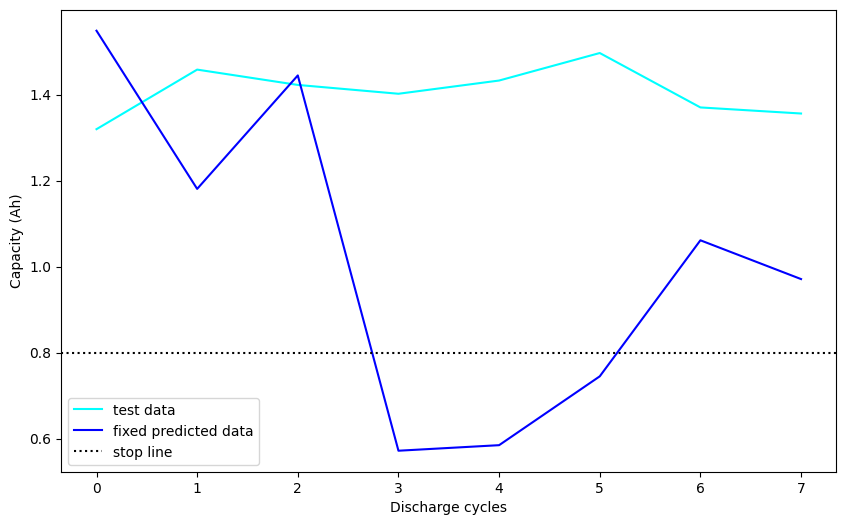

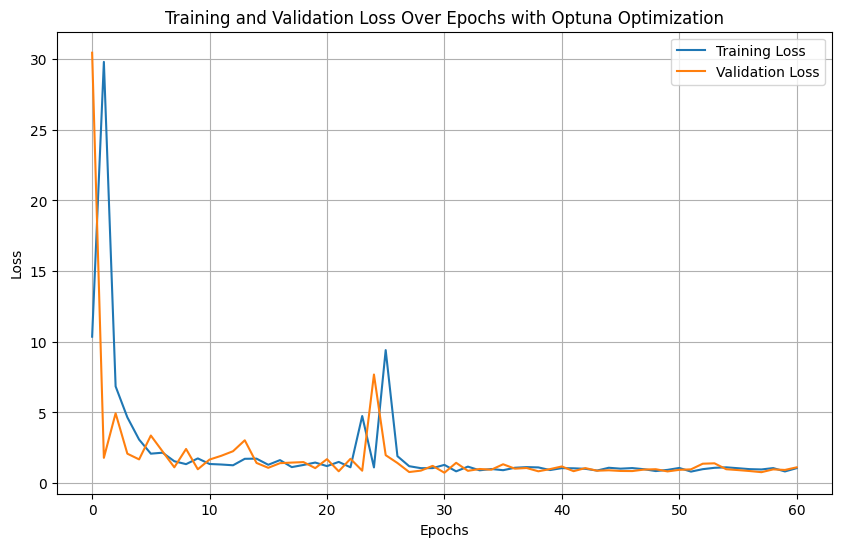

In [17]:
import optuna
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-2, log=True)
    accumulation_steps = trial.suggest_int('accumulation_steps', 1, 8)
    num_epochs = trial.suggest_int('epochs', 10, 100)
    # Load config
    config = yaml.safe_load(open('config/base.yaml', 'r'))
    config['train']['epochs'] = num_epochs
    config['train']['accumulation_steps'] = accumulation_steps
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TDSTF(config, device).to(device)
    train_loader = get_dataloader(train_batteries)
    valid_loader = get_dataloader([valid_battery])

    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * num_epochs
    warmup_steps = total_steps // 10
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    model, train_loss, valid_loss = train(
        model, config, train_loader, valid_loader=valid_loader, foldername='', data_path=''
    )
    return min(valid_loss)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  
print('Best hyperparameters: ', study.best_params)

# Train 
best_params = study.best_params
config = yaml.safe_load(open('config/base.yaml', 'r'))
config['train']['epochs'] = best_params['epochs']
config['train']['accumulation_steps'] = best_params['accumulation_steps']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modeloptuna = TDSTF(config, device).to(device)
train_loaderoptuna = get_dataloader(train_batteries)
valid_loaderoptuna = get_dataloader([valid_battery])
test_loaderoptuna = get_dataloader([test_battery])
optimizeroptuna = torch.optim.AdamW(modeloptuna.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
total_stepsoptuna = len(train_loaderoptuna) * best_params['epochs']
warmup_stepsoptuna = total_stepsoptuna // 10
scheduleroptuna = get_linear_schedule_with_warmup(optimizeroptuna, num_warmup_steps=warmup_stepsoptuna, num_training_steps=total_stepsoptuna)

modeloptuna, train_lossoptuna, valid_lossoptuna = train(
    modeloptuna, config, train_loaderoptuna, valid_loader=valid_loaderoptuna, foldername='', data_path=''
)
print('Test')
CRPSoptuna, MSEoptuna,lossoptuna,predictionsoptuna = evaluate(is_test=True, model=modeloptuna, data_loader=test_loaderoptuna, nsample=1000, foldername=foldername)

# Plot losses
plot_losses(train_lossoptuna, valid_lossoptuna, test_battery, title="Training and Validation Loss Over Epochs with Optuna Optimization")
# Save the final model
torch.save(modeloptuna.state_dict(), 'best_model.pth')


100%|██████████| 8/8 [00:00<00:00, 222.60it/s]
/tmp/ipykernel_1098020/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 1.0631359070539474
MSE is: 0.4545849561691284
CRPS is: 0.6162670042159808


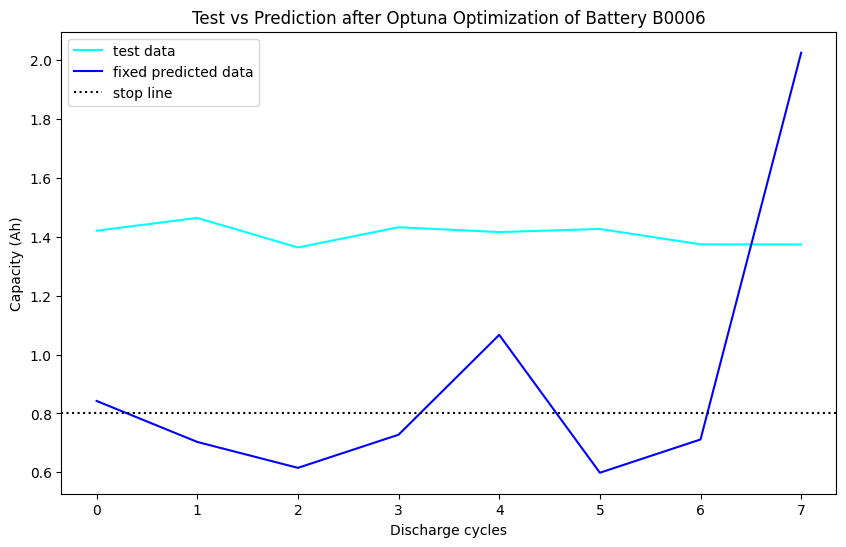

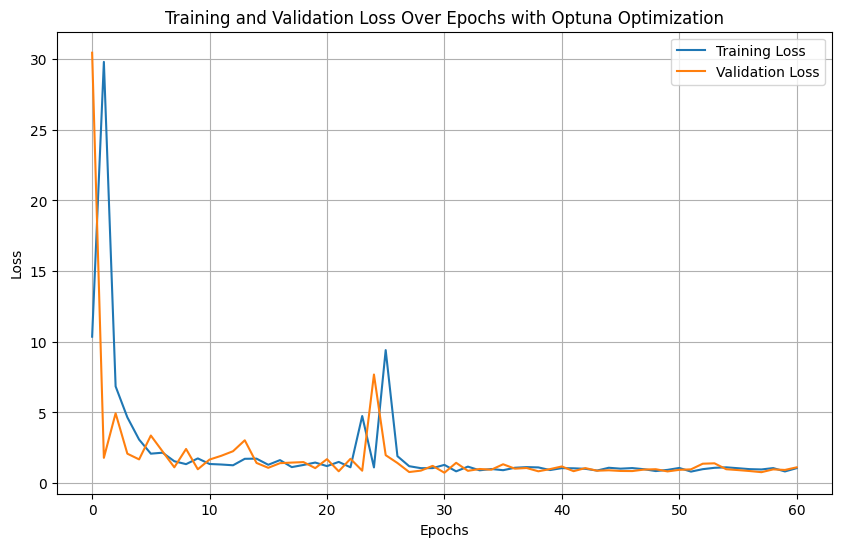

In [18]:
CRPSoptuna, MSEoptuna,lossoptuna,predictionsoptuna = evaluate(is_test=True, model=modeloptuna, data_loader=test_loaderoptuna, nsample=1000, foldername=foldername, title=f'Test vs Prediction after Optuna Optimization of Battery {test_battery}')

# Plot losses
plot_losses(train_lossoptuna, valid_lossoptuna, test_battery, title="Training and Validation Loss Over Epochs with Optuna Optimization")

In [19]:
best_params

{'lr': 8.781108599041439e-05,
 'weight_decay': 5.629558874613934e-07,
 'accumulation_steps': 7,
 'epochs': 80}

## **Ablation Studies**

In [20]:

ablation_results = {}

# Baseline model
print("Running baseline model...")
config = yaml.safe_load(open('config/base.yaml', 'r'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelbaseline = TDSTF(config, device).to(device)
train_loaderbaseline = get_dataloader(train_batteries)
valid_loaderbaseline = get_dataloader([valid_battery])
modelbaseline, train_lossbaseline, valid_lossbaseline = train(modelbaseline, config, train_loaderbaseline, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['Baseline'] = min(valid_loss)
config_ablation = config.copy()


# 1: Removing the Diffusion Embedding
print("Ablation 1: Removing the Diffusion Embedding...")
class ResNetNoDiffusion(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.size_x = config['size']
        self.channels = config['channels']
        num_features = 1  # Only the capacity feature
        lv =len(var)

        self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(1, self.channels).to(self.device)
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1)
        self.residual_layers = nn.ModuleList([
            TransformerLayer(config, self.device)
            for _ in range(config['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_x = samples_x.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()

        x_emb = self.emb_f(samples_x)
        y_emb = self.emb_f(samples_y)

        skip = []
        for layer in self.residual_layers:
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)

        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output

class TDSTFNoDiffusion(nn.Module):
    def __init__(self, config, device):
        super(TDSTFNoDiffusion, self).__init__()
        self.device = device
        self.config_diff = config['diffusion']
        self.res_model = ResNetNoDiffusion(self.config_diff, self.device)
        self.num_steps = self.config_diff['num_steps']
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)

    def process(self, batch):
        samples_x = batch[0].to(self.device).float()
        samples_y = batch[1].to(self.device).float().view(-1, 1)
        return samples_x, samples_y

    def forward(self, samples_x, samples_y):
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device)
        current_alpha = self.alpha_torch[t].unsqueeze(1)
        noise = torch.randn_like(samples_y).to(samples_y.device)
        mask_y = torch.ones_like(samples_y).squeeze()
        samples_y = ((current_alpha ** 0.5) * samples_y + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y.unsqueeze(1)
        predicted = self.res_model(samples_x, samples_y, t)
        residual = torch.where(mask_y.unsqueeze(1) == 1, noise - predicted, torch.zeros_like(predicted))
        loss = (residual ** 2).mean()
        return loss

    def forecast(self, samples_x, samples_y, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y = torch.randn_like(samples_y) * samples_y
            for t in range(self.num_steps - 1, -1, -1):
                mask_y = samples_y.squeeze()
                mask_y = mask_y.unsqueeze(-1)

                predicted = self.res_model(samples_x, samples_y, torch.tensor([t]).to(self.device))
                predicted = predicted.view(-1, samples_y.size(1), predicted.size(-1))

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

                if samples_y.shape != predicted.shape:
                    predicted = predicted.view(samples_y.shape)

                samples_y = coeff1 * (samples_y - coeff2 * predicted) * mask_y

                if t > 0:
                    noise = torch.randn_like(samples_y) * mask_y
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y += sigma * noise

            generation[i] = samples_y.detach()
        return generation.permute(1, 2, 0)

    def evaluate(self, samples_x, samples_y):
        with torch.no_grad():
            generation = self.forward(samples_x, samples_y)
        return generation, samples_y, samples_x

model_ablation1 = TDSTFNoDiffusion(config_ablation, device).to(device)
model_ablation1, train_loss1, valid_loss1 = train(model_ablation1, config_ablation, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['No Diffusion Embedding'] = min(valid_loss1)


# 2: Reducing the Number of Transformer Layers
print("Ablation 2: Reducing the Number of Transformer Layers to 1")
config_ablation2 = config.copy()
config_ablation2['diffusion']['layers'] = 1  # Reduce transformer layers to 1
model_ablation2 = TDSTF(config_ablation2, device).to(device)
model_ablation2, train_loss2, valid_loss2 = train(model_ablation2, config_ablation2, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['1 Transformer Layer'] = min(valid_loss2)


# 3: Increasing the Number of Transformer Layers
print("Ablation 3: Increasing the Number of Transformer Layers to 6")
config_ablation3 = config.copy()
config_ablation3['diffusion']['layers'] = 6  # Increase transformer layers to 6
model_ablation3 = TDSTF(config_ablation3, device).to(device)
model_ablation3, train_loss3, valid_loss3 = train(model_ablation3, config_ablation3, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['6 Transformer Layer'] = min(valid_loss3)


# 4: Influence of Attention Heads
print("Ablation 4: Reducing the Number of Attention Heads to 2...")
config_ablation4 = config.copy()
config_ablation4['diffusion']['num_heads'] = 2  # Reduce attention heads to 2
model_ablation4= TDSTF(config_ablation4, device).to(device)
model_ablation4, train_loss4, valid_loss4 = train(model_ablation4, config_ablation4, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['2 Attention Heads'] = min(valid_loss4)
print("Ablation 4: Reducing the Number of Attention Heads to 4...")
config_ablation44 = config.copy()
config_ablation44['diffusion']['num_heads'] = 4  # Reduce attention heads to 4
model_ablation44 = TDSTF(config_ablation44, device).to(device)
model_ablation44, train_loss44, valid_loss44 = train(model_ablation44, config_ablation44, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['4 Attention Heads'] = min(valid_loss44)
print("Ablation 4: Increasing the Number of Attention Heads to 16...")
config_ablation444 = config.copy()
config_ablation444['diffusion']['num_heads'] = 16  # Increase attention heads to 16
model_ablation444 = TDSTF(config_ablation444, device).to(device)
model_ablation444, train_loss444, valid_loss444 = train(model_ablation444, config_ablation444, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['16 Attention Heads'] = min(valid_loss444)

#5: Influence of Embedding Dimension
print("Ablation 5: Reducing the Embedding Dimension...")
config_ablation5 = config.copy()
config_ablation5['diffusion']['time_embedding_dim'] = 64  # Reduce embedding dimension
model_ablation5 = TDSTF(config_ablation5, device).to(device)
model_ablation5, train_loss5, valid_loss5 = train(model_ablation5, config_ablation5, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['Embedding Dimension 64'] = min(valid_loss5)

#6: Removing the Residual Connections
print("Ablation 6: Removing the Residual Connections...")
class TransformerLayerNoResidual(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.layer_norm = nn.LayerNorm(config['channels'])
        self.attn = nn.MultiheadAttention(embed_dim=config['channels'], num_heads=config['num_heads'])
        self.ffn = nn.Sequential(
            nn.Linear(config['channels'], config['channels'] * 4),
            nn.ReLU(),
            nn.Linear(config['channels'] * 4, config['channels']),
        )
        self.dropout = nn.Dropout(config.get('dropout', 0.1))
        self.device = device

    def forward(self, x, y):
        y = self.layer_norm(y)
        attn_output, attn_weights = self.attn(y, y, y)
        y = self.dropout(attn_output)
        y = self.dropout(self.ffn(y))
        return y, y  # No residual connection

class ResNetNoResidual(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.size_x = config['size']
        self.channels = config['channels']
        num_features = 1  # Only the capacity feature
        lv = len(var)

        self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(1, self.channels).to(self.device)
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1)
        self.residual_layers = nn.ModuleList([
            TransformerLayerNoResidual(config, self.device)
            for _ in range(config['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_x = samples_x.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()

        x_emb = self.emb_f(samples_x)
        y_emb = self.emb_f(samples_y)

        skip = []
        for layer in self.residual_layers:
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)

        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output

class TDSTFNoResidual(nn.Module):
    def __init__(self, config, device):
        super(TDSTFNoResidual, self).__init__()
        self.device = device
        self.config_diff = config['diffusion']
        self.res_model = ResNetNoResidual(self.config_diff, self.device)
        self.num_steps = self.config_diff['num_steps']
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)

    def process(self, batch):
        samples_x = batch[0].to(self.device).float()
        samples_y = batch[1].to(self.device).float().view(-1, 1)
        return samples_x, samples_y

    def forward(self, samples_x, samples_y):
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device)
        current_alpha = self.alpha_torch[t].unsqueeze(1)
        noise = torch.randn_like(samples_y).to(samples_y.device)
        mask_y = torch.ones_like(samples_y).squeeze()
        samples_y = ((current_alpha ** 0.5) * samples_y + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y.unsqueeze(1)
        predicted = self.res_model(samples_x, samples_y, t)
        residual = torch.where(mask_y.unsqueeze(1) == 1, noise - predicted, torch.zeros_like(predicted))
        loss = (residual ** 2).mean()
        return loss

    def forecast(self, samples_x, samples_y, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y = torch.randn_like(samples_y) * samples_y
            for t in range(self.num_steps - 1, -1, -1):
                mask_y = samples_y.squeeze()
                mask_y = mask_y.unsqueeze(-1)

                predicted = self.res_model(samples_x, samples_y, torch.tensor([t]).to(self.device))
                predicted = predicted.view(-1, samples_y.size(1), predicted.size(-1))

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

                if samples_y.shape != predicted.shape:
                    predicted = predicted.view(samples_y.shape)

                samples_y = coeff1 * (samples_y - coeff2 * predicted) * mask_y

                if t > 0:
                    noise = torch.randn_like(samples_y) * mask_y
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y += sigma * noise

            generation[i] = samples_y.detach()
        return generation.permute(1, 2, 0)

    def evaluate(self, samples_x, samples_y):
        with torch.no_grad():
            generation = self.forward(samples_x, samples_y)
        return generation, samples_y, samples_x

model_ablation6 = TDSTFNoResidual(config_ablation5, device).to(device)
model_ablation6, train_loss6, valid_loss6 = train(model_ablation6, config_ablation, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['No Residual Connections'] = min(valid_loss6)


Running baseline model...


Epoch 1/50:   7%|▋         | 1/15 [00:00<00:00, 37.29it/s, loss=18.4]

Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 37.09it/s, loss=19.8]


Validation Loss: 15.999299844106039
Model saved with best validation loss: 15.999299844106039


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 40.46it/s, loss=15.7]


Validation Loss: 6.126516342163086
Model saved with best validation loss: 6.126516342163086


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 41.58it/s, loss=4.57]


Validation Loss: 1.2334447962542374
Model saved with best validation loss: 1.2334447962542374


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.96it/s, loss=1.7] 


Validation Loss: 1.5777882138888042
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.97it/s, loss=1.59]


Validation Loss: 1.7261957724889119
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 43.09it/s, loss=1.37]


Validation Loss: 0.7709367809196314
Model saved with best validation loss: 0.7709367809196314


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.22it/s, loss=1.36]


Validation Loss: 1.071298748254776
No improvement count: 1


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 41.46it/s, loss=1.18]


Validation Loss: 1.0128933787345886
No improvement count: 2


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 41.94it/s, loss=1.04] 


Validation Loss: 1.1629636238018672
No improvement count: 3


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 39.41it/s, loss=1.05]


Validation Loss: 0.9643808156251907
No improvement count: 4


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 38.85it/s, loss=0.864]


Validation Loss: 1.090259313583374
No improvement count: 5


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 39.32it/s, loss=1.03] 


Validation Loss: 0.9036906560262045
No improvement count: 6


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 65.92it/s, loss=0.909]


Validation Loss: 1.0302704870700836
No improvement count: 7


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 67.48it/s, loss=1.12]


Validation Loss: 0.7477425535519918
Model saved with best validation loss: 0.7477425535519918


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 66.42it/s, loss=0.957]


Validation Loss: 0.9280173766116301
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 66.75it/s, loss=1.17]


Validation Loss: 1.164790228009224
No improvement count: 2


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 66.80it/s, loss=0.996]


Validation Loss: 1.9401989082495372
No improvement count: 3


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 66.52it/s, loss=1.96]


Validation Loss: 2.111755887667338
No improvement count: 4


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 66.43it/s, loss=1.39]


Validation Loss: 1.3756937384605408
No improvement count: 5


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 66.63it/s, loss=0.929]


Validation Loss: 0.9573359688123068
No improvement count: 6


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 65.83it/s, loss=1.07] 


Validation Loss: 1.00236114859581
No improvement count: 7


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 66.95it/s, loss=1.18]


Validation Loss: 1.1448936462402344
No improvement count: 8


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 66.95it/s, loss=1.49]


Validation Loss: 0.9511481821537018
No improvement count: 9


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 65.62it/s, loss=0.903]


Validation Loss: 0.9515212724606196
No improvement count: 10


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 65.92it/s, loss=0.958]


Validation Loss: 0.8833376715580622
No improvement count: 11


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 65.47it/s, loss=0.91] 


Validation Loss: 1.0752259641885757
No improvement count: 12


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 73.22it/s, loss=1.29]


Validation Loss: 0.7217645794153214
Model saved with best validation loss: 0.7217645794153214


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 68.27it/s, loss=1.12]


Validation Loss: 0.8401909172534943
No improvement count: 1


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 65.31it/s, loss=1.15] 


Validation Loss: 0.932411901652813
No improvement count: 2


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 43.32it/s, loss=0.953]


Validation Loss: 0.7253237317005793
No improvement count: 3


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.15it/s, loss=1.4] 


Validation Loss: 0.9101578493913015
No improvement count: 4


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 41.97it/s, loss=1.05]


Validation Loss: 1.0636969308058422
No improvement count: 5


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 40.11it/s, loss=1.1] 


Validation Loss: 1.114863634109497
No improvement count: 6


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 41.67it/s, loss=0.965]


Validation Loss: 1.2956390380859375
No improvement count: 7


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 41.80it/s, loss=1.05]


Validation Loss: 1.5160642862319946
No improvement count: 8


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 40.97it/s, loss=0.971]


Validation Loss: 0.8600232129295667
No improvement count: 9


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 42.78it/s, loss=1.34]


Validation Loss: 0.7556135853131613
No improvement count: 10


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 42.05it/s, loss=14]  


Validation Loss: 1.0194912912944953
No improvement count: 11


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 41.84it/s, loss=1.17] 


Validation Loss: 0.8298827360073725
No improvement count: 12


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 42.17it/s, loss=0.961]


Validation Loss: 0.8650033449133238
No improvement count: 13


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 40.64it/s, loss=2.43]


Validation Loss: 0.9721220831076304
No improvement count: 14


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 39.16it/s, loss=1.05]


Validation Loss: 1.0223063466449578
No improvement count: 15


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 41.47it/s, loss=1.48]


Validation Loss: 0.8303863306840261
No improvement count: 16


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.26it/s, loss=1.06]


Validation Loss: 0.832827498515447
No improvement count: 17


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 41.84it/s, loss=0.858]


Validation Loss: 0.9823463261127472
No improvement count: 18


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 42.71it/s, loss=0.949]


Validation Loss: 1.117689420779546
No improvement count: 19


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 42.10it/s, loss=0.939]


Validation Loss: 0.8360769748687744
No improvement count: 20


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 42.31it/s, loss=0.901]


Validation Loss: 0.8863191356261572
No improvement count: 21


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 41.97it/s, loss=1.06]


Validation Loss: 1.0146477719148
No improvement count: 22


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 41.69it/s, loss=1.13]


Validation Loss: 0.9434673289457957
No improvement count: 23
Ablation 1: Removing the Diffusion Embedding...


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 45.02it/s, loss=5.42]


Validation Loss: 49.80005137125651
Model saved with best validation loss: 49.80005137125651


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 44.51it/s, loss=44.5]


Validation Loss: 2.956420103708903
Model saved with best validation loss: 2.956420103708903


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 44.38it/s, loss=6.57]


Validation Loss: 6.656878312428792
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.18it/s, loss=5.02]


Validation Loss: 6.417340675989787
No improvement count: 2


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 42.61it/s, loss=2.68]


Validation Loss: 1.3335961898167927
Model saved with best validation loss: 1.3335961898167927


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 44.33it/s, loss=2.11]


Validation Loss: 1.385968029499054
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 45.61it/s, loss=1.56]


Validation Loss: 1.8603228330612183
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 45.08it/s, loss=1.3] 


Validation Loss: 1.0630341147383053
Model saved with best validation loss: 1.0630341147383053


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 44.50it/s, loss=1.06]


Validation Loss: 0.8450306355953217
Model saved with best validation loss: 0.8450306355953217


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 44.54it/s, loss=0.983]


Validation Loss: 1.0825550158818562
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 44.96it/s, loss=1.11]


Validation Loss: 0.8375985523064932
Model saved with best validation loss: 0.8375985523064932


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 44.76it/s, loss=1.08]


Validation Loss: 1.0781085292498271
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 45.69it/s, loss=0.888]


Validation Loss: 1.1795839965343475
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 44.30it/s, loss=1.05] 


Validation Loss: 0.6887802071869373
Model saved with best validation loss: 0.6887802071869373


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 45.21it/s, loss=1.1] 


Validation Loss: 1.3965662121772766
No improvement count: 1


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 45.15it/s, loss=0.995]


Validation Loss: 1.1417809178431828
No improvement count: 2


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 41.89it/s, loss=1.13] 


Validation Loss: 0.9097750882307688
No improvement count: 3


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 42.92it/s, loss=0.926]


Validation Loss: 1.5234563151995342
No improvement count: 4


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 44.98it/s, loss=1.04]


Validation Loss: 1.5970946749051411
No improvement count: 5


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 44.36it/s, loss=0.946]


Validation Loss: 1.0955872535705566
No improvement count: 6


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 45.25it/s, loss=0.853]


Validation Loss: 1.1026649872461955
No improvement count: 7


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 45.35it/s, loss=1.01] 


Validation Loss: 0.8727827817201614
No improvement count: 8


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 44.86it/s, loss=1.27]


Validation Loss: 0.7960065230727196
No improvement count: 9


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 44.68it/s, loss=1.04]


Validation Loss: 0.8094437516992912
No improvement count: 10


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 43.90it/s, loss=0.906]


Validation Loss: 0.9350902512669563
No improvement count: 11


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 44.55it/s, loss=0.915]


Validation Loss: 0.897583877046903
No improvement count: 12


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 44.83it/s, loss=0.979]


Validation Loss: 0.8662243783473969
No improvement count: 13


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 44.96it/s, loss=0.963]


Validation Loss: 0.7089434353013834
No improvement count: 14


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 45.32it/s, loss=0.908]


Validation Loss: 1.1305100619792938
No improvement count: 15


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 41.65it/s, loss=1.03] 


Validation Loss: 1.0899480879306793
No improvement count: 16


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 42.83it/s, loss=0.923]


Validation Loss: 0.6635279382268587
Model saved with best validation loss: 0.6635279382268587


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 44.87it/s, loss=1.78]


Validation Loss: 0.8591341053446134
No improvement count: 1


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 45.19it/s, loss=206] 


Validation Loss: 0.7474007333318392
No improvement count: 2


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 44.84it/s, loss=4.45]


Validation Loss: 0.8247520991911491
No improvement count: 3


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 44.88it/s, loss=0.964]


Validation Loss: 0.902491477628549
No improvement count: 4


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 45.45it/s, loss=6.31]


Validation Loss: 1.2962942719459534
No improvement count: 5


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 44.82it/s, loss=48.3]


Validation Loss: 0.945168266693751
No improvement count: 6


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 45.03it/s, loss=1.15] 


Validation Loss: 1.3170261184374492
No improvement count: 7


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 44.85it/s, loss=1.88]


Validation Loss: 1.1320273876190186
No improvement count: 8


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=0.946]


Validation Loss: 0.9719863831996918
No improvement count: 9


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 44.28it/s, loss=1.87]


Validation Loss: 0.8728842213749886
No improvement count: 10


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 45.04it/s, loss=1.06]


Validation Loss: 1.0406726598739624
No improvement count: 11


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 43.34it/s, loss=0.951]


Validation Loss: 0.8823211658746004
No improvement count: 12


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 41.77it/s, loss=1.06] 


Validation Loss: 0.9885003765424093
No improvement count: 13


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 44.09it/s, loss=1.28]


Validation Loss: 0.8738673627376556
No improvement count: 14


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 45.12it/s, loss=22.7] 


Validation Loss: 0.9566120107968649
No improvement count: 15


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 44.50it/s, loss=1.05] 


Validation Loss: 0.7487188577651978
No improvement count: 16


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 45.15it/s, loss=0.83] 


Validation Loss: 0.9895161092281342
No improvement count: 17


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 44.86it/s, loss=0.916]


Validation Loss: 0.964182918270429
No improvement count: 18


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 43.94it/s, loss=1.06]


Validation Loss: 0.9465112490579486
No improvement count: 19
Ablation 2: Reducing the Number of Transformer Layers to 1


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 81.67it/s, loss=1.84]


Validation Loss: 0.8515458007653555
Model saved with best validation loss: 0.8515458007653555


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 81.68it/s, loss=1.69] 


Validation Loss: 2.1030210653940835
No improvement count: 1


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 80.98it/s, loss=1.68]


Validation Loss: 1.231081485748291
No improvement count: 2


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 80.85it/s, loss=1.3] 


Validation Loss: 1.4250548084576924
No improvement count: 3


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 81.22it/s, loss=1.54]


Validation Loss: 1.1583604911963146
No improvement count: 4


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 81.30it/s, loss=1.31]


Validation Loss: 1.5204852720101674
No improvement count: 5


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 80.49it/s, loss=1.16]


Validation Loss: 0.975742926200231
No improvement count: 6


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 81.99it/s, loss=1.09]


Validation Loss: 1.3954548637072246
No improvement count: 7


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 82.51it/s, loss=1.3] 


Validation Loss: 1.1449229419231415
No improvement count: 8


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 75.87it/s, loss=1.43]


Validation Loss: 1.607817937930425
No improvement count: 9


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 76.10it/s, loss=1.37]


Validation Loss: 3.16628626982371
No improvement count: 10


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 77.59it/s, loss=1.41]


Validation Loss: 1.3637063180406888
No improvement count: 11


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 80.16it/s, loss=1.27]


Validation Loss: 1.3733082910378773
No improvement count: 12


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 80.66it/s, loss=1.11]


Validation Loss: 1.2570960422356923
No improvement count: 13


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 79.74it/s, loss=1.36]


Validation Loss: 0.999539648493131
No improvement count: 14


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 82.25it/s, loss=1.24]


Validation Loss: 1.3956105709075928
No improvement count: 15


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 82.12it/s, loss=1.24]


Validation Loss: 0.8502294222513834
Model saved with best validation loss: 0.8502294222513834


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 80.42it/s, loss=0.984]


Validation Loss: 1.3146597643693287
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 81.82it/s, loss=1.09]


Validation Loss: 1.3412346343199413
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 78.46it/s, loss=1.11]


Validation Loss: 0.9371176213026047
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 81.60it/s, loss=1.25]


Validation Loss: 0.8274485220511755
Model saved with best validation loss: 0.8274485220511755


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 82.04it/s, loss=1.07]


Validation Loss: 1.1935566663742065
No improvement count: 1


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 78.91it/s, loss=1.07]


Validation Loss: 0.9300629297892252
No improvement count: 2


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 81.75it/s, loss=0.988]


Validation Loss: 0.9128605822722117
No improvement count: 3


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 83.19it/s, loss=0.914]


Validation Loss: 0.7556292712688446
Model saved with best validation loss: 0.7556292712688446


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 79.99it/s, loss=0.988]


Validation Loss: 1.2490732967853546
No improvement count: 1


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 81.12it/s, loss=0.953]


Validation Loss: 0.9430317481358846
No improvement count: 2


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 81.86it/s, loss=0.934]


Validation Loss: 1.2646647195021312
No improvement count: 3


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 80.04it/s, loss=1.11]


Validation Loss: 1.6243477165699005
No improvement count: 4


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 81.51it/s, loss=0.876]


Validation Loss: 0.8505629325906435
No improvement count: 5


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 82.00it/s, loss=0.97] 


Validation Loss: 1.1258153915405273
No improvement count: 6


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 73.96it/s, loss=0.876]


Validation Loss: 0.8290456955631574
No improvement count: 7


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 76.61it/s, loss=0.991]


Validation Loss: 1.5777378678321838
No improvement count: 8


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 78.71it/s, loss=0.919]


Validation Loss: 0.8921976685523987
No improvement count: 9


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 80.48it/s, loss=1.08] 


Validation Loss: 0.917766198515892
No improvement count: 10


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 82.63it/s, loss=1.21] 


Validation Loss: 1.0886071026325226
No improvement count: 11


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 80.74it/s, loss=1.09]


Validation Loss: 0.7195881394048532
Model saved with best validation loss: 0.7195881394048532


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 80.38it/s, loss=1.08]


Validation Loss: 1.0598741670449574
No improvement count: 1


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 80.32it/s, loss=0.922]


Validation Loss: 0.9518879850705465
No improvement count: 2


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 82.35it/s, loss=1.01]


Validation Loss: 1.1056141555309296
No improvement count: 3


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 79.53it/s, loss=0.982]


Validation Loss: 1.1746409585078557
No improvement count: 4


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 81.71it/s, loss=1.15]


Validation Loss: 0.7833578586578369
No improvement count: 5


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 79.43it/s, loss=1.09]


Validation Loss: 0.8899948398272196
No improvement count: 6


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 73.84it/s, loss=0.819]


Validation Loss: 0.9264805267254511
No improvement count: 7


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 78.16it/s, loss=0.867]


Validation Loss: 0.9948502679665884
No improvement count: 8


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 80.50it/s, loss=1.06]


Validation Loss: 1.0762654443581898
No improvement count: 9


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 82.98it/s, loss=0.86] 


Validation Loss: 1.2751736442248027
No improvement count: 10


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 80.89it/s, loss=1.07]


Validation Loss: 1.0195031464099884
No improvement count: 11


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 81.87it/s, loss=1.1] 


Validation Loss: 0.7815765514969826
No improvement count: 12


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 81.25it/s, loss=0.903]


Validation Loss: 0.9450121819972992
No improvement count: 13
Ablation 3: Increasing the Number of Transformer Layers to 6


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 24.70it/s, loss=24.5]


Validation Loss: 131.32963053385416
Model saved with best validation loss: 131.32963053385416


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 23.22it/s, loss=43.7]


Validation Loss: 22.849692344665527
Model saved with best validation loss: 22.849692344665527


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s, loss=10]  


Validation Loss: 5.085900545120239
Model saved with best validation loss: 5.085900545120239


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 25.25it/s, loss=4.89]


Validation Loss: 6.803590615590413
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 24.88it/s, loss=4.47]


Validation Loss: 5.8925420840581255
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 24.03it/s, loss=4.26]


Validation Loss: 4.280675570170085
Model saved with best validation loss: 4.280675570170085


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 25.31it/s, loss=3.7] 


Validation Loss: 2.423583130041758
Model saved with best validation loss: 2.423583130041758


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 25.38it/s, loss=2.04]


Validation Loss: 1.0941681439677875
Model saved with best validation loss: 1.0941681439677875


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 24.20it/s, loss=1.39]


Validation Loss: 2.511081114411354
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 23.72it/s, loss=1.76]


Validation Loss: 1.5822964310646057
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 24.08it/s, loss=1.97]


Validation Loss: 0.867200901110967
Model saved with best validation loss: 0.867200901110967


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 24.74it/s, loss=1.22]


Validation Loss: 1.273745556672414
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 24.20it/s, loss=1.04]


Validation Loss: 1.1077800889809926
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 23.63it/s, loss=1.35]


Validation Loss: 2.3135118881861367
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 23.91it/s, loss=1.44]


Validation Loss: 1.849790910879771
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 25.20it/s, loss=1.41]


Validation Loss: 0.8246968363722166
Model saved with best validation loss: 0.8246968363722166


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 23.74it/s, loss=1.04]


Validation Loss: 1.731038769086202
No improvement count: 1


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 24.58it/s, loss=1.22]


Validation Loss: 0.5542747676372528
Model saved with best validation loss: 0.5542747676372528


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 23.97it/s, loss=0.976]


Validation Loss: 0.9836703439553579
No improvement count: 1


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 24.44it/s, loss=1.1] 


Validation Loss: 1.0417927900950115
No improvement count: 2


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 24.11it/s, loss=50.8]


Validation Loss: 5.482398629188538
No improvement count: 3


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 25.02it/s, loss=8.43]


Validation Loss: 5.917708237965901
No improvement count: 4


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 24.76it/s, loss=3.65]


Validation Loss: 0.9176882902781168
No improvement count: 5


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 24.27it/s, loss=9.01]


Validation Loss: 1.0321494142214458
No improvement count: 6


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 23.28it/s, loss=1.6] 


Validation Loss: 1.0579076906045277
No improvement count: 7


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 24.15it/s, loss=1.19]


Validation Loss: 1.1712384323279064
No improvement count: 8


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 25.17it/s, loss=1.08]


Validation Loss: 0.8470831414063772
No improvement count: 9


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 24.05it/s, loss=1.18]


Validation Loss: 0.9881536364555359
No improvement count: 10


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 23.98it/s, loss=4.85]


Validation Loss: 0.8797929187615713
No improvement count: 11


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 25.48it/s, loss=2.77]


Validation Loss: 0.8199961011608442
No improvement count: 12


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 24.20it/s, loss=1.5] 


Validation Loss: 0.9748347898324331
No improvement count: 13


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 23.97it/s, loss=74.9]


Validation Loss: 1.2131354709466298
No improvement count: 14


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 23.53it/s, loss=1.08]


Validation Loss: 2.339658369620641
No improvement count: 15


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 23.73it/s, loss=1.68] 


Validation Loss: 0.8452737232049307
No improvement count: 16


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 24.54it/s, loss=1.01] 


Validation Loss: 1.01038758456707
No improvement count: 17


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 23.79it/s, loss=1.13]


Validation Loss: 1.1946931195755799
No improvement count: 18


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 23.68it/s, loss=2.03]


Validation Loss: 0.991186519463857
No improvement count: 19


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 25.75it/s, loss=69.7]


Validation Loss: 1.1241066543540608
No improvement count: 20


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 23.86it/s, loss=1.14]


Validation Loss: 1.5174895723660786
No improvement count: 21


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 22.84it/s, loss=237]   


Validation Loss: 0.9746082723140717
No improvement count: 22


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 24.00it/s, loss=0.97] 


Validation Loss: 0.8348656142673766
No improvement count: 23


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 25.18it/s, loss=1.02]


Validation Loss: 0.9610246631006399
No improvement count: 24


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 24.25it/s, loss=1.09]


Validation Loss: 0.8892200787862142
No improvement count: 25


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 25.41it/s, loss=0.906]


Validation Loss: 0.9629918734232584
No improvement count: 26


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 24.09it/s, loss=1.12] 


Validation Loss: 1.0934824844201405
No improvement count: 27


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 25.07it/s, loss=0.998]


Validation Loss: 1.087803779790799
No improvement count: 28


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 23.88it/s, loss=2.04]


Validation Loss: 0.8207090897485614
No improvement count: 29


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 23.46it/s, loss=32.5] 


Validation Loss: 0.6829293109476566
No improvement count: 30
Early stopping triggered.
Ablation 4: Reducing the Number of Attention Heads to 2...


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 24.14it/s, loss=9.57]


Validation Loss: 177.51290893554688
Model saved with best validation loss: 177.51290893554688


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 24.93it/s, loss=72.5]


Validation Loss: 13.26450284322103
Model saved with best validation loss: 13.26450284322103


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 23.86it/s, loss=15.4]


Validation Loss: 1.5852534174919128
Model saved with best validation loss: 1.5852534174919128


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 25.60it/s, loss=5.46]


Validation Loss: 1.657422383626302
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 25.49it/s, loss=5.38]


Validation Loss: 2.113986909389496
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 24.17it/s, loss=3.49]


Validation Loss: 2.877524495124817
No improvement count: 3


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 23.81it/s, loss=2.49]


Validation Loss: 2.5186017950375876
No improvement count: 4


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 24.05it/s, loss=2.57]


Validation Loss: 5.2537868817647295
No improvement count: 5


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 24.28it/s, loss=3.07]


Validation Loss: 2.289732277393341
No improvement count: 6


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 24.92it/s, loss=3.52]


Validation Loss: 1.034501999616623
Model saved with best validation loss: 1.034501999616623


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 24.77it/s, loss=1.98]


Validation Loss: 3.0244526068369546
No improvement count: 1


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 24.54it/s, loss=2.34]


Validation Loss: 1.0171144555012386
Model saved with best validation loss: 1.0171144555012386


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 25.32it/s, loss=1.34]


Validation Loss: 1.3294603029886882
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 24.95it/s, loss=1.3] 


Validation Loss: 4.709508101145427
No improvement count: 2


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 23.28it/s, loss=2.63]


Validation Loss: 1.7558403710524242
No improvement count: 3


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 23.17it/s, loss=1.6] 


Validation Loss: 2.5105229169130325
No improvement count: 4


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 25.46it/s, loss=9.96]


Validation Loss: 648.2870686848959
No improvement count: 5


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 24.26it/s, loss=217]


Validation Loss: 106.29014460245769
No improvement count: 6


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 24.73it/s, loss=40.3]


Validation Loss: 2205.848347981771
No improvement count: 7


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 25.22it/s, loss=152]


Validation Loss: 1.4204144676526387
No improvement count: 8


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 24.05it/s, loss=8.18]


Validation Loss: 0.7412493576606115
Model saved with best validation loss: 0.7412493576606115


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 24.57it/s, loss=1.1] 


Validation Loss: 0.8440739413102468
No improvement count: 1


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 23.29it/s, loss=47.9]


Validation Loss: 0.9881902386744817
No improvement count: 2


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 24.35it/s, loss=35.5]


Validation Loss: 0.8265208726127943
No improvement count: 3


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 25.26it/s, loss=2.35] 


Validation Loss: 1.2782433728377025
No improvement count: 4


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 25.17it/s, loss=1.76]


Validation Loss: 0.8939834882815679
No improvement count: 5


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 24.71it/s, loss=1.02]


Validation Loss: 0.9125957489013672
No improvement count: 6


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 24.78it/s, loss=0.961]


Validation Loss: 1.0449782609939575
No improvement count: 7


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 25.25it/s, loss=1.24]


Validation Loss: 0.7700746804475784
No improvement count: 8


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 24.00it/s, loss=37.3]


Validation Loss: 0.7131886255616943
Model saved with best validation loss: 0.7131886255616943


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 23.56it/s, loss=9.03]


Validation Loss: 1.098120520512263
No improvement count: 1


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s, loss=1.11]


Validation Loss: 0.7206376480559508
No improvement count: 2


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 25.05it/s, loss=1.04] 


Validation Loss: 1.2108407119909923
No improvement count: 3


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 25.35it/s, loss=0.953]


Validation Loss: 1.0657822787761688
No improvement count: 4


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 24.69it/s, loss=5.72]


Validation Loss: 0.9900967180728912
No improvement count: 5


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 25.38it/s, loss=1.1] 


Validation Loss: 0.9349372933308283
No improvement count: 6


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 25.41it/s, loss=0.855]


Validation Loss: 0.8840194543202718
No improvement count: 7


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 22.20it/s, loss=1.04]


Validation Loss: 1.0289786892632644
No improvement count: 8


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 23.89it/s, loss=3.43]


Validation Loss: 1.1610607008139293
No improvement count: 9


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 23.94it/s, loss=1.04]


Validation Loss: 0.7837782998879751
No improvement count: 10


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 24.03it/s, loss=1.07]


Validation Loss: 1.0576373934745789
No improvement count: 11


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 23.85it/s, loss=1.03]


Validation Loss: 0.8497929573059082
No improvement count: 12


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 25.08it/s, loss=42.1]


Validation Loss: 0.8239937772353491
No improvement count: 13


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 23.93it/s, loss=1]    


Validation Loss: 1.1435937682787578
No improvement count: 14


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s, loss=0.977]


Validation Loss: 1.0933884779612224
No improvement count: 15


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s, loss=1.01] 


Validation Loss: 1.349073698123296
No improvement count: 16


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 25.74it/s, loss=1.09] 


Validation Loss: 1.1391293009122212
No improvement count: 17


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 23.87it/s, loss=2.7]  


Validation Loss: 1.0718976259231567
No improvement count: 18


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 25.15it/s, loss=1.23]


Validation Loss: 0.6319334755341212
Model saved with best validation loss: 0.6319334755341212


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 24.52it/s, loss=1.1] 


Validation Loss: 1.112680251399676
No improvement count: 1
Ablation 4: Reducing the Number of Attention Heads to 4...


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 24.28it/s, loss=5.1] 


Validation Loss: 110.19346491495769
Model saved with best validation loss: 110.19346491495769


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 24.30it/s, loss=37.9]


Validation Loss: 16.757150808970135
Model saved with best validation loss: 16.757150808970135


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 24.04it/s, loss=9.47]


Validation Loss: 7.266411463419597
Model saved with best validation loss: 7.266411463419597


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 23.79it/s, loss=6.31]


Validation Loss: 2.587984303633372
Model saved with best validation loss: 2.587984303633372


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 24.98it/s, loss=2.96]


Validation Loss: 1.1484386722246807
Model saved with best validation loss: 1.1484386722246807


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 23.71it/s, loss=2.06]


Validation Loss: 2.1470693051815033
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 25.09it/s, loss=1.53]


Validation Loss: 1.944138805071513
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 23.21it/s, loss=1.6] 


Validation Loss: 1.3796118299166362
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 23.89it/s, loss=1.21]


Validation Loss: 1.2621001203854878
No improvement count: 4


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 25.43it/s, loss=1.82]


Validation Loss: 1.5859687328338623
No improvement count: 5


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 22.73it/s, loss=1.28]


Validation Loss: 0.9347999393939972
Model saved with best validation loss: 0.9347999393939972


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 23.51it/s, loss=1.47]


Validation Loss: 1.2150035202503204
No improvement count: 1


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 25.57it/s, loss=1.1] 


Validation Loss: 0.9913029819726944
No improvement count: 2


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 23.20it/s, loss=0.944]


Validation Loss: 1.7291200558344524
No improvement count: 3


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 25.26it/s, loss=1.48]


Validation Loss: 1.2884169220924377
No improvement count: 4


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 24.25it/s, loss=1.25]


Validation Loss: 0.8207847873369852
Model saved with best validation loss: 0.8207847873369852


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 24.52it/s, loss=1.67]


Validation Loss: 0.7968751837809881
Model saved with best validation loss: 0.7968751837809881


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 24.63it/s, loss=1.31]


Validation Loss: 2.585230747858683
No improvement count: 1


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 23.18it/s, loss=1.29]


Validation Loss: 0.8143225138386091
No improvement count: 2


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 23.30it/s, loss=1.01] 


Validation Loss: 1.4659306009610493
No improvement count: 3


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 23.16it/s, loss=1.25]


Validation Loss: 0.9556907266378403
No improvement count: 4


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 23.47it/s, loss=1.8] 


Validation Loss: 1.5445200204849243
No improvement count: 5


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 23.49it/s, loss=1.53]


Validation Loss: 0.8721383810043335
No improvement count: 6


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 23.37it/s, loss=3.8] 


Validation Loss: 0.6803704276680946
Model saved with best validation loss: 0.6803704276680946


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 23.14it/s, loss=147] 


Validation Loss: 0.738007765263319
No improvement count: 1


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 22.93it/s, loss=1.09]


Validation Loss: 0.7966639449199041
No improvement count: 2


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 25.44it/s, loss=1.75]


Validation Loss: 0.84467946489652
No improvement count: 3


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 23.92it/s, loss=1.23]


Validation Loss: 0.8687634238352379
No improvement count: 4


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 23.17it/s, loss=753]    


Validation Loss: 1.0562826494375865
No improvement count: 5


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 23.23it/s, loss=0.995]


Validation Loss: 0.993608295917511
No improvement count: 6


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 23.35it/s, loss=1.19]


Validation Loss: 0.7057929486036301
No improvement count: 7


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 23.32it/s, loss=370]  


Validation Loss: 0.7891474937399229
No improvement count: 8


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 23.03it/s, loss=0.982]


Validation Loss: 1.275261362393697
No improvement count: 9


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 23.66it/s, loss=14.3]


Validation Loss: 0.8571256957948208
No improvement count: 10


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 23.20it/s, loss=148]


Validation Loss: 1.311198095480601
No improvement count: 11


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 23.13it/s, loss=1.06] 


Validation Loss: 0.9151535928249359
No improvement count: 12


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 23.15it/s, loss=4.44]


Validation Loss: 1.175117274125417
No improvement count: 13


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 23.16it/s, loss=3.85]


Validation Loss: 1.1516420443852742
No improvement count: 14


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 23.36it/s, loss=1.01] 


Validation Loss: 0.9976202249526978
No improvement count: 15


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 23.30it/s, loss=1.11]


Validation Loss: 1.43521186709404
No improvement count: 16


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 23.19it/s, loss=2.97] 


Validation Loss: 1.0701981981595357
No improvement count: 17


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 25.57it/s, loss=0.967]


Validation Loss: 0.7313403363029162
No improvement count: 18


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 23.43it/s, loss=0.873]


Validation Loss: 0.9381040185689926
No improvement count: 19


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 23.42it/s, loss=0.898]


Validation Loss: 0.7452777524789175
No improvement count: 20


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 23.09it/s, loss=1.06] 


Validation Loss: 1.165348194539547
No improvement count: 21


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 23.95it/s, loss=1.11]


Validation Loss: 1.1136495172977448
No improvement count: 22


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 22.99it/s, loss=1]    


Validation Loss: 1.207915296157201
No improvement count: 23


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 23.29it/s, loss=1.06]


Validation Loss: 1.0163876861333847
No improvement count: 24


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 24.50it/s, loss=1.11]


Validation Loss: 1.1587247252464294
No improvement count: 25


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 25.35it/s, loss=0.973]


Validation Loss: 1.0383200297753017
No improvement count: 26
Ablation 4: Increasing the Number of Attention Heads to 16...


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 24.20it/s, loss=5.14]


Validation Loss: 66.89193407694499
Model saved with best validation loss: 66.89193407694499


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 23.09it/s, loss=30.9]


Validation Loss: 13.123791535695394
Model saved with best validation loss: 13.123791535695394


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 23.28it/s, loss=8.43]


Validation Loss: 16.614324887593586
No improvement count: 1


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 22.95it/s, loss=11.8]


Validation Loss: 15.554486274719238
No improvement count: 2


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 23.39it/s, loss=5.96]


Validation Loss: 1.0963436961174011
Model saved with best validation loss: 1.0963436961174011


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 23.55it/s, loss=1.44]


Validation Loss: 1.3214865724245708
No improvement count: 1


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 23.91it/s, loss=1.61]


Validation Loss: 1.955646574497223
No improvement count: 2


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 23.24it/s, loss=1.55]


Validation Loss: 1.2091784899433453
No improvement count: 3


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 23.17it/s, loss=1.52]


Validation Loss: 1.0228745838006337
Model saved with best validation loss: 1.0228745838006337


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 23.72it/s, loss=1.15]


Validation Loss: 1.5113762120405834
No improvement count: 1


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 23.25it/s, loss=1.18]


Validation Loss: 0.8824282094525794
Model saved with best validation loss: 0.8824282094525794


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 23.28it/s, loss=1.32]


Validation Loss: 0.833066787570715
Model saved with best validation loss: 0.833066787570715


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 23.12it/s, loss=0.996]


Validation Loss: 0.9930561768511931
No improvement count: 1


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 24.77it/s, loss=1.05] 


Validation Loss: 0.8622696499029795
No improvement count: 2


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 23.20it/s, loss=1.1]  


Validation Loss: 0.7809697985649109
Model saved with best validation loss: 0.7809697985649109


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 23.30it/s, loss=0.993]


Validation Loss: 1.200415273507436
No improvement count: 1


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 23.12it/s, loss=1.19]


Validation Loss: 1.0127686460812886
No improvement count: 2


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 23.27it/s, loss=1.04]


Validation Loss: 0.8399013628562292
No improvement count: 3


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 23.29it/s, loss=1.1]  


Validation Loss: 1.2125708262125652
No improvement count: 4


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 23.12it/s, loss=0.989]


Validation Loss: 0.8632695178190867
No improvement count: 5


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 22.60it/s, loss=1.1] 


Validation Loss: 1.1070594290892284
No improvement count: 6


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 22.87it/s, loss=0.919]


Validation Loss: 0.8481516602138678
No improvement count: 7


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 22.91it/s, loss=0.851]


Validation Loss: 0.9641606609026591
No improvement count: 8


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 23.10it/s, loss=0.927]


Validation Loss: 0.7619207253058752
Model saved with best validation loss: 0.7619207253058752


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 23.15it/s, loss=1.05] 


Validation Loss: 1.247040460507075
No improvement count: 1


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 23.34it/s, loss=0.972]


Validation Loss: 0.9199383159478506
No improvement count: 2


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 22.97it/s, loss=1.12]


Validation Loss: 0.7944991191228231
No improvement count: 3


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 22.80it/s, loss=1.02]


Validation Loss: 1.16146253546079
No improvement count: 4


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 24.16it/s, loss=1.09]


Validation Loss: 0.8160040254394213
No improvement count: 5


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 23.06it/s, loss=0.912]


Validation Loss: 0.6700043380260468
Model saved with best validation loss: 0.6700043380260468


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 23.18it/s, loss=1.05]


Validation Loss: 0.8943799833456675
No improvement count: 1


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 23.06it/s, loss=0.879]


Validation Loss: 0.897961805264155
No improvement count: 2


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 23.04it/s, loss=1.03] 


Validation Loss: 1.265439788500468
No improvement count: 3


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 22.88it/s, loss=0.955]


Validation Loss: 1.2220384279886882
No improvement count: 4


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 23.13it/s, loss=1.07]


Validation Loss: 1.2616593937079112
No improvement count: 5


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s, loss=1.06]


Validation Loss: 0.7873321572939554
No improvement count: 6


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 23.02it/s, loss=1.04] 


Validation Loss: 0.8939070502916971
No improvement count: 7


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 23.24it/s, loss=1.11]


Validation Loss: 0.922913392384847
No improvement count: 8


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 23.18it/s, loss=0.959]


Validation Loss: 0.8479865243037542
No improvement count: 9


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 23.11it/s, loss=1.02] 


Validation Loss: 0.8925669938325882
No improvement count: 10


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 23.04it/s, loss=1.18]


Validation Loss: 1.0092280209064484
No improvement count: 11


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 23.16it/s, loss=1.11]


Validation Loss: 0.7984545429547628
No improvement count: 12


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 22.82it/s, loss=1]    


Validation Loss: 0.7948858141899109
No improvement count: 13


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 23.66it/s, loss=0.818]


Validation Loss: 0.8614808817704519
No improvement count: 14


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 23.31it/s, loss=1.29]


Validation Loss: 0.892918179432551
No improvement count: 15


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 23.21it/s, loss=3.6] 


Validation Loss: 0.6409457474946976
Model saved with best validation loss: 0.6409457474946976


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 22.91it/s, loss=205]


Validation Loss: 1.374058872461319
No improvement count: 1


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 23.29it/s, loss=156]


Validation Loss: 1.2131904860337575
No improvement count: 2


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 23.22it/s, loss=1.05]


Validation Loss: 0.7982012331485748
No improvement count: 3


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 23.05it/s, loss=221]   


Validation Loss: 1.0012323359648387
No improvement count: 4
Ablation 5: Reducing the Embedding Dimension...


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 24.05it/s, loss=4.53]


Validation Loss: 197.71480305989584
Model saved with best validation loss: 197.71480305989584


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 23.79it/s, loss=89.3]


Validation Loss: 5.968321839968364
Model saved with best validation loss: 5.968321839968364


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 23.27it/s, loss=7.5] 


Validation Loss: 1.4049222270647685
Model saved with best validation loss: 1.4049222270647685


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 23.11it/s, loss=3.05]


Validation Loss: 2.2451811830202737
No improvement count: 1


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 23.19it/s, loss=2.44]


Validation Loss: 3.229358027378718
No improvement count: 2


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 23.28it/s, loss=1.73]


Validation Loss: 1.4547907908757527
No improvement count: 3


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 23.16it/s, loss=1.44]


Validation Loss: 0.9956294099489847
Model saved with best validation loss: 0.9956294099489847


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 23.22it/s, loss=1.28]


Validation Loss: 0.6931972702344259
Model saved with best validation loss: 0.6931972702344259


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 24.03it/s, loss=1.17] 


Validation Loss: 0.8980708320935568
No improvement count: 1


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 23.17it/s, loss=1.26]


Validation Loss: 1.4854312737782795
No improvement count: 2


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 23.09it/s, loss=1.26]


Validation Loss: 1.3417715926965077
No improvement count: 3


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 23.05it/s, loss=2.75]


Validation Loss: 2.0476697087287903
No improvement count: 4


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 22.80it/s, loss=1.58]


Validation Loss: 1.442654475569725
No improvement count: 5


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 22.99it/s, loss=1.56]


Validation Loss: 1.231194148461024
No improvement count: 6


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 22.99it/s, loss=1.01] 


Validation Loss: 0.7853164374828339
No improvement count: 7


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 23.47it/s, loss=1.11] 


Validation Loss: 0.8444583813349406
No improvement count: 8


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 23.16it/s, loss=1.12]


Validation Loss: 1.2884886463483174
No improvement count: 9


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 23.20it/s, loss=0.966]


Validation Loss: 2.029211719830831
No improvement count: 10


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 22.89it/s, loss=1.08]


Validation Loss: 1.9690143863360088
No improvement count: 11


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 23.37it/s, loss=1.35]


Validation Loss: 0.776805986960729
No improvement count: 12


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 23.02it/s, loss=2.39]


Validation Loss: 6.783247152964274
No improvement count: 13


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 23.23it/s, loss=4.22]


Validation Loss: 0.9353130534291267
No improvement count: 14


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 23.49it/s, loss=2.37]


Validation Loss: 0.9139634395639101
No improvement count: 15


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 23.07it/s, loss=1.09] 


Validation Loss: 1.221018671989441
No improvement count: 16


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 22.91it/s, loss=1.21] 


Validation Loss: 1.168110986550649
No improvement count: 17


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 22.95it/s, loss=1.19]


Validation Loss: 0.9369004393617312
No improvement count: 18


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 23.44it/s, loss=5.7] 


Validation Loss: 0.9016208185251647
No improvement count: 19


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 23.21it/s, loss=15.3]


Validation Loss: 0.9920464555422465
No improvement count: 20


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 23.13it/s, loss=3.04]


Validation Loss: 1.0399169822533925
No improvement count: 21


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 22.87it/s, loss=2.01] 


Validation Loss: 0.9334942996501923
No improvement count: 22


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 23.56it/s, loss=0.935]


Validation Loss: 1.0500447551409404
No improvement count: 23


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 23.15it/s, loss=26.8]


Validation Loss: 0.8889040350914001
No improvement count: 24


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 23.19it/s, loss=0.963]


Validation Loss: 1.0380984842777252
No improvement count: 25


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 23.01it/s, loss=0.903]


Validation Loss: 1.1788791318734486
No improvement count: 26


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 23.22it/s, loss=0.99] 


Validation Loss: 1.0002222110827763
No improvement count: 27


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 23.02it/s, loss=1.05]


Validation Loss: 1.22142427166303
No improvement count: 28


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 22.95it/s, loss=0.992]


Validation Loss: 1.118557333946228
No improvement count: 29


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 23.07it/s, loss=1.16]


Validation Loss: 1.0033787960807483
No improvement count: 30
Early stopping triggered.
Ablation 6: Removing the Residual Connections...


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 23.29it/s, loss=0.901]


Validation Loss: 3.3839310109615326
Model saved with best validation loss: 3.3839310109615326


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 23.71it/s, loss=1.89]


Validation Loss: 1.221956769625346
Model saved with best validation loss: 1.221956769625346


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 23.65it/s, loss=1.42]


Validation Loss: 1.0887673795223236
Model saved with best validation loss: 1.0887673795223236


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 23.48it/s, loss=1.26]


Validation Loss: 0.7302579581737518
Model saved with best validation loss: 0.7302579581737518


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 23.41it/s, loss=1.44]


Validation Loss: 1.1940673626959324
No improvement count: 1


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 23.57it/s, loss=1.28]


Validation Loss: 1.8130446126063664
No improvement count: 2


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 23.08it/s, loss=1.09]


Validation Loss: 3.3681742747624717
No improvement count: 3


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 23.42it/s, loss=2.48]


Validation Loss: 1.4889264504114788
No improvement count: 4


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 23.42it/s, loss=2.16]


Validation Loss: 5.226157744725545
No improvement count: 5


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 24.32it/s, loss=10.3]


Validation Loss: 7.632556756337483
No improvement count: 6


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 23.56it/s, loss=4.94]


Validation Loss: 5.147019426027934
No improvement count: 7


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 23.50it/s, loss=3.46]


Validation Loss: 1.9543680846691132
No improvement count: 8


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 23.58it/s, loss=2.72]


Validation Loss: 1.350024476647377
No improvement count: 9


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 23.99it/s, loss=3.52]


Validation Loss: 2.515256722768148
No improvement count: 10


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 23.35it/s, loss=3.81]


Validation Loss: 50.00116157531738
No improvement count: 11


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 23.61it/s, loss=3.49e+3]


Validation Loss: 10.371655702590942
No improvement count: 12


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 23.68it/s, loss=9.53]


Validation Loss: 2.5851733684539795
No improvement count: 13


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 23.30it/s, loss=50.7]


Validation Loss: 3.9201958974202475
No improvement count: 14


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 23.84it/s, loss=2.59]


Validation Loss: 0.8028844992319742
No improvement count: 15


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 23.53it/s, loss=1.14]


Validation Loss: 1.1594406465689342
No improvement count: 16


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 23.90it/s, loss=0.984]


Validation Loss: 0.6413603574037552
Model saved with best validation loss: 0.6413603574037552


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 23.32it/s, loss=1.14]


Validation Loss: 0.7535946120818456
No improvement count: 1


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 23.50it/s, loss=1.12]


Validation Loss: 0.8353579888741175
No improvement count: 2


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 23.56it/s, loss=0.902]


Validation Loss: 0.8947713747620583
No improvement count: 3


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 23.21it/s, loss=0.897]


Validation Loss: 0.7720884631077448
No improvement count: 4


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 24.00it/s, loss=1.01] 


Validation Loss: 0.7653739005327225
No improvement count: 5


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 23.67it/s, loss=0.959]


Validation Loss: 1.0276840925216675
No improvement count: 6


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 23.56it/s, loss=1.01]


Validation Loss: 1.0848554770151775
No improvement count: 7


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 23.08it/s, loss=1.12]


Validation Loss: 0.9740551312764486
No improvement count: 8


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 23.75it/s, loss=1.02] 


Validation Loss: 0.7572110630571842
No improvement count: 9


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 24.08it/s, loss=0.853]


Validation Loss: 1.0596050322055817
No improvement count: 10


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 24.09it/s, loss=0.994]


Validation Loss: 0.9392630755901337
No improvement count: 11


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 23.61it/s, loss=1.18]


Validation Loss: 1.0838353633880615
No improvement count: 12


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 23.49it/s, loss=0.888]


Validation Loss: 0.896902988354365
No improvement count: 13


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s, loss=1.07]


Validation Loss: 1.0826996734831482
No improvement count: 14


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 23.67it/s, loss=0.915]


Validation Loss: 1.241678923368454
No improvement count: 15


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 23.24it/s, loss=0.988]


Validation Loss: 1.1038915713628132
No improvement count: 16


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 23.42it/s, loss=1.28]


Validation Loss: 1.0547838807106018
No improvement count: 17


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 23.51it/s, loss=1.06]


Validation Loss: 1.2241676946481068
No improvement count: 18


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 23.62it/s, loss=0.848]


Validation Loss: 0.627332824592789
Model saved with best validation loss: 0.627332824592789


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 23.83it/s, loss=0.923]


Validation Loss: 1.0510798494021099
No improvement count: 1


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 23.68it/s, loss=0.98] 


Validation Loss: 1.3241926829020183
No improvement count: 2


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 23.80it/s, loss=1.24]


Validation Loss: 1.3854112923145294
No improvement count: 3


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 23.12it/s, loss=1.02]


Validation Loss: 0.8585591316223145
No improvement count: 4


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 24.12it/s, loss=0.94] 


Validation Loss: 0.6391770529250304
No improvement count: 5


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 23.28it/s, loss=6.12]


Validation Loss: 1.0118438998858135
No improvement count: 6


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 24.47it/s, loss=1]   


Validation Loss: 1.3280855417251587
No improvement count: 7


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 23.68it/s, loss=1.57]


Validation Loss: 1.0838185250759125
No improvement count: 8


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 23.76it/s, loss=1.02] 


Validation Loss: 0.9282671610514323
No improvement count: 9


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 23.37it/s, loss=1.01]


Validation Loss: 1.0872817039489746
No improvement count: 10


100%|██████████| 8/8 [00:00<00:00, 135.05it/s]
/tmp/ipykernel_1098020/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 0.9568586647510529
MSE is: 0.2160935401916504
CRPS is: 0.31441706419068166


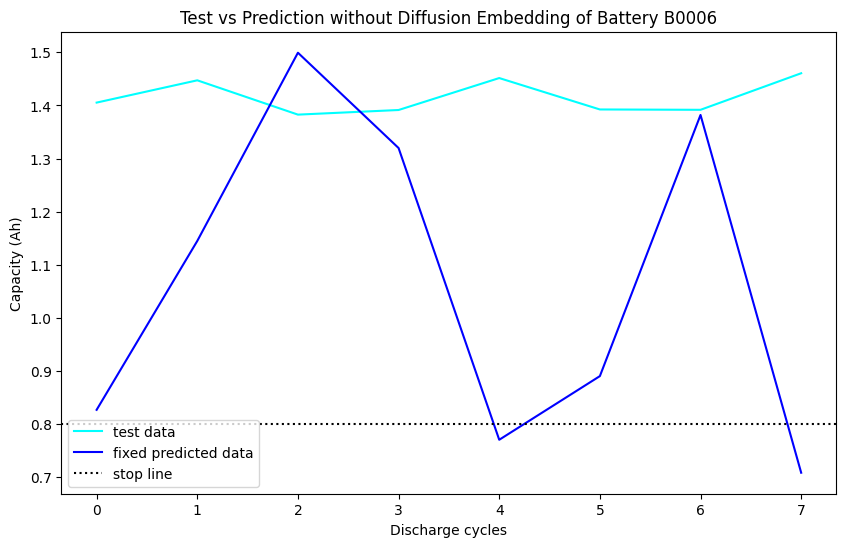

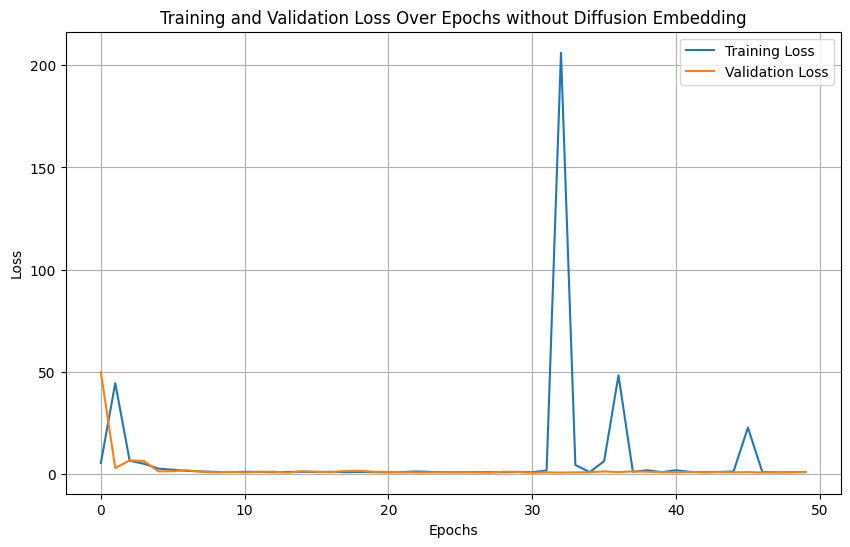

100%|██████████| 8/8 [00:00<00:00, 201.28it/s]



********************Matrices*********************
Test Loss is: 0.9397899359464645
MSE is: 0.2872028350830078
CRPS is: 0.348870996708432


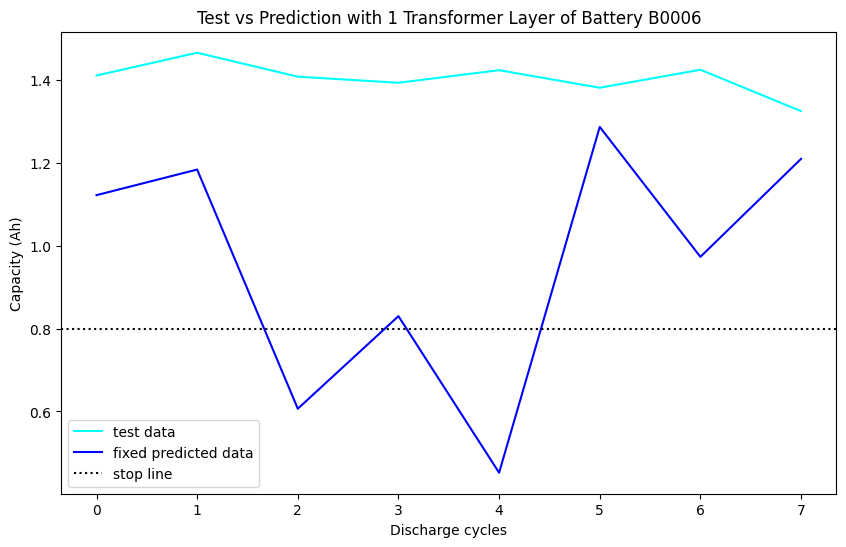

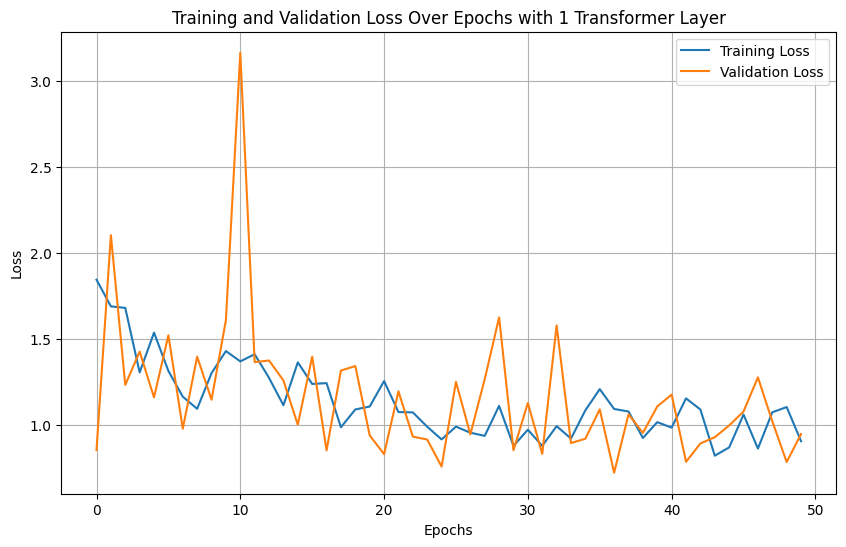

100%|██████████| 8/8 [00:00<00:00, 77.83it/s]



********************Matrices*********************
Test Loss is: 0.9833479672670364
MSE is: 0.25411364436149597
CRPS is: 0.44182907774264824


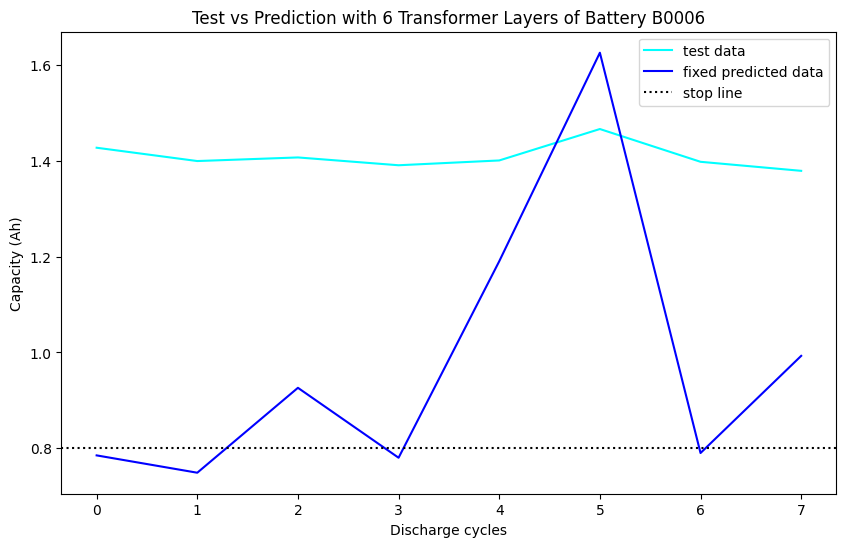

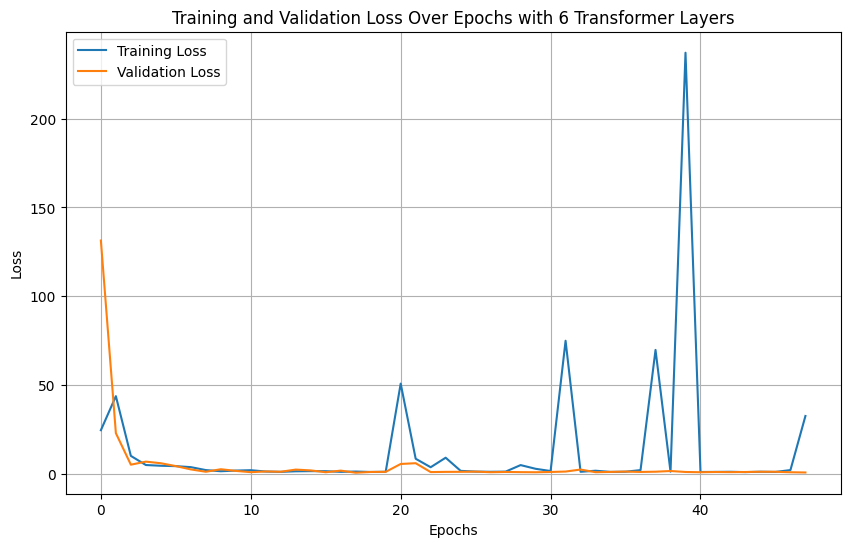

100%|██████████| 8/8 [00:00<00:00, 76.75it/s]



********************Matrices*********************
Test Loss is: 0.7392688393592834
MSE is: 0.42209506034851074
CRPS is: 0.3713141415054195


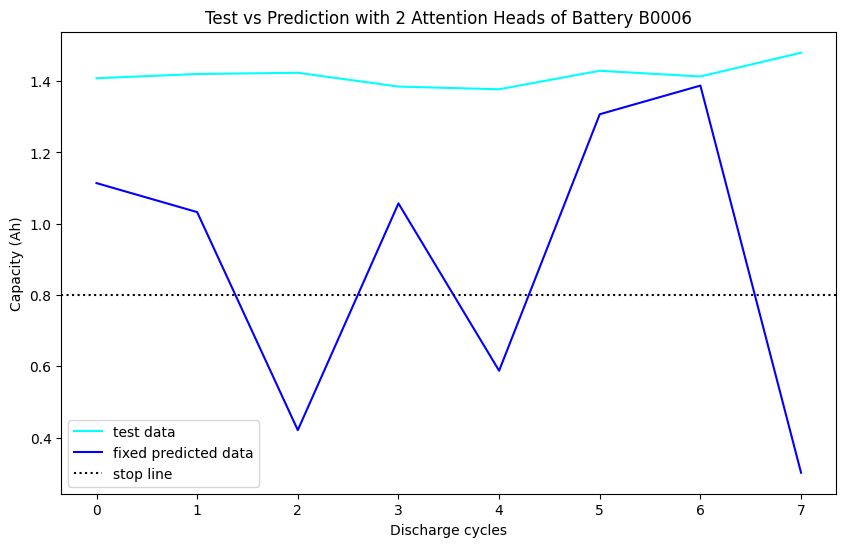

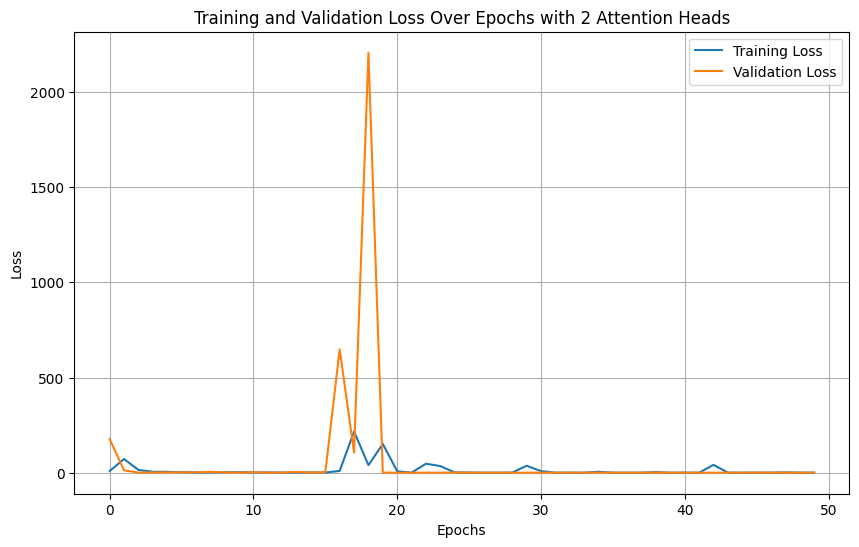

100%|██████████| 8/8 [00:00<00:00, 72.52it/s]



********************Matrices*********************
Test Loss is: 1.052823282778263
MSE is: 0.2939404249191284
CRPS is: 0.4605746666032456


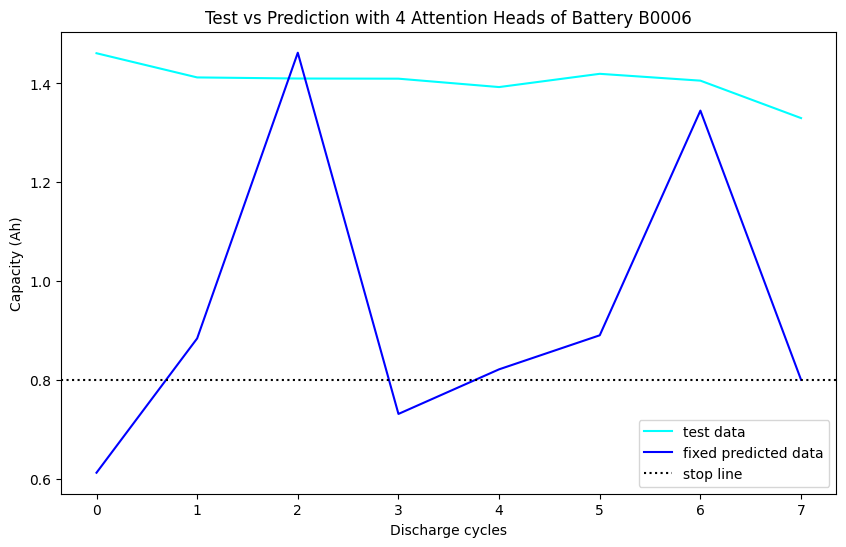

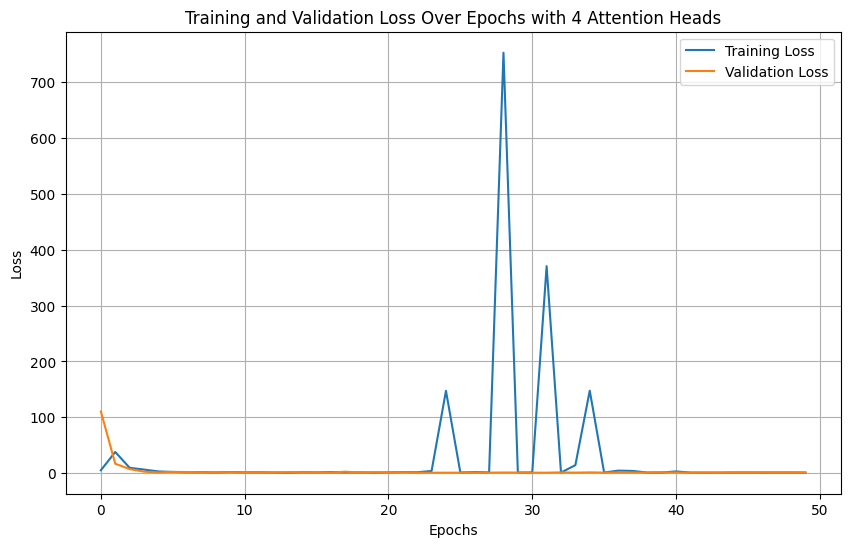

100%|██████████| 8/8 [00:00<00:00, 74.96it/s]



********************Matrices*********************
Test Loss is: 1.1978183686733246
MSE is: 0.20063674449920654
CRPS is: 0.24246296104136225


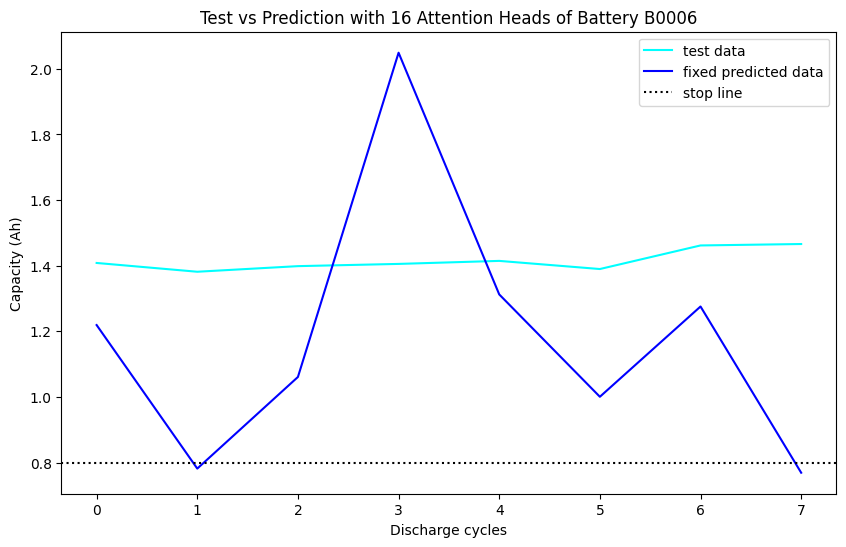

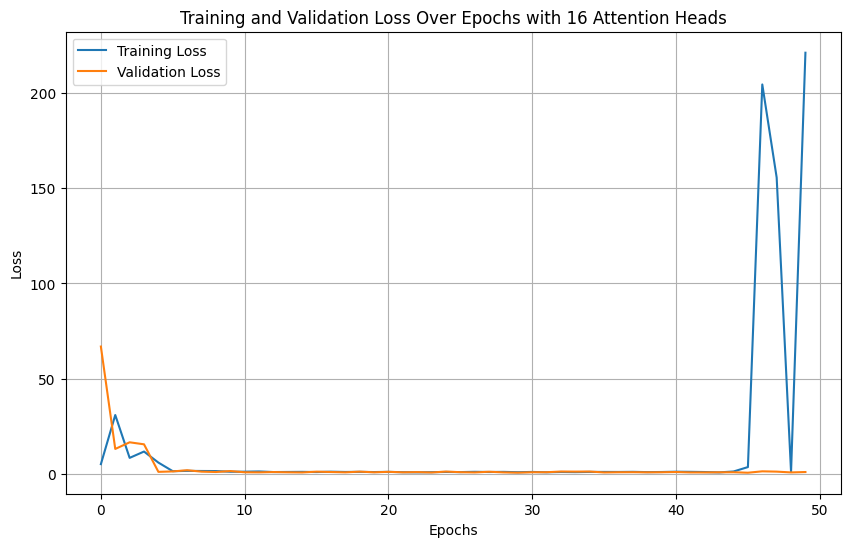

100%|██████████| 8/8 [00:00<00:00, 77.88it/s]



********************Matrices*********************
Test Loss is: 1.0286969542503357
MSE is: 0.21177908778190613
CRPS is: 0.2759829314688645


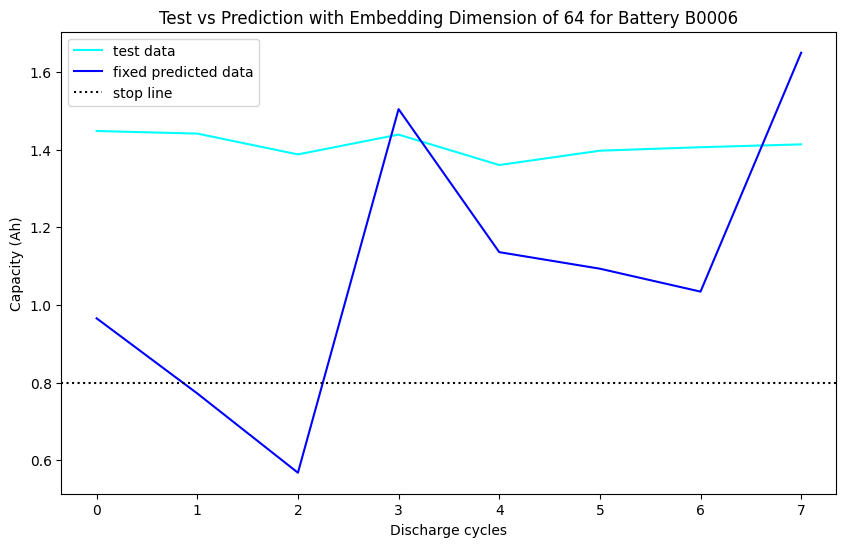

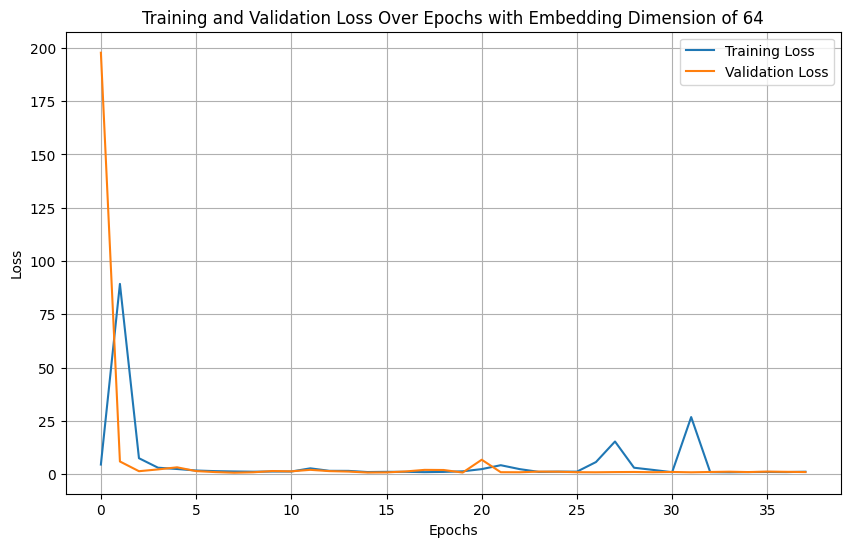

100%|██████████| 8/8 [00:00<00:00, 85.99it/s]



********************Matrices*********************
Test Loss is: 0.8785755895078182
MSE is: 0.38818371295928955
CRPS is: 0.4071238662687934


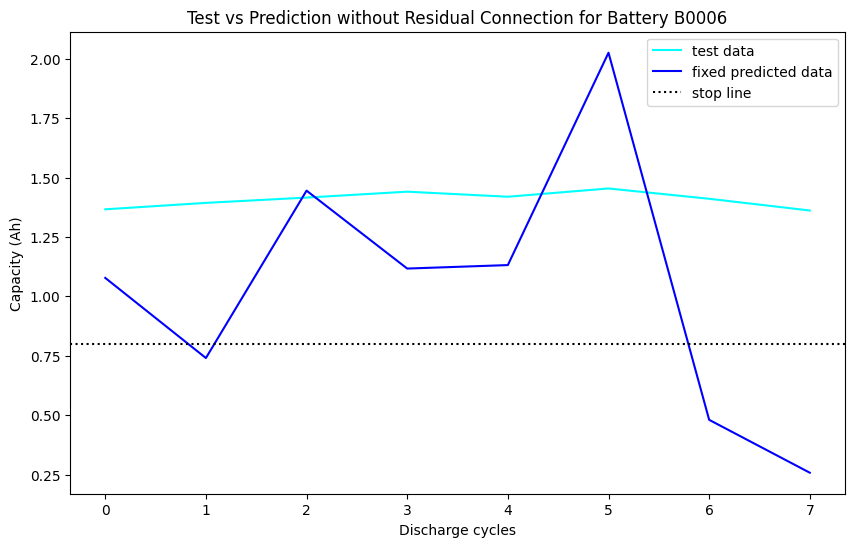

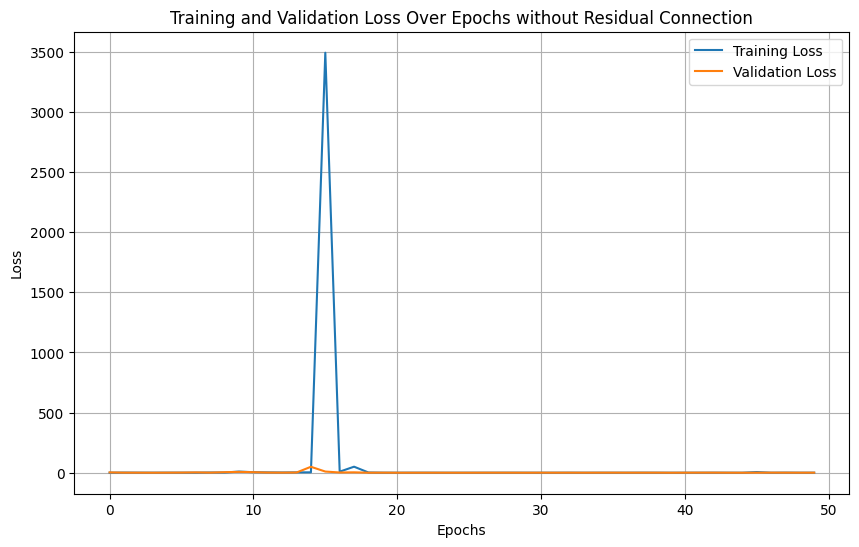

In [21]:
CRPS1, MSE1,loss1,predictions1 = evaluate(is_test=True, model=model_ablation1, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction without Diffusion Embedding of Battery {test_battery}')
plot_losses(train_loss1, valid_loss1, test_battery, title="Training and Validation Loss Over Epochs without Diffusion Embedding")

CRPS2, MSE2,loss2,predictions2 = evaluate(is_test=True, model=model_ablation2, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 1 Transformer Layer of Battery {test_battery}')
plot_losses(train_loss2, valid_loss2, test_battery, title="Training and Validation Loss Over Epochs with 1 Transformer Layer")

CRPS3, MSE3,loss3,predictions3 = evaluate(is_test=True, model=model_ablation3, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 6 Transformer Layers of Battery {test_battery}')
plot_losses(train_loss3, valid_loss3, test_battery, title="Training and Validation Loss Over Epochs with 6 Transformer Layers")

CRPS4, MSE4,loss4,predictions4 = evaluate(is_test=True, model=model_ablation4, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 2 Attention Heads of Battery {test_battery}')
plot_losses(train_loss4, valid_loss4, test_battery, title="Training and Validation Loss Over Epochs with 2 Attention Heads")

CRPS44, MSE44,loss44,predictions44 = evaluate(is_test=True, model=model_ablation44, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 4 Attention Heads of Battery {test_battery}')
plot_losses(train_loss44, valid_loss44, test_battery, title="Training and Validation Loss Over Epochs with 4 Attention Heads")

CRPS444, MSE444,loss444,predictions444 = evaluate(is_test=True, model=model_ablation444, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 16 Attention Heads of Battery {test_battery}')
plot_losses(train_loss444, valid_loss444, test_battery, title="Training and Validation Loss Over Epochs with 16 Attention Heads")

CRPS5, MSE5,loss5,predictions5 = evaluate(is_test=True, model=model_ablation5, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with Embedding Dimension of 64 for Battery {test_battery}')
plot_losses(train_loss5, valid_loss5, test_battery, title="Training and Validation Loss Over Epochs with Embedding Dimension of 64")

CRPS6, MSE6,loss6,predictions6 = evaluate(is_test=True, model=model_ablation6, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction without Residual Connection for Battery {test_battery}')
plot_losses(train_loss6, valid_loss6, test_battery, title="Training and Validation Loss Over Epochs without Residual Connection")


## **Noise Sensitivity Analysis**

100%|██████████| 8/8 [00:00<00:00, 246.23it/s]
/tmp/ipykernel_1418390/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 0.9274106472730637
MSE is: 0.34823307394981384
CRPS is: 0.5263091319399394


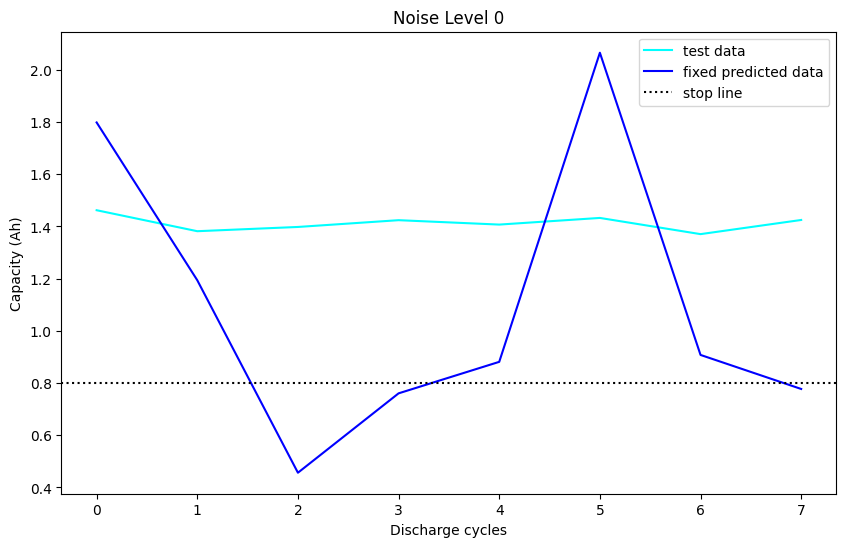

100%|██████████| 8/8 [00:00<00:00, 265.57it/s]



********************Matrices*********************
Test Loss is: 1.1426297165453434
MSE is: 0.2926318049430847
CRPS is: 0.341253563987137


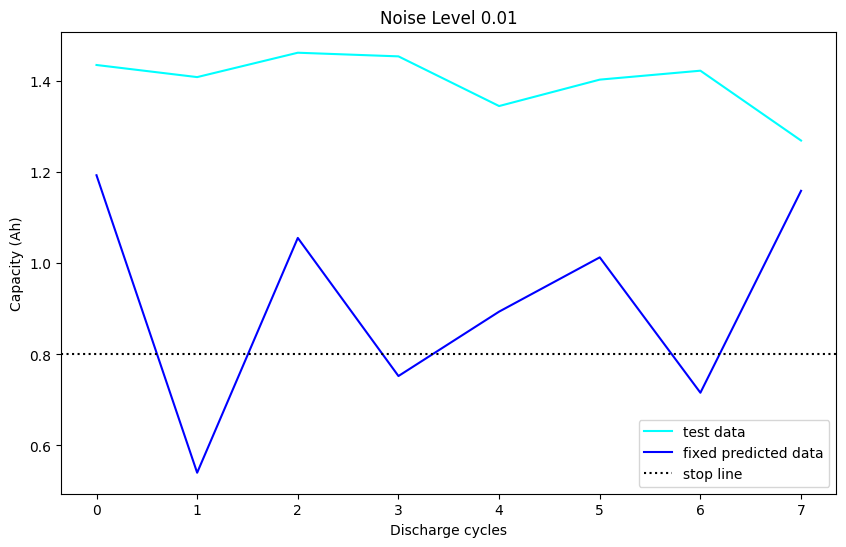

100%|██████████| 8/8 [00:00<00:00, 269.07it/s]



********************Matrices*********************
Test Loss is: 0.921115305274725
MSE is: 0.22003555297851562
CRPS is: 0.34039890275816004


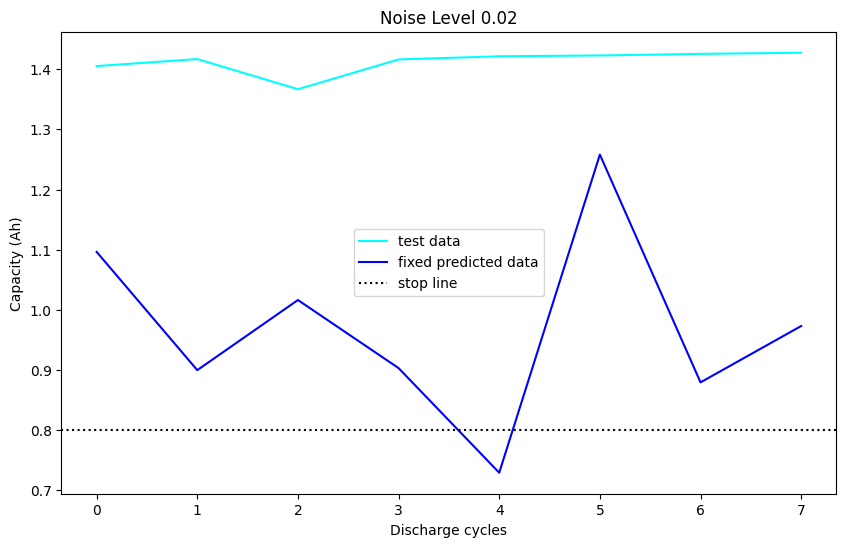

100%|██████████| 8/8 [00:00<00:00, 215.47it/s]



********************Matrices*********************
Test Loss is: 0.9543721899390221
MSE is: 0.38737788796424866
CRPS is: 0.5096692206747535


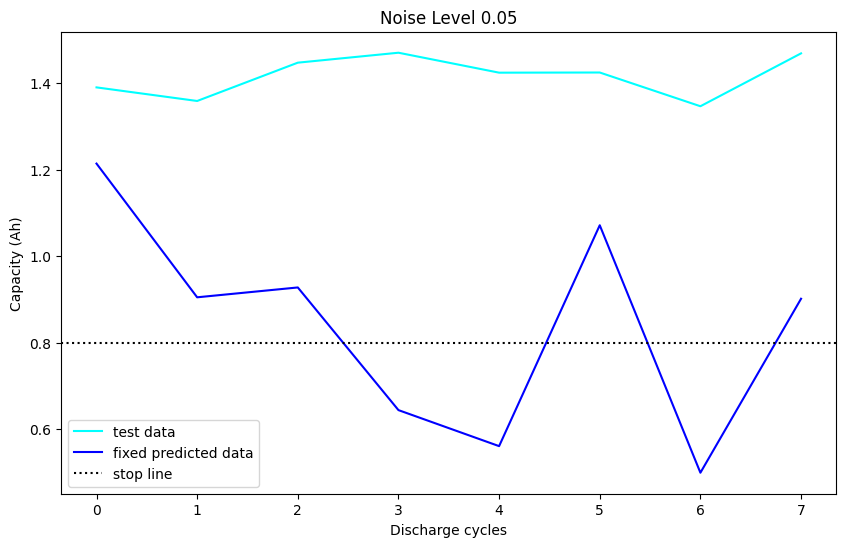

100%|██████████| 8/8 [00:00<00:00, 264.69it/s]



********************Matrices*********************
Test Loss is: 0.911189079284668
MSE is: 0.2165548950433731
CRPS is: 0.29181577415014703


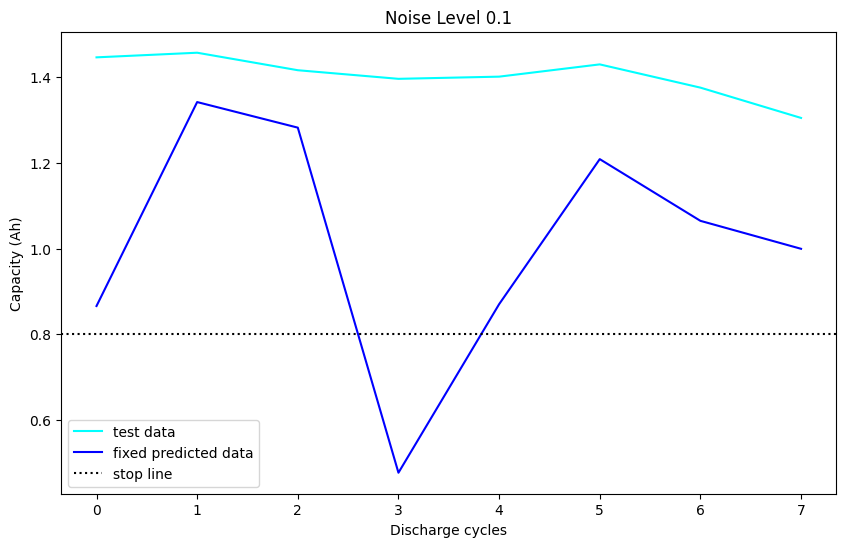

100%|██████████| 8/8 [00:00<00:00, 265.67it/s]



********************Matrices*********************
Test Loss is: 1.104242980480194
MSE is: 0.21634608507156372
CRPS is: 0.33412984390511014


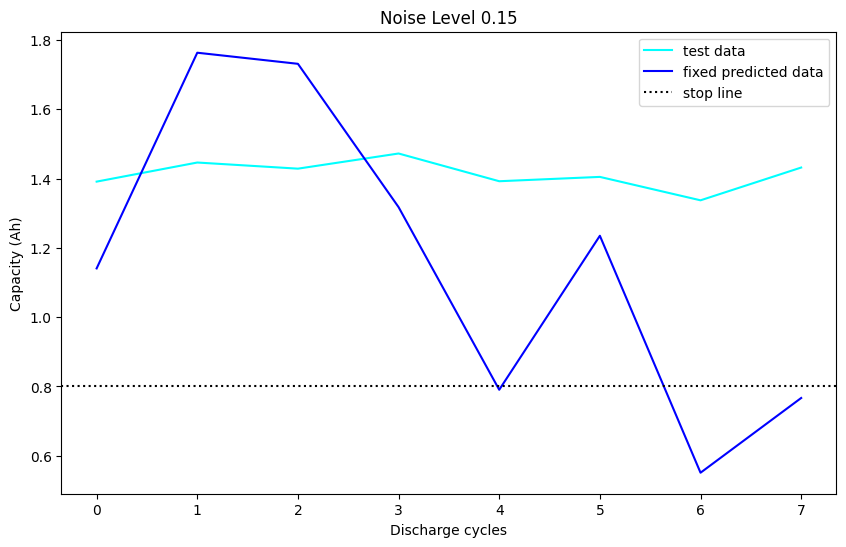

100%|██████████| 8/8 [00:00<00:00, 265.36it/s]



********************Matrices*********************
Test Loss is: 1.0279244780540466
MSE is: 0.252188116312027
CRPS is: 0.41048924134441345


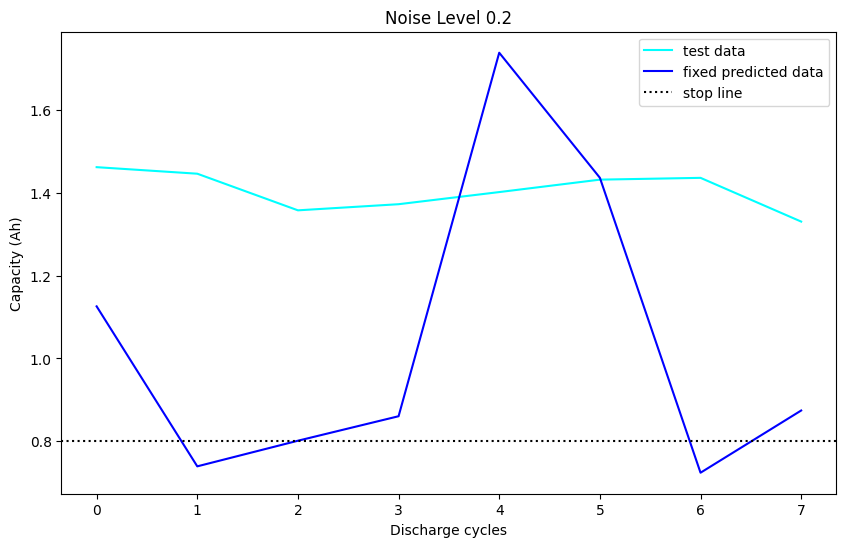

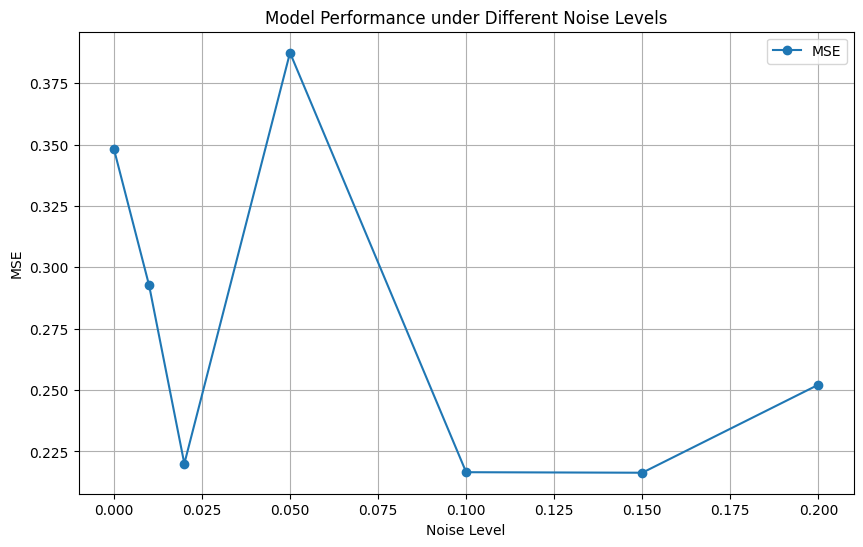

In [15]:

noise_levels = [0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
results = []

for noise_level in noise_levels:
    noisy_test_loader = []

    #Add Gaussian noise
    for batch in test_loader:
        inputs, labels = batch
        noise = torch.randn_like(inputs) * noise_level
        noisy_inputs = inputs + noise
        noisy_test_loader.append((noisy_inputs, labels))
    CRPS, MSE, loss, predictions = evaluate(is_test=True, model=model, data_loader=noisy_test_loader, nsample=1000, foldername=foldername, title=f'Noise Level {noise_level}')
    results.append((noise_level, CRPS, MSE, loss))
noise_levels, CRPS_values, MSE_values, loss_values = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, MSE_values, label='MSE', marker='o')
plt.xlabel('Noise Level')
plt.ylabel('MSE')
plt.title('Model Performance under Different Noise Levels')
plt.legend()
plt.grid(True)
plt.show()

Starting fold 1/5


/home/vivivorropoulou/Transformer_Diffusion_Model_RUL_Battery_Prediction/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:152: UserWarning: 
    Found GPU3 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
Epoch 1/50: 100%|██████████| 11/11 [00:01<00:00,  8.66it/s, loss=12.2]


Validation Loss: 30.425565719604492
Model saved with best validation loss: 30.425565719604492


Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 37.79it/s, loss=19.9]


Validation Loss: 4.396914482116699
Model saved with best validation loss: 4.396914482116699


Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 36.49it/s, loss=4.69]


Validation Loss: 15.31562360127767
No improvement count: 1


Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 37.72it/s, loss=11.1]


Validation Loss: 3.230851173400879
Model saved with best validation loss: 3.230851173400879


Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 37.40it/s, loss=3.24]


Validation Loss: 5.719869454701741
No improvement count: 1


Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 37.41it/s, loss=3.26]


Validation Loss: 2.524832566579183
Model saved with best validation loss: 2.524832566579183


Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 37.36it/s, loss=2.86]


Validation Loss: 1.8316662708918254
Model saved with best validation loss: 1.8316662708918254


Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 37.86it/s, loss=1.54]


Validation Loss: 1.012711723645528
Model saved with best validation loss: 1.012711723645528


Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 38.82it/s, loss=1.3] 


Validation Loss: 1.173454999923706
No improvement count: 1


Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 38.55it/s, loss=1.41]


Validation Loss: 0.9098845521608988
Model saved with best validation loss: 0.9098845521608988


Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 36.57it/s, loss=1.36]


Validation Loss: 1.355080286661784
No improvement count: 1


Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 38.02it/s, loss=1.24]


Validation Loss: 4.624035914738973
No improvement count: 2


Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 39.05it/s, loss=3.09]


Validation Loss: 1.523480494817098
No improvement count: 3


Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 38.21it/s, loss=1.36]


Validation Loss: 0.8634313742319742
Model saved with best validation loss: 0.8634313742319742


Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 37.42it/s, loss=1.36]


Validation Loss: 1.6949665546417236
No improvement count: 1


Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 36.77it/s, loss=1.57]


Validation Loss: 7.405373573303223
No improvement count: 2


Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 38.16it/s, loss=12.5]


Validation Loss: 191.39453125
No improvement count: 3


Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 39.40it/s, loss=80]  


Validation Loss: 14.189606348673502
No improvement count: 4


Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 36.97it/s, loss=27.9]


Validation Loss: 7.1288808186848955
No improvement count: 5


Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 38.78it/s, loss=3.91]


Validation Loss: 2.4861414432525635
No improvement count: 6


Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 39.33it/s, loss=1.47]


Validation Loss: 1.043569842974345
No improvement count: 7


Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 36.75it/s, loss=1.33]


Validation Loss: 1.1204999883969624
No improvement count: 8


Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 38.24it/s, loss=1.01]


Validation Loss: 1.0733763575553894
No improvement count: 9


Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 39.39it/s, loss=0.897]


Validation Loss: 1.0047362645467122
No improvement count: 10


Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 39.10it/s, loss=1.07]


Validation Loss: 0.879131535689036
No improvement count: 11


Epoch 26/50: 100%|██████████| 11/11 [00:00<00:00, 37.54it/s, loss=1.03] 


Validation Loss: 0.7127056618531545
Model saved with best validation loss: 0.7127056618531545


Epoch 27/50: 100%|██████████| 11/11 [00:00<00:00, 36.59it/s, loss=1.05]


Validation Loss: 1.1274390021959941
No improvement count: 1


Epoch 28/50: 100%|██████████| 11/11 [00:00<00:00, 38.35it/s, loss=0.929]


Validation Loss: 1.1078328092892964
No improvement count: 2


Epoch 29/50: 100%|██████████| 11/11 [00:00<00:00, 38.86it/s, loss=1.15]


Validation Loss: 0.9156213800112406
No improvement count: 3


Epoch 30/50: 100%|██████████| 11/11 [00:00<00:00, 39.82it/s, loss=0.969]


Validation Loss: 1.0600728591283162
No improvement count: 4


Epoch 31/50: 100%|██████████| 11/11 [00:00<00:00, 39.37it/s, loss=1.03] 


Validation Loss: 1.062876582145691
No improvement count: 5


Epoch 32/50: 100%|██████████| 11/11 [00:00<00:00, 36.93it/s, loss=1.01]


Validation Loss: 0.7916637460390726
No improvement count: 6


Epoch 33/50: 100%|██████████| 11/11 [00:00<00:00, 36.55it/s, loss=4.09]


Validation Loss: 0.9138160546620687
No improvement count: 7


Epoch 34/50: 100%|██████████| 11/11 [00:00<00:00, 37.35it/s, loss=1.27]


Validation Loss: 0.871500829855601
No improvement count: 8


Epoch 35/50: 100%|██████████| 11/11 [00:00<00:00, 36.94it/s, loss=1.73]


Validation Loss: 0.9080649018287659
No improvement count: 9


Epoch 36/50: 100%|██████████| 11/11 [00:00<00:00, 38.43it/s, loss=7.38]


Validation Loss: 0.985245148340861
No improvement count: 10


Epoch 37/50: 100%|██████████| 11/11 [00:00<00:00, 37.38it/s, loss=2.09]


Validation Loss: 0.8967292706171671
No improvement count: 11


Epoch 38/50: 100%|██████████| 11/11 [00:00<00:00, 39.03it/s, loss=5.05]


Validation Loss: 1.0338671604792278
No improvement count: 12


Epoch 39/50: 100%|██████████| 11/11 [00:00<00:00, 39.35it/s, loss=1.08]


Validation Loss: 1.0918484131495159
No improvement count: 13


Epoch 40/50: 100%|██████████| 11/11 [00:00<00:00, 37.96it/s, loss=4.28]


Validation Loss: 1.0141587654749553
No improvement count: 14


Epoch 41/50: 100%|██████████| 11/11 [00:00<00:00, 37.56it/s, loss=1.04]


Validation Loss: 1.1860414743423462
No improvement count: 15


Epoch 42/50: 100%|██████████| 11/11 [00:00<00:00, 38.80it/s, loss=1.82]


Validation Loss: 1.0611412127812703
No improvement count: 16


Epoch 43/50: 100%|██████████| 11/11 [00:00<00:00, 37.39it/s, loss=1.34]


Validation Loss: 0.8646621704101562
No improvement count: 17


Epoch 44/50: 100%|██████████| 11/11 [00:00<00:00, 37.64it/s, loss=1.08]


Validation Loss: 1.0498134295145671
No improvement count: 18


Epoch 45/50: 100%|██████████| 11/11 [00:00<00:00, 38.08it/s, loss=1.03]


Validation Loss: 0.7919270396232605
No improvement count: 19


Epoch 46/50: 100%|██████████| 11/11 [00:00<00:00, 37.08it/s, loss=22.2]


Validation Loss: 1.0166334708531697
No improvement count: 20


Epoch 47/50: 100%|██████████| 11/11 [00:00<00:00, 39.01it/s, loss=109]


Validation Loss: 1.109132746855418
No improvement count: 21


Epoch 48/50: 100%|██████████| 11/11 [00:00<00:00, 38.18it/s, loss=1.11]


Validation Loss: 1.0320259928703308
No improvement count: 22


Epoch 49/50: 100%|██████████| 11/11 [00:00<00:00, 39.52it/s, loss=0.984]


Validation Loss: 0.673346201578776
Model saved with best validation loss: 0.673346201578776


Epoch 50/50: 100%|██████████| 11/11 [00:00<00:00, 38.64it/s, loss=0.914]


Validation Loss: 1.2567596435546875
No improvement count: 1


100%|██████████| 3/3 [00:00<00:00, 107.41it/s]
/tmp/ipykernel_1418390/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 0.31004955619573593
MSE is: 0.20895437896251678
CRPS is: 0.20357807631587824


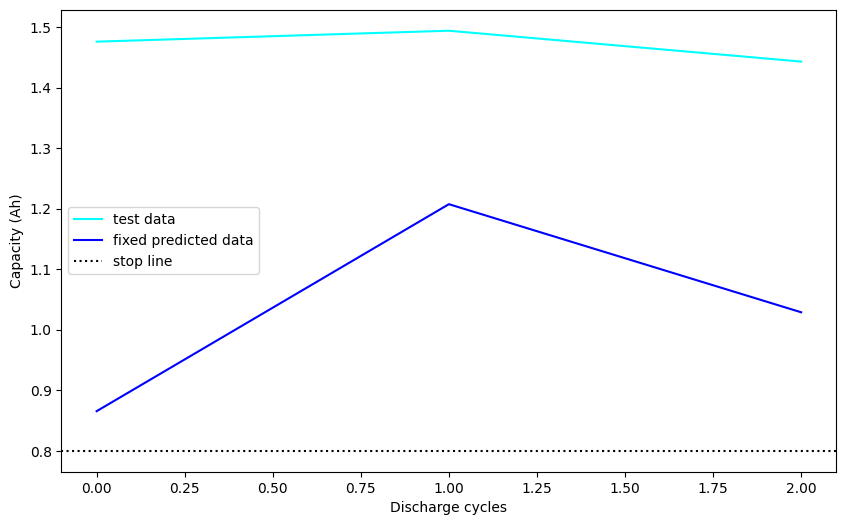

Fold 1 results: CRPS=0.41048924134441345, MSE=0.252188116312027, Test Loss=0.31004955619573593
Starting fold 2/5


Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 38.43it/s, loss=6.27]


Validation Loss: 49.07265853881836
Model saved with best validation loss: 49.07265853881836


Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 39.89it/s, loss=41.5]


Validation Loss: 3.2312915325164795
Model saved with best validation loss: 3.2312915325164795


Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 37.94it/s, loss=4.84]


Validation Loss: 15.497602780659994
No improvement count: 1


Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 37.13it/s, loss=12.3]


Validation Loss: 22.652053833007812
No improvement count: 2


Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 37.87it/s, loss=12.4]


Validation Loss: 10.141210238138834
No improvement count: 3


Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 37.28it/s, loss=5.42]


Validation Loss: 0.9114754796028137
Model saved with best validation loss: 0.9114754796028137


Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 37.23it/s, loss=1.44]


Validation Loss: 1.28350035349528
No improvement count: 1


Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 37.70it/s, loss=1.3] 


Validation Loss: 1.199635624885559
No improvement count: 2


Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 37.38it/s, loss=0.936]


Validation Loss: 1.551186203956604
No improvement count: 3


Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 37.58it/s, loss=1.19]


Validation Loss: 0.9968940814336141
No improvement count: 4


Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 37.21it/s, loss=0.993]


Validation Loss: 0.9170298973719279
No improvement count: 5


Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 37.42it/s, loss=0.954]


Validation Loss: 1.122141162554423
No improvement count: 6


Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 38.50it/s, loss=1.13]


Validation Loss: 0.958233654499054
No improvement count: 7


Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 39.24it/s, loss=1.06] 


Validation Loss: 0.8502965172131857
Model saved with best validation loss: 0.8502965172131857


Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 38.13it/s, loss=1.03]


Validation Loss: 1.191008726755778
No improvement count: 1


Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 36.99it/s, loss=1.04]


Validation Loss: 0.8546720743179321
No improvement count: 2


Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 38.24it/s, loss=0.972]


Validation Loss: 0.9272878964742025
No improvement count: 3


Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 36.81it/s, loss=1.08]


Validation Loss: 0.8687689105669657
No improvement count: 4


Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 38.04it/s, loss=1.09]


Validation Loss: 1.0391431252161663
No improvement count: 5


Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 38.57it/s, loss=0.989]


Validation Loss: 0.9157490134239197
No improvement count: 6


Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 38.87it/s, loss=1.02]


Validation Loss: 0.9569423397382101
No improvement count: 7


Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 37.33it/s, loss=1.17]


Validation Loss: 1.259551207224528
No improvement count: 8


Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 37.77it/s, loss=1.05]


Validation Loss: 1.0341133673985798
No improvement count: 9


Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 36.91it/s, loss=0.901]


Validation Loss: 1.1596436500549316
No improvement count: 10


Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 37.47it/s, loss=1]    


Validation Loss: 1.0326691071192424
No improvement count: 11


Epoch 26/50: 100%|██████████| 11/11 [00:00<00:00, 37.51it/s, loss=0.872]


Validation Loss: 0.9599946935971578
No improvement count: 12


Epoch 27/50: 100%|██████████| 11/11 [00:00<00:00, 36.93it/s, loss=1.15]


Validation Loss: 1.0334948499997456
No improvement count: 13


Epoch 28/50: 100%|██████████| 11/11 [00:00<00:00, 37.24it/s, loss=0.989]


Validation Loss: 1.0197782119115193
No improvement count: 14


Epoch 29/50: 100%|██████████| 11/11 [00:00<00:00, 37.52it/s, loss=0.934]


Validation Loss: 0.959791342417399
No improvement count: 15


Epoch 30/50: 100%|██████████| 11/11 [00:00<00:00, 37.64it/s, loss=1.14]


Validation Loss: 0.7870609561602274
Model saved with best validation loss: 0.7870609561602274


Epoch 31/50: 100%|██████████| 11/11 [00:00<00:00, 37.38it/s, loss=0.873]


Validation Loss: 0.7308282057444254
Model saved with best validation loss: 0.7308282057444254


Epoch 32/50: 100%|██████████| 11/11 [00:00<00:00, 37.13it/s, loss=0.954]


Validation Loss: 1.2613487243652344
No improvement count: 1


Epoch 33/50: 100%|██████████| 11/11 [00:00<00:00, 37.71it/s, loss=0.958]


Validation Loss: 0.9968415896097819
No improvement count: 2


Epoch 34/50: 100%|██████████| 11/11 [00:00<00:00, 37.80it/s, loss=0.984]


Validation Loss: 1.0379855632781982
No improvement count: 3


Epoch 35/50: 100%|██████████| 11/11 [00:00<00:00, 38.69it/s, loss=0.886]


Validation Loss: 0.8902310132980347
No improvement count: 4


Epoch 36/50: 100%|██████████| 11/11 [00:00<00:00, 36.95it/s, loss=0.971]


Validation Loss: 0.8363585273424784
No improvement count: 5


Epoch 37/50: 100%|██████████| 11/11 [00:00<00:00, 37.57it/s, loss=1.11]


Validation Loss: 1.0759862661361694
No improvement count: 6


Epoch 38/50: 100%|██████████| 11/11 [00:00<00:00, 37.45it/s, loss=0.997]


Validation Loss: 1.0842726230621338
No improvement count: 7


Epoch 39/50: 100%|██████████| 11/11 [00:00<00:00, 37.79it/s, loss=1.01]


Validation Loss: 0.8439621329307556
No improvement count: 8


Epoch 40/50: 100%|██████████| 11/11 [00:00<00:00, 39.61it/s, loss=1.01]


Validation Loss: 1.177357017993927
No improvement count: 9


Epoch 41/50: 100%|██████████| 11/11 [00:00<00:00, 37.93it/s, loss=1.1]


Validation Loss: 0.8094775478045145
No improvement count: 10


Epoch 42/50: 100%|██████████| 11/11 [00:00<00:00, 38.57it/s, loss=1.01] 


Validation Loss: 0.8729827006657919
No improvement count: 11


Epoch 43/50: 100%|██████████| 11/11 [00:00<00:00, 36.87it/s, loss=0.943]


Validation Loss: 1.1234054565429688
No improvement count: 12


Epoch 44/50: 100%|██████████| 11/11 [00:00<00:00, 36.93it/s, loss=1.11]


Validation Loss: 0.972616950670878
No improvement count: 13


Epoch 45/50: 100%|██████████| 11/11 [00:00<00:00, 38.89it/s, loss=1.2] 


Validation Loss: 0.7453736861546835
No improvement count: 14


Epoch 46/50: 100%|██████████| 11/11 [00:00<00:00, 37.26it/s, loss=0.91] 


Validation Loss: 1.2884280681610107
No improvement count: 15


Epoch 47/50: 100%|██████████| 11/11 [00:00<00:00, 38.73it/s, loss=0.921]


Validation Loss: 0.9925916989644369
No improvement count: 16


Epoch 48/50: 100%|██████████| 11/11 [00:00<00:00, 36.88it/s, loss=1.11]


Validation Loss: 1.0627984205881755
No improvement count: 17


Epoch 49/50: 100%|██████████| 11/11 [00:00<00:00, 39.07it/s, loss=1.02]


Validation Loss: 0.9241892099380493
No improvement count: 18


Epoch 50/50: 100%|██████████| 11/11 [00:00<00:00, 36.41it/s, loss=1.09]


Validation Loss: 1.5215832392374675
No improvement count: 19


100%|██████████| 3/3 [00:00<00:00, 116.85it/s]



********************Matrices*********************
Test Loss is: 0.3966042771935463
MSE is: 0.19665001332759857
CRPS is: 0.23776984218399266


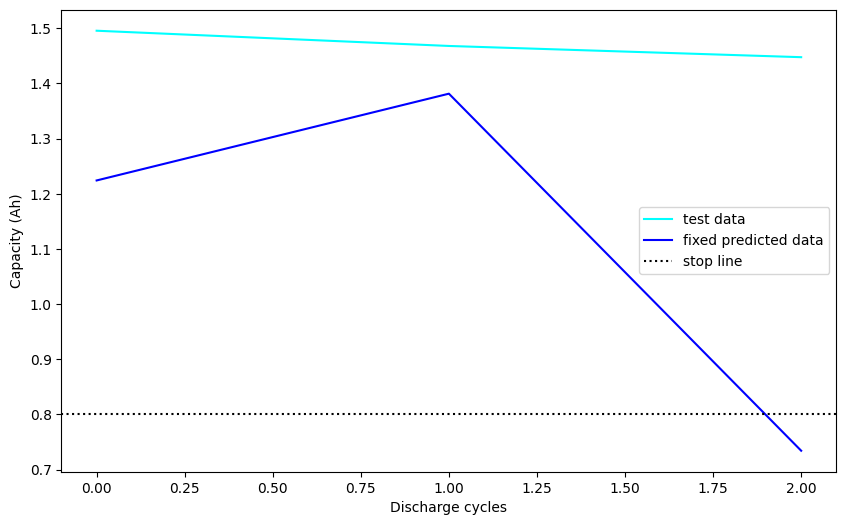

Fold 2 results: CRPS=0.41048924134441345, MSE=0.252188116312027, Test Loss=0.3966042771935463
Starting fold 3/5


Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 38.40it/s, loss=1.4] 


Validation Loss: 42.23685201009115
Model saved with best validation loss: 42.23685201009115


Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 39.17it/s, loss=28.3]


Validation Loss: 20.03005027770996
Model saved with best validation loss: 20.03005027770996


Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 37.37it/s, loss=11.8]


Validation Loss: 7.27274211247762
Model saved with best validation loss: 7.27274211247762


Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 37.43it/s, loss=5.3] 


Validation Loss: 6.887574195861816
Model saved with best validation loss: 6.887574195861816


Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 38.40it/s, loss=6.08]


Validation Loss: 6.533918221791585
Model saved with best validation loss: 6.533918221791585


Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 37.42it/s, loss=3.21]


Validation Loss: 5.888772646586101
Model saved with best validation loss: 5.888772646586101


Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 37.55it/s, loss=2.91]


Validation Loss: 1.1514088312784831
Model saved with best validation loss: 1.1514088312784831


Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 37.13it/s, loss=1.66]


Validation Loss: 1.851425011952718
No improvement count: 1


Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 37.32it/s, loss=1.76]


Validation Loss: 1.0607745448748271
Model saved with best validation loss: 1.0607745448748271


Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 37.32it/s, loss=1.43]


Validation Loss: 1.779705325762431
No improvement count: 1


Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 37.17it/s, loss=1.96]


Validation Loss: 1.6395632425944011
No improvement count: 2


Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 37.06it/s, loss=1.24]


Validation Loss: 0.7770416140556335
Model saved with best validation loss: 0.7770416140556335


Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 39.70it/s, loss=1.15]


Validation Loss: 0.9753652811050415
No improvement count: 1


Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 39.24it/s, loss=0.896]


Validation Loss: 1.0285729964574177
No improvement count: 2


Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 38.21it/s, loss=1.01] 


Validation Loss: 1.040019929409027
No improvement count: 3


Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 37.58it/s, loss=1.04]


Validation Loss: 0.9403343399365743
No improvement count: 4


Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 38.12it/s, loss=1.01] 


Validation Loss: 0.9788105090459188
No improvement count: 5


Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 36.85it/s, loss=0.944]


Validation Loss: 0.8535671432813009
No improvement count: 6


Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 37.47it/s, loss=1.01]


Validation Loss: 0.7904351949691772
No improvement count: 7


Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 37.88it/s, loss=0.999]


Validation Loss: 1.212506930033366
No improvement count: 8


Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 37.96it/s, loss=0.952]


Validation Loss: 1.0946288108825684
No improvement count: 9


Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 37.48it/s, loss=0.916]


Validation Loss: 1.2741923530896504
No improvement count: 10


Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 37.75it/s, loss=1]    


Validation Loss: 1.0227397680282593
No improvement count: 11


Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 37.82it/s, loss=0.934]


Validation Loss: 1.0869484941164653
No improvement count: 12


Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 37.85it/s, loss=0.988]


Validation Loss: 1.389172355333964
No improvement count: 13


Epoch 26/50: 100%|██████████| 11/11 [00:00<00:00, 37.58it/s, loss=0.916]


Validation Loss: 0.8484211762746176
No improvement count: 14


Epoch 27/50: 100%|██████████| 11/11 [00:00<00:00, 37.87it/s, loss=0.907]


Validation Loss: 1.2686166961987813
No improvement count: 15


Epoch 28/50: 100%|██████████| 11/11 [00:00<00:00, 38.12it/s, loss=1]   


Validation Loss: 0.9978423118591309
No improvement count: 16


Epoch 29/50: 100%|██████████| 11/11 [00:00<00:00, 38.83it/s, loss=1.1] 


Validation Loss: 1.0929070115089417
No improvement count: 17


Epoch 30/50: 100%|██████████| 11/11 [00:00<00:00, 38.15it/s, loss=1.03]


Validation Loss: 1.0012987057367961
No improvement count: 18


Epoch 31/50: 100%|██████████| 11/11 [00:00<00:00, 36.94it/s, loss=0.978]


Validation Loss: 1.2288634379704793
No improvement count: 19


Epoch 32/50: 100%|██████████| 11/11 [00:00<00:00, 38.84it/s, loss=0.991]


Validation Loss: 0.8928911884625753
No improvement count: 20


Epoch 33/50: 100%|██████████| 11/11 [00:00<00:00, 38.29it/s, loss=1.04]


Validation Loss: 0.8335855007171631
No improvement count: 21


Epoch 34/50: 100%|██████████| 11/11 [00:00<00:00, 37.32it/s, loss=1.05]


Validation Loss: 0.9237124919891357
No improvement count: 22


Epoch 35/50: 100%|██████████| 11/11 [00:00<00:00, 37.44it/s, loss=1.03]


Validation Loss: 1.0350601275761921
No improvement count: 23


Epoch 36/50: 100%|██████████| 11/11 [00:00<00:00, 39.36it/s, loss=0.965]


Validation Loss: 0.6090114116668701
Model saved with best validation loss: 0.6090114116668701


Epoch 37/50: 100%|██████████| 11/11 [00:00<00:00, 36.93it/s, loss=1.18]


Validation Loss: 1.1316626071929932
No improvement count: 1


Epoch 38/50: 100%|██████████| 11/11 [00:00<00:00, 37.46it/s, loss=1.15]


Validation Loss: 1.0357721249262493
No improvement count: 2


Epoch 39/50: 100%|██████████| 11/11 [00:00<00:00, 37.41it/s, loss=0.985]


Validation Loss: 0.9000053803126017
No improvement count: 3


Epoch 40/50: 100%|██████████| 11/11 [00:00<00:00, 37.46it/s, loss=1.09]


Validation Loss: 1.112138311068217
No improvement count: 4


Epoch 41/50: 100%|██████████| 11/11 [00:00<00:00, 37.68it/s, loss=0.949]


Validation Loss: 1.016247570514679
No improvement count: 5


Epoch 42/50: 100%|██████████| 11/11 [00:00<00:00, 36.91it/s, loss=0.996]


Validation Loss: 1.0252756675084431
No improvement count: 6


Epoch 43/50: 100%|██████████| 11/11 [00:00<00:00, 37.71it/s, loss=1.01] 


Validation Loss: 1.0266310969988506
No improvement count: 7


Epoch 44/50: 100%|██████████| 11/11 [00:00<00:00, 37.54it/s, loss=0.974]


Validation Loss: 1.1542240977287292
No improvement count: 8


Epoch 45/50: 100%|██████████| 11/11 [00:00<00:00, 36.70it/s, loss=0.893]


Validation Loss: 0.7971938451131185
No improvement count: 9


Epoch 46/50: 100%|██████████| 11/11 [00:00<00:00, 37.62it/s, loss=0.971]


Validation Loss: 0.9513323704401652
No improvement count: 10


Epoch 47/50: 100%|██████████| 11/11 [00:00<00:00, 38.60it/s, loss=0.891]


Validation Loss: 1.0105737447738647
No improvement count: 11


Epoch 48/50: 100%|██████████| 11/11 [00:00<00:00, 38.35it/s, loss=0.969]


Validation Loss: 0.9470029274622599
No improvement count: 12


Epoch 49/50: 100%|██████████| 11/11 [00:00<00:00, 37.12it/s, loss=1.07]


Validation Loss: 0.835144837697347
No improvement count: 13


Epoch 50/50: 100%|██████████| 11/11 [00:00<00:00, 36.80it/s, loss=0.949]


Validation Loss: 1.4739490747451782
No improvement count: 14


100%|██████████| 3/3 [00:00<00:00, 118.39it/s]



********************Matrices*********************
Test Loss is: 0.4061001092195511
MSE is: 0.24602572619915009
CRPS is: 0.34710247116427945


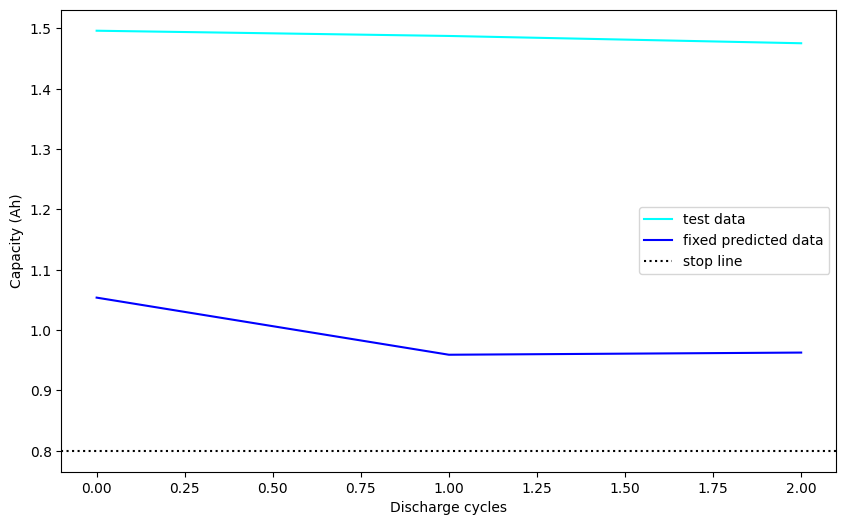

Fold 3 results: CRPS=0.41048924134441345, MSE=0.252188116312027, Test Loss=0.4061001092195511
Starting fold 4/5


Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 37.84it/s, loss=4.11]


Validation Loss: 47.53180185953776
Model saved with best validation loss: 47.53180185953776


Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 40.34it/s, loss=28.9]


Validation Loss: 36.827170054117836
Model saved with best validation loss: 36.827170054117836


Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 39.32it/s, loss=26.3]


Validation Loss: 11.463567415873209
Model saved with best validation loss: 11.463567415873209


Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 38.61it/s, loss=6.7] 


Validation Loss: 1.5912235577901204
Model saved with best validation loss: 1.5912235577901204


Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 37.95it/s, loss=2.28]


Validation Loss: 3.3550570805867515
No improvement count: 1


Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 38.34it/s, loss=1.94]


Validation Loss: 1.4571250279744465
Model saved with best validation loss: 1.4571250279744465


Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 38.17it/s, loss=1.59]


Validation Loss: 1.5530425707499187
No improvement count: 1


Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 38.07it/s, loss=1.3] 


Validation Loss: 2.169013818105062
No improvement count: 2


Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 38.09it/s, loss=1.79]


Validation Loss: 2.1286151011784873
No improvement count: 3


Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 38.52it/s, loss=1.66]


Validation Loss: 1.1522379120190938
Model saved with best validation loss: 1.1522379120190938


Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 37.65it/s, loss=1.7] 


Validation Loss: 3.2381351788838706
No improvement count: 1


Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 38.48it/s, loss=2.13]


Validation Loss: 1.2178010543187459
No improvement count: 2


Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 37.54it/s, loss=1.2] 


Validation Loss: 0.7840596338113149
Model saved with best validation loss: 0.7840596338113149


Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 37.62it/s, loss=1.16]


Validation Loss: 0.9818631807963053
No improvement count: 1


Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 37.99it/s, loss=1.14]


Validation Loss: 0.8257564107577006
No improvement count: 2


Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 38.72it/s, loss=0.882]


Validation Loss: 0.9855125149091085
No improvement count: 3


Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 37.25it/s, loss=1.25]


Validation Loss: 0.9885343313217163
No improvement count: 4


Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 37.72it/s, loss=0.892]


Validation Loss: 0.92545219262441
No improvement count: 5


Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 36.60it/s, loss=0.936]


Validation Loss: 1.0580457250277202
No improvement count: 6


Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 37.12it/s, loss=1.11]


Validation Loss: 1.1912043889363606
No improvement count: 7


Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 36.93it/s, loss=1.05]


Validation Loss: 0.8356307546297709
No improvement count: 8


Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 38.26it/s, loss=0.948]


Validation Loss: 1.0438498655954997
No improvement count: 9


Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 38.42it/s, loss=1.08]


Validation Loss: 1.1407249768575032
No improvement count: 10


Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 37.49it/s, loss=0.873]


Validation Loss: 1.0826404889424641
No improvement count: 11


Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 37.67it/s, loss=1]   


Validation Loss: 0.8078208565711975
No improvement count: 12


Epoch 26/50: 100%|██████████| 11/11 [00:00<00:00, 37.57it/s, loss=106] 


Validation Loss: 0.9789680242538452
No improvement count: 13


Epoch 27/50: 100%|██████████| 11/11 [00:00<00:00, 36.80it/s, loss=1.01]


Validation Loss: 1.007340947786967
No improvement count: 14


Epoch 28/50: 100%|██████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.951]


Validation Loss: 0.883868396282196
No improvement count: 15


Epoch 29/50: 100%|██████████| 11/11 [00:00<00:00, 38.25it/s, loss=1.09]


Validation Loss: 1.0821937322616577
No improvement count: 16


Epoch 30/50: 100%|██████████| 11/11 [00:00<00:00, 38.32it/s, loss=1.02]


Validation Loss: 1.0069640676180522
No improvement count: 17


Epoch 31/50: 100%|██████████| 11/11 [00:00<00:00, 38.47it/s, loss=1.07]


Validation Loss: 0.694921592871348
Model saved with best validation loss: 0.694921592871348


Epoch 32/50: 100%|██████████| 11/11 [00:00<00:00, 36.45it/s, loss=0.985]


Validation Loss: 1.0006651083628337
No improvement count: 1


Epoch 33/50: 100%|██████████| 11/11 [00:00<00:00, 36.49it/s, loss=1.07]


Validation Loss: 0.6912644704182943
Model saved with best validation loss: 0.6912644704182943


Epoch 34/50: 100%|██████████| 11/11 [00:00<00:00, 37.73it/s, loss=0.984]


Validation Loss: 0.958814283212026
No improvement count: 1


Epoch 35/50: 100%|██████████| 11/11 [00:00<00:00, 38.08it/s, loss=0.832]


Validation Loss: 0.8449535369873047
No improvement count: 2


Epoch 36/50: 100%|██████████| 11/11 [00:00<00:00, 38.39it/s, loss=1.01]


Validation Loss: 1.2405125101407368
No improvement count: 3


Epoch 37/50: 100%|██████████| 11/11 [00:00<00:00, 36.55it/s, loss=1.37]


Validation Loss: 1.0572037100791931
No improvement count: 4


Epoch 38/50: 100%|██████████| 11/11 [00:00<00:00, 37.19it/s, loss=1.17]


Validation Loss: 0.8860562841097513
No improvement count: 5


Epoch 39/50: 100%|██████████| 11/11 [00:00<00:00, 37.57it/s, loss=0.93] 


Validation Loss: 1.1199159224828084
No improvement count: 6


Epoch 40/50: 100%|██████████| 11/11 [00:00<00:00, 37.41it/s, loss=1.06]


Validation Loss: 0.772299180428187
No improvement count: 7


Epoch 41/50: 100%|██████████| 11/11 [00:00<00:00, 36.18it/s, loss=1.04]


Validation Loss: 0.7426691055297852
No improvement count: 8


Epoch 42/50: 100%|██████████| 11/11 [00:00<00:00, 37.70it/s, loss=0.982]


Validation Loss: 0.8400805989901224
No improvement count: 9


Epoch 43/50: 100%|██████████| 11/11 [00:00<00:00, 38.14it/s, loss=1]   


Validation Loss: 0.893166700998942
No improvement count: 10


Epoch 44/50: 100%|██████████| 11/11 [00:00<00:00, 37.21it/s, loss=0.864]


Validation Loss: 0.9987223347028097
No improvement count: 11


Epoch 45/50: 100%|██████████| 11/11 [00:00<00:00, 36.33it/s, loss=0.959]


Validation Loss: 2.772826294104258
No improvement count: 12


Epoch 46/50: 100%|██████████| 11/11 [00:00<00:00, 38.22it/s, loss=208]


Validation Loss: 0.795175830523173
No improvement count: 13


Epoch 47/50: 100%|██████████| 11/11 [00:00<00:00, 36.46it/s, loss=1]   


Validation Loss: 0.9229896267255148
No improvement count: 14


Epoch 48/50: 100%|██████████| 11/11 [00:00<00:00, 37.42it/s, loss=1.03] 


Validation Loss: 0.8710652391115824
No improvement count: 15


Epoch 49/50: 100%|██████████| 11/11 [00:00<00:00, 37.09it/s, loss=3.45]


Validation Loss: 0.8274734218915304
No improvement count: 16


Epoch 50/50: 100%|██████████| 11/11 [00:00<00:00, 37.33it/s, loss=5.8] 


Validation Loss: 0.9203067620595297
No improvement count: 17


100%|██████████| 3/3 [00:00<00:00, 120.85it/s]



********************Matrices*********************
Test Loss is: 0.41292284429073334
MSE is: 0.5402073860168457
CRPS is: 0.7342807639571586


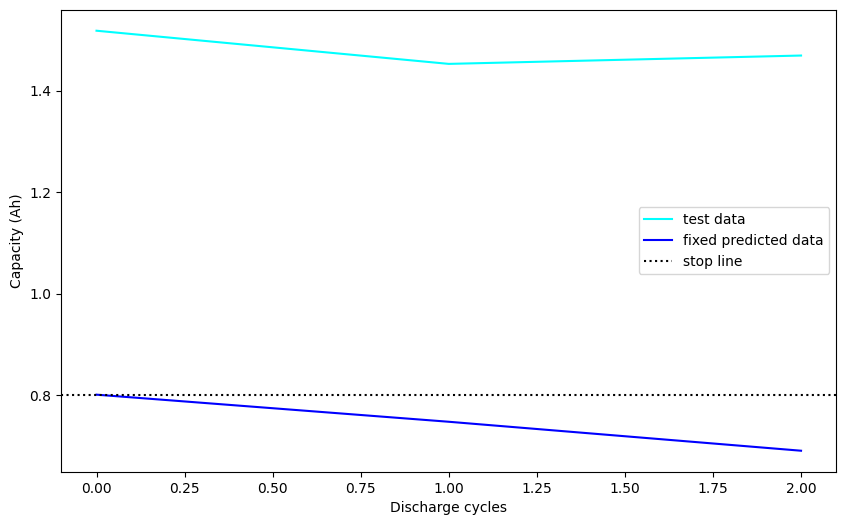

Fold 4 results: CRPS=0.41048924134441345, MSE=0.252188116312027, Test Loss=0.41292284429073334
Starting fold 5/5


Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 37.35it/s, loss=7.86]


Validation Loss: 87.79745737711589
Model saved with best validation loss: 87.79745737711589


Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 37.84it/s, loss=67.7]


Validation Loss: 4.102397521336873
Model saved with best validation loss: 4.102397521336873


Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 37.84it/s, loss=3.74]


Validation Loss: 4.633749961853027
No improvement count: 1


Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 37.71it/s, loss=6.38]


Validation Loss: 10.37170664469401
No improvement count: 2


Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 37.84it/s, loss=3.84]


Validation Loss: 3.4166261355082193
Model saved with best validation loss: 3.4166261355082193


Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 39.08it/s, loss=2.56]


Validation Loss: 2.117948373158773
Model saved with best validation loss: 2.117948373158773


Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 37.39it/s, loss=2.84]


Validation Loss: 1.3385854562123616
Model saved with best validation loss: 1.3385854562123616


Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 36.96it/s, loss=2.04]


Validation Loss: 1.1239463885625203
Model saved with best validation loss: 1.1239463885625203


Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 37.40it/s, loss=1.27]


Validation Loss: 2.590017795562744
No improvement count: 1


Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 37.54it/s, loss=1.76]


Validation Loss: 2.048075795173645
No improvement count: 2


Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 37.94it/s, loss=1.42]


Validation Loss: 0.9917125503222147
Model saved with best validation loss: 0.9917125503222147


Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 37.29it/s, loss=0.966]


Validation Loss: 0.9678507248560587
Model saved with best validation loss: 0.9678507248560587


Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 36.75it/s, loss=0.913]


Validation Loss: 1.108006477355957
No improvement count: 1


Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 37.83it/s, loss=0.982]


Validation Loss: 1.166975776354472
No improvement count: 2


Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 37.28it/s, loss=0.951]


Validation Loss: 0.9570461908976237
Model saved with best validation loss: 0.9570461908976237


Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 38.40it/s, loss=0.926]


Validation Loss: 0.9972200989723206
No improvement count: 1


Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 37.56it/s, loss=1.04]


Validation Loss: 0.9252398411432902
Model saved with best validation loss: 0.9252398411432902


Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 38.49it/s, loss=1.13]


Validation Loss: 1.0674022634824116
No improvement count: 1


Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 37.51it/s, loss=1.09]


Validation Loss: 0.7109495401382446
Model saved with best validation loss: 0.7109495401382446


Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 36.61it/s, loss=0.94] 


Validation Loss: 1.2893601258595784
No improvement count: 1


Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 36.32it/s, loss=0.969]


Validation Loss: 1.1893686453501384
No improvement count: 2


Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 37.18it/s, loss=1.01]


Validation Loss: 1.111436128616333
No improvement count: 3


Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 38.20it/s, loss=0.959]


Validation Loss: 0.9295808871587118
No improvement count: 4


Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 38.06it/s, loss=0.993]


Validation Loss: 0.7107340097427368
Model saved with best validation loss: 0.7107340097427368


Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 38.26it/s, loss=0.947]


Validation Loss: 1.0251936415831249
No improvement count: 1


Epoch 26/50: 100%|██████████| 11/11 [00:00<00:00, 36.64it/s, loss=0.991]


Validation Loss: 0.8593090375264486
No improvement count: 2


Epoch 27/50: 100%|██████████| 11/11 [00:00<00:00, 38.18it/s, loss=0.86] 


Validation Loss: 1.0072686473528545
No improvement count: 3


Epoch 28/50: 100%|██████████| 11/11 [00:00<00:00, 36.57it/s, loss=0.908]


Validation Loss: 0.8902190923690796
No improvement count: 4


Epoch 29/50: 100%|██████████| 11/11 [00:00<00:00, 36.69it/s, loss=0.93] 


Validation Loss: 0.9947463671366373
No improvement count: 5


Epoch 30/50: 100%|██████████| 11/11 [00:00<00:00, 36.60it/s, loss=1.06]


Validation Loss: 0.9653939008712769
No improvement count: 6


Epoch 31/50: 100%|██████████| 11/11 [00:00<00:00, 37.33it/s, loss=0.975]


Validation Loss: 1.0837214787801106
No improvement count: 7


Epoch 32/50: 100%|██████████| 11/11 [00:00<00:00, 37.96it/s, loss=1.09]


Validation Loss: 0.8840335408846537
No improvement count: 8


Epoch 33/50: 100%|██████████| 11/11 [00:00<00:00, 37.71it/s, loss=0.995]


Validation Loss: 0.8864598671595255
No improvement count: 9


Epoch 34/50: 100%|██████████| 11/11 [00:00<00:00, 37.62it/s, loss=1]   


Validation Loss: 1.085351824760437
No improvement count: 10


Epoch 35/50: 100%|██████████| 11/11 [00:00<00:00, 38.17it/s, loss=1.01]


Validation Loss: 1.3817861080169678
No improvement count: 11


Epoch 36/50: 100%|██████████| 11/11 [00:00<00:00, 37.29it/s, loss=1.13]


Validation Loss: 0.945792019367218
No improvement count: 12


Epoch 37/50: 100%|██████████| 11/11 [00:00<00:00, 38.19it/s, loss=0.934]


Validation Loss: 0.9341678222020467
No improvement count: 13


Epoch 38/50: 100%|██████████| 11/11 [00:00<00:00, 38.24it/s, loss=0.929]


Validation Loss: 0.977721651395162
No improvement count: 14


Epoch 39/50: 100%|██████████| 11/11 [00:00<00:00, 36.60it/s, loss=0.94]


Validation Loss: 0.8252356251080831
No improvement count: 15


Epoch 40/50: 100%|██████████| 11/11 [00:00<00:00, 36.65it/s, loss=0.908]


Validation Loss: 0.8856545885403951
No improvement count: 16


Epoch 41/50: 100%|██████████| 11/11 [00:00<00:00, 37.11it/s, loss=1.07]


Validation Loss: 0.7896041472752889
No improvement count: 17


Epoch 42/50: 100%|██████████| 11/11 [00:00<00:00, 38.26it/s, loss=0.927]


Validation Loss: 0.8933205008506775
No improvement count: 18


Epoch 43/50: 100%|██████████| 11/11 [00:00<00:00, 38.50it/s, loss=1.02]


Validation Loss: 1.0726139942804973
No improvement count: 19


Epoch 44/50: 100%|██████████| 11/11 [00:00<00:00, 37.63it/s, loss=0.988]


Validation Loss: 1.0920158227284749
No improvement count: 20


Epoch 45/50: 100%|██████████| 11/11 [00:00<00:00, 38.39it/s, loss=0.909]


Validation Loss: 0.9271225531895956
No improvement count: 21


Epoch 46/50: 100%|██████████| 11/11 [00:00<00:00, 38.40it/s, loss=0.968]


Validation Loss: 0.9957759777704874
No improvement count: 22


Epoch 47/50: 100%|██████████| 11/11 [00:00<00:00, 36.26it/s, loss=0.988]


Validation Loss: 0.9748812913894653
No improvement count: 23


Epoch 48/50: 100%|██████████| 11/11 [00:00<00:00, 38.06it/s, loss=1.19]


Validation Loss: 1.2227086027463276
No improvement count: 24


Epoch 49/50: 100%|██████████| 11/11 [00:00<00:00, 38.32it/s, loss=0.98] 


Validation Loss: 1.1427806615829468
No improvement count: 25


Epoch 50/50: 100%|██████████| 11/11 [00:00<00:00, 38.59it/s, loss=0.909]


Validation Loss: 0.7912535270055135
No improvement count: 26


100%|██████████| 3/3 [00:00<00:00, 113.90it/s]



********************Matrices*********************
Test Loss is: 0.3682423606514931
MSE is: 0.13698990643024445
CRPS is: 0.2765790293760801


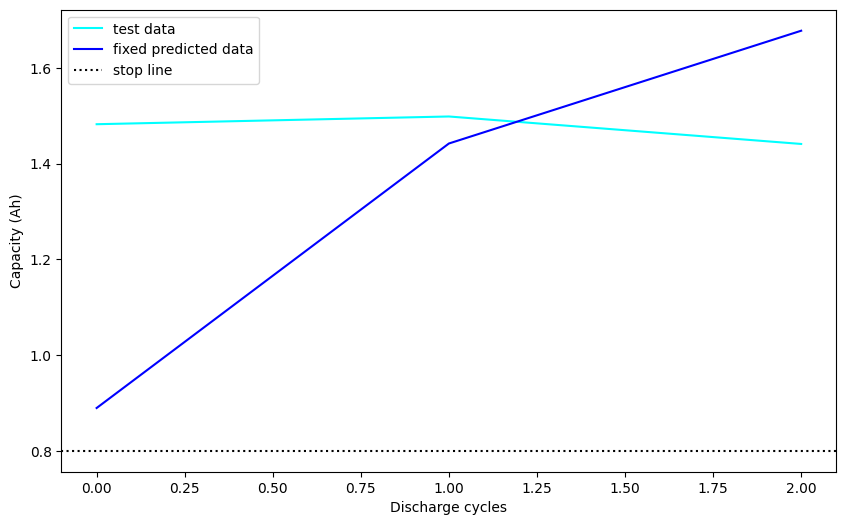

Fold 5 results: CRPS=0.41048924134441345, MSE=0.252188116312027, Test Loss=0.3682423606514931
Average results across 5 folds: {'train_losses': 4.7525894068046055, 'valid_losses': 3.687147828261058, 'CRPS': 0.3598620365994778, 'MSE': 0.2657655, 'test_losses': 0.37878382951021194}


In [16]:
from sklearn.model_selection import KFold

def k_fold_cross_validation(config, dataset, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = {
        "train_losses": [],
        "valid_losses": [],
        "CRPS": [],
        "MSE": [],
        "test_losses": []
    }

    for fold, (train_idx, valid_idx) in enumerate(kf.split(range(len(dataset)))):
        print(f"Starting fold {fold+1}/{k}")
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        valid_subset = torch.utils.data.Subset(dataset, valid_idx)
        
        train_loadercross = DataLoader(train_subset, batch_size=config.get('train', {}).get('batch_size', 16), shuffle=True)
        valid_loadercross = DataLoader(valid_subset, batch_size=config.get('train', {}).get('batch_size', 16), shuffle=False)
        
        modelcross = TDSTF(config, device).to(device)
        
        trained_modelcross, train_losscross, valid_losscross = train(
            modelcross,
            config,
            train_loadercross,
            valid_loader=valid_loadercross,
            foldername=f'fold_{fold+1}/'
        )

        fold_results["train_losses"].append(train_losscross)
        fold_results["valid_losses"].append(valid_losscross)

        CRPScross, MSEcross, test_losscross, predictionscross = evaluate(
            is_test=True,
            model=trained_modelcross,
            data_loader=valid_loadercross,
            nsample=1000,
            foldername=f'fold_{fold+1}/'
        )
                             
        fold_results["CRPS"].append(CRPScross)
        fold_results["MSE"].append(MSEcross)
        fold_results["test_losses"].append(test_losscross)
        
        print(f"Fold {fold+1} results: CRPS={CRPS}, MSE={MSE}, Test Loss={test_losscross}")
    avg_results = {key: np.mean(values) for key, values in fold_results.items()}
    print(f"Average results across {k} folds: {avg_results}")

    return fold_results, avg_results, CRPScross, MSEcross, test_losscross, train_losscross, valid_losscross

combined_datasets = []
for battery in Battery_list:
    with open(f'preprocess/data/NASA/{battery}_processed.pkl', 'rb') as f:
        data = pickle.load(f)
        var = data['var']
        target_var = data['target_var']
        X_tensor = torch.tensor(var, dtype=torch.float32)
        y_tensor = torch.tensor(target_var, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        combined_datasets.append(dataset)

full_dataset = ConcatDataset(combined_datasets)
config = yaml.safe_load(open('config/base.yaml', 'r'))
fold_results, avg_results, CRPScross, MSEcross, test_losscross, train_losscross, valid_losscross = k_fold_cross_validation(config, full_dataset, k=5)

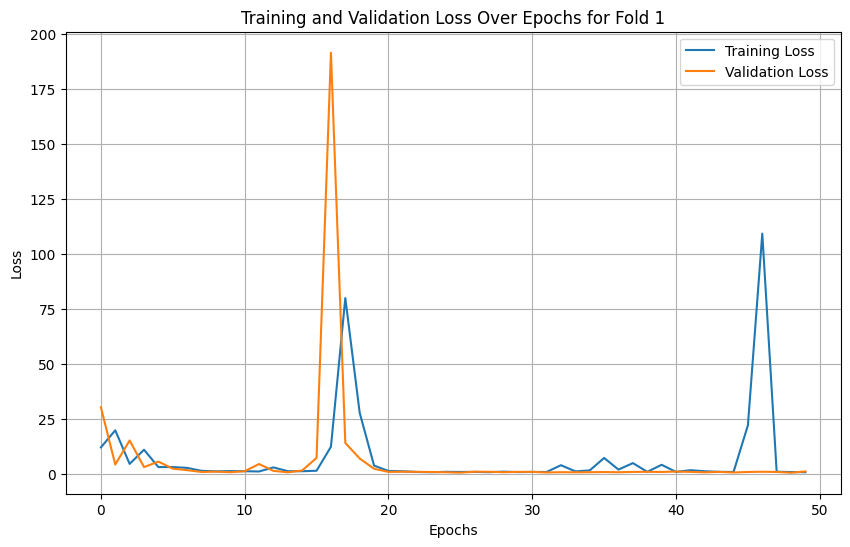

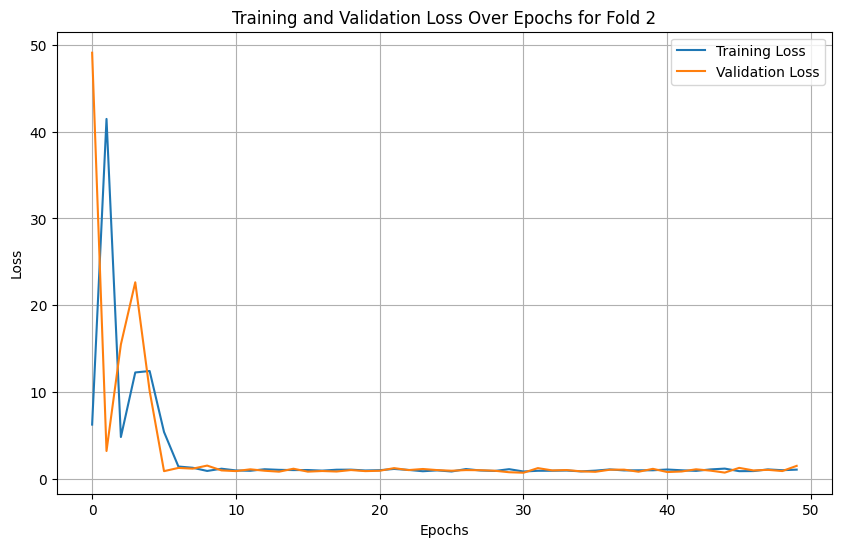

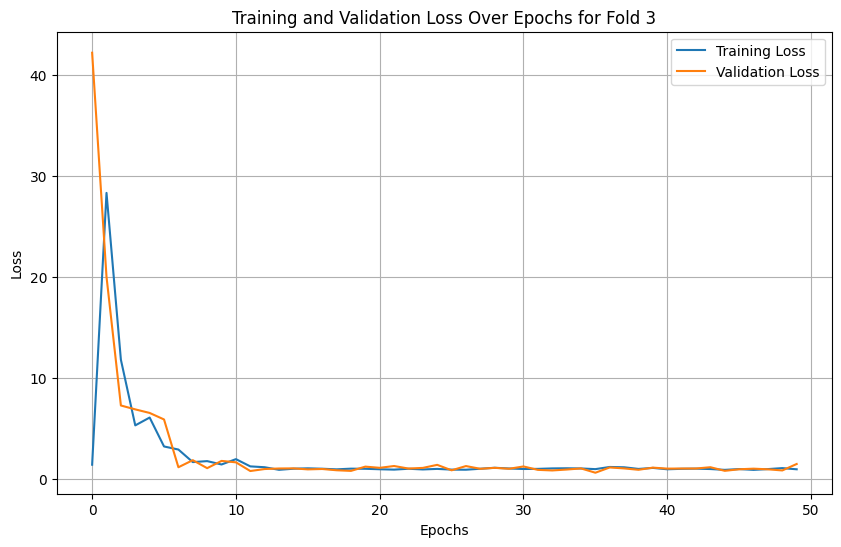

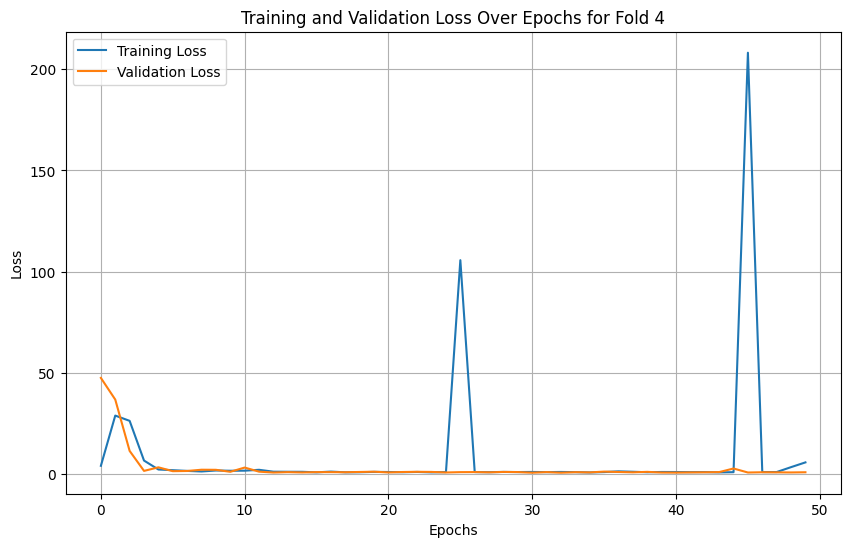

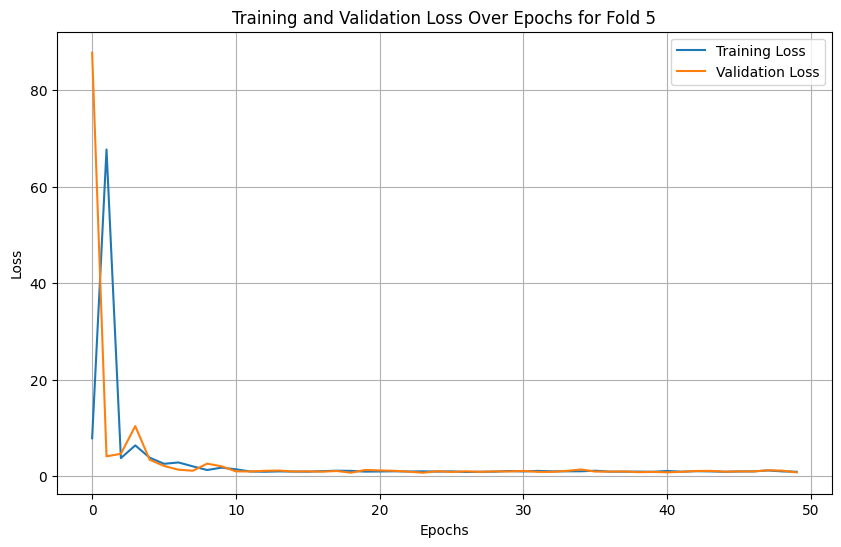

In [24]:
for fold in range(5):
    train_losses = fold_results["train_losses"][fold]
    valid_losses = fold_results["valid_losses"][fold]
    plot_losses(train_losses, valid_losses, test_battery, title=f"Training and Validation Loss Over Epochs for Fold {fold+1}")